In [ ]:
import matplotlib.pyplot as plt
from seaborn import heatmap
from seaborn import pairplot
from besos import eppy_funcs as ef
from besos import sampling
from besos.evaluator import EvaluatorEP
from besos.parameters import RangeParameter, FieldSelector, FilterSelector, Parameter, expand_plist, wwr, CategoryParameter, GenericSelector
from besos.problem import EPProblem
import pandas as pd
import numpy as np

: 

In [ ]:
output_dir = './opt_out'
epw_file = '../weather/Torre_Pellice-hour.epw'
# Define the list of idf files with different glazing type setting and set each type to a int flag
idf_files = ['../IDF/single.idf','../IDF/double.idf','../IDF/triple.idf']
idf_flags = [1,2,3]
# idf_files = ['../IDF/single_Hourly.idf']
# idf_flags = [1]
# per_sample_num = 2

In [ ]:
# Load idf files defined in the list
buildings = []
for file in idf_files:
    buildings.append(ef.get_building(file))

In [ ]:
# [materials.Name for materials in building.idfobjects['WindowShadingControl']]# get a list of the Name property of all IDF objects of class MATERIAL
# for materials in building.idfobjects["WindowShadingControl"]:
#     if materials.Name =='1001-MainXground:Zone1':
#         print(materials)

In [ ]:
# Define the fields to optimaize
insulation = FieldSelector(class_name='Material',\
                           object_name='XPS Extruded Polystyrene  - CO2 Blowing_.0795',\
                           field_name='Thickness')
ach = FieldSelector(class_name='ZoneVentilation:DesignFlowRate',\
                            object_name='*',\
                            field_name='Air Changes per Hour')
shading_temp = FieldSelector(class_name='WindowShadingControl',\
                                object_name='*',\
                                field_name='Setpoint')
shading_irradiation = FieldSelector(class_name='WindowShadingControl',\
                                object_name='*',\
                                field_name='Setpoint 2')

In [ ]:
#Define the values for each field
# insulation_options=[0.25,0.3,0.35]
# ach_options = [0,2,4,6]
# shading_temp_options = [20,24,28]
# shading_irradiation_options=[80,120,240,300]
insulation_options=[0.35]
ach_options = [6]
shading_temp_options = [280]
shading_irradiation_options=[3000]

insulation_range = CategoryParameter(options=insulation_options)
ach_choice = CategoryParameter(options=ach_options)
shading_temp_range=CategoryParameter(options=shading_temp_options)
shading_irradiation_range=CategoryParameter(options=shading_irradiation_options)


In [ ]:
# Define the params according to fields and field valuse
insulation_param = Parameter(selector=insulation,
                            value_descriptors=[insulation_range],
                            name='Insulation Thickness')
ach_param = Parameter(selector=ach,
                            value_descriptors=[ach_choice],
                            name='ACH')
shading_temp_param = Parameter(selector=shading_temp,
                            value_descriptors=[shading_temp_range],
                            name='shading temperature')
shading_irradiation_param =Parameter(selector=shading_irradiation,
                            value_descriptors=[shading_irradiation_range],
                            name='shading irradiation')

parameters = [insulation_param,ach_param,shading_temp_param,shading_irradiation_param] 

In [ ]:
# Define the objectives and the problem
objectives = ['Electricity:Facility','DistrictHeating:Facility','DistrictCooling:Facility'] # these get made into `MeterReader` or `VariableReader`
problem=EPProblem(parameters, objectives) # problem = parameters + objectives
problem

EPProblem(inputs=[Parameter(selector=FieldSelector(field_name='Thickness', class_name='Material', object_name='XPS Extruded Polystyrene  - CO2 Blowing_.0795'), value_descriptors=[CategoryParameter(options=[0.25, 0.3, 0.35])]), Parameter(selector=FieldSelector(field_name='Air Changes per Hour', class_name='ZoneVentilation:DesignFlowRate', object_name='*'), value_descriptors=[CategoryParameter(options=[0, 2, 4, 6])]), Parameter(selector=FieldSelector(field_name='Setpoint', class_name='WindowShadingControl', object_name='*'), value_descriptors=[CategoryParameter(options=[20, 24, 28])]), Parameter(selector=FieldSelector(field_name='Setpoint 2', class_name='WindowShadingControl', object_name='*'), value_descriptors=[CategoryParameter(options=[80, 120, 240, 300])])], outputs=[MeterReader(class_name='Output:Meter', func=<function sum_values at 0x7f10c9980550>, key_name='Electricity:Facility'), MeterReader(class_name='Output:Meter', func=<function sum_values at 0x7f10c9980550>, key_name='Distr

In [ ]:
# Create the samples (each idf with different glazing setting will run accross these samples)
# samples = sampling.dist_sampler(sampling.lhs, problem, num_samples=2)
# samples
samples_raw = []
for i_o in insulation_options:
    for a_o in ach_options:
        for s_t_o in shading_temp_options:
            for s_i_o in shading_irradiation_options:
                samples_raw.append([i_o,a_o,s_t_o,s_i_o])
samples = pd.DataFrame(np.array(samples_raw),columns=['Insulation Thickness','ACH','shading temperature','shading irradiation'])
samples

Insulation Thickness  ACH  shading temperature  shading irradiation
0                    0.25  0.0                 20.0                 80.0
1                    0.25  0.0                 20.0                120.0
2                    0.25  0.0                 20.0                240.0
3                    0.25  0.0                 20.0                300.0
4                    0.25  0.0                 24.0                 80.0
..                    ...  ...                  ...                  ...
139                  0.35  6.0                 24.0                300.0
140                  0.35  6.0                 28.0                 80.0
141                  0.35  6.0                 28.0                120.0
142                  0.35  6.0                 28.0                240.0
143                  0.35  6.0                 28.0                300.0

[144 rows x 4 columns]

In [ ]:
# Evaluate the probem with different idfs and collect the results
results = []
for i in range(len(buildings)):
    evaluator = EvaluatorEP(problem, buildings[i], out_dir=output_dir, err_dir=output_dir ,epw=epw_file) # evaluator = problem + building
    output = evaluator.df_apply(samples, keep_input=True)
    results.append(output)

Executing:   0%|          | 0/144 [00:00<?, ?row/s]

EnergyPlus Starting
EnergyPlus, Version 9.0.1-bb7ca4f0da, YMD=2022.02.05 23:09
Initializing Response Factors
Calculating CTFs for "INTERNAL FLOOR 46CM", Construction # 3
Calculating CTFs for "INTERNAL FLOOR 46CM", Construction # 3
Calculating CTFs for "INTERNAL UNINSULATED WALL 53CM", Construction # 7
Calculating CTFs for "INTERNAL UNINSULATED WALL 53CM", Construction # 7
Calculating CTFs for "PROJECT INTERNAL DOOR", Construction # 9
Calculating CTFs for "COPY OF UNINSULATED WALL 53CM", Construction # 11
Calculating CTFs for "COPY OF UNINSULATED WALL 53CM", Construction # 11
Calculating CTFs for "INTERNAL UNINSULATED WALL 15CM", Construction # 13
Calculating CTFs for "INTERNAL UNINSULATED WALL 12CM", Construction # 17
Calculating CTFs for "PROJECT SEMI-EXPOSED WALL", Construction # 19
Calculating CTFs for "PROJECT SEMI-EXPOSED WALL", Construction # 19
Calculating CTFs for "COPY OF UNINSULATED WALL 30CM", Construction # 25
Initializing Window Optical Properties
Initializing Solar Calcul

EnergyPlus Completed Successfully.


EnergyPlus Starting
EnergyPlus, Version 9.0.1-bb7ca4f0da, YMD=2022.02.05 23:10
Initializing Response Factors
Calculating CTFs for "INTERNAL FLOOR 46CM", Construction # 3
Calculating CTFs for "INTERNAL FLOOR 46CM", Construction # 3
Calculating CTFs for "INTERNAL UNINSULATED WALL 53CM", Construction # 7
Calculating CTFs for "INTERNAL UNINSULATED WALL 53CM", Construction # 7
Calculating CTFs for "PROJECT INTERNAL DOOR", Construction # 9
Calculating CTFs for "COPY OF UNINSULATED WALL 53CM", Construction # 11
Calculating CTFs for "COPY OF UNINSULATED WALL 53CM", Construction # 11
Calculating CTFs for "INTERNAL UNINSULATED WALL 15CM", Construction # 13
Calculating CTFs for "INTERNAL UNINSULATED WALL 12CM", Construction # 17
Calculating CTFs for "PROJECT SEMI-EXPOSED WALL", Construction # 19
Calculating CTFs for "PROJECT SEMI-EXPOSED WALL", Construction # 19
Calculating CTFs for "COPY OF UNINSULATED WALL 30CM", Construction # 25
Initializing Window Optical Properties
Initializing Solar Calcul

EnergyPlus Completed Successfully.


EnergyPlus Starting
EnergyPlus, Version 9.0.1-bb7ca4f0da, YMD=2022.02.05 23:10
Initializing Response Factors
Calculating CTFs for "INTERNAL FLOOR 46CM", Construction # 3
Calculating CTFs for "INTERNAL FLOOR 46CM", Construction # 3
Calculating CTFs for "INTERNAL UNINSULATED WALL 53CM", Construction # 7
Calculating CTFs for "INTERNAL UNINSULATED WALL 53CM", Construction # 7
Calculating CTFs for "PROJECT INTERNAL DOOR", Construction # 9
Calculating CTFs for "COPY OF UNINSULATED WALL 53CM", Construction # 11
Calculating CTFs for "COPY OF UNINSULATED WALL 53CM", Construction # 11
Calculating CTFs for "INTERNAL UNINSULATED WALL 15CM", Construction # 13
Calculating CTFs for "INTERNAL UNINSULATED WALL 12CM", Construction # 17
Calculating CTFs for "PROJECT SEMI-EXPOSED WALL", Construction # 19
Calculating CTFs for "PROJECT SEMI-EXPOSED WALL", Construction # 19
Calculating CTFs for "COPY OF UNINSULATED WALL 30CM", Construction # 25
Initializing Window Optical Properties
Initializing Solar Calcul

EnergyPlus Completed Successfully.


EnergyPlus Starting
EnergyPlus, Version 9.0.1-bb7ca4f0da, YMD=2022.02.05 23:10
Initializing Response Factors
Calculating CTFs for "INTERNAL FLOOR 46CM", Construction # 3
Calculating CTFs for "INTERNAL FLOOR 46CM", Construction # 3
Calculating CTFs for "INTERNAL UNINSULATED WALL 53CM", Construction # 7
Calculating CTFs for "INTERNAL UNINSULATED WALL 53CM", Construction # 7
Calculating CTFs for "PROJECT INTERNAL DOOR", Construction # 9
Calculating CTFs for "COPY OF UNINSULATED WALL 53CM", Construction # 11
Calculating CTFs for "COPY OF UNINSULATED WALL 53CM", Construction # 11
Calculating CTFs for "INTERNAL UNINSULATED WALL 15CM", Construction # 13
Calculating CTFs for "INTERNAL UNINSULATED WALL 12CM", Construction # 17
Calculating CTFs for "PROJECT SEMI-EXPOSED WALL", Construction # 19
Calculating CTFs for "PROJECT SEMI-EXPOSED WALL", Construction # 19
Calculating CTFs for "COPY OF UNINSULATED WALL 30CM", Construction # 25
Initializing Window Optical Properties
Initializing Solar Calcul

EnergyPlus Completed Successfully.


EnergyPlus Starting
EnergyPlus, Version 9.0.1-bb7ca4f0da, YMD=2022.02.05 23:11
Initializing Response Factors
Calculating CTFs for "INTERNAL FLOOR 46CM", Construction # 3
Calculating CTFs for "INTERNAL FLOOR 46CM", Construction # 3
Calculating CTFs for "INTERNAL UNINSULATED WALL 53CM", Construction # 7
Calculating CTFs for "INTERNAL UNINSULATED WALL 53CM", Construction # 7
Calculating CTFs for "PROJECT INTERNAL DOOR", Construction # 9
Calculating CTFs for "COPY OF UNINSULATED WALL 53CM", Construction # 11
Calculating CTFs for "COPY OF UNINSULATED WALL 53CM", Construction # 11
Calculating CTFs for "INTERNAL UNINSULATED WALL 15CM", Construction # 13
Calculating CTFs for "INTERNAL UNINSULATED WALL 12CM", Construction # 17
Calculating CTFs for "PROJECT SEMI-EXPOSED WALL", Construction # 19
Calculating CTFs for "PROJECT SEMI-EXPOSED WALL", Construction # 19
Calculating CTFs for "COPY OF UNINSULATED WALL 30CM", Construction # 25
Initializing Window Optical Properties
Initializing Solar Calcul

EnergyPlus Completed Successfully.


EnergyPlus Starting
EnergyPlus, Version 9.0.1-bb7ca4f0da, YMD=2022.02.05 23:11
Initializing Response Factors
Calculating CTFs for "INTERNAL FLOOR 46CM", Construction # 3
Calculating CTFs for "INTERNAL FLOOR 46CM", Construction # 3
Calculating CTFs for "INTERNAL UNINSULATED WALL 53CM", Construction # 7
Calculating CTFs for "INTERNAL UNINSULATED WALL 53CM", Construction # 7
Calculating CTFs for "PROJECT INTERNAL DOOR", Construction # 9
Calculating CTFs for "COPY OF UNINSULATED WALL 53CM", Construction # 11
Calculating CTFs for "COPY OF UNINSULATED WALL 53CM", Construction # 11
Calculating CTFs for "INTERNAL UNINSULATED WALL 15CM", Construction # 13
Calculating CTFs for "INTERNAL UNINSULATED WALL 12CM", Construction # 17
Calculating CTFs for "PROJECT SEMI-EXPOSED WALL", Construction # 19
Calculating CTFs for "PROJECT SEMI-EXPOSED WALL", Construction # 19
Calculating CTFs for "COPY OF UNINSULATED WALL 30CM", Construction # 25
Initializing Window Optical Properties
Initializing Solar Calcul

EnergyPlus Completed Successfully.


EnergyPlus Starting
EnergyPlus, Version 9.0.1-bb7ca4f0da, YMD=2022.02.05 23:11
Initializing Response Factors
Calculating CTFs for "INTERNAL FLOOR 46CM", Construction # 3
Calculating CTFs for "INTERNAL FLOOR 46CM", Construction # 3
Calculating CTFs for "INTERNAL UNINSULATED WALL 53CM", Construction # 7
Calculating CTFs for "INTERNAL UNINSULATED WALL 53CM", Construction # 7
Calculating CTFs for "PROJECT INTERNAL DOOR", Construction # 9
Calculating CTFs for "COPY OF UNINSULATED WALL 53CM", Construction # 11
Calculating CTFs for "COPY OF UNINSULATED WALL 53CM", Construction # 11
Calculating CTFs for "INTERNAL UNINSULATED WALL 15CM", Construction # 13
Calculating CTFs for "INTERNAL UNINSULATED WALL 12CM", Construction # 17
Calculating CTFs for "PROJECT SEMI-EXPOSED WALL", Construction # 19
Calculating CTFs for "PROJECT SEMI-EXPOSED WALL", Construction # 19
Calculating CTFs for "COPY OF UNINSULATED WALL 30CM", Construction # 25
Initializing Window Optical Properties
Initializing Solar Calcul

EnergyPlus Completed Successfully.


EnergyPlus Starting
EnergyPlus, Version 9.0.1-bb7ca4f0da, YMD=2022.02.05 23:12
Initializing Response Factors
Calculating CTFs for "INTERNAL FLOOR 46CM", Construction # 3
Calculating CTFs for "INTERNAL FLOOR 46CM", Construction # 3
Calculating CTFs for "INTERNAL UNINSULATED WALL 53CM", Construction # 7
Calculating CTFs for "INTERNAL UNINSULATED WALL 53CM", Construction # 7
Calculating CTFs for "PROJECT INTERNAL DOOR", Construction # 9
Calculating CTFs for "COPY OF UNINSULATED WALL 53CM", Construction # 11
Calculating CTFs for "COPY OF UNINSULATED WALL 53CM", Construction # 11
Calculating CTFs for "INTERNAL UNINSULATED WALL 15CM", Construction # 13
Calculating CTFs for "INTERNAL UNINSULATED WALL 12CM", Construction # 17
Calculating CTFs for "PROJECT SEMI-EXPOSED WALL", Construction # 19
Calculating CTFs for "PROJECT SEMI-EXPOSED WALL", Construction # 19
Calculating CTFs for "COPY OF UNINSULATED WALL 30CM", Construction # 25
Initializing Window Optical Properties
Initializing Solar Calcul

EnergyPlus Completed Successfully.


EnergyPlus Starting
EnergyPlus, Version 9.0.1-bb7ca4f0da, YMD=2022.02.05 23:12
Initializing Response Factors
Calculating CTFs for "INTERNAL FLOOR 46CM", Construction # 3
Calculating CTFs for "INTERNAL FLOOR 46CM", Construction # 3
Calculating CTFs for "INTERNAL UNINSULATED WALL 53CM", Construction # 7
Calculating CTFs for "INTERNAL UNINSULATED WALL 53CM", Construction # 7
Calculating CTFs for "PROJECT INTERNAL DOOR", Construction # 9
Calculating CTFs for "COPY OF UNINSULATED WALL 53CM", Construction # 11
Calculating CTFs for "COPY OF UNINSULATED WALL 53CM", Construction # 11
Calculating CTFs for "INTERNAL UNINSULATED WALL 15CM", Construction # 13
Calculating CTFs for "INTERNAL UNINSULATED WALL 12CM", Construction # 17
Calculating CTFs for "PROJECT SEMI-EXPOSED WALL", Construction # 19
Calculating CTFs for "PROJECT SEMI-EXPOSED WALL", Construction # 19
Calculating CTFs for "COPY OF UNINSULATED WALL 30CM", Construction # 25
Initializing Window Optical Properties
Initializing Solar Calcul

EnergyPlus Completed Successfully.


EnergyPlus Starting
EnergyPlus, Version 9.0.1-bb7ca4f0da, YMD=2022.02.05 23:12
Initializing Response Factors
Calculating CTFs for "INTERNAL FLOOR 46CM", Construction # 3
Calculating CTFs for "INTERNAL FLOOR 46CM", Construction # 3
Calculating CTFs for "INTERNAL UNINSULATED WALL 53CM", Construction # 7
Calculating CTFs for "INTERNAL UNINSULATED WALL 53CM", Construction # 7
Calculating CTFs for "PROJECT INTERNAL DOOR", Construction # 9
Calculating CTFs for "COPY OF UNINSULATED WALL 53CM", Construction # 11
Calculating CTFs for "COPY OF UNINSULATED WALL 53CM", Construction # 11
Calculating CTFs for "INTERNAL UNINSULATED WALL 15CM", Construction # 13
Calculating CTFs for "INTERNAL UNINSULATED WALL 12CM", Construction # 17
Calculating CTFs for "PROJECT SEMI-EXPOSED WALL", Construction # 19
Calculating CTFs for "PROJECT SEMI-EXPOSED WALL", Construction # 19
Calculating CTFs for "COPY OF UNINSULATED WALL 30CM", Construction # 25
Initializing Window Optical Properties
Initializing Solar Calcul

EnergyPlus Completed Successfully.


EnergyPlus Starting
EnergyPlus, Version 9.0.1-bb7ca4f0da, YMD=2022.02.05 23:13
Initializing Response Factors
Calculating CTFs for "INTERNAL FLOOR 46CM", Construction # 3
Calculating CTFs for "INTERNAL FLOOR 46CM", Construction # 3
Calculating CTFs for "INTERNAL UNINSULATED WALL 53CM", Construction # 7
Calculating CTFs for "INTERNAL UNINSULATED WALL 53CM", Construction # 7
Calculating CTFs for "PROJECT INTERNAL DOOR", Construction # 9
Calculating CTFs for "COPY OF UNINSULATED WALL 53CM", Construction # 11
Calculating CTFs for "COPY OF UNINSULATED WALL 53CM", Construction # 11
Calculating CTFs for "INTERNAL UNINSULATED WALL 15CM", Construction # 13
Calculating CTFs for "INTERNAL UNINSULATED WALL 12CM", Construction # 17
Calculating CTFs for "PROJECT SEMI-EXPOSED WALL", Construction # 19
Calculating CTFs for "PROJECT SEMI-EXPOSED WALL", Construction # 19
Calculating CTFs for "COPY OF UNINSULATED WALL 30CM", Construction # 25
Initializing Window Optical Properties
Initializing Solar Calcul

EnergyPlus Completed Successfully.


EnergyPlus Starting
EnergyPlus, Version 9.0.1-bb7ca4f0da, YMD=2022.02.05 23:13
Initializing Response Factors
Calculating CTFs for "INTERNAL FLOOR 46CM", Construction # 3
Calculating CTFs for "INTERNAL FLOOR 46CM", Construction # 3
Calculating CTFs for "INTERNAL UNINSULATED WALL 53CM", Construction # 7
Calculating CTFs for "INTERNAL UNINSULATED WALL 53CM", Construction # 7
Calculating CTFs for "PROJECT INTERNAL DOOR", Construction # 9
Calculating CTFs for "COPY OF UNINSULATED WALL 53CM", Construction # 11
Calculating CTFs for "COPY OF UNINSULATED WALL 53CM", Construction # 11
Calculating CTFs for "INTERNAL UNINSULATED WALL 15CM", Construction # 13
Calculating CTFs for "INTERNAL UNINSULATED WALL 12CM", Construction # 17
Calculating CTFs for "PROJECT SEMI-EXPOSED WALL", Construction # 19
Calculating CTFs for "PROJECT SEMI-EXPOSED WALL", Construction # 19
Calculating CTFs for "COPY OF UNINSULATED WALL 30CM", Construction # 25
Initializing Window Optical Properties
Initializing Solar Calcul

EnergyPlus Completed Successfully.


EnergyPlus Starting
EnergyPlus, Version 9.0.1-bb7ca4f0da, YMD=2022.02.05 23:13
Initializing Response Factors
Calculating CTFs for "INTERNAL FLOOR 46CM", Construction # 3
Calculating CTFs for "INTERNAL FLOOR 46CM", Construction # 3
Calculating CTFs for "INTERNAL UNINSULATED WALL 53CM", Construction # 7
Calculating CTFs for "INTERNAL UNINSULATED WALL 53CM", Construction # 7
Calculating CTFs for "PROJECT INTERNAL DOOR", Construction # 9
Calculating CTFs for "COPY OF UNINSULATED WALL 53CM", Construction # 11
Calculating CTFs for "COPY OF UNINSULATED WALL 53CM", Construction # 11
Calculating CTFs for "INTERNAL UNINSULATED WALL 15CM", Construction # 13
Calculating CTFs for "INTERNAL UNINSULATED WALL 12CM", Construction # 17
Calculating CTFs for "PROJECT SEMI-EXPOSED WALL", Construction # 19
Calculating CTFs for "PROJECT SEMI-EXPOSED WALL", Construction # 19
Calculating CTFs for "COPY OF UNINSULATED WALL 30CM", Construction # 25
Initializing Window Optical Properties
Initializing Solar Calcul

EnergyPlus Completed Successfully.


EnergyPlus Starting
EnergyPlus, Version 9.0.1-bb7ca4f0da, YMD=2022.02.05 23:14
Initializing Response Factors
Calculating CTFs for "INTERNAL FLOOR 46CM", Construction # 3
Calculating CTFs for "INTERNAL FLOOR 46CM", Construction # 3
Calculating CTFs for "INTERNAL UNINSULATED WALL 53CM", Construction # 7
Calculating CTFs for "INTERNAL UNINSULATED WALL 53CM", Construction # 7
Calculating CTFs for "PROJECT INTERNAL DOOR", Construction # 9
Calculating CTFs for "COPY OF UNINSULATED WALL 53CM", Construction # 11
Calculating CTFs for "COPY OF UNINSULATED WALL 53CM", Construction # 11
Calculating CTFs for "INTERNAL UNINSULATED WALL 15CM", Construction # 13
Calculating CTFs for "INTERNAL UNINSULATED WALL 12CM", Construction # 17
Calculating CTFs for "PROJECT SEMI-EXPOSED WALL", Construction # 19
Calculating CTFs for "PROJECT SEMI-EXPOSED WALL", Construction # 19
Calculating CTFs for "COPY OF UNINSULATED WALL 30CM", Construction # 25
Initializing Window Optical Properties
Initializing Solar Calcul

EnergyPlus Completed Successfully.


EnergyPlus Starting
EnergyPlus, Version 9.0.1-bb7ca4f0da, YMD=2022.02.05 23:14
Initializing Response Factors
Calculating CTFs for "INTERNAL FLOOR 46CM", Construction # 3
Calculating CTFs for "INTERNAL FLOOR 46CM", Construction # 3
Calculating CTFs for "INTERNAL UNINSULATED WALL 53CM", Construction # 7
Calculating CTFs for "INTERNAL UNINSULATED WALL 53CM", Construction # 7
Calculating CTFs for "PROJECT INTERNAL DOOR", Construction # 9
Calculating CTFs for "COPY OF UNINSULATED WALL 53CM", Construction # 11
Calculating CTFs for "COPY OF UNINSULATED WALL 53CM", Construction # 11
Calculating CTFs for "INTERNAL UNINSULATED WALL 15CM", Construction # 13
Calculating CTFs for "INTERNAL UNINSULATED WALL 12CM", Construction # 17
Calculating CTFs for "PROJECT SEMI-EXPOSED WALL", Construction # 19
Calculating CTFs for "PROJECT SEMI-EXPOSED WALL", Construction # 19
Calculating CTFs for "COPY OF UNINSULATED WALL 30CM", Construction # 25
Initializing Window Optical Properties
Initializing Solar Calcul

EnergyPlus Completed Successfully.


EnergyPlus Starting
EnergyPlus, Version 9.0.1-bb7ca4f0da, YMD=2022.02.05 23:15
Initializing Response Factors
Calculating CTFs for "INTERNAL FLOOR 46CM", Construction # 3
Calculating CTFs for "INTERNAL FLOOR 46CM", Construction # 3
Calculating CTFs for "INTERNAL UNINSULATED WALL 53CM", Construction # 7
Calculating CTFs for "INTERNAL UNINSULATED WALL 53CM", Construction # 7
Calculating CTFs for "PROJECT INTERNAL DOOR", Construction # 9
Calculating CTFs for "COPY OF UNINSULATED WALL 53CM", Construction # 11
Calculating CTFs for "COPY OF UNINSULATED WALL 53CM", Construction # 11
Calculating CTFs for "INTERNAL UNINSULATED WALL 15CM", Construction # 13
Calculating CTFs for "INTERNAL UNINSULATED WALL 12CM", Construction # 17
Calculating CTFs for "PROJECT SEMI-EXPOSED WALL", Construction # 19
Calculating CTFs for "PROJECT SEMI-EXPOSED WALL", Construction # 19
Calculating CTFs for "COPY OF UNINSULATED WALL 30CM", Construction # 25
Initializing Window Optical Properties
Initializing Solar Calcul

EnergyPlus Completed Successfully.


EnergyPlus Starting
EnergyPlus, Version 9.0.1-bb7ca4f0da, YMD=2022.02.05 23:15
Initializing Response Factors
Calculating CTFs for "INTERNAL FLOOR 46CM", Construction # 3
Calculating CTFs for "INTERNAL FLOOR 46CM", Construction # 3
Calculating CTFs for "INTERNAL UNINSULATED WALL 53CM", Construction # 7
Calculating CTFs for "INTERNAL UNINSULATED WALL 53CM", Construction # 7
Calculating CTFs for "PROJECT INTERNAL DOOR", Construction # 9
Calculating CTFs for "COPY OF UNINSULATED WALL 53CM", Construction # 11
Calculating CTFs for "COPY OF UNINSULATED WALL 53CM", Construction # 11
Calculating CTFs for "INTERNAL UNINSULATED WALL 15CM", Construction # 13
Calculating CTFs for "INTERNAL UNINSULATED WALL 12CM", Construction # 17
Calculating CTFs for "PROJECT SEMI-EXPOSED WALL", Construction # 19
Calculating CTFs for "PROJECT SEMI-EXPOSED WALL", Construction # 19
Calculating CTFs for "COPY OF UNINSULATED WALL 30CM", Construction # 25
Initializing Window Optical Properties
Initializing Solar Calcul

EnergyPlus Completed Successfully.


EnergyPlus Starting
EnergyPlus, Version 9.0.1-bb7ca4f0da, YMD=2022.02.05 23:15
Initializing Response Factors
Calculating CTFs for "INTERNAL FLOOR 46CM", Construction # 3
Calculating CTFs for "INTERNAL FLOOR 46CM", Construction # 3
Calculating CTFs for "INTERNAL UNINSULATED WALL 53CM", Construction # 7
Calculating CTFs for "INTERNAL UNINSULATED WALL 53CM", Construction # 7
Calculating CTFs for "PROJECT INTERNAL DOOR", Construction # 9
Calculating CTFs for "COPY OF UNINSULATED WALL 53CM", Construction # 11
Calculating CTFs for "COPY OF UNINSULATED WALL 53CM", Construction # 11
Calculating CTFs for "INTERNAL UNINSULATED WALL 15CM", Construction # 13
Calculating CTFs for "INTERNAL UNINSULATED WALL 12CM", Construction # 17
Calculating CTFs for "PROJECT SEMI-EXPOSED WALL", Construction # 19
Calculating CTFs for "PROJECT SEMI-EXPOSED WALL", Construction # 19
Calculating CTFs for "COPY OF UNINSULATED WALL 30CM", Construction # 25
Initializing Window Optical Properties
Initializing Solar Calcul

EnergyPlus Completed Successfully.


EnergyPlus Starting
EnergyPlus, Version 9.0.1-bb7ca4f0da, YMD=2022.02.05 23:16
Initializing Response Factors
Calculating CTFs for "INTERNAL FLOOR 46CM", Construction # 3
Calculating CTFs for "INTERNAL FLOOR 46CM", Construction # 3
Calculating CTFs for "INTERNAL UNINSULATED WALL 53CM", Construction # 7
Calculating CTFs for "INTERNAL UNINSULATED WALL 53CM", Construction # 7
Calculating CTFs for "PROJECT INTERNAL DOOR", Construction # 9
Calculating CTFs for "COPY OF UNINSULATED WALL 53CM", Construction # 11
Calculating CTFs for "COPY OF UNINSULATED WALL 53CM", Construction # 11
Calculating CTFs for "INTERNAL UNINSULATED WALL 15CM", Construction # 13
Calculating CTFs for "INTERNAL UNINSULATED WALL 12CM", Construction # 17
Calculating CTFs for "PROJECT SEMI-EXPOSED WALL", Construction # 19
Calculating CTFs for "PROJECT SEMI-EXPOSED WALL", Construction # 19
Calculating CTFs for "COPY OF UNINSULATED WALL 30CM", Construction # 25
Initializing Window Optical Properties
Initializing Solar Calcul

EnergyPlus Completed Successfully.


EnergyPlus Starting
EnergyPlus, Version 9.0.1-bb7ca4f0da, YMD=2022.02.05 23:16
Initializing Response Factors
Calculating CTFs for "INTERNAL FLOOR 46CM", Construction # 3
Calculating CTFs for "INTERNAL FLOOR 46CM", Construction # 3
Calculating CTFs for "INTERNAL UNINSULATED WALL 53CM", Construction # 7
Calculating CTFs for "INTERNAL UNINSULATED WALL 53CM", Construction # 7
Calculating CTFs for "PROJECT INTERNAL DOOR", Construction # 9
Calculating CTFs for "COPY OF UNINSULATED WALL 53CM", Construction # 11
Calculating CTFs for "COPY OF UNINSULATED WALL 53CM", Construction # 11
Calculating CTFs for "INTERNAL UNINSULATED WALL 15CM", Construction # 13
Calculating CTFs for "INTERNAL UNINSULATED WALL 12CM", Construction # 17
Calculating CTFs for "PROJECT SEMI-EXPOSED WALL", Construction # 19
Calculating CTFs for "PROJECT SEMI-EXPOSED WALL", Construction # 19
Calculating CTFs for "COPY OF UNINSULATED WALL 30CM", Construction # 25
Initializing Window Optical Properties
Initializing Solar Calcul

EnergyPlus Completed Successfully.


EnergyPlus Starting
EnergyPlus, Version 9.0.1-bb7ca4f0da, YMD=2022.02.05 23:16
Initializing Response Factors
Calculating CTFs for "INTERNAL FLOOR 46CM", Construction # 3
Calculating CTFs for "INTERNAL FLOOR 46CM", Construction # 3
Calculating CTFs for "INTERNAL UNINSULATED WALL 53CM", Construction # 7
Calculating CTFs for "INTERNAL UNINSULATED WALL 53CM", Construction # 7
Calculating CTFs for "PROJECT INTERNAL DOOR", Construction # 9
Calculating CTFs for "COPY OF UNINSULATED WALL 53CM", Construction # 11
Calculating CTFs for "COPY OF UNINSULATED WALL 53CM", Construction # 11
Calculating CTFs for "INTERNAL UNINSULATED WALL 15CM", Construction # 13
Calculating CTFs for "INTERNAL UNINSULATED WALL 12CM", Construction # 17
Calculating CTFs for "PROJECT SEMI-EXPOSED WALL", Construction # 19
Calculating CTFs for "PROJECT SEMI-EXPOSED WALL", Construction # 19
Calculating CTFs for "COPY OF UNINSULATED WALL 30CM", Construction # 25
Initializing Window Optical Properties
Initializing Solar Calcul

EnergyPlus Completed Successfully.


EnergyPlus Starting
EnergyPlus, Version 9.0.1-bb7ca4f0da, YMD=2022.02.05 23:17
Initializing Response Factors
Calculating CTFs for "INTERNAL FLOOR 46CM", Construction # 3
Calculating CTFs for "INTERNAL FLOOR 46CM", Construction # 3
Calculating CTFs for "INTERNAL UNINSULATED WALL 53CM", Construction # 7
Calculating CTFs for "INTERNAL UNINSULATED WALL 53CM", Construction # 7
Calculating CTFs for "PROJECT INTERNAL DOOR", Construction # 9
Calculating CTFs for "COPY OF UNINSULATED WALL 53CM", Construction # 11
Calculating CTFs for "COPY OF UNINSULATED WALL 53CM", Construction # 11
Calculating CTFs for "INTERNAL UNINSULATED WALL 15CM", Construction # 13
Calculating CTFs for "INTERNAL UNINSULATED WALL 12CM", Construction # 17
Calculating CTFs for "PROJECT SEMI-EXPOSED WALL", Construction # 19
Calculating CTFs for "PROJECT SEMI-EXPOSED WALL", Construction # 19
Calculating CTFs for "COPY OF UNINSULATED WALL 30CM", Construction # 25
Initializing Window Optical Properties
Initializing Solar Calcul

EnergyPlus Completed Successfully.


EnergyPlus Starting
EnergyPlus, Version 9.0.1-bb7ca4f0da, YMD=2022.02.05 23:17
Initializing Response Factors
Calculating CTFs for "INTERNAL FLOOR 46CM", Construction # 3
Calculating CTFs for "INTERNAL FLOOR 46CM", Construction # 3
Calculating CTFs for "INTERNAL UNINSULATED WALL 53CM", Construction # 7
Calculating CTFs for "INTERNAL UNINSULATED WALL 53CM", Construction # 7
Calculating CTFs for "PROJECT INTERNAL DOOR", Construction # 9
Calculating CTFs for "COPY OF UNINSULATED WALL 53CM", Construction # 11
Calculating CTFs for "COPY OF UNINSULATED WALL 53CM", Construction # 11
Calculating CTFs for "INTERNAL UNINSULATED WALL 15CM", Construction # 13
Calculating CTFs for "INTERNAL UNINSULATED WALL 12CM", Construction # 17
Calculating CTFs for "PROJECT SEMI-EXPOSED WALL", Construction # 19
Calculating CTFs for "PROJECT SEMI-EXPOSED WALL", Construction # 19
Calculating CTFs for "COPY OF UNINSULATED WALL 30CM", Construction # 25
Initializing Window Optical Properties
Initializing Solar Calcul

EnergyPlus Completed Successfully.


EnergyPlus Starting
EnergyPlus, Version 9.0.1-bb7ca4f0da, YMD=2022.02.05 23:17
Initializing Response Factors
Calculating CTFs for "INTERNAL FLOOR 46CM", Construction # 3
Calculating CTFs for "INTERNAL FLOOR 46CM", Construction # 3
Calculating CTFs for "INTERNAL UNINSULATED WALL 53CM", Construction # 7
Calculating CTFs for "INTERNAL UNINSULATED WALL 53CM", Construction # 7
Calculating CTFs for "PROJECT INTERNAL DOOR", Construction # 9
Calculating CTFs for "COPY OF UNINSULATED WALL 53CM", Construction # 11
Calculating CTFs for "COPY OF UNINSULATED WALL 53CM", Construction # 11
Calculating CTFs for "INTERNAL UNINSULATED WALL 15CM", Construction # 13
Calculating CTFs for "INTERNAL UNINSULATED WALL 12CM", Construction # 17
Calculating CTFs for "PROJECT SEMI-EXPOSED WALL", Construction # 19
Calculating CTFs for "PROJECT SEMI-EXPOSED WALL", Construction # 19
Calculating CTFs for "COPY OF UNINSULATED WALL 30CM", Construction # 25
Initializing Window Optical Properties
Initializing Solar Calcul

EnergyPlus Completed Successfully.


EnergyPlus Starting
EnergyPlus, Version 9.0.1-bb7ca4f0da, YMD=2022.02.05 23:18
Initializing Response Factors
Calculating CTFs for "INTERNAL FLOOR 46CM", Construction # 3
Calculating CTFs for "INTERNAL FLOOR 46CM", Construction # 3
Calculating CTFs for "INTERNAL UNINSULATED WALL 53CM", Construction # 7
Calculating CTFs for "INTERNAL UNINSULATED WALL 53CM", Construction # 7
Calculating CTFs for "PROJECT INTERNAL DOOR", Construction # 9
Calculating CTFs for "COPY OF UNINSULATED WALL 53CM", Construction # 11
Calculating CTFs for "COPY OF UNINSULATED WALL 53CM", Construction # 11
Calculating CTFs for "INTERNAL UNINSULATED WALL 15CM", Construction # 13
Calculating CTFs for "INTERNAL UNINSULATED WALL 12CM", Construction # 17
Calculating CTFs for "PROJECT SEMI-EXPOSED WALL", Construction # 19
Calculating CTFs for "PROJECT SEMI-EXPOSED WALL", Construction # 19
Calculating CTFs for "COPY OF UNINSULATED WALL 30CM", Construction # 25
Initializing Window Optical Properties
Initializing Solar Calcul

EnergyPlus Completed Successfully.


EnergyPlus Starting
EnergyPlus, Version 9.0.1-bb7ca4f0da, YMD=2022.02.05 23:18
Initializing Response Factors
Calculating CTFs for "INTERNAL FLOOR 46CM", Construction # 3
Calculating CTFs for "INTERNAL FLOOR 46CM", Construction # 3
Calculating CTFs for "INTERNAL UNINSULATED WALL 53CM", Construction # 7
Calculating CTFs for "INTERNAL UNINSULATED WALL 53CM", Construction # 7
Calculating CTFs for "PROJECT INTERNAL DOOR", Construction # 9
Calculating CTFs for "COPY OF UNINSULATED WALL 53CM", Construction # 11
Calculating CTFs for "COPY OF UNINSULATED WALL 53CM", Construction # 11
Calculating CTFs for "INTERNAL UNINSULATED WALL 15CM", Construction # 13
Calculating CTFs for "INTERNAL UNINSULATED WALL 12CM", Construction # 17
Calculating CTFs for "PROJECT SEMI-EXPOSED WALL", Construction # 19
Calculating CTFs for "PROJECT SEMI-EXPOSED WALL", Construction # 19
Calculating CTFs for "COPY OF UNINSULATED WALL 30CM", Construction # 25
Initializing Window Optical Properties
Initializing Solar Calcul

EnergyPlus Completed Successfully.


EnergyPlus Starting
EnergyPlus, Version 9.0.1-bb7ca4f0da, YMD=2022.02.05 23:19
Initializing Response Factors
Calculating CTFs for "INTERNAL FLOOR 46CM", Construction # 3
Calculating CTFs for "INTERNAL FLOOR 46CM", Construction # 3
Calculating CTFs for "INTERNAL UNINSULATED WALL 53CM", Construction # 7
Calculating CTFs for "INTERNAL UNINSULATED WALL 53CM", Construction # 7
Calculating CTFs for "PROJECT INTERNAL DOOR", Construction # 9
Calculating CTFs for "COPY OF UNINSULATED WALL 53CM", Construction # 11
Calculating CTFs for "COPY OF UNINSULATED WALL 53CM", Construction # 11
Calculating CTFs for "INTERNAL UNINSULATED WALL 15CM", Construction # 13
Calculating CTFs for "INTERNAL UNINSULATED WALL 12CM", Construction # 17
Calculating CTFs for "PROJECT SEMI-EXPOSED WALL", Construction # 19
Calculating CTFs for "PROJECT SEMI-EXPOSED WALL", Construction # 19
Calculating CTFs for "COPY OF UNINSULATED WALL 30CM", Construction # 25
Initializing Window Optical Properties
Initializing Solar Calcul

EnergyPlus Completed Successfully.


EnergyPlus Starting
EnergyPlus, Version 9.0.1-bb7ca4f0da, YMD=2022.02.05 23:19
Initializing Response Factors
Calculating CTFs for "INTERNAL FLOOR 46CM", Construction # 3
Calculating CTFs for "INTERNAL FLOOR 46CM", Construction # 3
Calculating CTFs for "INTERNAL UNINSULATED WALL 53CM", Construction # 7
Calculating CTFs for "INTERNAL UNINSULATED WALL 53CM", Construction # 7
Calculating CTFs for "PROJECT INTERNAL DOOR", Construction # 9
Calculating CTFs for "COPY OF UNINSULATED WALL 53CM", Construction # 11
Calculating CTFs for "COPY OF UNINSULATED WALL 53CM", Construction # 11
Calculating CTFs for "INTERNAL UNINSULATED WALL 15CM", Construction # 13
Calculating CTFs for "INTERNAL UNINSULATED WALL 12CM", Construction # 17
Calculating CTFs for "PROJECT SEMI-EXPOSED WALL", Construction # 19
Calculating CTFs for "PROJECT SEMI-EXPOSED WALL", Construction # 19
Calculating CTFs for "COPY OF UNINSULATED WALL 30CM", Construction # 25
Initializing Window Optical Properties
Initializing Solar Calcul

EnergyPlus Completed Successfully.


EnergyPlus Starting
EnergyPlus, Version 9.0.1-bb7ca4f0da, YMD=2022.02.05 23:19
Initializing Response Factors
Calculating CTFs for "INTERNAL FLOOR 46CM", Construction # 3
Calculating CTFs for "INTERNAL FLOOR 46CM", Construction # 3
Calculating CTFs for "INTERNAL UNINSULATED WALL 53CM", Construction # 7
Calculating CTFs for "INTERNAL UNINSULATED WALL 53CM", Construction # 7
Calculating CTFs for "PROJECT INTERNAL DOOR", Construction # 9
Calculating CTFs for "COPY OF UNINSULATED WALL 53CM", Construction # 11
Calculating CTFs for "COPY OF UNINSULATED WALL 53CM", Construction # 11
Calculating CTFs for "INTERNAL UNINSULATED WALL 15CM", Construction # 13
Calculating CTFs for "INTERNAL UNINSULATED WALL 12CM", Construction # 17
Calculating CTFs for "PROJECT SEMI-EXPOSED WALL", Construction # 19
Calculating CTFs for "PROJECT SEMI-EXPOSED WALL", Construction # 19
Calculating CTFs for "COPY OF UNINSULATED WALL 30CM", Construction # 25
Initializing Window Optical Properties
Initializing Solar Calcul

EnergyPlus Completed Successfully.


EnergyPlus Starting
EnergyPlus, Version 9.0.1-bb7ca4f0da, YMD=2022.02.05 23:20
Initializing Response Factors
Calculating CTFs for "INTERNAL FLOOR 46CM", Construction # 3
Calculating CTFs for "INTERNAL FLOOR 46CM", Construction # 3
Calculating CTFs for "INTERNAL UNINSULATED WALL 53CM", Construction # 7
Calculating CTFs for "INTERNAL UNINSULATED WALL 53CM", Construction # 7
Calculating CTFs for "PROJECT INTERNAL DOOR", Construction # 9
Calculating CTFs for "COPY OF UNINSULATED WALL 53CM", Construction # 11
Calculating CTFs for "COPY OF UNINSULATED WALL 53CM", Construction # 11
Calculating CTFs for "INTERNAL UNINSULATED WALL 15CM", Construction # 13
Calculating CTFs for "INTERNAL UNINSULATED WALL 12CM", Construction # 17
Calculating CTFs for "PROJECT SEMI-EXPOSED WALL", Construction # 19
Calculating CTFs for "PROJECT SEMI-EXPOSED WALL", Construction # 19
Calculating CTFs for "COPY OF UNINSULATED WALL 30CM", Construction # 25
Initializing Window Optical Properties
Initializing Solar Calcul

EnergyPlus Completed Successfully.


EnergyPlus Starting
EnergyPlus, Version 9.0.1-bb7ca4f0da, YMD=2022.02.05 23:20
Initializing Response Factors
Calculating CTFs for "INTERNAL FLOOR 46CM", Construction # 3
Calculating CTFs for "INTERNAL FLOOR 46CM", Construction # 3
Calculating CTFs for "INTERNAL UNINSULATED WALL 53CM", Construction # 7
Calculating CTFs for "INTERNAL UNINSULATED WALL 53CM", Construction # 7
Calculating CTFs for "PROJECT INTERNAL DOOR", Construction # 9
Calculating CTFs for "COPY OF UNINSULATED WALL 53CM", Construction # 11
Calculating CTFs for "COPY OF UNINSULATED WALL 53CM", Construction # 11
Calculating CTFs for "INTERNAL UNINSULATED WALL 15CM", Construction # 13
Calculating CTFs for "INTERNAL UNINSULATED WALL 12CM", Construction # 17
Calculating CTFs for "PROJECT SEMI-EXPOSED WALL", Construction # 19
Calculating CTFs for "PROJECT SEMI-EXPOSED WALL", Construction # 19
Calculating CTFs for "COPY OF UNINSULATED WALL 30CM", Construction # 25
Initializing Window Optical Properties
Initializing Solar Calcul

EnergyPlus Completed Successfully.


EnergyPlus Starting
EnergyPlus, Version 9.0.1-bb7ca4f0da, YMD=2022.02.05 23:20
Initializing Response Factors
Calculating CTFs for "INTERNAL FLOOR 46CM", Construction # 3
Calculating CTFs for "INTERNAL FLOOR 46CM", Construction # 3
Calculating CTFs for "INTERNAL UNINSULATED WALL 53CM", Construction # 7
Calculating CTFs for "INTERNAL UNINSULATED WALL 53CM", Construction # 7
Calculating CTFs for "PROJECT INTERNAL DOOR", Construction # 9
Calculating CTFs for "COPY OF UNINSULATED WALL 53CM", Construction # 11
Calculating CTFs for "COPY OF UNINSULATED WALL 53CM", Construction # 11
Calculating CTFs for "INTERNAL UNINSULATED WALL 15CM", Construction # 13
Calculating CTFs for "INTERNAL UNINSULATED WALL 12CM", Construction # 17
Calculating CTFs for "PROJECT SEMI-EXPOSED WALL", Construction # 19
Calculating CTFs for "PROJECT SEMI-EXPOSED WALL", Construction # 19
Calculating CTFs for "COPY OF UNINSULATED WALL 30CM", Construction # 25
Initializing Window Optical Properties
Initializing Solar Calcul

EnergyPlus Completed Successfully.


EnergyPlus Starting
EnergyPlus, Version 9.0.1-bb7ca4f0da, YMD=2022.02.05 23:21
Initializing Response Factors
Calculating CTFs for "INTERNAL FLOOR 46CM", Construction # 3
Calculating CTFs for "INTERNAL FLOOR 46CM", Construction # 3
Calculating CTFs for "INTERNAL UNINSULATED WALL 53CM", Construction # 7
Calculating CTFs for "INTERNAL UNINSULATED WALL 53CM", Construction # 7
Calculating CTFs for "PROJECT INTERNAL DOOR", Construction # 9
Calculating CTFs for "COPY OF UNINSULATED WALL 53CM", Construction # 11
Calculating CTFs for "COPY OF UNINSULATED WALL 53CM", Construction # 11
Calculating CTFs for "INTERNAL UNINSULATED WALL 15CM", Construction # 13
Calculating CTFs for "INTERNAL UNINSULATED WALL 12CM", Construction # 17
Calculating CTFs for "PROJECT SEMI-EXPOSED WALL", Construction # 19
Calculating CTFs for "PROJECT SEMI-EXPOSED WALL", Construction # 19
Calculating CTFs for "COPY OF UNINSULATED WALL 30CM", Construction # 25
Initializing Window Optical Properties
Initializing Solar Calcul

EnergyPlus Completed Successfully.


EnergyPlus Starting
EnergyPlus, Version 9.0.1-bb7ca4f0da, YMD=2022.02.05 23:21
Initializing Response Factors
Calculating CTFs for "INTERNAL FLOOR 46CM", Construction # 3
Calculating CTFs for "INTERNAL FLOOR 46CM", Construction # 3
Calculating CTFs for "INTERNAL UNINSULATED WALL 53CM", Construction # 7
Calculating CTFs for "INTERNAL UNINSULATED WALL 53CM", Construction # 7
Calculating CTFs for "PROJECT INTERNAL DOOR", Construction # 9
Calculating CTFs for "COPY OF UNINSULATED WALL 53CM", Construction # 11
Calculating CTFs for "COPY OF UNINSULATED WALL 53CM", Construction # 11
Calculating CTFs for "INTERNAL UNINSULATED WALL 15CM", Construction # 13
Calculating CTFs for "INTERNAL UNINSULATED WALL 12CM", Construction # 17
Calculating CTFs for "PROJECT SEMI-EXPOSED WALL", Construction # 19
Calculating CTFs for "PROJECT SEMI-EXPOSED WALL", Construction # 19
Calculating CTFs for "COPY OF UNINSULATED WALL 30CM", Construction # 25
Initializing Window Optical Properties
Initializing Solar Calcul

EnergyPlus Completed Successfully.


EnergyPlus Starting
EnergyPlus, Version 9.0.1-bb7ca4f0da, YMD=2022.02.05 23:21
Initializing Response Factors
Calculating CTFs for "INTERNAL FLOOR 46CM", Construction # 3
Calculating CTFs for "INTERNAL FLOOR 46CM", Construction # 3
Calculating CTFs for "INTERNAL UNINSULATED WALL 53CM", Construction # 7
Calculating CTFs for "INTERNAL UNINSULATED WALL 53CM", Construction # 7
Calculating CTFs for "PROJECT INTERNAL DOOR", Construction # 9
Calculating CTFs for "COPY OF UNINSULATED WALL 53CM", Construction # 11
Calculating CTFs for "COPY OF UNINSULATED WALL 53CM", Construction # 11
Calculating CTFs for "INTERNAL UNINSULATED WALL 15CM", Construction # 13
Calculating CTFs for "INTERNAL UNINSULATED WALL 12CM", Construction # 17
Calculating CTFs for "PROJECT SEMI-EXPOSED WALL", Construction # 19
Calculating CTFs for "PROJECT SEMI-EXPOSED WALL", Construction # 19
Calculating CTFs for "COPY OF UNINSULATED WALL 30CM", Construction # 25
Initializing Window Optical Properties
Initializing Solar Calcul

EnergyPlus Completed Successfully.


EnergyPlus Starting
EnergyPlus, Version 9.0.1-bb7ca4f0da, YMD=2022.02.05 23:22
Initializing Response Factors
Calculating CTFs for "INTERNAL FLOOR 46CM", Construction # 3
Calculating CTFs for "INTERNAL FLOOR 46CM", Construction # 3
Calculating CTFs for "INTERNAL UNINSULATED WALL 53CM", Construction # 7
Calculating CTFs for "INTERNAL UNINSULATED WALL 53CM", Construction # 7
Calculating CTFs for "PROJECT INTERNAL DOOR", Construction # 9
Calculating CTFs for "COPY OF UNINSULATED WALL 53CM", Construction # 11
Calculating CTFs for "COPY OF UNINSULATED WALL 53CM", Construction # 11
Calculating CTFs for "INTERNAL UNINSULATED WALL 15CM", Construction # 13
Calculating CTFs for "INTERNAL UNINSULATED WALL 12CM", Construction # 17
Calculating CTFs for "PROJECT SEMI-EXPOSED WALL", Construction # 19
Calculating CTFs for "PROJECT SEMI-EXPOSED WALL", Construction # 19
Calculating CTFs for "COPY OF UNINSULATED WALL 30CM", Construction # 25
Initializing Window Optical Properties
Initializing Solar Calcul

EnergyPlus Completed Successfully.


EnergyPlus Starting
EnergyPlus, Version 9.0.1-bb7ca4f0da, YMD=2022.02.05 23:22
Initializing Response Factors
Calculating CTFs for "INTERNAL FLOOR 46CM", Construction # 3
Calculating CTFs for "INTERNAL FLOOR 46CM", Construction # 3
Calculating CTFs for "INTERNAL UNINSULATED WALL 53CM", Construction # 7
Calculating CTFs for "INTERNAL UNINSULATED WALL 53CM", Construction # 7
Calculating CTFs for "PROJECT INTERNAL DOOR", Construction # 9
Calculating CTFs for "COPY OF UNINSULATED WALL 53CM", Construction # 11
Calculating CTFs for "COPY OF UNINSULATED WALL 53CM", Construction # 11
Calculating CTFs for "INTERNAL UNINSULATED WALL 15CM", Construction # 13
Calculating CTFs for "INTERNAL UNINSULATED WALL 12CM", Construction # 17
Calculating CTFs for "PROJECT SEMI-EXPOSED WALL", Construction # 19
Calculating CTFs for "PROJECT SEMI-EXPOSED WALL", Construction # 19
Calculating CTFs for "COPY OF UNINSULATED WALL 30CM", Construction # 25
Initializing Window Optical Properties
Initializing Solar Calcul

EnergyPlus Completed Successfully.


EnergyPlus Starting
EnergyPlus, Version 9.0.1-bb7ca4f0da, YMD=2022.02.05 23:23
Initializing Response Factors
Calculating CTFs for "INTERNAL FLOOR 46CM", Construction # 3
Calculating CTFs for "INTERNAL FLOOR 46CM", Construction # 3
Calculating CTFs for "INTERNAL UNINSULATED WALL 53CM", Construction # 7
Calculating CTFs for "INTERNAL UNINSULATED WALL 53CM", Construction # 7
Calculating CTFs for "PROJECT INTERNAL DOOR", Construction # 9
Calculating CTFs for "COPY OF UNINSULATED WALL 53CM", Construction # 11
Calculating CTFs for "COPY OF UNINSULATED WALL 53CM", Construction # 11
Calculating CTFs for "INTERNAL UNINSULATED WALL 15CM", Construction # 13
Calculating CTFs for "INTERNAL UNINSULATED WALL 12CM", Construction # 17
Calculating CTFs for "PROJECT SEMI-EXPOSED WALL", Construction # 19
Calculating CTFs for "PROJECT SEMI-EXPOSED WALL", Construction # 19
Calculating CTFs for "COPY OF UNINSULATED WALL 30CM", Construction # 25
Initializing Window Optical Properties
Initializing Solar Calcul

EnergyPlus Completed Successfully.


EnergyPlus Starting
EnergyPlus, Version 9.0.1-bb7ca4f0da, YMD=2022.02.05 23:23
Initializing Response Factors
Calculating CTFs for "INTERNAL FLOOR 46CM", Construction # 3
Calculating CTFs for "INTERNAL FLOOR 46CM", Construction # 3
Calculating CTFs for "INTERNAL UNINSULATED WALL 53CM", Construction # 7
Calculating CTFs for "INTERNAL UNINSULATED WALL 53CM", Construction # 7
Calculating CTFs for "PROJECT INTERNAL DOOR", Construction # 9
Calculating CTFs for "COPY OF UNINSULATED WALL 53CM", Construction # 11
Calculating CTFs for "COPY OF UNINSULATED WALL 53CM", Construction # 11
Calculating CTFs for "INTERNAL UNINSULATED WALL 15CM", Construction # 13
Calculating CTFs for "INTERNAL UNINSULATED WALL 12CM", Construction # 17
Calculating CTFs for "PROJECT SEMI-EXPOSED WALL", Construction # 19
Calculating CTFs for "PROJECT SEMI-EXPOSED WALL", Construction # 19
Calculating CTFs for "COPY OF UNINSULATED WALL 30CM", Construction # 25
Initializing Window Optical Properties
Initializing Solar Calcul

EnergyPlus Completed Successfully.


EnergyPlus Starting
EnergyPlus, Version 9.0.1-bb7ca4f0da, YMD=2022.02.05 23:23
Initializing Response Factors
Calculating CTFs for "INTERNAL FLOOR 46CM", Construction # 3
Calculating CTFs for "INTERNAL FLOOR 46CM", Construction # 3
Calculating CTFs for "INTERNAL UNINSULATED WALL 53CM", Construction # 7
Calculating CTFs for "INTERNAL UNINSULATED WALL 53CM", Construction # 7
Calculating CTFs for "PROJECT INTERNAL DOOR", Construction # 9
Calculating CTFs for "COPY OF UNINSULATED WALL 53CM", Construction # 11
Calculating CTFs for "COPY OF UNINSULATED WALL 53CM", Construction # 11
Calculating CTFs for "INTERNAL UNINSULATED WALL 15CM", Construction # 13
Calculating CTFs for "INTERNAL UNINSULATED WALL 12CM", Construction # 17
Calculating CTFs for "PROJECT SEMI-EXPOSED WALL", Construction # 19
Calculating CTFs for "PROJECT SEMI-EXPOSED WALL", Construction # 19
Calculating CTFs for "COPY OF UNINSULATED WALL 30CM", Construction # 25
Initializing Window Optical Properties
Initializing Solar Calcul

EnergyPlus Completed Successfully.


EnergyPlus Starting
EnergyPlus, Version 9.0.1-bb7ca4f0da, YMD=2022.02.05 23:24
Initializing Response Factors
Calculating CTFs for "INTERNAL FLOOR 46CM", Construction # 3
Calculating CTFs for "INTERNAL FLOOR 46CM", Construction # 3
Calculating CTFs for "INTERNAL UNINSULATED WALL 53CM", Construction # 7
Calculating CTFs for "INTERNAL UNINSULATED WALL 53CM", Construction # 7
Calculating CTFs for "PROJECT INTERNAL DOOR", Construction # 9
Calculating CTFs for "COPY OF UNINSULATED WALL 53CM", Construction # 11
Calculating CTFs for "COPY OF UNINSULATED WALL 53CM", Construction # 11
Calculating CTFs for "INTERNAL UNINSULATED WALL 15CM", Construction # 13
Calculating CTFs for "INTERNAL UNINSULATED WALL 12CM", Construction # 17
Calculating CTFs for "PROJECT SEMI-EXPOSED WALL", Construction # 19
Calculating CTFs for "PROJECT SEMI-EXPOSED WALL", Construction # 19
Calculating CTFs for "COPY OF UNINSULATED WALL 30CM", Construction # 25
Initializing Window Optical Properties
Initializing Solar Calcul

EnergyPlus Completed Successfully.


EnergyPlus Starting
EnergyPlus, Version 9.0.1-bb7ca4f0da, YMD=2022.02.05 23:24
Initializing Response Factors
Calculating CTFs for "INTERNAL FLOOR 46CM", Construction # 3
Calculating CTFs for "INTERNAL FLOOR 46CM", Construction # 3
Calculating CTFs for "INTERNAL UNINSULATED WALL 53CM", Construction # 7
Calculating CTFs for "INTERNAL UNINSULATED WALL 53CM", Construction # 7
Calculating CTFs for "PROJECT INTERNAL DOOR", Construction # 9
Calculating CTFs for "COPY OF UNINSULATED WALL 53CM", Construction # 11
Calculating CTFs for "COPY OF UNINSULATED WALL 53CM", Construction # 11
Calculating CTFs for "INTERNAL UNINSULATED WALL 15CM", Construction # 13
Calculating CTFs for "INTERNAL UNINSULATED WALL 12CM", Construction # 17
Calculating CTFs for "PROJECT SEMI-EXPOSED WALL", Construction # 19
Calculating CTFs for "PROJECT SEMI-EXPOSED WALL", Construction # 19
Calculating CTFs for "COPY OF UNINSULATED WALL 30CM", Construction # 25
Initializing Window Optical Properties
Initializing Solar Calcul

EnergyPlus Completed Successfully.


EnergyPlus Starting
EnergyPlus, Version 9.0.1-bb7ca4f0da, YMD=2022.02.05 23:24
Initializing Response Factors
Calculating CTFs for "INTERNAL FLOOR 46CM", Construction # 3
Calculating CTFs for "INTERNAL FLOOR 46CM", Construction # 3
Calculating CTFs for "INTERNAL UNINSULATED WALL 53CM", Construction # 7
Calculating CTFs for "INTERNAL UNINSULATED WALL 53CM", Construction # 7
Calculating CTFs for "PROJECT INTERNAL DOOR", Construction # 9
Calculating CTFs for "COPY OF UNINSULATED WALL 53CM", Construction # 11
Calculating CTFs for "COPY OF UNINSULATED WALL 53CM", Construction # 11
Calculating CTFs for "INTERNAL UNINSULATED WALL 15CM", Construction # 13
Calculating CTFs for "INTERNAL UNINSULATED WALL 12CM", Construction # 17
Calculating CTFs for "PROJECT SEMI-EXPOSED WALL", Construction # 19
Calculating CTFs for "PROJECT SEMI-EXPOSED WALL", Construction # 19
Calculating CTFs for "COPY OF UNINSULATED WALL 30CM", Construction # 25
Initializing Window Optical Properties
Initializing Solar Calcul

EnergyPlus Completed Successfully.


EnergyPlus Starting
EnergyPlus, Version 9.0.1-bb7ca4f0da, YMD=2022.02.05 23:25
Initializing Response Factors
Calculating CTFs for "INTERNAL FLOOR 46CM", Construction # 3
Calculating CTFs for "INTERNAL FLOOR 46CM", Construction # 3
Calculating CTFs for "INTERNAL UNINSULATED WALL 53CM", Construction # 7
Calculating CTFs for "INTERNAL UNINSULATED WALL 53CM", Construction # 7
Calculating CTFs for "PROJECT INTERNAL DOOR", Construction # 9
Calculating CTFs for "COPY OF UNINSULATED WALL 53CM", Construction # 11
Calculating CTFs for "COPY OF UNINSULATED WALL 53CM", Construction # 11
Calculating CTFs for "INTERNAL UNINSULATED WALL 15CM", Construction # 13
Calculating CTFs for "INTERNAL UNINSULATED WALL 12CM", Construction # 17
Calculating CTFs for "PROJECT SEMI-EXPOSED WALL", Construction # 19
Calculating CTFs for "PROJECT SEMI-EXPOSED WALL", Construction # 19
Calculating CTFs for "COPY OF UNINSULATED WALL 30CM", Construction # 25
Initializing Window Optical Properties
Initializing Solar Calcul

EnergyPlus Completed Successfully.


EnergyPlus Starting
EnergyPlus, Version 9.0.1-bb7ca4f0da, YMD=2022.02.05 23:25
Initializing Response Factors
Calculating CTFs for "INTERNAL FLOOR 46CM", Construction # 3
Calculating CTFs for "INTERNAL FLOOR 46CM", Construction # 3
Calculating CTFs for "INTERNAL UNINSULATED WALL 53CM", Construction # 7
Calculating CTFs for "INTERNAL UNINSULATED WALL 53CM", Construction # 7
Calculating CTFs for "PROJECT INTERNAL DOOR", Construction # 9
Calculating CTFs for "COPY OF UNINSULATED WALL 53CM", Construction # 11
Calculating CTFs for "COPY OF UNINSULATED WALL 53CM", Construction # 11
Calculating CTFs for "INTERNAL UNINSULATED WALL 15CM", Construction # 13
Calculating CTFs for "INTERNAL UNINSULATED WALL 12CM", Construction # 17
Calculating CTFs for "PROJECT SEMI-EXPOSED WALL", Construction # 19
Calculating CTFs for "PROJECT SEMI-EXPOSED WALL", Construction # 19
Calculating CTFs for "COPY OF UNINSULATED WALL 30CM", Construction # 25
Initializing Window Optical Properties
Initializing Solar Calcul

EnergyPlus Completed Successfully.


EnergyPlus Starting
EnergyPlus, Version 9.0.1-bb7ca4f0da, YMD=2022.02.05 23:25
Initializing Response Factors
Calculating CTFs for "INTERNAL FLOOR 46CM", Construction # 3
Calculating CTFs for "INTERNAL FLOOR 46CM", Construction # 3
Calculating CTFs for "INTERNAL UNINSULATED WALL 53CM", Construction # 7
Calculating CTFs for "INTERNAL UNINSULATED WALL 53CM", Construction # 7
Calculating CTFs for "PROJECT INTERNAL DOOR", Construction # 9
Calculating CTFs for "COPY OF UNINSULATED WALL 53CM", Construction # 11
Calculating CTFs for "COPY OF UNINSULATED WALL 53CM", Construction # 11
Calculating CTFs for "INTERNAL UNINSULATED WALL 15CM", Construction # 13
Calculating CTFs for "INTERNAL UNINSULATED WALL 12CM", Construction # 17
Calculating CTFs for "PROJECT SEMI-EXPOSED WALL", Construction # 19
Calculating CTFs for "PROJECT SEMI-EXPOSED WALL", Construction # 19
Calculating CTFs for "COPY OF UNINSULATED WALL 30CM", Construction # 25
Initializing Window Optical Properties
Initializing Solar Calcul

EnergyPlus Completed Successfully.


EnergyPlus Starting
EnergyPlus, Version 9.0.1-bb7ca4f0da, YMD=2022.02.05 23:26
Initializing Response Factors
Calculating CTFs for "INTERNAL FLOOR 46CM", Construction # 3
Calculating CTFs for "INTERNAL FLOOR 46CM", Construction # 3
Calculating CTFs for "INTERNAL UNINSULATED WALL 53CM", Construction # 7
Calculating CTFs for "INTERNAL UNINSULATED WALL 53CM", Construction # 7
Calculating CTFs for "PROJECT INTERNAL DOOR", Construction # 9
Calculating CTFs for "COPY OF UNINSULATED WALL 53CM", Construction # 11
Calculating CTFs for "COPY OF UNINSULATED WALL 53CM", Construction # 11
Calculating CTFs for "INTERNAL UNINSULATED WALL 15CM", Construction # 13
Calculating CTFs for "INTERNAL UNINSULATED WALL 12CM", Construction # 17
Calculating CTFs for "PROJECT SEMI-EXPOSED WALL", Construction # 19
Calculating CTFs for "PROJECT SEMI-EXPOSED WALL", Construction # 19
Calculating CTFs for "COPY OF UNINSULATED WALL 30CM", Construction # 25
Initializing Window Optical Properties
Initializing Solar Calcul

EnergyPlus Completed Successfully.


EnergyPlus Starting
EnergyPlus, Version 9.0.1-bb7ca4f0da, YMD=2022.02.05 23:26
Initializing Response Factors
Calculating CTFs for "INTERNAL FLOOR 46CM", Construction # 3
Calculating CTFs for "INTERNAL FLOOR 46CM", Construction # 3
Calculating CTFs for "INTERNAL UNINSULATED WALL 53CM", Construction # 7
Calculating CTFs for "INTERNAL UNINSULATED WALL 53CM", Construction # 7
Calculating CTFs for "PROJECT INTERNAL DOOR", Construction # 9
Calculating CTFs for "COPY OF UNINSULATED WALL 53CM", Construction # 11
Calculating CTFs for "COPY OF UNINSULATED WALL 53CM", Construction # 11
Calculating CTFs for "INTERNAL UNINSULATED WALL 15CM", Construction # 13
Calculating CTFs for "INTERNAL UNINSULATED WALL 12CM", Construction # 17
Calculating CTFs for "PROJECT SEMI-EXPOSED WALL", Construction # 19
Calculating CTFs for "PROJECT SEMI-EXPOSED WALL", Construction # 19
Calculating CTFs for "COPY OF UNINSULATED WALL 30CM", Construction # 25
Initializing Window Optical Properties
Initializing Solar Calcul

EnergyPlus Completed Successfully.


EnergyPlus Starting
EnergyPlus, Version 9.0.1-bb7ca4f0da, YMD=2022.02.05 23:26
Initializing Response Factors
Calculating CTFs for "INTERNAL FLOOR 46CM", Construction # 3
Calculating CTFs for "INTERNAL FLOOR 46CM", Construction # 3
Calculating CTFs for "INTERNAL UNINSULATED WALL 53CM", Construction # 7
Calculating CTFs for "INTERNAL UNINSULATED WALL 53CM", Construction # 7
Calculating CTFs for "PROJECT INTERNAL DOOR", Construction # 9
Calculating CTFs for "COPY OF UNINSULATED WALL 53CM", Construction # 11
Calculating CTFs for "COPY OF UNINSULATED WALL 53CM", Construction # 11
Calculating CTFs for "INTERNAL UNINSULATED WALL 15CM", Construction # 13
Calculating CTFs for "INTERNAL UNINSULATED WALL 12CM", Construction # 17
Calculating CTFs for "PROJECT SEMI-EXPOSED WALL", Construction # 19
Calculating CTFs for "PROJECT SEMI-EXPOSED WALL", Construction # 19
Calculating CTFs for "COPY OF UNINSULATED WALL 30CM", Construction # 25
Initializing Window Optical Properties
Initializing Solar Calcul

EnergyPlus Completed Successfully.


EnergyPlus Starting
EnergyPlus, Version 9.0.1-bb7ca4f0da, YMD=2022.02.05 23:27
Initializing Response Factors
Calculating CTFs for "INTERNAL FLOOR 46CM", Construction # 3
Calculating CTFs for "INTERNAL FLOOR 46CM", Construction # 3
Calculating CTFs for "INTERNAL UNINSULATED WALL 53CM", Construction # 7
Calculating CTFs for "INTERNAL UNINSULATED WALL 53CM", Construction # 7
Calculating CTFs for "PROJECT INTERNAL DOOR", Construction # 9
Calculating CTFs for "COPY OF UNINSULATED WALL 53CM", Construction # 11
Calculating CTFs for "COPY OF UNINSULATED WALL 53CM", Construction # 11
Calculating CTFs for "INTERNAL UNINSULATED WALL 15CM", Construction # 13
Calculating CTFs for "INTERNAL UNINSULATED WALL 12CM", Construction # 17
Calculating CTFs for "PROJECT SEMI-EXPOSED WALL", Construction # 19
Calculating CTFs for "PROJECT SEMI-EXPOSED WALL", Construction # 19
Calculating CTFs for "COPY OF UNINSULATED WALL 30CM", Construction # 25
Initializing Window Optical Properties
Initializing Solar Calcul

EnergyPlus Completed Successfully.


EnergyPlus Starting
EnergyPlus, Version 9.0.1-bb7ca4f0da, YMD=2022.02.05 23:27
Initializing Response Factors
Calculating CTFs for "INTERNAL FLOOR 46CM", Construction # 3
Calculating CTFs for "INTERNAL FLOOR 46CM", Construction # 3
Calculating CTFs for "INTERNAL UNINSULATED WALL 53CM", Construction # 7
Calculating CTFs for "INTERNAL UNINSULATED WALL 53CM", Construction # 7
Calculating CTFs for "PROJECT INTERNAL DOOR", Construction # 9
Calculating CTFs for "COPY OF UNINSULATED WALL 53CM", Construction # 11
Calculating CTFs for "COPY OF UNINSULATED WALL 53CM", Construction # 11
Calculating CTFs for "INTERNAL UNINSULATED WALL 15CM", Construction # 13
Calculating CTFs for "INTERNAL UNINSULATED WALL 12CM", Construction # 17
Calculating CTFs for "PROJECT SEMI-EXPOSED WALL", Construction # 19
Calculating CTFs for "PROJECT SEMI-EXPOSED WALL", Construction # 19
Calculating CTFs for "COPY OF UNINSULATED WALL 30CM", Construction # 25
Initializing Window Optical Properties
Initializing Solar Calcul

EnergyPlus Completed Successfully.


EnergyPlus Starting
EnergyPlus, Version 9.0.1-bb7ca4f0da, YMD=2022.02.05 23:27
Initializing Response Factors
Calculating CTFs for "INTERNAL FLOOR 46CM", Construction # 3
Calculating CTFs for "INTERNAL FLOOR 46CM", Construction # 3
Calculating CTFs for "INTERNAL UNINSULATED WALL 53CM", Construction # 7
Calculating CTFs for "INTERNAL UNINSULATED WALL 53CM", Construction # 7
Calculating CTFs for "PROJECT INTERNAL DOOR", Construction # 9
Calculating CTFs for "COPY OF UNINSULATED WALL 53CM", Construction # 11
Calculating CTFs for "COPY OF UNINSULATED WALL 53CM", Construction # 11
Calculating CTFs for "INTERNAL UNINSULATED WALL 15CM", Construction # 13
Calculating CTFs for "INTERNAL UNINSULATED WALL 12CM", Construction # 17
Calculating CTFs for "PROJECT SEMI-EXPOSED WALL", Construction # 19
Calculating CTFs for "PROJECT SEMI-EXPOSED WALL", Construction # 19
Calculating CTFs for "COPY OF UNINSULATED WALL 30CM", Construction # 25
Initializing Window Optical Properties
Initializing Solar Calcul

EnergyPlus Completed Successfully.


EnergyPlus Starting
EnergyPlus, Version 9.0.1-bb7ca4f0da, YMD=2022.02.05 23:28
Initializing Response Factors
Calculating CTFs for "INTERNAL FLOOR 46CM", Construction # 3
Calculating CTFs for "INTERNAL FLOOR 46CM", Construction # 3
Calculating CTFs for "INTERNAL UNINSULATED WALL 53CM", Construction # 7
Calculating CTFs for "INTERNAL UNINSULATED WALL 53CM", Construction # 7
Calculating CTFs for "PROJECT INTERNAL DOOR", Construction # 9
Calculating CTFs for "COPY OF UNINSULATED WALL 53CM", Construction # 11
Calculating CTFs for "COPY OF UNINSULATED WALL 53CM", Construction # 11
Calculating CTFs for "INTERNAL UNINSULATED WALL 15CM", Construction # 13
Calculating CTFs for "INTERNAL UNINSULATED WALL 12CM", Construction # 17
Calculating CTFs for "PROJECT SEMI-EXPOSED WALL", Construction # 19
Calculating CTFs for "PROJECT SEMI-EXPOSED WALL", Construction # 19
Calculating CTFs for "COPY OF UNINSULATED WALL 30CM", Construction # 25
Initializing Window Optical Properties
Initializing Solar Calcul

EnergyPlus Completed Successfully.


EnergyPlus Starting
EnergyPlus, Version 9.0.1-bb7ca4f0da, YMD=2022.02.05 23:28
Initializing Response Factors
Calculating CTFs for "INTERNAL FLOOR 46CM", Construction # 3
Calculating CTFs for "INTERNAL FLOOR 46CM", Construction # 3
Calculating CTFs for "INTERNAL UNINSULATED WALL 53CM", Construction # 7
Calculating CTFs for "INTERNAL UNINSULATED WALL 53CM", Construction # 7
Calculating CTFs for "PROJECT INTERNAL DOOR", Construction # 9
Calculating CTFs for "COPY OF UNINSULATED WALL 53CM", Construction # 11
Calculating CTFs for "COPY OF UNINSULATED WALL 53CM", Construction # 11
Calculating CTFs for "INTERNAL UNINSULATED WALL 15CM", Construction # 13
Calculating CTFs for "INTERNAL UNINSULATED WALL 12CM", Construction # 17
Calculating CTFs for "PROJECT SEMI-EXPOSED WALL", Construction # 19
Calculating CTFs for "PROJECT SEMI-EXPOSED WALL", Construction # 19
Calculating CTFs for "COPY OF UNINSULATED WALL 30CM", Construction # 25
Initializing Window Optical Properties
Initializing Solar Calcul

EnergyPlus Completed Successfully.


EnergyPlus Starting
EnergyPlus, Version 9.0.1-bb7ca4f0da, YMD=2022.02.05 23:29
Initializing Response Factors
Calculating CTFs for "INTERNAL FLOOR 46CM", Construction # 3
Calculating CTFs for "INTERNAL FLOOR 46CM", Construction # 3
Calculating CTFs for "INTERNAL UNINSULATED WALL 53CM", Construction # 7
Calculating CTFs for "INTERNAL UNINSULATED WALL 53CM", Construction # 7
Calculating CTFs for "PROJECT INTERNAL DOOR", Construction # 9
Calculating CTFs for "COPY OF UNINSULATED WALL 53CM", Construction # 11
Calculating CTFs for "COPY OF UNINSULATED WALL 53CM", Construction # 11
Calculating CTFs for "INTERNAL UNINSULATED WALL 15CM", Construction # 13
Calculating CTFs for "INTERNAL UNINSULATED WALL 12CM", Construction # 17
Calculating CTFs for "PROJECT SEMI-EXPOSED WALL", Construction # 19
Calculating CTFs for "PROJECT SEMI-EXPOSED WALL", Construction # 19
Calculating CTFs for "COPY OF UNINSULATED WALL 30CM", Construction # 25
Initializing Window Optical Properties
Initializing Solar Calcul

EnergyPlus Completed Successfully.


EnergyPlus Starting
EnergyPlus, Version 9.0.1-bb7ca4f0da, YMD=2022.02.05 23:29
Initializing Response Factors
Calculating CTFs for "INTERNAL FLOOR 46CM", Construction # 3
Calculating CTFs for "INTERNAL FLOOR 46CM", Construction # 3
Calculating CTFs for "INTERNAL UNINSULATED WALL 53CM", Construction # 7
Calculating CTFs for "INTERNAL UNINSULATED WALL 53CM", Construction # 7
Calculating CTFs for "PROJECT INTERNAL DOOR", Construction # 9
Calculating CTFs for "COPY OF UNINSULATED WALL 53CM", Construction # 11
Calculating CTFs for "COPY OF UNINSULATED WALL 53CM", Construction # 11
Calculating CTFs for "INTERNAL UNINSULATED WALL 15CM", Construction # 13
Calculating CTFs for "INTERNAL UNINSULATED WALL 12CM", Construction # 17
Calculating CTFs for "PROJECT SEMI-EXPOSED WALL", Construction # 19
Calculating CTFs for "PROJECT SEMI-EXPOSED WALL", Construction # 19
Calculating CTFs for "COPY OF UNINSULATED WALL 30CM", Construction # 25
Initializing Window Optical Properties
Initializing Solar Calcul

EnergyPlus Completed Successfully.


EnergyPlus Starting
EnergyPlus, Version 9.0.1-bb7ca4f0da, YMD=2022.02.05 23:29
Initializing Response Factors
Calculating CTFs for "INTERNAL FLOOR 46CM", Construction # 3
Calculating CTFs for "INTERNAL FLOOR 46CM", Construction # 3
Calculating CTFs for "INTERNAL UNINSULATED WALL 53CM", Construction # 7
Calculating CTFs for "INTERNAL UNINSULATED WALL 53CM", Construction # 7
Calculating CTFs for "PROJECT INTERNAL DOOR", Construction # 9
Calculating CTFs for "COPY OF UNINSULATED WALL 53CM", Construction # 11
Calculating CTFs for "COPY OF UNINSULATED WALL 53CM", Construction # 11
Calculating CTFs for "INTERNAL UNINSULATED WALL 15CM", Construction # 13
Calculating CTFs for "INTERNAL UNINSULATED WALL 12CM", Construction # 17
Calculating CTFs for "PROJECT SEMI-EXPOSED WALL", Construction # 19
Calculating CTFs for "PROJECT SEMI-EXPOSED WALL", Construction # 19
Calculating CTFs for "COPY OF UNINSULATED WALL 30CM", Construction # 25
Initializing Window Optical Properties
Initializing Solar Calcul

EnergyPlus Completed Successfully.


EnergyPlus Starting
EnergyPlus, Version 9.0.1-bb7ca4f0da, YMD=2022.02.05 23:30
Initializing Response Factors
Calculating CTFs for "INTERNAL FLOOR 46CM", Construction # 3
Calculating CTFs for "INTERNAL FLOOR 46CM", Construction # 3
Calculating CTFs for "INTERNAL UNINSULATED WALL 53CM", Construction # 7
Calculating CTFs for "INTERNAL UNINSULATED WALL 53CM", Construction # 7
Calculating CTFs for "PROJECT INTERNAL DOOR", Construction # 9
Calculating CTFs for "COPY OF UNINSULATED WALL 53CM", Construction # 11
Calculating CTFs for "COPY OF UNINSULATED WALL 53CM", Construction # 11
Calculating CTFs for "INTERNAL UNINSULATED WALL 15CM", Construction # 13
Calculating CTFs for "INTERNAL UNINSULATED WALL 12CM", Construction # 17
Calculating CTFs for "PROJECT SEMI-EXPOSED WALL", Construction # 19
Calculating CTFs for "PROJECT SEMI-EXPOSED WALL", Construction # 19
Calculating CTFs for "COPY OF UNINSULATED WALL 30CM", Construction # 25
Initializing Window Optical Properties
Initializing Solar Calcul

EnergyPlus Completed Successfully.


EnergyPlus Starting
EnergyPlus, Version 9.0.1-bb7ca4f0da, YMD=2022.02.05 23:30
Initializing Response Factors
Calculating CTFs for "INTERNAL FLOOR 46CM", Construction # 3
Calculating CTFs for "INTERNAL FLOOR 46CM", Construction # 3
Calculating CTFs for "INTERNAL UNINSULATED WALL 53CM", Construction # 7
Calculating CTFs for "INTERNAL UNINSULATED WALL 53CM", Construction # 7
Calculating CTFs for "PROJECT INTERNAL DOOR", Construction # 9
Calculating CTFs for "COPY OF UNINSULATED WALL 53CM", Construction # 11
Calculating CTFs for "COPY OF UNINSULATED WALL 53CM", Construction # 11
Calculating CTFs for "INTERNAL UNINSULATED WALL 15CM", Construction # 13
Calculating CTFs for "INTERNAL UNINSULATED WALL 12CM", Construction # 17
Calculating CTFs for "PROJECT SEMI-EXPOSED WALL", Construction # 19
Calculating CTFs for "PROJECT SEMI-EXPOSED WALL", Construction # 19
Calculating CTFs for "COPY OF UNINSULATED WALL 30CM", Construction # 25
Initializing Window Optical Properties
Initializing Solar Calcul

EnergyPlus Completed Successfully.


EnergyPlus Starting
EnergyPlus, Version 9.0.1-bb7ca4f0da, YMD=2022.02.05 23:30
Initializing Response Factors
Calculating CTFs for "INTERNAL FLOOR 46CM", Construction # 3
Calculating CTFs for "INTERNAL FLOOR 46CM", Construction # 3
Calculating CTFs for "INTERNAL UNINSULATED WALL 53CM", Construction # 7
Calculating CTFs for "INTERNAL UNINSULATED WALL 53CM", Construction # 7
Calculating CTFs for "PROJECT INTERNAL DOOR", Construction # 9
Calculating CTFs for "COPY OF UNINSULATED WALL 53CM", Construction # 11
Calculating CTFs for "COPY OF UNINSULATED WALL 53CM", Construction # 11
Calculating CTFs for "INTERNAL UNINSULATED WALL 15CM", Construction # 13
Calculating CTFs for "INTERNAL UNINSULATED WALL 12CM", Construction # 17
Calculating CTFs for "PROJECT SEMI-EXPOSED WALL", Construction # 19
Calculating CTFs for "PROJECT SEMI-EXPOSED WALL", Construction # 19
Calculating CTFs for "COPY OF UNINSULATED WALL 30CM", Construction # 25
Initializing Window Optical Properties
Initializing Solar Calcul

EnergyPlus Completed Successfully.


EnergyPlus Starting
EnergyPlus, Version 9.0.1-bb7ca4f0da, YMD=2022.02.05 23:31
Initializing Response Factors
Calculating CTFs for "INTERNAL FLOOR 46CM", Construction # 3
Calculating CTFs for "INTERNAL FLOOR 46CM", Construction # 3
Calculating CTFs for "INTERNAL UNINSULATED WALL 53CM", Construction # 7
Calculating CTFs for "INTERNAL UNINSULATED WALL 53CM", Construction # 7
Calculating CTFs for "PROJECT INTERNAL DOOR", Construction # 9
Calculating CTFs for "COPY OF UNINSULATED WALL 53CM", Construction # 11
Calculating CTFs for "COPY OF UNINSULATED WALL 53CM", Construction # 11
Calculating CTFs for "INTERNAL UNINSULATED WALL 15CM", Construction # 13
Calculating CTFs for "INTERNAL UNINSULATED WALL 12CM", Construction # 17
Calculating CTFs for "PROJECT SEMI-EXPOSED WALL", Construction # 19
Calculating CTFs for "PROJECT SEMI-EXPOSED WALL", Construction # 19
Calculating CTFs for "COPY OF UNINSULATED WALL 30CM", Construction # 25
Initializing Window Optical Properties
Initializing Solar Calcul

EnergyPlus Completed Successfully.


EnergyPlus Starting
EnergyPlus, Version 9.0.1-bb7ca4f0da, YMD=2022.02.05 23:31
Initializing Response Factors
Calculating CTFs for "INTERNAL FLOOR 46CM", Construction # 3
Calculating CTFs for "INTERNAL FLOOR 46CM", Construction # 3
Calculating CTFs for "INTERNAL UNINSULATED WALL 53CM", Construction # 7
Calculating CTFs for "INTERNAL UNINSULATED WALL 53CM", Construction # 7
Calculating CTFs for "PROJECT INTERNAL DOOR", Construction # 9
Calculating CTFs for "COPY OF UNINSULATED WALL 53CM", Construction # 11
Calculating CTFs for "COPY OF UNINSULATED WALL 53CM", Construction # 11
Calculating CTFs for "INTERNAL UNINSULATED WALL 15CM", Construction # 13
Calculating CTFs for "INTERNAL UNINSULATED WALL 12CM", Construction # 17
Calculating CTFs for "PROJECT SEMI-EXPOSED WALL", Construction # 19
Calculating CTFs for "PROJECT SEMI-EXPOSED WALL", Construction # 19
Calculating CTFs for "COPY OF UNINSULATED WALL 30CM", Construction # 25
Initializing Window Optical Properties
Initializing Solar Calcul

EnergyPlus Completed Successfully.


EnergyPlus Starting
EnergyPlus, Version 9.0.1-bb7ca4f0da, YMD=2022.02.05 23:31
Initializing Response Factors
Calculating CTFs for "INTERNAL FLOOR 46CM", Construction # 3
Calculating CTFs for "INTERNAL FLOOR 46CM", Construction # 3
Calculating CTFs for "INTERNAL UNINSULATED WALL 53CM", Construction # 7
Calculating CTFs for "INTERNAL UNINSULATED WALL 53CM", Construction # 7
Calculating CTFs for "PROJECT INTERNAL DOOR", Construction # 9
Calculating CTFs for "COPY OF UNINSULATED WALL 53CM", Construction # 11
Calculating CTFs for "COPY OF UNINSULATED WALL 53CM", Construction # 11
Calculating CTFs for "INTERNAL UNINSULATED WALL 15CM", Construction # 13
Calculating CTFs for "INTERNAL UNINSULATED WALL 12CM", Construction # 17
Calculating CTFs for "PROJECT SEMI-EXPOSED WALL", Construction # 19
Calculating CTFs for "PROJECT SEMI-EXPOSED WALL", Construction # 19
Calculating CTFs for "COPY OF UNINSULATED WALL 30CM", Construction # 25
Initializing Window Optical Properties
Initializing Solar Calcul

EnergyPlus Completed Successfully.


EnergyPlus Starting
EnergyPlus, Version 9.0.1-bb7ca4f0da, YMD=2022.02.05 23:32
Initializing Response Factors
Calculating CTFs for "INTERNAL FLOOR 46CM", Construction # 3
Calculating CTFs for "INTERNAL FLOOR 46CM", Construction # 3
Calculating CTFs for "INTERNAL UNINSULATED WALL 53CM", Construction # 7
Calculating CTFs for "INTERNAL UNINSULATED WALL 53CM", Construction # 7
Calculating CTFs for "PROJECT INTERNAL DOOR", Construction # 9
Calculating CTFs for "COPY OF UNINSULATED WALL 53CM", Construction # 11
Calculating CTFs for "COPY OF UNINSULATED WALL 53CM", Construction # 11
Calculating CTFs for "INTERNAL UNINSULATED WALL 15CM", Construction # 13
Calculating CTFs for "INTERNAL UNINSULATED WALL 12CM", Construction # 17
Calculating CTFs for "PROJECT SEMI-EXPOSED WALL", Construction # 19
Calculating CTFs for "PROJECT SEMI-EXPOSED WALL", Construction # 19
Calculating CTFs for "COPY OF UNINSULATED WALL 30CM", Construction # 25
Initializing Window Optical Properties
Initializing Solar Calcul

EnergyPlus Completed Successfully.


EnergyPlus Starting
EnergyPlus, Version 9.0.1-bb7ca4f0da, YMD=2022.02.05 23:32
Initializing Response Factors
Calculating CTFs for "INTERNAL FLOOR 46CM", Construction # 3
Calculating CTFs for "INTERNAL FLOOR 46CM", Construction # 3
Calculating CTFs for "INTERNAL UNINSULATED WALL 53CM", Construction # 7
Calculating CTFs for "INTERNAL UNINSULATED WALL 53CM", Construction # 7
Calculating CTFs for "PROJECT INTERNAL DOOR", Construction # 9
Calculating CTFs for "COPY OF UNINSULATED WALL 53CM", Construction # 11
Calculating CTFs for "COPY OF UNINSULATED WALL 53CM", Construction # 11
Calculating CTFs for "INTERNAL UNINSULATED WALL 15CM", Construction # 13
Calculating CTFs for "INTERNAL UNINSULATED WALL 12CM", Construction # 17
Calculating CTFs for "PROJECT SEMI-EXPOSED WALL", Construction # 19
Calculating CTFs for "PROJECT SEMI-EXPOSED WALL", Construction # 19
Calculating CTFs for "COPY OF UNINSULATED WALL 30CM", Construction # 25
Initializing Window Optical Properties
Initializing Solar Calcul

EnergyPlus Completed Successfully.


EnergyPlus Starting
EnergyPlus, Version 9.0.1-bb7ca4f0da, YMD=2022.02.05 23:32
Initializing Response Factors
Calculating CTFs for "INTERNAL FLOOR 46CM", Construction # 3
Calculating CTFs for "INTERNAL FLOOR 46CM", Construction # 3
Calculating CTFs for "INTERNAL UNINSULATED WALL 53CM", Construction # 7
Calculating CTFs for "INTERNAL UNINSULATED WALL 53CM", Construction # 7
Calculating CTFs for "PROJECT INTERNAL DOOR", Construction # 9
Calculating CTFs for "COPY OF UNINSULATED WALL 53CM", Construction # 11
Calculating CTFs for "COPY OF UNINSULATED WALL 53CM", Construction # 11
Calculating CTFs for "INTERNAL UNINSULATED WALL 15CM", Construction # 13
Calculating CTFs for "INTERNAL UNINSULATED WALL 12CM", Construction # 17
Calculating CTFs for "PROJECT SEMI-EXPOSED WALL", Construction # 19
Calculating CTFs for "PROJECT SEMI-EXPOSED WALL", Construction # 19
Calculating CTFs for "COPY OF UNINSULATED WALL 30CM", Construction # 25
Initializing Window Optical Properties
Initializing Solar Calcul

EnergyPlus Completed Successfully.


EnergyPlus Starting
EnergyPlus, Version 9.0.1-bb7ca4f0da, YMD=2022.02.05 23:33
Initializing Response Factors
Calculating CTFs for "INTERNAL FLOOR 46CM", Construction # 3
Calculating CTFs for "INTERNAL FLOOR 46CM", Construction # 3
Calculating CTFs for "INTERNAL UNINSULATED WALL 53CM", Construction # 7
Calculating CTFs for "INTERNAL UNINSULATED WALL 53CM", Construction # 7
Calculating CTFs for "PROJECT INTERNAL DOOR", Construction # 9
Calculating CTFs for "COPY OF UNINSULATED WALL 53CM", Construction # 11
Calculating CTFs for "COPY OF UNINSULATED WALL 53CM", Construction # 11
Calculating CTFs for "INTERNAL UNINSULATED WALL 15CM", Construction # 13
Calculating CTFs for "INTERNAL UNINSULATED WALL 12CM", Construction # 17
Calculating CTFs for "PROJECT SEMI-EXPOSED WALL", Construction # 19
Calculating CTFs for "PROJECT SEMI-EXPOSED WALL", Construction # 19
Calculating CTFs for "COPY OF UNINSULATED WALL 30CM", Construction # 25
Initializing Window Optical Properties
Initializing Solar Calcul

EnergyPlus Completed Successfully.


EnergyPlus Starting
EnergyPlus, Version 9.0.1-bb7ca4f0da, YMD=2022.02.05 23:33
Initializing Response Factors
Calculating CTFs for "INTERNAL FLOOR 46CM", Construction # 3
Calculating CTFs for "INTERNAL FLOOR 46CM", Construction # 3
Calculating CTFs for "INTERNAL UNINSULATED WALL 53CM", Construction # 7
Calculating CTFs for "INTERNAL UNINSULATED WALL 53CM", Construction # 7
Calculating CTFs for "PROJECT INTERNAL DOOR", Construction # 9
Calculating CTFs for "COPY OF UNINSULATED WALL 53CM", Construction # 11
Calculating CTFs for "COPY OF UNINSULATED WALL 53CM", Construction # 11
Calculating CTFs for "INTERNAL UNINSULATED WALL 15CM", Construction # 13
Calculating CTFs for "INTERNAL UNINSULATED WALL 12CM", Construction # 17
Calculating CTFs for "PROJECT SEMI-EXPOSED WALL", Construction # 19
Calculating CTFs for "PROJECT SEMI-EXPOSED WALL", Construction # 19
Calculating CTFs for "COPY OF UNINSULATED WALL 30CM", Construction # 25
Initializing Window Optical Properties
Initializing Solar Calcul

EnergyPlus Completed Successfully.


EnergyPlus Starting
EnergyPlus, Version 9.0.1-bb7ca4f0da, YMD=2022.02.05 23:33
Initializing Response Factors
Calculating CTFs for "INTERNAL FLOOR 46CM", Construction # 3
Calculating CTFs for "INTERNAL FLOOR 46CM", Construction # 3
Calculating CTFs for "INTERNAL UNINSULATED WALL 53CM", Construction # 7
Calculating CTFs for "INTERNAL UNINSULATED WALL 53CM", Construction # 7
Calculating CTFs for "PROJECT INTERNAL DOOR", Construction # 9
Calculating CTFs for "COPY OF UNINSULATED WALL 53CM", Construction # 11
Calculating CTFs for "COPY OF UNINSULATED WALL 53CM", Construction # 11
Calculating CTFs for "INTERNAL UNINSULATED WALL 15CM", Construction # 13
Calculating CTFs for "INTERNAL UNINSULATED WALL 12CM", Construction # 17
Calculating CTFs for "PROJECT SEMI-EXPOSED WALL", Construction # 19
Calculating CTFs for "PROJECT SEMI-EXPOSED WALL", Construction # 19
Calculating CTFs for "COPY OF UNINSULATED WALL 30CM", Construction # 25
Initializing Window Optical Properties
Initializing Solar Calcul

EnergyPlus Completed Successfully.


EnergyPlus Starting
EnergyPlus, Version 9.0.1-bb7ca4f0da, YMD=2022.02.05 23:34
Initializing Response Factors
Calculating CTFs for "INTERNAL FLOOR 46CM", Construction # 3
Calculating CTFs for "INTERNAL FLOOR 46CM", Construction # 3
Calculating CTFs for "INTERNAL UNINSULATED WALL 53CM", Construction # 7
Calculating CTFs for "INTERNAL UNINSULATED WALL 53CM", Construction # 7
Calculating CTFs for "PROJECT INTERNAL DOOR", Construction # 9
Calculating CTFs for "COPY OF UNINSULATED WALL 53CM", Construction # 11
Calculating CTFs for "COPY OF UNINSULATED WALL 53CM", Construction # 11
Calculating CTFs for "INTERNAL UNINSULATED WALL 15CM", Construction # 13
Calculating CTFs for "INTERNAL UNINSULATED WALL 12CM", Construction # 17
Calculating CTFs for "PROJECT SEMI-EXPOSED WALL", Construction # 19
Calculating CTFs for "PROJECT SEMI-EXPOSED WALL", Construction # 19
Calculating CTFs for "COPY OF UNINSULATED WALL 30CM", Construction # 25
Initializing Window Optical Properties
Initializing Solar Calcul

EnergyPlus Completed Successfully.


EnergyPlus Starting
EnergyPlus, Version 9.0.1-bb7ca4f0da, YMD=2022.02.05 23:34
Initializing Response Factors
Calculating CTFs for "INTERNAL FLOOR 46CM", Construction # 3
Calculating CTFs for "INTERNAL FLOOR 46CM", Construction # 3
Calculating CTFs for "INTERNAL UNINSULATED WALL 53CM", Construction # 7
Calculating CTFs for "INTERNAL UNINSULATED WALL 53CM", Construction # 7
Calculating CTFs for "PROJECT INTERNAL DOOR", Construction # 9
Calculating CTFs for "COPY OF UNINSULATED WALL 53CM", Construction # 11
Calculating CTFs for "COPY OF UNINSULATED WALL 53CM", Construction # 11
Calculating CTFs for "INTERNAL UNINSULATED WALL 15CM", Construction # 13
Calculating CTFs for "INTERNAL UNINSULATED WALL 12CM", Construction # 17
Calculating CTFs for "PROJECT SEMI-EXPOSED WALL", Construction # 19
Calculating CTFs for "PROJECT SEMI-EXPOSED WALL", Construction # 19
Calculating CTFs for "COPY OF UNINSULATED WALL 30CM", Construction # 25
Initializing Window Optical Properties
Initializing Solar Calcul

EnergyPlus Completed Successfully.


EnergyPlus Starting
EnergyPlus, Version 9.0.1-bb7ca4f0da, YMD=2022.02.05 23:35
Initializing Response Factors
Calculating CTFs for "INTERNAL FLOOR 46CM", Construction # 3
Calculating CTFs for "INTERNAL FLOOR 46CM", Construction # 3
Calculating CTFs for "INTERNAL UNINSULATED WALL 53CM", Construction # 7
Calculating CTFs for "INTERNAL UNINSULATED WALL 53CM", Construction # 7
Calculating CTFs for "PROJECT INTERNAL DOOR", Construction # 9
Calculating CTFs for "COPY OF UNINSULATED WALL 53CM", Construction # 11
Calculating CTFs for "COPY OF UNINSULATED WALL 53CM", Construction # 11
Calculating CTFs for "INTERNAL UNINSULATED WALL 15CM", Construction # 13
Calculating CTFs for "INTERNAL UNINSULATED WALL 12CM", Construction # 17
Calculating CTFs for "PROJECT SEMI-EXPOSED WALL", Construction # 19
Calculating CTFs for "PROJECT SEMI-EXPOSED WALL", Construction # 19
Calculating CTFs for "COPY OF UNINSULATED WALL 30CM", Construction # 25
Initializing Window Optical Properties
Initializing Solar Calcul

EnergyPlus Completed Successfully.


EnergyPlus Starting
EnergyPlus, Version 9.0.1-bb7ca4f0da, YMD=2022.02.05 23:35
Initializing Response Factors
Calculating CTFs for "INTERNAL FLOOR 46CM", Construction # 3
Calculating CTFs for "INTERNAL FLOOR 46CM", Construction # 3
Calculating CTFs for "INTERNAL UNINSULATED WALL 53CM", Construction # 7
Calculating CTFs for "INTERNAL UNINSULATED WALL 53CM", Construction # 7
Calculating CTFs for "PROJECT INTERNAL DOOR", Construction # 9
Calculating CTFs for "COPY OF UNINSULATED WALL 53CM", Construction # 11
Calculating CTFs for "COPY OF UNINSULATED WALL 53CM", Construction # 11
Calculating CTFs for "INTERNAL UNINSULATED WALL 15CM", Construction # 13
Calculating CTFs for "INTERNAL UNINSULATED WALL 12CM", Construction # 17
Calculating CTFs for "PROJECT SEMI-EXPOSED WALL", Construction # 19
Calculating CTFs for "PROJECT SEMI-EXPOSED WALL", Construction # 19
Calculating CTFs for "COPY OF UNINSULATED WALL 30CM", Construction # 25
Initializing Window Optical Properties
Initializing Solar Calcul

EnergyPlus Completed Successfully.


EnergyPlus Starting
EnergyPlus, Version 9.0.1-bb7ca4f0da, YMD=2022.02.05 23:35
Initializing Response Factors
Calculating CTFs for "INTERNAL FLOOR 46CM", Construction # 3
Calculating CTFs for "INTERNAL FLOOR 46CM", Construction # 3
Calculating CTFs for "INTERNAL UNINSULATED WALL 53CM", Construction # 7
Calculating CTFs for "INTERNAL UNINSULATED WALL 53CM", Construction # 7
Calculating CTFs for "PROJECT INTERNAL DOOR", Construction # 9
Calculating CTFs for "COPY OF UNINSULATED WALL 53CM", Construction # 11
Calculating CTFs for "COPY OF UNINSULATED WALL 53CM", Construction # 11
Calculating CTFs for "INTERNAL UNINSULATED WALL 15CM", Construction # 13
Calculating CTFs for "INTERNAL UNINSULATED WALL 12CM", Construction # 17
Calculating CTFs for "PROJECT SEMI-EXPOSED WALL", Construction # 19
Calculating CTFs for "PROJECT SEMI-EXPOSED WALL", Construction # 19
Calculating CTFs for "COPY OF UNINSULATED WALL 30CM", Construction # 25
Initializing Window Optical Properties
Initializing Solar Calcul

EnergyPlus Completed Successfully.


EnergyPlus Starting
EnergyPlus, Version 9.0.1-bb7ca4f0da, YMD=2022.02.05 23:36
Initializing Response Factors
Calculating CTFs for "INTERNAL FLOOR 46CM", Construction # 3
Calculating CTFs for "INTERNAL FLOOR 46CM", Construction # 3
Calculating CTFs for "INTERNAL UNINSULATED WALL 53CM", Construction # 7
Calculating CTFs for "INTERNAL UNINSULATED WALL 53CM", Construction # 7
Calculating CTFs for "PROJECT INTERNAL DOOR", Construction # 9
Calculating CTFs for "COPY OF UNINSULATED WALL 53CM", Construction # 11
Calculating CTFs for "COPY OF UNINSULATED WALL 53CM", Construction # 11
Calculating CTFs for "INTERNAL UNINSULATED WALL 15CM", Construction # 13
Calculating CTFs for "INTERNAL UNINSULATED WALL 12CM", Construction # 17
Calculating CTFs for "PROJECT SEMI-EXPOSED WALL", Construction # 19
Calculating CTFs for "PROJECT SEMI-EXPOSED WALL", Construction # 19
Calculating CTFs for "COPY OF UNINSULATED WALL 30CM", Construction # 25
Initializing Window Optical Properties
Initializing Solar Calcul

EnergyPlus Completed Successfully.


EnergyPlus Starting
EnergyPlus, Version 9.0.1-bb7ca4f0da, YMD=2022.02.05 23:36
Initializing Response Factors
Calculating CTFs for "INTERNAL FLOOR 46CM", Construction # 3
Calculating CTFs for "INTERNAL FLOOR 46CM", Construction # 3
Calculating CTFs for "INTERNAL UNINSULATED WALL 53CM", Construction # 7
Calculating CTFs for "INTERNAL UNINSULATED WALL 53CM", Construction # 7
Calculating CTFs for "PROJECT INTERNAL DOOR", Construction # 9
Calculating CTFs for "COPY OF UNINSULATED WALL 53CM", Construction # 11
Calculating CTFs for "COPY OF UNINSULATED WALL 53CM", Construction # 11
Calculating CTFs for "INTERNAL UNINSULATED WALL 15CM", Construction # 13
Calculating CTFs for "INTERNAL UNINSULATED WALL 12CM", Construction # 17
Calculating CTFs for "PROJECT SEMI-EXPOSED WALL", Construction # 19
Calculating CTFs for "PROJECT SEMI-EXPOSED WALL", Construction # 19
Calculating CTFs for "COPY OF UNINSULATED WALL 30CM", Construction # 25
Initializing Window Optical Properties
Initializing Solar Calcul

EnergyPlus Completed Successfully.


EnergyPlus Starting
EnergyPlus, Version 9.0.1-bb7ca4f0da, YMD=2022.02.05 23:36
Initializing Response Factors
Calculating CTFs for "INTERNAL FLOOR 46CM", Construction # 3
Calculating CTFs for "INTERNAL FLOOR 46CM", Construction # 3
Calculating CTFs for "INTERNAL UNINSULATED WALL 53CM", Construction # 7
Calculating CTFs for "INTERNAL UNINSULATED WALL 53CM", Construction # 7
Calculating CTFs for "PROJECT INTERNAL DOOR", Construction # 9
Calculating CTFs for "COPY OF UNINSULATED WALL 53CM", Construction # 11
Calculating CTFs for "COPY OF UNINSULATED WALL 53CM", Construction # 11
Calculating CTFs for "INTERNAL UNINSULATED WALL 15CM", Construction # 13
Calculating CTFs for "INTERNAL UNINSULATED WALL 12CM", Construction # 17
Calculating CTFs for "PROJECT SEMI-EXPOSED WALL", Construction # 19
Calculating CTFs for "PROJECT SEMI-EXPOSED WALL", Construction # 19
Calculating CTFs for "COPY OF UNINSULATED WALL 30CM", Construction # 25
Initializing Window Optical Properties
Initializing Solar Calcul

EnergyPlus Completed Successfully.


EnergyPlus Starting
EnergyPlus, Version 9.0.1-bb7ca4f0da, YMD=2022.02.05 23:37
Initializing Response Factors
Calculating CTFs for "INTERNAL FLOOR 46CM", Construction # 3
Calculating CTFs for "INTERNAL FLOOR 46CM", Construction # 3
Calculating CTFs for "INTERNAL UNINSULATED WALL 53CM", Construction # 7
Calculating CTFs for "INTERNAL UNINSULATED WALL 53CM", Construction # 7
Calculating CTFs for "PROJECT INTERNAL DOOR", Construction # 9
Calculating CTFs for "COPY OF UNINSULATED WALL 53CM", Construction # 11
Calculating CTFs for "COPY OF UNINSULATED WALL 53CM", Construction # 11
Calculating CTFs for "INTERNAL UNINSULATED WALL 15CM", Construction # 13
Calculating CTFs for "INTERNAL UNINSULATED WALL 12CM", Construction # 17
Calculating CTFs for "PROJECT SEMI-EXPOSED WALL", Construction # 19
Calculating CTFs for "PROJECT SEMI-EXPOSED WALL", Construction # 19
Calculating CTFs for "COPY OF UNINSULATED WALL 30CM", Construction # 25
Initializing Window Optical Properties
Initializing Solar Calcul

EnergyPlus Completed Successfully.


EnergyPlus Starting
EnergyPlus, Version 9.0.1-bb7ca4f0da, YMD=2022.02.05 23:37
Initializing Response Factors
Calculating CTFs for "INTERNAL FLOOR 46CM", Construction # 3
Calculating CTFs for "INTERNAL FLOOR 46CM", Construction # 3
Calculating CTFs for "INTERNAL UNINSULATED WALL 53CM", Construction # 7
Calculating CTFs for "INTERNAL UNINSULATED WALL 53CM", Construction # 7
Calculating CTFs for "PROJECT INTERNAL DOOR", Construction # 9
Calculating CTFs for "COPY OF UNINSULATED WALL 53CM", Construction # 11
Calculating CTFs for "COPY OF UNINSULATED WALL 53CM", Construction # 11
Calculating CTFs for "INTERNAL UNINSULATED WALL 15CM", Construction # 13
Calculating CTFs for "INTERNAL UNINSULATED WALL 12CM", Construction # 17
Calculating CTFs for "PROJECT SEMI-EXPOSED WALL", Construction # 19
Calculating CTFs for "PROJECT SEMI-EXPOSED WALL", Construction # 19
Calculating CTFs for "COPY OF UNINSULATED WALL 30CM", Construction # 25
Initializing Window Optical Properties
Initializing Solar Calcul

EnergyPlus Completed Successfully.


EnergyPlus Starting
EnergyPlus, Version 9.0.1-bb7ca4f0da, YMD=2022.02.05 23:37
Initializing Response Factors
Calculating CTFs for "INTERNAL FLOOR 46CM", Construction # 3
Calculating CTFs for "INTERNAL FLOOR 46CM", Construction # 3
Calculating CTFs for "INTERNAL UNINSULATED WALL 53CM", Construction # 7
Calculating CTFs for "INTERNAL UNINSULATED WALL 53CM", Construction # 7
Calculating CTFs for "PROJECT INTERNAL DOOR", Construction # 9
Calculating CTFs for "COPY OF UNINSULATED WALL 53CM", Construction # 11
Calculating CTFs for "COPY OF UNINSULATED WALL 53CM", Construction # 11
Calculating CTFs for "INTERNAL UNINSULATED WALL 15CM", Construction # 13
Calculating CTFs for "INTERNAL UNINSULATED WALL 12CM", Construction # 17
Calculating CTFs for "PROJECT SEMI-EXPOSED WALL", Construction # 19
Calculating CTFs for "PROJECT SEMI-EXPOSED WALL", Construction # 19
Calculating CTFs for "COPY OF UNINSULATED WALL 30CM", Construction # 25
Initializing Window Optical Properties
Initializing Solar Calcul

EnergyPlus Completed Successfully.


EnergyPlus Starting
EnergyPlus, Version 9.0.1-bb7ca4f0da, YMD=2022.02.05 23:38
Initializing Response Factors
Calculating CTFs for "INTERNAL FLOOR 46CM", Construction # 3
Calculating CTFs for "INTERNAL FLOOR 46CM", Construction # 3
Calculating CTFs for "INTERNAL UNINSULATED WALL 53CM", Construction # 7
Calculating CTFs for "INTERNAL UNINSULATED WALL 53CM", Construction # 7
Calculating CTFs for "PROJECT INTERNAL DOOR", Construction # 9
Calculating CTFs for "COPY OF UNINSULATED WALL 53CM", Construction # 11
Calculating CTFs for "COPY OF UNINSULATED WALL 53CM", Construction # 11
Calculating CTFs for "INTERNAL UNINSULATED WALL 15CM", Construction # 13
Calculating CTFs for "INTERNAL UNINSULATED WALL 12CM", Construction # 17
Calculating CTFs for "PROJECT SEMI-EXPOSED WALL", Construction # 19
Calculating CTFs for "PROJECT SEMI-EXPOSED WALL", Construction # 19
Calculating CTFs for "COPY OF UNINSULATED WALL 30CM", Construction # 25
Initializing Window Optical Properties
Initializing Solar Calcul

EnergyPlus Completed Successfully.


EnergyPlus Starting
EnergyPlus, Version 9.0.1-bb7ca4f0da, YMD=2022.02.05 23:38
Initializing Response Factors
Calculating CTFs for "INTERNAL FLOOR 46CM", Construction # 3
Calculating CTFs for "INTERNAL FLOOR 46CM", Construction # 3
Calculating CTFs for "INTERNAL UNINSULATED WALL 53CM", Construction # 7
Calculating CTFs for "INTERNAL UNINSULATED WALL 53CM", Construction # 7
Calculating CTFs for "PROJECT INTERNAL DOOR", Construction # 9
Calculating CTFs for "COPY OF UNINSULATED WALL 53CM", Construction # 11
Calculating CTFs for "COPY OF UNINSULATED WALL 53CM", Construction # 11
Calculating CTFs for "INTERNAL UNINSULATED WALL 15CM", Construction # 13
Calculating CTFs for "INTERNAL UNINSULATED WALL 12CM", Construction # 17
Calculating CTFs for "PROJECT SEMI-EXPOSED WALL", Construction # 19
Calculating CTFs for "PROJECT SEMI-EXPOSED WALL", Construction # 19
Calculating CTFs for "COPY OF UNINSULATED WALL 30CM", Construction # 25
Initializing Window Optical Properties
Initializing Solar Calcul

EnergyPlus Completed Successfully.


EnergyPlus Starting
EnergyPlus, Version 9.0.1-bb7ca4f0da, YMD=2022.02.05 23:38
Initializing Response Factors
Calculating CTFs for "INTERNAL FLOOR 46CM", Construction # 3
Calculating CTFs for "INTERNAL FLOOR 46CM", Construction # 3
Calculating CTFs for "INTERNAL UNINSULATED WALL 53CM", Construction # 7
Calculating CTFs for "INTERNAL UNINSULATED WALL 53CM", Construction # 7
Calculating CTFs for "PROJECT INTERNAL DOOR", Construction # 9
Calculating CTFs for "COPY OF UNINSULATED WALL 53CM", Construction # 11
Calculating CTFs for "COPY OF UNINSULATED WALL 53CM", Construction # 11
Calculating CTFs for "INTERNAL UNINSULATED WALL 15CM", Construction # 13
Calculating CTFs for "INTERNAL UNINSULATED WALL 12CM", Construction # 17
Calculating CTFs for "PROJECT SEMI-EXPOSED WALL", Construction # 19
Calculating CTFs for "PROJECT SEMI-EXPOSED WALL", Construction # 19
Calculating CTFs for "COPY OF UNINSULATED WALL 30CM", Construction # 25
Initializing Window Optical Properties
Initializing Solar Calcul

EnergyPlus Completed Successfully.


EnergyPlus Starting
EnergyPlus, Version 9.0.1-bb7ca4f0da, YMD=2022.02.05 23:39
Initializing Response Factors
Calculating CTFs for "INTERNAL FLOOR 46CM", Construction # 3
Calculating CTFs for "INTERNAL FLOOR 46CM", Construction # 3
Calculating CTFs for "INTERNAL UNINSULATED WALL 53CM", Construction # 7
Calculating CTFs for "INTERNAL UNINSULATED WALL 53CM", Construction # 7
Calculating CTFs for "PROJECT INTERNAL DOOR", Construction # 9
Calculating CTFs for "COPY OF UNINSULATED WALL 53CM", Construction # 11
Calculating CTFs for "COPY OF UNINSULATED WALL 53CM", Construction # 11
Calculating CTFs for "INTERNAL UNINSULATED WALL 15CM", Construction # 13
Calculating CTFs for "INTERNAL UNINSULATED WALL 12CM", Construction # 17
Calculating CTFs for "PROJECT SEMI-EXPOSED WALL", Construction # 19
Calculating CTFs for "PROJECT SEMI-EXPOSED WALL", Construction # 19
Calculating CTFs for "COPY OF UNINSULATED WALL 30CM", Construction # 25
Initializing Window Optical Properties
Initializing Solar Calcul

EnergyPlus Completed Successfully.


EnergyPlus Starting
EnergyPlus, Version 9.0.1-bb7ca4f0da, YMD=2022.02.05 23:39
Initializing Response Factors
Calculating CTFs for "INTERNAL FLOOR 46CM", Construction # 3
Calculating CTFs for "INTERNAL FLOOR 46CM", Construction # 3
Calculating CTFs for "INTERNAL UNINSULATED WALL 53CM", Construction # 7
Calculating CTFs for "INTERNAL UNINSULATED WALL 53CM", Construction # 7
Calculating CTFs for "PROJECT INTERNAL DOOR", Construction # 9
Calculating CTFs for "COPY OF UNINSULATED WALL 53CM", Construction # 11
Calculating CTFs for "COPY OF UNINSULATED WALL 53CM", Construction # 11
Calculating CTFs for "INTERNAL UNINSULATED WALL 15CM", Construction # 13
Calculating CTFs for "INTERNAL UNINSULATED WALL 12CM", Construction # 17
Calculating CTFs for "PROJECT SEMI-EXPOSED WALL", Construction # 19
Calculating CTFs for "PROJECT SEMI-EXPOSED WALL", Construction # 19
Calculating CTFs for "COPY OF UNINSULATED WALL 30CM", Construction # 25
Initializing Window Optical Properties
Initializing Solar Calcul

EnergyPlus Completed Successfully.


EnergyPlus Starting
EnergyPlus, Version 9.0.1-bb7ca4f0da, YMD=2022.02.05 23:40
Initializing Response Factors
Calculating CTFs for "INTERNAL FLOOR 46CM", Construction # 3
Calculating CTFs for "INTERNAL FLOOR 46CM", Construction # 3
Calculating CTFs for "INTERNAL UNINSULATED WALL 53CM", Construction # 7
Calculating CTFs for "INTERNAL UNINSULATED WALL 53CM", Construction # 7
Calculating CTFs for "PROJECT INTERNAL DOOR", Construction # 9
Calculating CTFs for "COPY OF UNINSULATED WALL 53CM", Construction # 11
Calculating CTFs for "COPY OF UNINSULATED WALL 53CM", Construction # 11
Calculating CTFs for "INTERNAL UNINSULATED WALL 15CM", Construction # 13
Calculating CTFs for "INTERNAL UNINSULATED WALL 12CM", Construction # 17
Calculating CTFs for "PROJECT SEMI-EXPOSED WALL", Construction # 19
Calculating CTFs for "PROJECT SEMI-EXPOSED WALL", Construction # 19
Calculating CTFs for "COPY OF UNINSULATED WALL 30CM", Construction # 25
Initializing Window Optical Properties
Initializing Solar Calcul

EnergyPlus Completed Successfully.


EnergyPlus Starting
EnergyPlus, Version 9.0.1-bb7ca4f0da, YMD=2022.02.05 23:40
Initializing Response Factors
Calculating CTFs for "INTERNAL FLOOR 46CM", Construction # 3
Calculating CTFs for "INTERNAL FLOOR 46CM", Construction # 3
Calculating CTFs for "INTERNAL UNINSULATED WALL 53CM", Construction # 7
Calculating CTFs for "INTERNAL UNINSULATED WALL 53CM", Construction # 7
Calculating CTFs for "PROJECT INTERNAL DOOR", Construction # 9
Calculating CTFs for "COPY OF UNINSULATED WALL 53CM", Construction # 11
Calculating CTFs for "COPY OF UNINSULATED WALL 53CM", Construction # 11
Calculating CTFs for "INTERNAL UNINSULATED WALL 15CM", Construction # 13
Calculating CTFs for "INTERNAL UNINSULATED WALL 12CM", Construction # 17
Calculating CTFs for "PROJECT SEMI-EXPOSED WALL", Construction # 19
Calculating CTFs for "PROJECT SEMI-EXPOSED WALL", Construction # 19
Calculating CTFs for "COPY OF UNINSULATED WALL 30CM", Construction # 25
Initializing Window Optical Properties
Initializing Solar Calcul

EnergyPlus Completed Successfully.


EnergyPlus Starting
EnergyPlus, Version 9.0.1-bb7ca4f0da, YMD=2022.02.05 23:40
Initializing Response Factors
Calculating CTFs for "INTERNAL FLOOR 46CM", Construction # 3
Calculating CTFs for "INTERNAL FLOOR 46CM", Construction # 3
Calculating CTFs for "INTERNAL UNINSULATED WALL 53CM", Construction # 7
Calculating CTFs for "INTERNAL UNINSULATED WALL 53CM", Construction # 7
Calculating CTFs for "PROJECT INTERNAL DOOR", Construction # 9
Calculating CTFs for "COPY OF UNINSULATED WALL 53CM", Construction # 11
Calculating CTFs for "COPY OF UNINSULATED WALL 53CM", Construction # 11
Calculating CTFs for "INTERNAL UNINSULATED WALL 15CM", Construction # 13
Calculating CTFs for "INTERNAL UNINSULATED WALL 12CM", Construction # 17
Calculating CTFs for "PROJECT SEMI-EXPOSED WALL", Construction # 19
Calculating CTFs for "PROJECT SEMI-EXPOSED WALL", Construction # 19
Calculating CTFs for "COPY OF UNINSULATED WALL 30CM", Construction # 25
Initializing Window Optical Properties
Initializing Solar Calcul

EnergyPlus Completed Successfully.


EnergyPlus Starting
EnergyPlus, Version 9.0.1-bb7ca4f0da, YMD=2022.02.05 23:41
Initializing Response Factors
Calculating CTFs for "INTERNAL FLOOR 46CM", Construction # 3
Calculating CTFs for "INTERNAL FLOOR 46CM", Construction # 3
Calculating CTFs for "INTERNAL UNINSULATED WALL 53CM", Construction # 7
Calculating CTFs for "INTERNAL UNINSULATED WALL 53CM", Construction # 7
Calculating CTFs for "PROJECT INTERNAL DOOR", Construction # 9
Calculating CTFs for "COPY OF UNINSULATED WALL 53CM", Construction # 11
Calculating CTFs for "COPY OF UNINSULATED WALL 53CM", Construction # 11
Calculating CTFs for "INTERNAL UNINSULATED WALL 15CM", Construction # 13
Calculating CTFs for "INTERNAL UNINSULATED WALL 12CM", Construction # 17
Calculating CTFs for "PROJECT SEMI-EXPOSED WALL", Construction # 19
Calculating CTFs for "PROJECT SEMI-EXPOSED WALL", Construction # 19
Calculating CTFs for "COPY OF UNINSULATED WALL 30CM", Construction # 25
Initializing Window Optical Properties
Initializing Solar Calcul

EnergyPlus Completed Successfully.


EnergyPlus Starting
EnergyPlus, Version 9.0.1-bb7ca4f0da, YMD=2022.02.05 23:41
Initializing Response Factors
Calculating CTFs for "INTERNAL FLOOR 46CM", Construction # 3
Calculating CTFs for "INTERNAL FLOOR 46CM", Construction # 3
Calculating CTFs for "INTERNAL UNINSULATED WALL 53CM", Construction # 7
Calculating CTFs for "INTERNAL UNINSULATED WALL 53CM", Construction # 7
Calculating CTFs for "PROJECT INTERNAL DOOR", Construction # 9
Calculating CTFs for "COPY OF UNINSULATED WALL 53CM", Construction # 11
Calculating CTFs for "COPY OF UNINSULATED WALL 53CM", Construction # 11
Calculating CTFs for "INTERNAL UNINSULATED WALL 15CM", Construction # 13
Calculating CTFs for "INTERNAL UNINSULATED WALL 12CM", Construction # 17
Calculating CTFs for "PROJECT SEMI-EXPOSED WALL", Construction # 19
Calculating CTFs for "PROJECT SEMI-EXPOSED WALL", Construction # 19
Calculating CTFs for "COPY OF UNINSULATED WALL 30CM", Construction # 25
Initializing Window Optical Properties
Initializing Solar Calcul

EnergyPlus Completed Successfully.


EnergyPlus Starting
EnergyPlus, Version 9.0.1-bb7ca4f0da, YMD=2022.02.05 23:41
Initializing Response Factors
Calculating CTFs for "INTERNAL FLOOR 46CM", Construction # 3
Calculating CTFs for "INTERNAL FLOOR 46CM", Construction # 3
Calculating CTFs for "INTERNAL UNINSULATED WALL 53CM", Construction # 7
Calculating CTFs for "INTERNAL UNINSULATED WALL 53CM", Construction # 7
Calculating CTFs for "PROJECT INTERNAL DOOR", Construction # 9
Calculating CTFs for "COPY OF UNINSULATED WALL 53CM", Construction # 11
Calculating CTFs for "COPY OF UNINSULATED WALL 53CM", Construction # 11
Calculating CTFs for "INTERNAL UNINSULATED WALL 15CM", Construction # 13
Calculating CTFs for "INTERNAL UNINSULATED WALL 12CM", Construction # 17
Calculating CTFs for "PROJECT SEMI-EXPOSED WALL", Construction # 19
Calculating CTFs for "PROJECT SEMI-EXPOSED WALL", Construction # 19
Calculating CTFs for "COPY OF UNINSULATED WALL 30CM", Construction # 25
Initializing Window Optical Properties
Initializing Solar Calcul

EnergyPlus Completed Successfully.


EnergyPlus Starting
EnergyPlus, Version 9.0.1-bb7ca4f0da, YMD=2022.02.05 23:42
Initializing Response Factors
Calculating CTFs for "INTERNAL FLOOR 46CM", Construction # 3
Calculating CTFs for "INTERNAL FLOOR 46CM", Construction # 3
Calculating CTFs for "INTERNAL UNINSULATED WALL 53CM", Construction # 7
Calculating CTFs for "INTERNAL UNINSULATED WALL 53CM", Construction # 7
Calculating CTFs for "PROJECT INTERNAL DOOR", Construction # 9
Calculating CTFs for "COPY OF UNINSULATED WALL 53CM", Construction # 11
Calculating CTFs for "COPY OF UNINSULATED WALL 53CM", Construction # 11
Calculating CTFs for "INTERNAL UNINSULATED WALL 15CM", Construction # 13
Calculating CTFs for "INTERNAL UNINSULATED WALL 12CM", Construction # 17
Calculating CTFs for "PROJECT SEMI-EXPOSED WALL", Construction # 19
Calculating CTFs for "PROJECT SEMI-EXPOSED WALL", Construction # 19
Calculating CTFs for "COPY OF UNINSULATED WALL 30CM", Construction # 25
Initializing Window Optical Properties
Initializing Solar Calcul

EnergyPlus Completed Successfully.


EnergyPlus Starting
EnergyPlus, Version 9.0.1-bb7ca4f0da, YMD=2022.02.05 23:42
Initializing Response Factors
Calculating CTFs for "INTERNAL FLOOR 46CM", Construction # 3
Calculating CTFs for "INTERNAL FLOOR 46CM", Construction # 3
Calculating CTFs for "INTERNAL UNINSULATED WALL 53CM", Construction # 7
Calculating CTFs for "INTERNAL UNINSULATED WALL 53CM", Construction # 7
Calculating CTFs for "PROJECT INTERNAL DOOR", Construction # 9
Calculating CTFs for "COPY OF UNINSULATED WALL 53CM", Construction # 11
Calculating CTFs for "COPY OF UNINSULATED WALL 53CM", Construction # 11
Calculating CTFs for "INTERNAL UNINSULATED WALL 15CM", Construction # 13
Calculating CTFs for "INTERNAL UNINSULATED WALL 12CM", Construction # 17
Calculating CTFs for "PROJECT SEMI-EXPOSED WALL", Construction # 19
Calculating CTFs for "PROJECT SEMI-EXPOSED WALL", Construction # 19
Calculating CTFs for "COPY OF UNINSULATED WALL 30CM", Construction # 25
Initializing Window Optical Properties
Initializing Solar Calcul

EnergyPlus Completed Successfully.


EnergyPlus Starting
EnergyPlus, Version 9.0.1-bb7ca4f0da, YMD=2022.02.05 23:42
Initializing Response Factors
Calculating CTFs for "INTERNAL FLOOR 46CM", Construction # 3
Calculating CTFs for "INTERNAL FLOOR 46CM", Construction # 3
Calculating CTFs for "INTERNAL UNINSULATED WALL 53CM", Construction # 7
Calculating CTFs for "INTERNAL UNINSULATED WALL 53CM", Construction # 7
Calculating CTFs for "PROJECT INTERNAL DOOR", Construction # 9
Calculating CTFs for "COPY OF UNINSULATED WALL 53CM", Construction # 11
Calculating CTFs for "COPY OF UNINSULATED WALL 53CM", Construction # 11
Calculating CTFs for "INTERNAL UNINSULATED WALL 15CM", Construction # 13
Calculating CTFs for "INTERNAL UNINSULATED WALL 12CM", Construction # 17
Calculating CTFs for "PROJECT SEMI-EXPOSED WALL", Construction # 19
Calculating CTFs for "PROJECT SEMI-EXPOSED WALL", Construction # 19
Calculating CTFs for "COPY OF UNINSULATED WALL 30CM", Construction # 25
Initializing Window Optical Properties
Initializing Solar Calcul

EnergyPlus Completed Successfully.


EnergyPlus Starting
EnergyPlus, Version 9.0.1-bb7ca4f0da, YMD=2022.02.05 23:43
Initializing Response Factors
Calculating CTFs for "INTERNAL FLOOR 46CM", Construction # 3
Calculating CTFs for "INTERNAL FLOOR 46CM", Construction # 3
Calculating CTFs for "INTERNAL UNINSULATED WALL 53CM", Construction # 7
Calculating CTFs for "INTERNAL UNINSULATED WALL 53CM", Construction # 7
Calculating CTFs for "PROJECT INTERNAL DOOR", Construction # 9
Calculating CTFs for "COPY OF UNINSULATED WALL 53CM", Construction # 11
Calculating CTFs for "COPY OF UNINSULATED WALL 53CM", Construction # 11
Calculating CTFs for "INTERNAL UNINSULATED WALL 15CM", Construction # 13
Calculating CTFs for "INTERNAL UNINSULATED WALL 12CM", Construction # 17
Calculating CTFs for "PROJECT SEMI-EXPOSED WALL", Construction # 19
Calculating CTFs for "PROJECT SEMI-EXPOSED WALL", Construction # 19
Calculating CTFs for "COPY OF UNINSULATED WALL 30CM", Construction # 25
Initializing Window Optical Properties
Initializing Solar Calcul

EnergyPlus Completed Successfully.


EnergyPlus Starting
EnergyPlus, Version 9.0.1-bb7ca4f0da, YMD=2022.02.05 23:43
Initializing Response Factors
Calculating CTFs for "INTERNAL FLOOR 46CM", Construction # 3
Calculating CTFs for "INTERNAL FLOOR 46CM", Construction # 3
Calculating CTFs for "INTERNAL UNINSULATED WALL 53CM", Construction # 7
Calculating CTFs for "INTERNAL UNINSULATED WALL 53CM", Construction # 7
Calculating CTFs for "PROJECT INTERNAL DOOR", Construction # 9
Calculating CTFs for "COPY OF UNINSULATED WALL 53CM", Construction # 11
Calculating CTFs for "COPY OF UNINSULATED WALL 53CM", Construction # 11
Calculating CTFs for "INTERNAL UNINSULATED WALL 15CM", Construction # 13
Calculating CTFs for "INTERNAL UNINSULATED WALL 12CM", Construction # 17
Calculating CTFs for "PROJECT SEMI-EXPOSED WALL", Construction # 19
Calculating CTFs for "PROJECT SEMI-EXPOSED WALL", Construction # 19
Calculating CTFs for "COPY OF UNINSULATED WALL 30CM", Construction # 25
Initializing Window Optical Properties
Initializing Solar Calcul

EnergyPlus Completed Successfully.


EnergyPlus Starting
EnergyPlus, Version 9.0.1-bb7ca4f0da, YMD=2022.02.05 23:43
Initializing Response Factors
Calculating CTFs for "INTERNAL FLOOR 46CM", Construction # 3
Calculating CTFs for "INTERNAL FLOOR 46CM", Construction # 3
Calculating CTFs for "INTERNAL UNINSULATED WALL 53CM", Construction # 7
Calculating CTFs for "INTERNAL UNINSULATED WALL 53CM", Construction # 7
Calculating CTFs for "PROJECT INTERNAL DOOR", Construction # 9
Calculating CTFs for "COPY OF UNINSULATED WALL 53CM", Construction # 11
Calculating CTFs for "COPY OF UNINSULATED WALL 53CM", Construction # 11
Calculating CTFs for "INTERNAL UNINSULATED WALL 15CM", Construction # 13
Calculating CTFs for "INTERNAL UNINSULATED WALL 12CM", Construction # 17
Calculating CTFs for "PROJECT SEMI-EXPOSED WALL", Construction # 19
Calculating CTFs for "PROJECT SEMI-EXPOSED WALL", Construction # 19
Calculating CTFs for "COPY OF UNINSULATED WALL 30CM", Construction # 25
Initializing Window Optical Properties
Initializing Solar Calcul

EnergyPlus Completed Successfully.


EnergyPlus Starting
EnergyPlus, Version 9.0.1-bb7ca4f0da, YMD=2022.02.05 23:44
Initializing Response Factors
Calculating CTFs for "INTERNAL FLOOR 46CM", Construction # 3
Calculating CTFs for "INTERNAL FLOOR 46CM", Construction # 3
Calculating CTFs for "INTERNAL UNINSULATED WALL 53CM", Construction # 7
Calculating CTFs for "INTERNAL UNINSULATED WALL 53CM", Construction # 7
Calculating CTFs for "PROJECT INTERNAL DOOR", Construction # 9
Calculating CTFs for "COPY OF UNINSULATED WALL 53CM", Construction # 11
Calculating CTFs for "COPY OF UNINSULATED WALL 53CM", Construction # 11
Calculating CTFs for "INTERNAL UNINSULATED WALL 15CM", Construction # 13
Calculating CTFs for "INTERNAL UNINSULATED WALL 12CM", Construction # 17
Calculating CTFs for "PROJECT SEMI-EXPOSED WALL", Construction # 19
Calculating CTFs for "PROJECT SEMI-EXPOSED WALL", Construction # 19
Calculating CTFs for "COPY OF UNINSULATED WALL 30CM", Construction # 25
Initializing Window Optical Properties
Initializing Solar Calcul

EnergyPlus Completed Successfully.


EnergyPlus Starting
EnergyPlus, Version 9.0.1-bb7ca4f0da, YMD=2022.02.05 23:44
Initializing Response Factors
Calculating CTFs for "INTERNAL FLOOR 46CM", Construction # 3
Calculating CTFs for "INTERNAL FLOOR 46CM", Construction # 3
Calculating CTFs for "INTERNAL UNINSULATED WALL 53CM", Construction # 7
Calculating CTFs for "INTERNAL UNINSULATED WALL 53CM", Construction # 7
Calculating CTFs for "PROJECT INTERNAL DOOR", Construction # 9
Calculating CTFs for "COPY OF UNINSULATED WALL 53CM", Construction # 11
Calculating CTFs for "COPY OF UNINSULATED WALL 53CM", Construction # 11
Calculating CTFs for "INTERNAL UNINSULATED WALL 15CM", Construction # 13
Calculating CTFs for "INTERNAL UNINSULATED WALL 12CM", Construction # 17
Calculating CTFs for "PROJECT SEMI-EXPOSED WALL", Construction # 19
Calculating CTFs for "PROJECT SEMI-EXPOSED WALL", Construction # 19
Calculating CTFs for "COPY OF UNINSULATED WALL 30CM", Construction # 25
Initializing Window Optical Properties
Initializing Solar Calcul

EnergyPlus Completed Successfully.


EnergyPlus Starting
EnergyPlus, Version 9.0.1-bb7ca4f0da, YMD=2022.02.05 23:44
Initializing Response Factors
Calculating CTFs for "INTERNAL FLOOR 46CM", Construction # 3
Calculating CTFs for "INTERNAL FLOOR 46CM", Construction # 3
Calculating CTFs for "INTERNAL UNINSULATED WALL 53CM", Construction # 7
Calculating CTFs for "INTERNAL UNINSULATED WALL 53CM", Construction # 7
Calculating CTFs for "PROJECT INTERNAL DOOR", Construction # 9
Calculating CTFs for "COPY OF UNINSULATED WALL 53CM", Construction # 11
Calculating CTFs for "COPY OF UNINSULATED WALL 53CM", Construction # 11
Calculating CTFs for "INTERNAL UNINSULATED WALL 15CM", Construction # 13
Calculating CTFs for "INTERNAL UNINSULATED WALL 12CM", Construction # 17
Calculating CTFs for "PROJECT SEMI-EXPOSED WALL", Construction # 19
Calculating CTFs for "PROJECT SEMI-EXPOSED WALL", Construction # 19
Calculating CTFs for "COPY OF UNINSULATED WALL 30CM", Construction # 25
Initializing Window Optical Properties
Initializing Solar Calcul

EnergyPlus Completed Successfully.


EnergyPlus Starting
EnergyPlus, Version 9.0.1-bb7ca4f0da, YMD=2022.02.05 23:45
Initializing Response Factors
Calculating CTFs for "INTERNAL FLOOR 46CM", Construction # 3
Calculating CTFs for "INTERNAL FLOOR 46CM", Construction # 3
Calculating CTFs for "INTERNAL UNINSULATED WALL 53CM", Construction # 7
Calculating CTFs for "INTERNAL UNINSULATED WALL 53CM", Construction # 7
Calculating CTFs for "PROJECT INTERNAL DOOR", Construction # 9
Calculating CTFs for "COPY OF UNINSULATED WALL 53CM", Construction # 11
Calculating CTFs for "COPY OF UNINSULATED WALL 53CM", Construction # 11
Calculating CTFs for "INTERNAL UNINSULATED WALL 15CM", Construction # 13
Calculating CTFs for "INTERNAL UNINSULATED WALL 12CM", Construction # 17
Calculating CTFs for "PROJECT SEMI-EXPOSED WALL", Construction # 19
Calculating CTFs for "PROJECT SEMI-EXPOSED WALL", Construction # 19
Calculating CTFs for "COPY OF UNINSULATED WALL 30CM", Construction # 25
Initializing Window Optical Properties
Initializing Solar Calcul

EnergyPlus Completed Successfully.


EnergyPlus Starting
EnergyPlus, Version 9.0.1-bb7ca4f0da, YMD=2022.02.05 23:45
Initializing Response Factors
Calculating CTFs for "INTERNAL FLOOR 46CM", Construction # 3
Calculating CTFs for "INTERNAL FLOOR 46CM", Construction # 3
Calculating CTFs for "INTERNAL UNINSULATED WALL 53CM", Construction # 7
Calculating CTFs for "INTERNAL UNINSULATED WALL 53CM", Construction # 7
Calculating CTFs for "PROJECT INTERNAL DOOR", Construction # 9
Calculating CTFs for "COPY OF UNINSULATED WALL 53CM", Construction # 11
Calculating CTFs for "COPY OF UNINSULATED WALL 53CM", Construction # 11
Calculating CTFs for "INTERNAL UNINSULATED WALL 15CM", Construction # 13
Calculating CTFs for "INTERNAL UNINSULATED WALL 12CM", Construction # 17
Calculating CTFs for "PROJECT SEMI-EXPOSED WALL", Construction # 19
Calculating CTFs for "PROJECT SEMI-EXPOSED WALL", Construction # 19
Calculating CTFs for "COPY OF UNINSULATED WALL 30CM", Construction # 25
Initializing Window Optical Properties
Initializing Solar Calcul

EnergyPlus Completed Successfully.


EnergyPlus Starting
EnergyPlus, Version 9.0.1-bb7ca4f0da, YMD=2022.02.05 23:45
Initializing Response Factors
Calculating CTFs for "INTERNAL FLOOR 46CM", Construction # 3
Calculating CTFs for "INTERNAL FLOOR 46CM", Construction # 3
Calculating CTFs for "INTERNAL UNINSULATED WALL 53CM", Construction # 7
Calculating CTFs for "INTERNAL UNINSULATED WALL 53CM", Construction # 7
Calculating CTFs for "PROJECT INTERNAL DOOR", Construction # 9
Calculating CTFs for "COPY OF UNINSULATED WALL 53CM", Construction # 11
Calculating CTFs for "COPY OF UNINSULATED WALL 53CM", Construction # 11
Calculating CTFs for "INTERNAL UNINSULATED WALL 15CM", Construction # 13
Calculating CTFs for "INTERNAL UNINSULATED WALL 12CM", Construction # 17
Calculating CTFs for "PROJECT SEMI-EXPOSED WALL", Construction # 19
Calculating CTFs for "PROJECT SEMI-EXPOSED WALL", Construction # 19
Calculating CTFs for "COPY OF UNINSULATED WALL 30CM", Construction # 25
Initializing Window Optical Properties
Initializing Solar Calcul

EnergyPlus Completed Successfully.


EnergyPlus Starting
EnergyPlus, Version 9.0.1-bb7ca4f0da, YMD=2022.02.05 23:46
Initializing Response Factors
Calculating CTFs for "INTERNAL FLOOR 46CM", Construction # 3
Calculating CTFs for "INTERNAL FLOOR 46CM", Construction # 3
Calculating CTFs for "INTERNAL UNINSULATED WALL 53CM", Construction # 7
Calculating CTFs for "INTERNAL UNINSULATED WALL 53CM", Construction # 7
Calculating CTFs for "PROJECT INTERNAL DOOR", Construction # 9
Calculating CTFs for "COPY OF UNINSULATED WALL 53CM", Construction # 11
Calculating CTFs for "COPY OF UNINSULATED WALL 53CM", Construction # 11
Calculating CTFs for "INTERNAL UNINSULATED WALL 15CM", Construction # 13
Calculating CTFs for "INTERNAL UNINSULATED WALL 12CM", Construction # 17
Calculating CTFs for "PROJECT SEMI-EXPOSED WALL", Construction # 19
Calculating CTFs for "PROJECT SEMI-EXPOSED WALL", Construction # 19
Calculating CTFs for "COPY OF UNINSULATED WALL 30CM", Construction # 25
Initializing Window Optical Properties
Initializing Solar Calcul

EnergyPlus Completed Successfully.


EnergyPlus Starting
EnergyPlus, Version 9.0.1-bb7ca4f0da, YMD=2022.02.05 23:46
Initializing Response Factors
Calculating CTFs for "INTERNAL FLOOR 46CM", Construction # 3
Calculating CTFs for "INTERNAL FLOOR 46CM", Construction # 3
Calculating CTFs for "INTERNAL UNINSULATED WALL 53CM", Construction # 7
Calculating CTFs for "INTERNAL UNINSULATED WALL 53CM", Construction # 7
Calculating CTFs for "PROJECT INTERNAL DOOR", Construction # 9
Calculating CTFs for "COPY OF UNINSULATED WALL 53CM", Construction # 11
Calculating CTFs for "COPY OF UNINSULATED WALL 53CM", Construction # 11
Calculating CTFs for "INTERNAL UNINSULATED WALL 15CM", Construction # 13
Calculating CTFs for "INTERNAL UNINSULATED WALL 12CM", Construction # 17
Calculating CTFs for "PROJECT SEMI-EXPOSED WALL", Construction # 19
Calculating CTFs for "PROJECT SEMI-EXPOSED WALL", Construction # 19
Calculating CTFs for "COPY OF UNINSULATED WALL 30CM", Construction # 25
Initializing Window Optical Properties
Initializing Solar Calcul

EnergyPlus Completed Successfully.


EnergyPlus Starting
EnergyPlus, Version 9.0.1-bb7ca4f0da, YMD=2022.02.05 23:47
Initializing Response Factors
Calculating CTFs for "INTERNAL FLOOR 46CM", Construction # 3
Calculating CTFs for "INTERNAL FLOOR 46CM", Construction # 3
Calculating CTFs for "INTERNAL UNINSULATED WALL 53CM", Construction # 7
Calculating CTFs for "INTERNAL UNINSULATED WALL 53CM", Construction # 7
Calculating CTFs for "PROJECT INTERNAL DOOR", Construction # 9
Calculating CTFs for "COPY OF UNINSULATED WALL 53CM", Construction # 11
Calculating CTFs for "COPY OF UNINSULATED WALL 53CM", Construction # 11
Calculating CTFs for "INTERNAL UNINSULATED WALL 15CM", Construction # 13
Calculating CTFs for "INTERNAL UNINSULATED WALL 12CM", Construction # 17
Calculating CTFs for "PROJECT SEMI-EXPOSED WALL", Construction # 19
Calculating CTFs for "PROJECT SEMI-EXPOSED WALL", Construction # 19
Calculating CTFs for "COPY OF UNINSULATED WALL 30CM", Construction # 25
Initializing Window Optical Properties
Initializing Solar Calcul

EnergyPlus Completed Successfully.


EnergyPlus Starting
EnergyPlus, Version 9.0.1-bb7ca4f0da, YMD=2022.02.05 23:47
Initializing Response Factors
Calculating CTFs for "INTERNAL FLOOR 46CM", Construction # 3
Calculating CTFs for "INTERNAL FLOOR 46CM", Construction # 3
Calculating CTFs for "INTERNAL UNINSULATED WALL 53CM", Construction # 7
Calculating CTFs for "INTERNAL UNINSULATED WALL 53CM", Construction # 7
Calculating CTFs for "PROJECT INTERNAL DOOR", Construction # 9
Calculating CTFs for "COPY OF UNINSULATED WALL 53CM", Construction # 11
Calculating CTFs for "COPY OF UNINSULATED WALL 53CM", Construction # 11
Calculating CTFs for "INTERNAL UNINSULATED WALL 15CM", Construction # 13
Calculating CTFs for "INTERNAL UNINSULATED WALL 12CM", Construction # 17
Calculating CTFs for "PROJECT SEMI-EXPOSED WALL", Construction # 19
Calculating CTFs for "PROJECT SEMI-EXPOSED WALL", Construction # 19
Calculating CTFs for "COPY OF UNINSULATED WALL 30CM", Construction # 25
Initializing Window Optical Properties
Initializing Solar Calcul

EnergyPlus Completed Successfully.


EnergyPlus Starting
EnergyPlus, Version 9.0.1-bb7ca4f0da, YMD=2022.02.05 23:47
Initializing Response Factors
Calculating CTFs for "INTERNAL FLOOR 46CM", Construction # 3
Calculating CTFs for "INTERNAL FLOOR 46CM", Construction # 3
Calculating CTFs for "INTERNAL UNINSULATED WALL 53CM", Construction # 7
Calculating CTFs for "INTERNAL UNINSULATED WALL 53CM", Construction # 7
Calculating CTFs for "PROJECT INTERNAL DOOR", Construction # 9
Calculating CTFs for "COPY OF UNINSULATED WALL 53CM", Construction # 11
Calculating CTFs for "COPY OF UNINSULATED WALL 53CM", Construction # 11
Calculating CTFs for "INTERNAL UNINSULATED WALL 15CM", Construction # 13
Calculating CTFs for "INTERNAL UNINSULATED WALL 12CM", Construction # 17
Calculating CTFs for "PROJECT SEMI-EXPOSED WALL", Construction # 19
Calculating CTFs for "PROJECT SEMI-EXPOSED WALL", Construction # 19
Calculating CTFs for "COPY OF UNINSULATED WALL 30CM", Construction # 25
Initializing Window Optical Properties
Initializing Solar Calcul

EnergyPlus Completed Successfully.


EnergyPlus Starting
EnergyPlus, Version 9.0.1-bb7ca4f0da, YMD=2022.02.05 23:48
Initializing Response Factors
Calculating CTFs for "INTERNAL FLOOR 46CM", Construction # 3
Calculating CTFs for "INTERNAL FLOOR 46CM", Construction # 3
Calculating CTFs for "INTERNAL UNINSULATED WALL 53CM", Construction # 7
Calculating CTFs for "INTERNAL UNINSULATED WALL 53CM", Construction # 7
Calculating CTFs for "PROJECT INTERNAL DOOR", Construction # 9
Calculating CTFs for "COPY OF UNINSULATED WALL 53CM", Construction # 11
Calculating CTFs for "COPY OF UNINSULATED WALL 53CM", Construction # 11
Calculating CTFs for "INTERNAL UNINSULATED WALL 15CM", Construction # 13
Calculating CTFs for "INTERNAL UNINSULATED WALL 12CM", Construction # 17
Calculating CTFs for "PROJECT SEMI-EXPOSED WALL", Construction # 19
Calculating CTFs for "PROJECT SEMI-EXPOSED WALL", Construction # 19
Calculating CTFs for "COPY OF UNINSULATED WALL 30CM", Construction # 25
Initializing Window Optical Properties
Initializing Solar Calcul

EnergyPlus Completed Successfully.


EnergyPlus Starting
EnergyPlus, Version 9.0.1-bb7ca4f0da, YMD=2022.02.05 23:48
Initializing Response Factors
Calculating CTFs for "INTERNAL FLOOR 46CM", Construction # 3
Calculating CTFs for "INTERNAL FLOOR 46CM", Construction # 3
Calculating CTFs for "INTERNAL UNINSULATED WALL 53CM", Construction # 7
Calculating CTFs for "INTERNAL UNINSULATED WALL 53CM", Construction # 7
Calculating CTFs for "PROJECT INTERNAL DOOR", Construction # 9
Calculating CTFs for "COPY OF UNINSULATED WALL 53CM", Construction # 11
Calculating CTFs for "COPY OF UNINSULATED WALL 53CM", Construction # 11
Calculating CTFs for "INTERNAL UNINSULATED WALL 15CM", Construction # 13
Calculating CTFs for "INTERNAL UNINSULATED WALL 12CM", Construction # 17
Calculating CTFs for "PROJECT SEMI-EXPOSED WALL", Construction # 19
Calculating CTFs for "PROJECT SEMI-EXPOSED WALL", Construction # 19
Calculating CTFs for "COPY OF UNINSULATED WALL 30CM", Construction # 25
Initializing Window Optical Properties
Initializing Solar Calcul

EnergyPlus Completed Successfully.


EnergyPlus Starting
EnergyPlus, Version 9.0.1-bb7ca4f0da, YMD=2022.02.05 23:48
Initializing Response Factors
Calculating CTFs for "INTERNAL FLOOR 46CM", Construction # 3
Calculating CTFs for "INTERNAL FLOOR 46CM", Construction # 3
Calculating CTFs for "INTERNAL UNINSULATED WALL 53CM", Construction # 7
Calculating CTFs for "INTERNAL UNINSULATED WALL 53CM", Construction # 7
Calculating CTFs for "PROJECT INTERNAL DOOR", Construction # 9
Calculating CTFs for "COPY OF UNINSULATED WALL 53CM", Construction # 11
Calculating CTFs for "COPY OF UNINSULATED WALL 53CM", Construction # 11
Calculating CTFs for "INTERNAL UNINSULATED WALL 15CM", Construction # 13
Calculating CTFs for "INTERNAL UNINSULATED WALL 12CM", Construction # 17
Calculating CTFs for "PROJECT SEMI-EXPOSED WALL", Construction # 19
Calculating CTFs for "PROJECT SEMI-EXPOSED WALL", Construction # 19
Calculating CTFs for "COPY OF UNINSULATED WALL 30CM", Construction # 25
Initializing Window Optical Properties
Initializing Solar Calcul

EnergyPlus Completed Successfully.


EnergyPlus Starting
EnergyPlus, Version 9.0.1-bb7ca4f0da, YMD=2022.02.05 23:49
Initializing Response Factors
Calculating CTFs for "INTERNAL FLOOR 46CM", Construction # 3
Calculating CTFs for "INTERNAL FLOOR 46CM", Construction # 3
Calculating CTFs for "INTERNAL UNINSULATED WALL 53CM", Construction # 7
Calculating CTFs for "INTERNAL UNINSULATED WALL 53CM", Construction # 7
Calculating CTFs for "PROJECT INTERNAL DOOR", Construction # 9
Calculating CTFs for "COPY OF UNINSULATED WALL 53CM", Construction # 11
Calculating CTFs for "COPY OF UNINSULATED WALL 53CM", Construction # 11
Calculating CTFs for "INTERNAL UNINSULATED WALL 15CM", Construction # 13
Calculating CTFs for "INTERNAL UNINSULATED WALL 12CM", Construction # 17
Calculating CTFs for "PROJECT SEMI-EXPOSED WALL", Construction # 19
Calculating CTFs for "PROJECT SEMI-EXPOSED WALL", Construction # 19
Calculating CTFs for "COPY OF UNINSULATED WALL 30CM", Construction # 25
Initializing Window Optical Properties
Initializing Solar Calcul

EnergyPlus Completed Successfully.


EnergyPlus Starting
EnergyPlus, Version 9.0.1-bb7ca4f0da, YMD=2022.02.05 23:49
Initializing Response Factors
Calculating CTFs for "INTERNAL FLOOR 46CM", Construction # 3
Calculating CTFs for "INTERNAL FLOOR 46CM", Construction # 3
Calculating CTFs for "INTERNAL UNINSULATED WALL 53CM", Construction # 7
Calculating CTFs for "INTERNAL UNINSULATED WALL 53CM", Construction # 7
Calculating CTFs for "PROJECT INTERNAL DOOR", Construction # 9
Calculating CTFs for "COPY OF UNINSULATED WALL 53CM", Construction # 11
Calculating CTFs for "COPY OF UNINSULATED WALL 53CM", Construction # 11
Calculating CTFs for "INTERNAL UNINSULATED WALL 15CM", Construction # 13
Calculating CTFs for "INTERNAL UNINSULATED WALL 12CM", Construction # 17
Calculating CTFs for "PROJECT SEMI-EXPOSED WALL", Construction # 19
Calculating CTFs for "PROJECT SEMI-EXPOSED WALL", Construction # 19
Calculating CTFs for "COPY OF UNINSULATED WALL 30CM", Construction # 25
Initializing Window Optical Properties
Initializing Solar Calcul

EnergyPlus Completed Successfully.


EnergyPlus Starting
EnergyPlus, Version 9.0.1-bb7ca4f0da, YMD=2022.02.05 23:49
Initializing Response Factors
Calculating CTFs for "INTERNAL FLOOR 46CM", Construction # 3
Calculating CTFs for "INTERNAL FLOOR 46CM", Construction # 3
Calculating CTFs for "INTERNAL UNINSULATED WALL 53CM", Construction # 7
Calculating CTFs for "INTERNAL UNINSULATED WALL 53CM", Construction # 7
Calculating CTFs for "PROJECT INTERNAL DOOR", Construction # 9
Calculating CTFs for "COPY OF UNINSULATED WALL 53CM", Construction # 11
Calculating CTFs for "COPY OF UNINSULATED WALL 53CM", Construction # 11
Calculating CTFs for "INTERNAL UNINSULATED WALL 15CM", Construction # 13
Calculating CTFs for "INTERNAL UNINSULATED WALL 12CM", Construction # 17
Calculating CTFs for "PROJECT SEMI-EXPOSED WALL", Construction # 19
Calculating CTFs for "PROJECT SEMI-EXPOSED WALL", Construction # 19
Calculating CTFs for "COPY OF UNINSULATED WALL 30CM", Construction # 25
Initializing Window Optical Properties
Initializing Solar Calcul

EnergyPlus Completed Successfully.


EnergyPlus Starting
EnergyPlus, Version 9.0.1-bb7ca4f0da, YMD=2022.02.05 23:50
Initializing Response Factors
Calculating CTFs for "INTERNAL FLOOR 46CM", Construction # 3
Calculating CTFs for "INTERNAL FLOOR 46CM", Construction # 3
Calculating CTFs for "INTERNAL UNINSULATED WALL 53CM", Construction # 7
Calculating CTFs for "INTERNAL UNINSULATED WALL 53CM", Construction # 7
Calculating CTFs for "PROJECT INTERNAL DOOR", Construction # 9
Calculating CTFs for "COPY OF UNINSULATED WALL 53CM", Construction # 11
Calculating CTFs for "COPY OF UNINSULATED WALL 53CM", Construction # 11
Calculating CTFs for "INTERNAL UNINSULATED WALL 15CM", Construction # 13
Calculating CTFs for "INTERNAL UNINSULATED WALL 12CM", Construction # 17
Calculating CTFs for "PROJECT SEMI-EXPOSED WALL", Construction # 19
Calculating CTFs for "PROJECT SEMI-EXPOSED WALL", Construction # 19
Calculating CTFs for "COPY OF UNINSULATED WALL 30CM", Construction # 25
Initializing Window Optical Properties
Initializing Solar Calcul

EnergyPlus Completed Successfully.


EnergyPlus Starting
EnergyPlus, Version 9.0.1-bb7ca4f0da, YMD=2022.02.05 23:50
Initializing Response Factors
Calculating CTFs for "INTERNAL FLOOR 46CM", Construction # 3
Calculating CTFs for "INTERNAL FLOOR 46CM", Construction # 3
Calculating CTFs for "INTERNAL UNINSULATED WALL 53CM", Construction # 7
Calculating CTFs for "INTERNAL UNINSULATED WALL 53CM", Construction # 7
Calculating CTFs for "PROJECT INTERNAL DOOR", Construction # 9
Calculating CTFs for "COPY OF UNINSULATED WALL 53CM", Construction # 11
Calculating CTFs for "COPY OF UNINSULATED WALL 53CM", Construction # 11
Calculating CTFs for "INTERNAL UNINSULATED WALL 15CM", Construction # 13
Calculating CTFs for "INTERNAL UNINSULATED WALL 12CM", Construction # 17
Calculating CTFs for "PROJECT SEMI-EXPOSED WALL", Construction # 19
Calculating CTFs for "PROJECT SEMI-EXPOSED WALL", Construction # 19
Calculating CTFs for "COPY OF UNINSULATED WALL 30CM", Construction # 25
Initializing Window Optical Properties
Initializing Solar Calcul

EnergyPlus Completed Successfully.


EnergyPlus Starting
EnergyPlus, Version 9.0.1-bb7ca4f0da, YMD=2022.02.05 23:50
Initializing Response Factors
Calculating CTFs for "INTERNAL FLOOR 46CM", Construction # 3
Calculating CTFs for "INTERNAL FLOOR 46CM", Construction # 3
Calculating CTFs for "INTERNAL UNINSULATED WALL 53CM", Construction # 7
Calculating CTFs for "INTERNAL UNINSULATED WALL 53CM", Construction # 7
Calculating CTFs for "PROJECT INTERNAL DOOR", Construction # 9
Calculating CTFs for "COPY OF UNINSULATED WALL 53CM", Construction # 11
Calculating CTFs for "COPY OF UNINSULATED WALL 53CM", Construction # 11
Calculating CTFs for "INTERNAL UNINSULATED WALL 15CM", Construction # 13
Calculating CTFs for "INTERNAL UNINSULATED WALL 12CM", Construction # 17
Calculating CTFs for "PROJECT SEMI-EXPOSED WALL", Construction # 19
Calculating CTFs for "PROJECT SEMI-EXPOSED WALL", Construction # 19
Calculating CTFs for "COPY OF UNINSULATED WALL 30CM", Construction # 25
Initializing Window Optical Properties
Initializing Solar Calcul

EnergyPlus Completed Successfully.


EnergyPlus Starting
EnergyPlus, Version 9.0.1-bb7ca4f0da, YMD=2022.02.05 23:51
Initializing Response Factors
Calculating CTFs for "INTERNAL FLOOR 46CM", Construction # 3
Calculating CTFs for "INTERNAL FLOOR 46CM", Construction # 3
Calculating CTFs for "INTERNAL UNINSULATED WALL 53CM", Construction # 7
Calculating CTFs for "INTERNAL UNINSULATED WALL 53CM", Construction # 7
Calculating CTFs for "PROJECT INTERNAL DOOR", Construction # 9
Calculating CTFs for "COPY OF UNINSULATED WALL 53CM", Construction # 11
Calculating CTFs for "COPY OF UNINSULATED WALL 53CM", Construction # 11
Calculating CTFs for "INTERNAL UNINSULATED WALL 15CM", Construction # 13
Calculating CTFs for "INTERNAL UNINSULATED WALL 12CM", Construction # 17
Calculating CTFs for "PROJECT SEMI-EXPOSED WALL", Construction # 19
Calculating CTFs for "PROJECT SEMI-EXPOSED WALL", Construction # 19
Calculating CTFs for "COPY OF UNINSULATED WALL 30CM", Construction # 25
Initializing Window Optical Properties
Initializing Solar Calcul

EnergyPlus Completed Successfully.


EnergyPlus Starting
EnergyPlus, Version 9.0.1-bb7ca4f0da, YMD=2022.02.05 23:51
Initializing Response Factors
Calculating CTFs for "INTERNAL FLOOR 46CM", Construction # 3
Calculating CTFs for "INTERNAL FLOOR 46CM", Construction # 3
Calculating CTFs for "INTERNAL UNINSULATED WALL 53CM", Construction # 7
Calculating CTFs for "INTERNAL UNINSULATED WALL 53CM", Construction # 7
Calculating CTFs for "PROJECT INTERNAL DOOR", Construction # 9
Calculating CTFs for "COPY OF UNINSULATED WALL 53CM", Construction # 11
Calculating CTFs for "COPY OF UNINSULATED WALL 53CM", Construction # 11
Calculating CTFs for "INTERNAL UNINSULATED WALL 15CM", Construction # 13
Calculating CTFs for "INTERNAL UNINSULATED WALL 12CM", Construction # 17
Calculating CTFs for "PROJECT SEMI-EXPOSED WALL", Construction # 19
Calculating CTFs for "PROJECT SEMI-EXPOSED WALL", Construction # 19
Calculating CTFs for "COPY OF UNINSULATED WALL 30CM", Construction # 25
Initializing Window Optical Properties
Initializing Solar Calcul

EnergyPlus Completed Successfully.


EnergyPlus Starting
EnergyPlus, Version 9.0.1-bb7ca4f0da, YMD=2022.02.05 23:51
Initializing Response Factors
Calculating CTFs for "INTERNAL FLOOR 46CM", Construction # 3
Calculating CTFs for "INTERNAL FLOOR 46CM", Construction # 3
Calculating CTFs for "INTERNAL UNINSULATED WALL 53CM", Construction # 7
Calculating CTFs for "INTERNAL UNINSULATED WALL 53CM", Construction # 7
Calculating CTFs for "PROJECT INTERNAL DOOR", Construction # 9
Calculating CTFs for "COPY OF UNINSULATED WALL 53CM", Construction # 11
Calculating CTFs for "COPY OF UNINSULATED WALL 53CM", Construction # 11
Calculating CTFs for "INTERNAL UNINSULATED WALL 15CM", Construction # 13
Calculating CTFs for "INTERNAL UNINSULATED WALL 12CM", Construction # 17
Calculating CTFs for "PROJECT SEMI-EXPOSED WALL", Construction # 19
Calculating CTFs for "PROJECT SEMI-EXPOSED WALL", Construction # 19
Calculating CTFs for "COPY OF UNINSULATED WALL 30CM", Construction # 25
Initializing Window Optical Properties
Initializing Solar Calcul

EnergyPlus Completed Successfully.


EnergyPlus Starting
EnergyPlus, Version 9.0.1-bb7ca4f0da, YMD=2022.02.05 23:52
Initializing Response Factors
Calculating CTFs for "INTERNAL FLOOR 46CM", Construction # 3
Calculating CTFs for "INTERNAL FLOOR 46CM", Construction # 3
Calculating CTFs for "INTERNAL UNINSULATED WALL 53CM", Construction # 7
Calculating CTFs for "INTERNAL UNINSULATED WALL 53CM", Construction # 7
Calculating CTFs for "PROJECT INTERNAL DOOR", Construction # 9
Calculating CTFs for "COPY OF UNINSULATED WALL 53CM", Construction # 11
Calculating CTFs for "COPY OF UNINSULATED WALL 53CM", Construction # 11
Calculating CTFs for "INTERNAL UNINSULATED WALL 15CM", Construction # 13
Calculating CTFs for "INTERNAL UNINSULATED WALL 12CM", Construction # 17
Calculating CTFs for "PROJECT SEMI-EXPOSED WALL", Construction # 19
Calculating CTFs for "PROJECT SEMI-EXPOSED WALL", Construction # 19
Calculating CTFs for "COPY OF UNINSULATED WALL 30CM", Construction # 25
Initializing Window Optical Properties
Initializing Solar Calcul

EnergyPlus Completed Successfully.


EnergyPlus Starting
EnergyPlus, Version 9.0.1-bb7ca4f0da, YMD=2022.02.05 23:52
Initializing Response Factors
Calculating CTFs for "INTERNAL FLOOR 46CM", Construction # 3
Calculating CTFs for "INTERNAL FLOOR 46CM", Construction # 3
Calculating CTFs for "INTERNAL UNINSULATED WALL 53CM", Construction # 7
Calculating CTFs for "INTERNAL UNINSULATED WALL 53CM", Construction # 7
Calculating CTFs for "PROJECT INTERNAL DOOR", Construction # 9
Calculating CTFs for "COPY OF UNINSULATED WALL 53CM", Construction # 11
Calculating CTFs for "COPY OF UNINSULATED WALL 53CM", Construction # 11
Calculating CTFs for "INTERNAL UNINSULATED WALL 15CM", Construction # 13
Calculating CTFs for "INTERNAL UNINSULATED WALL 12CM", Construction # 17
Calculating CTFs for "PROJECT SEMI-EXPOSED WALL", Construction # 19
Calculating CTFs for "PROJECT SEMI-EXPOSED WALL", Construction # 19
Calculating CTFs for "COPY OF UNINSULATED WALL 30CM", Construction # 25
Initializing Window Optical Properties
Initializing Solar Calcul

EnergyPlus Completed Successfully.


EnergyPlus Starting
EnergyPlus, Version 9.0.1-bb7ca4f0da, YMD=2022.02.05 23:53
Initializing Response Factors
Calculating CTFs for "INTERNAL FLOOR 46CM", Construction # 3
Calculating CTFs for "INTERNAL FLOOR 46CM", Construction # 3
Calculating CTFs for "INTERNAL UNINSULATED WALL 53CM", Construction # 7
Calculating CTFs for "INTERNAL UNINSULATED WALL 53CM", Construction # 7
Calculating CTFs for "PROJECT INTERNAL DOOR", Construction # 9
Calculating CTFs for "COPY OF UNINSULATED WALL 53CM", Construction # 11
Calculating CTFs for "COPY OF UNINSULATED WALL 53CM", Construction # 11
Calculating CTFs for "INTERNAL UNINSULATED WALL 15CM", Construction # 13
Calculating CTFs for "INTERNAL UNINSULATED WALL 12CM", Construction # 17
Calculating CTFs for "PROJECT SEMI-EXPOSED WALL", Construction # 19
Calculating CTFs for "PROJECT SEMI-EXPOSED WALL", Construction # 19
Calculating CTFs for "COPY OF UNINSULATED WALL 30CM", Construction # 25
Initializing Window Optical Properties
Initializing Solar Calcul

EnergyPlus Completed Successfully.


EnergyPlus Starting
EnergyPlus, Version 9.0.1-bb7ca4f0da, YMD=2022.02.05 23:53
Initializing Response Factors
Calculating CTFs for "INTERNAL FLOOR 46CM", Construction # 3
Calculating CTFs for "INTERNAL FLOOR 46CM", Construction # 3
Calculating CTFs for "INTERNAL UNINSULATED WALL 53CM", Construction # 7
Calculating CTFs for "INTERNAL UNINSULATED WALL 53CM", Construction # 7
Calculating CTFs for "PROJECT INTERNAL DOOR", Construction # 9
Calculating CTFs for "COPY OF UNINSULATED WALL 53CM", Construction # 11
Calculating CTFs for "COPY OF UNINSULATED WALL 53CM", Construction # 11
Calculating CTFs for "INTERNAL UNINSULATED WALL 15CM", Construction # 13
Calculating CTFs for "INTERNAL UNINSULATED WALL 12CM", Construction # 17
Calculating CTFs for "PROJECT SEMI-EXPOSED WALL", Construction # 19
Calculating CTFs for "PROJECT SEMI-EXPOSED WALL", Construction # 19
Calculating CTFs for "COPY OF UNINSULATED WALL 30CM", Construction # 25
Initializing Window Optical Properties
Initializing Solar Calcul

EnergyPlus Completed Successfully.


EnergyPlus Starting
EnergyPlus, Version 9.0.1-bb7ca4f0da, YMD=2022.02.05 23:53
Initializing Response Factors
Calculating CTFs for "INTERNAL FLOOR 46CM", Construction # 3
Calculating CTFs for "INTERNAL FLOOR 46CM", Construction # 3
Calculating CTFs for "INTERNAL UNINSULATED WALL 53CM", Construction # 7
Calculating CTFs for "INTERNAL UNINSULATED WALL 53CM", Construction # 7
Calculating CTFs for "PROJECT INTERNAL DOOR", Construction # 9
Calculating CTFs for "COPY OF UNINSULATED WALL 53CM", Construction # 11
Calculating CTFs for "COPY OF UNINSULATED WALL 53CM", Construction # 11
Calculating CTFs for "INTERNAL UNINSULATED WALL 15CM", Construction # 13
Calculating CTFs for "INTERNAL UNINSULATED WALL 12CM", Construction # 17
Calculating CTFs for "PROJECT SEMI-EXPOSED WALL", Construction # 19
Calculating CTFs for "PROJECT SEMI-EXPOSED WALL", Construction # 19
Calculating CTFs for "COPY OF UNINSULATED WALL 30CM", Construction # 25
Initializing Window Optical Properties
Initializing Solar Calcul

EnergyPlus Completed Successfully.


EnergyPlus Starting
EnergyPlus, Version 9.0.1-bb7ca4f0da, YMD=2022.02.05 23:54
Initializing Response Factors
Calculating CTFs for "INTERNAL FLOOR 46CM", Construction # 3
Calculating CTFs for "INTERNAL FLOOR 46CM", Construction # 3
Calculating CTFs for "INTERNAL UNINSULATED WALL 53CM", Construction # 7
Calculating CTFs for "INTERNAL UNINSULATED WALL 53CM", Construction # 7
Calculating CTFs for "PROJECT INTERNAL DOOR", Construction # 9
Calculating CTFs for "COPY OF UNINSULATED WALL 53CM", Construction # 11
Calculating CTFs for "COPY OF UNINSULATED WALL 53CM", Construction # 11
Calculating CTFs for "INTERNAL UNINSULATED WALL 15CM", Construction # 13
Calculating CTFs for "INTERNAL UNINSULATED WALL 12CM", Construction # 17
Calculating CTFs for "PROJECT SEMI-EXPOSED WALL", Construction # 19
Calculating CTFs for "PROJECT SEMI-EXPOSED WALL", Construction # 19
Calculating CTFs for "COPY OF UNINSULATED WALL 30CM", Construction # 25
Initializing Window Optical Properties
Initializing Solar Calcul

EnergyPlus Completed Successfully.


EnergyPlus Starting
EnergyPlus, Version 9.0.1-bb7ca4f0da, YMD=2022.02.05 23:54
Initializing Response Factors
Calculating CTFs for "INTERNAL FLOOR 46CM", Construction # 3
Calculating CTFs for "INTERNAL FLOOR 46CM", Construction # 3
Calculating CTFs for "INTERNAL UNINSULATED WALL 53CM", Construction # 7
Calculating CTFs for "INTERNAL UNINSULATED WALL 53CM", Construction # 7
Calculating CTFs for "PROJECT INTERNAL DOOR", Construction # 9
Calculating CTFs for "COPY OF UNINSULATED WALL 53CM", Construction # 11
Calculating CTFs for "COPY OF UNINSULATED WALL 53CM", Construction # 11
Calculating CTFs for "INTERNAL UNINSULATED WALL 15CM", Construction # 13
Calculating CTFs for "INTERNAL UNINSULATED WALL 12CM", Construction # 17
Calculating CTFs for "PROJECT SEMI-EXPOSED WALL", Construction # 19
Calculating CTFs for "PROJECT SEMI-EXPOSED WALL", Construction # 19
Calculating CTFs for "COPY OF UNINSULATED WALL 30CM", Construction # 25
Initializing Window Optical Properties
Initializing Solar Calcul

EnergyPlus Completed Successfully.


EnergyPlus Starting
EnergyPlus, Version 9.0.1-bb7ca4f0da, YMD=2022.02.05 23:54
Initializing Response Factors
Calculating CTFs for "INTERNAL FLOOR 46CM", Construction # 3
Calculating CTFs for "INTERNAL FLOOR 46CM", Construction # 3
Calculating CTFs for "INTERNAL UNINSULATED WALL 53CM", Construction # 7
Calculating CTFs for "INTERNAL UNINSULATED WALL 53CM", Construction # 7
Calculating CTFs for "PROJECT INTERNAL DOOR", Construction # 9
Calculating CTFs for "COPY OF UNINSULATED WALL 53CM", Construction # 11
Calculating CTFs for "COPY OF UNINSULATED WALL 53CM", Construction # 11
Calculating CTFs for "INTERNAL UNINSULATED WALL 15CM", Construction # 13
Calculating CTFs for "INTERNAL UNINSULATED WALL 12CM", Construction # 17
Calculating CTFs for "PROJECT SEMI-EXPOSED WALL", Construction # 19
Calculating CTFs for "PROJECT SEMI-EXPOSED WALL", Construction # 19
Calculating CTFs for "COPY OF UNINSULATED WALL 30CM", Construction # 25
Initializing Window Optical Properties
Initializing Solar Calcul

EnergyPlus Completed Successfully.


EnergyPlus Starting
EnergyPlus, Version 9.0.1-bb7ca4f0da, YMD=2022.02.05 23:55
Initializing Response Factors
Calculating CTFs for "INTERNAL FLOOR 46CM", Construction # 3
Calculating CTFs for "INTERNAL FLOOR 46CM", Construction # 3
Calculating CTFs for "INTERNAL UNINSULATED WALL 53CM", Construction # 7
Calculating CTFs for "INTERNAL UNINSULATED WALL 53CM", Construction # 7
Calculating CTFs for "PROJECT INTERNAL DOOR", Construction # 9
Calculating CTFs for "COPY OF UNINSULATED WALL 53CM", Construction # 11
Calculating CTFs for "COPY OF UNINSULATED WALL 53CM", Construction # 11
Calculating CTFs for "INTERNAL UNINSULATED WALL 15CM", Construction # 13
Calculating CTFs for "INTERNAL UNINSULATED WALL 12CM", Construction # 17
Calculating CTFs for "PROJECT SEMI-EXPOSED WALL", Construction # 19
Calculating CTFs for "PROJECT SEMI-EXPOSED WALL", Construction # 19
Calculating CTFs for "COPY OF UNINSULATED WALL 30CM", Construction # 25
Initializing Window Optical Properties
Initializing Solar Calcul

EnergyPlus Completed Successfully.


EnergyPlus Starting
EnergyPlus, Version 9.0.1-bb7ca4f0da, YMD=2022.02.05 23:55
Initializing Response Factors
Calculating CTFs for "INTERNAL FLOOR 46CM", Construction # 3
Calculating CTFs for "INTERNAL FLOOR 46CM", Construction # 3
Calculating CTFs for "INTERNAL UNINSULATED WALL 53CM", Construction # 7
Calculating CTFs for "INTERNAL UNINSULATED WALL 53CM", Construction # 7
Calculating CTFs for "PROJECT INTERNAL DOOR", Construction # 9
Calculating CTFs for "COPY OF UNINSULATED WALL 53CM", Construction # 11
Calculating CTFs for "COPY OF UNINSULATED WALL 53CM", Construction # 11
Calculating CTFs for "INTERNAL UNINSULATED WALL 15CM", Construction # 13
Calculating CTFs for "INTERNAL UNINSULATED WALL 12CM", Construction # 17
Calculating CTFs for "PROJECT SEMI-EXPOSED WALL", Construction # 19
Calculating CTFs for "PROJECT SEMI-EXPOSED WALL", Construction # 19
Calculating CTFs for "COPY OF UNINSULATED WALL 30CM", Construction # 25
Initializing Window Optical Properties
Initializing Solar Calcul

EnergyPlus Completed Successfully.


EnergyPlus Starting
EnergyPlus, Version 9.0.1-bb7ca4f0da, YMD=2022.02.05 23:55
Initializing Response Factors
Calculating CTFs for "INTERNAL FLOOR 46CM", Construction # 3
Calculating CTFs for "INTERNAL FLOOR 46CM", Construction # 3
Calculating CTFs for "INTERNAL UNINSULATED WALL 53CM", Construction # 7
Calculating CTFs for "INTERNAL UNINSULATED WALL 53CM", Construction # 7
Calculating CTFs for "PROJECT INTERNAL DOOR", Construction # 9
Calculating CTFs for "COPY OF UNINSULATED WALL 53CM", Construction # 11
Calculating CTFs for "COPY OF UNINSULATED WALL 53CM", Construction # 11
Calculating CTFs for "INTERNAL UNINSULATED WALL 15CM", Construction # 13
Calculating CTFs for "INTERNAL UNINSULATED WALL 12CM", Construction # 17
Calculating CTFs for "PROJECT SEMI-EXPOSED WALL", Construction # 19
Calculating CTFs for "PROJECT SEMI-EXPOSED WALL", Construction # 19
Calculating CTFs for "COPY OF UNINSULATED WALL 30CM", Construction # 25
Initializing Window Optical Properties
Initializing Solar Calcul

EnergyPlus Completed Successfully.


EnergyPlus Starting
EnergyPlus, Version 9.0.1-bb7ca4f0da, YMD=2022.02.05 23:56
Initializing Response Factors
Calculating CTFs for "INTERNAL FLOOR 46CM", Construction # 3
Calculating CTFs for "INTERNAL FLOOR 46CM", Construction # 3
Calculating CTFs for "INTERNAL UNINSULATED WALL 53CM", Construction # 7
Calculating CTFs for "INTERNAL UNINSULATED WALL 53CM", Construction # 7
Calculating CTFs for "PROJECT INTERNAL DOOR", Construction # 9
Calculating CTFs for "COPY OF UNINSULATED WALL 53CM", Construction # 11
Calculating CTFs for "COPY OF UNINSULATED WALL 53CM", Construction # 11
Calculating CTFs for "INTERNAL UNINSULATED WALL 15CM", Construction # 13
Calculating CTFs for "INTERNAL UNINSULATED WALL 12CM", Construction # 17
Calculating CTFs for "PROJECT SEMI-EXPOSED WALL", Construction # 19
Calculating CTFs for "PROJECT SEMI-EXPOSED WALL", Construction # 19
Calculating CTFs for "COPY OF UNINSULATED WALL 30CM", Construction # 25
Initializing Window Optical Properties
Initializing Solar Calcul

EnergyPlus Completed Successfully.


EnergyPlus Starting
EnergyPlus, Version 9.0.1-bb7ca4f0da, YMD=2022.02.05 23:56
Initializing Response Factors
Calculating CTFs for "INTERNAL FLOOR 46CM", Construction # 3
Calculating CTFs for "INTERNAL FLOOR 46CM", Construction # 3
Calculating CTFs for "INTERNAL UNINSULATED WALL 53CM", Construction # 7
Calculating CTFs for "INTERNAL UNINSULATED WALL 53CM", Construction # 7
Calculating CTFs for "PROJECT INTERNAL DOOR", Construction # 9
Calculating CTFs for "COPY OF UNINSULATED WALL 53CM", Construction # 11
Calculating CTFs for "COPY OF UNINSULATED WALL 53CM", Construction # 11
Calculating CTFs for "INTERNAL UNINSULATED WALL 15CM", Construction # 13
Calculating CTFs for "INTERNAL UNINSULATED WALL 12CM", Construction # 17
Calculating CTFs for "PROJECT SEMI-EXPOSED WALL", Construction # 19
Calculating CTFs for "PROJECT SEMI-EXPOSED WALL", Construction # 19
Calculating CTFs for "COPY OF UNINSULATED WALL 30CM", Construction # 25
Initializing Window Optical Properties
Initializing Solar Calcul

EnergyPlus Completed Successfully.


EnergyPlus Starting
EnergyPlus, Version 9.0.1-bb7ca4f0da, YMD=2022.02.05 23:56
Initializing Response Factors
Calculating CTFs for "INTERNAL FLOOR 46CM", Construction # 3
Calculating CTFs for "INTERNAL FLOOR 46CM", Construction # 3
Calculating CTFs for "INTERNAL UNINSULATED WALL 53CM", Construction # 7
Calculating CTFs for "INTERNAL UNINSULATED WALL 53CM", Construction # 7
Calculating CTFs for "PROJECT INTERNAL DOOR", Construction # 9
Calculating CTFs for "COPY OF UNINSULATED WALL 53CM", Construction # 11
Calculating CTFs for "COPY OF UNINSULATED WALL 53CM", Construction # 11
Calculating CTFs for "INTERNAL UNINSULATED WALL 15CM", Construction # 13
Calculating CTFs for "INTERNAL UNINSULATED WALL 12CM", Construction # 17
Calculating CTFs for "PROJECT SEMI-EXPOSED WALL", Construction # 19
Calculating CTFs for "PROJECT SEMI-EXPOSED WALL", Construction # 19
Calculating CTFs for "COPY OF UNINSULATED WALL 30CM", Construction # 25
Initializing Window Optical Properties
Initializing Solar Calcul

EnergyPlus Completed Successfully.


EnergyPlus Starting
EnergyPlus, Version 9.0.1-bb7ca4f0da, YMD=2022.02.05 23:57
Initializing Response Factors
Calculating CTFs for "INTERNAL FLOOR 46CM", Construction # 3
Calculating CTFs for "INTERNAL FLOOR 46CM", Construction # 3
Calculating CTFs for "INTERNAL UNINSULATED WALL 53CM", Construction # 7
Calculating CTFs for "INTERNAL UNINSULATED WALL 53CM", Construction # 7
Calculating CTFs for "PROJECT INTERNAL DOOR", Construction # 9
Calculating CTFs for "COPY OF UNINSULATED WALL 53CM", Construction # 11
Calculating CTFs for "COPY OF UNINSULATED WALL 53CM", Construction # 11
Calculating CTFs for "INTERNAL UNINSULATED WALL 15CM", Construction # 13
Calculating CTFs for "INTERNAL UNINSULATED WALL 12CM", Construction # 17
Calculating CTFs for "PROJECT SEMI-EXPOSED WALL", Construction # 19
Calculating CTFs for "PROJECT SEMI-EXPOSED WALL", Construction # 19
Calculating CTFs for "COPY OF UNINSULATED WALL 30CM", Construction # 25
Initializing Window Optical Properties
Initializing Solar Calcul

EnergyPlus Completed Successfully.


EnergyPlus Starting
EnergyPlus, Version 9.0.1-bb7ca4f0da, YMD=2022.02.05 23:57
Initializing Response Factors
Calculating CTFs for "INTERNAL FLOOR 46CM", Construction # 3
Calculating CTFs for "INTERNAL FLOOR 46CM", Construction # 3
Calculating CTFs for "INTERNAL UNINSULATED WALL 53CM", Construction # 7
Calculating CTFs for "INTERNAL UNINSULATED WALL 53CM", Construction # 7
Calculating CTFs for "PROJECT INTERNAL DOOR", Construction # 9
Calculating CTFs for "COPY OF UNINSULATED WALL 53CM", Construction # 11
Calculating CTFs for "COPY OF UNINSULATED WALL 53CM", Construction # 11
Calculating CTFs for "INTERNAL UNINSULATED WALL 15CM", Construction # 13
Calculating CTFs for "INTERNAL UNINSULATED WALL 12CM", Construction # 17
Calculating CTFs for "PROJECT SEMI-EXPOSED WALL", Construction # 19
Calculating CTFs for "PROJECT SEMI-EXPOSED WALL", Construction # 19
Calculating CTFs for "COPY OF UNINSULATED WALL 30CM", Construction # 25
Initializing Window Optical Properties
Initializing Solar Calcul

EnergyPlus Completed Successfully.


EnergyPlus Starting
EnergyPlus, Version 9.0.1-bb7ca4f0da, YMD=2022.02.05 23:57
Initializing Response Factors
Calculating CTFs for "INTERNAL FLOOR 46CM", Construction # 3
Calculating CTFs for "INTERNAL FLOOR 46CM", Construction # 3
Calculating CTFs for "INTERNAL UNINSULATED WALL 53CM", Construction # 7
Calculating CTFs for "INTERNAL UNINSULATED WALL 53CM", Construction # 7
Calculating CTFs for "PROJECT INTERNAL DOOR", Construction # 9
Calculating CTFs for "COPY OF UNINSULATED WALL 53CM", Construction # 11
Calculating CTFs for "COPY OF UNINSULATED WALL 53CM", Construction # 11
Calculating CTFs for "INTERNAL UNINSULATED WALL 15CM", Construction # 13
Calculating CTFs for "INTERNAL UNINSULATED WALL 12CM", Construction # 17
Calculating CTFs for "PROJECT SEMI-EXPOSED WALL", Construction # 19
Calculating CTFs for "PROJECT SEMI-EXPOSED WALL", Construction # 19
Calculating CTFs for "COPY OF UNINSULATED WALL 30CM", Construction # 25
Initializing Window Optical Properties
Initializing Solar Calcul

EnergyPlus Completed Successfully.


EnergyPlus Starting
EnergyPlus, Version 9.0.1-bb7ca4f0da, YMD=2022.02.05 23:58
Initializing Response Factors
Calculating CTFs for "INTERNAL FLOOR 46CM", Construction # 3
Calculating CTFs for "INTERNAL FLOOR 46CM", Construction # 3
Calculating CTFs for "INTERNAL UNINSULATED WALL 53CM", Construction # 7
Calculating CTFs for "INTERNAL UNINSULATED WALL 53CM", Construction # 7
Calculating CTFs for "PROJECT INTERNAL DOOR", Construction # 9
Calculating CTFs for "COPY OF UNINSULATED WALL 53CM", Construction # 11
Calculating CTFs for "COPY OF UNINSULATED WALL 53CM", Construction # 11
Calculating CTFs for "INTERNAL UNINSULATED WALL 15CM", Construction # 13
Calculating CTFs for "INTERNAL UNINSULATED WALL 12CM", Construction # 17
Calculating CTFs for "PROJECT SEMI-EXPOSED WALL", Construction # 19
Calculating CTFs for "PROJECT SEMI-EXPOSED WALL", Construction # 19
Calculating CTFs for "COPY OF UNINSULATED WALL 30CM", Construction # 25
Initializing Window Optical Properties
Initializing Solar Calcul

EnergyPlus Completed Successfully.


EnergyPlus Starting
EnergyPlus, Version 9.0.1-bb7ca4f0da, YMD=2022.02.05 23:58
Initializing Response Factors
Calculating CTFs for "INTERNAL FLOOR 46CM", Construction # 3
Calculating CTFs for "INTERNAL FLOOR 46CM", Construction # 3
Calculating CTFs for "INTERNAL UNINSULATED WALL 53CM", Construction # 7
Calculating CTFs for "INTERNAL UNINSULATED WALL 53CM", Construction # 7
Calculating CTFs for "PROJECT INTERNAL DOOR", Construction # 9
Calculating CTFs for "COPY OF UNINSULATED WALL 53CM", Construction # 11
Calculating CTFs for "COPY OF UNINSULATED WALL 53CM", Construction # 11
Calculating CTFs for "INTERNAL UNINSULATED WALL 15CM", Construction # 13
Calculating CTFs for "INTERNAL UNINSULATED WALL 12CM", Construction # 17
Calculating CTFs for "PROJECT SEMI-EXPOSED WALL", Construction # 19
Calculating CTFs for "PROJECT SEMI-EXPOSED WALL", Construction # 19
Calculating CTFs for "COPY OF UNINSULATED WALL 30CM", Construction # 25
Initializing Window Optical Properties
Initializing Solar Calcul

EnergyPlus Completed Successfully.


EnergyPlus Starting
EnergyPlus, Version 9.0.1-bb7ca4f0da, YMD=2022.02.05 23:59
Initializing Response Factors
Calculating CTFs for "INTERNAL FLOOR 46CM", Construction # 3
Calculating CTFs for "INTERNAL FLOOR 46CM", Construction # 3
Calculating CTFs for "INTERNAL UNINSULATED WALL 53CM", Construction # 7
Calculating CTFs for "INTERNAL UNINSULATED WALL 53CM", Construction # 7
Calculating CTFs for "PROJECT INTERNAL DOOR", Construction # 9
Calculating CTFs for "COPY OF UNINSULATED WALL 53CM", Construction # 11
Calculating CTFs for "COPY OF UNINSULATED WALL 53CM", Construction # 11
Calculating CTFs for "INTERNAL UNINSULATED WALL 15CM", Construction # 13
Calculating CTFs for "INTERNAL UNINSULATED WALL 12CM", Construction # 17
Calculating CTFs for "PROJECT SEMI-EXPOSED WALL", Construction # 19
Calculating CTFs for "PROJECT SEMI-EXPOSED WALL", Construction # 19
Calculating CTFs for "COPY OF UNINSULATED WALL 30CM", Construction # 25
Initializing Window Optical Properties
Initializing Solar Calcul

EnergyPlus Completed Successfully.


EnergyPlus Starting
EnergyPlus, Version 9.0.1-bb7ca4f0da, YMD=2022.02.05 23:59
Initializing Response Factors
Calculating CTFs for "INTERNAL FLOOR 46CM", Construction # 3
Calculating CTFs for "INTERNAL FLOOR 46CM", Construction # 3
Calculating CTFs for "INTERNAL UNINSULATED WALL 53CM", Construction # 7
Calculating CTFs for "INTERNAL UNINSULATED WALL 53CM", Construction # 7
Calculating CTFs for "PROJECT INTERNAL DOOR", Construction # 9
Calculating CTFs for "COPY OF UNINSULATED WALL 53CM", Construction # 11
Calculating CTFs for "COPY OF UNINSULATED WALL 53CM", Construction # 11
Calculating CTFs for "INTERNAL UNINSULATED WALL 15CM", Construction # 13
Calculating CTFs for "INTERNAL UNINSULATED WALL 12CM", Construction # 17
Calculating CTFs for "PROJECT SEMI-EXPOSED WALL", Construction # 19
Calculating CTFs for "PROJECT SEMI-EXPOSED WALL", Construction # 19
Calculating CTFs for "COPY OF UNINSULATED WALL 30CM", Construction # 25
Initializing Window Optical Properties
Initializing Solar Calcul

EnergyPlus Completed Successfully.


EnergyPlus Starting
EnergyPlus, Version 9.0.1-bb7ca4f0da, YMD=2022.02.05 23:59
Initializing Response Factors
Calculating CTFs for "INTERNAL FLOOR 46CM", Construction # 3
Calculating CTFs for "INTERNAL FLOOR 46CM", Construction # 3
Calculating CTFs for "INTERNAL UNINSULATED WALL 53CM", Construction # 7
Calculating CTFs for "INTERNAL UNINSULATED WALL 53CM", Construction # 7
Calculating CTFs for "PROJECT INTERNAL DOOR", Construction # 9
Calculating CTFs for "COPY OF UNINSULATED WALL 53CM", Construction # 11
Calculating CTFs for "COPY OF UNINSULATED WALL 53CM", Construction # 11
Calculating CTFs for "INTERNAL UNINSULATED WALL 15CM", Construction # 13
Calculating CTFs for "INTERNAL UNINSULATED WALL 12CM", Construction # 17
Calculating CTFs for "PROJECT SEMI-EXPOSED WALL", Construction # 19
Calculating CTFs for "PROJECT SEMI-EXPOSED WALL", Construction # 19
Calculating CTFs for "COPY OF UNINSULATED WALL 30CM", Construction # 25
Initializing Window Optical Properties
Initializing Solar Calcul

EnergyPlus Completed Successfully.


EnergyPlus Starting
EnergyPlus, Version 9.0.1-bb7ca4f0da, YMD=2022.02.06 00:00
Initializing Response Factors
Calculating CTFs for "INTERNAL FLOOR 46CM", Construction # 3
Calculating CTFs for "INTERNAL FLOOR 46CM", Construction # 3
Calculating CTFs for "INTERNAL UNINSULATED WALL 53CM", Construction # 7
Calculating CTFs for "INTERNAL UNINSULATED WALL 53CM", Construction # 7
Calculating CTFs for "PROJECT INTERNAL DOOR", Construction # 9
Calculating CTFs for "COPY OF UNINSULATED WALL 53CM", Construction # 11
Calculating CTFs for "COPY OF UNINSULATED WALL 53CM", Construction # 11
Calculating CTFs for "INTERNAL UNINSULATED WALL 15CM", Construction # 13
Calculating CTFs for "INTERNAL UNINSULATED WALL 12CM", Construction # 17
Calculating CTFs for "PROJECT SEMI-EXPOSED WALL", Construction # 19
Calculating CTFs for "PROJECT SEMI-EXPOSED WALL", Construction # 19
Calculating CTFs for "COPY OF UNINSULATED WALL 30CM", Construction # 25
Initializing Window Optical Properties
Initializing Solar Calcul

EnergyPlus Completed Successfully.


EnergyPlus Starting
EnergyPlus, Version 9.0.1-bb7ca4f0da, YMD=2022.02.06 00:00
Initializing Response Factors
Calculating CTFs for "INTERNAL FLOOR 46CM", Construction # 3
Calculating CTFs for "INTERNAL FLOOR 46CM", Construction # 3
Calculating CTFs for "INTERNAL UNINSULATED WALL 53CM", Construction # 7
Calculating CTFs for "INTERNAL UNINSULATED WALL 53CM", Construction # 7
Calculating CTFs for "PROJECT INTERNAL DOOR", Construction # 9
Calculating CTFs for "COPY OF UNINSULATED WALL 53CM", Construction # 11
Calculating CTFs for "COPY OF UNINSULATED WALL 53CM", Construction # 11
Calculating CTFs for "INTERNAL UNINSULATED WALL 15CM", Construction # 13
Calculating CTFs for "INTERNAL UNINSULATED WALL 12CM", Construction # 17
Calculating CTFs for "PROJECT SEMI-EXPOSED WALL", Construction # 19
Calculating CTFs for "PROJECT SEMI-EXPOSED WALL", Construction # 19
Calculating CTFs for "COPY OF UNINSULATED WALL 30CM", Construction # 25
Initializing Window Optical Properties
Initializing Solar Calcul

EnergyPlus Completed Successfully.


Executing:   0%|          | 0/144 [00:00<?, ?row/s]

EnergyPlus Starting
EnergyPlus, Version 9.0.1-bb7ca4f0da, YMD=2022.02.06 00:00
Initializing Response Factors
Calculating CTFs for "INTERNAL FLOOR 46CM", Construction # 3
Calculating CTFs for "INTERNAL FLOOR 46CM", Construction # 3
Calculating CTFs for "INTERNAL UNINSULATED WALL 53CM", Construction # 7
Calculating CTFs for "INTERNAL UNINSULATED WALL 53CM", Construction # 7
Calculating CTFs for "PROJECT INTERNAL DOOR", Construction # 9
Calculating CTFs for "COPY OF UNINSULATED WALL 53CM", Construction # 11
Calculating CTFs for "COPY OF UNINSULATED WALL 53CM", Construction # 11
Calculating CTFs for "INTERNAL UNINSULATED WALL 15CM", Construction # 13
Calculating CTFs for "INTERNAL UNINSULATED WALL 12CM", Construction # 17
Calculating CTFs for "PROJECT SEMI-EXPOSED WALL", Construction # 19
Calculating CTFs for "PROJECT SEMI-EXPOSED WALL", Construction # 19
Calculating CTFs for "COPY OF UNINSULATED WALL 30CM", Construction # 25
Initializing Window Optical Properties
Initializing Solar Calcul

EnergyPlus Completed Successfully.


EnergyPlus Starting
EnergyPlus, Version 9.0.1-bb7ca4f0da, YMD=2022.02.06 00:01
Initializing Response Factors
Calculating CTFs for "INTERNAL FLOOR 46CM", Construction # 3
Calculating CTFs for "INTERNAL FLOOR 46CM", Construction # 3
Calculating CTFs for "INTERNAL UNINSULATED WALL 53CM", Construction # 7
Calculating CTFs for "INTERNAL UNINSULATED WALL 53CM", Construction # 7
Calculating CTFs for "PROJECT INTERNAL DOOR", Construction # 9
Calculating CTFs for "COPY OF UNINSULATED WALL 53CM", Construction # 11
Calculating CTFs for "COPY OF UNINSULATED WALL 53CM", Construction # 11
Calculating CTFs for "INTERNAL UNINSULATED WALL 15CM", Construction # 13
Calculating CTFs for "INTERNAL UNINSULATED WALL 12CM", Construction # 17
Calculating CTFs for "PROJECT SEMI-EXPOSED WALL", Construction # 19
Calculating CTFs for "PROJECT SEMI-EXPOSED WALL", Construction # 19
Calculating CTFs for "COPY OF UNINSULATED WALL 30CM", Construction # 25
Initializing Window Optical Properties
Initializing Solar Calcul

EnergyPlus Completed Successfully.


EnergyPlus Starting
EnergyPlus, Version 9.0.1-bb7ca4f0da, YMD=2022.02.06 00:01
Initializing Response Factors
Calculating CTFs for "INTERNAL FLOOR 46CM", Construction # 3
Calculating CTFs for "INTERNAL FLOOR 46CM", Construction # 3
Calculating CTFs for "INTERNAL UNINSULATED WALL 53CM", Construction # 7
Calculating CTFs for "INTERNAL UNINSULATED WALL 53CM", Construction # 7
Calculating CTFs for "PROJECT INTERNAL DOOR", Construction # 9
Calculating CTFs for "COPY OF UNINSULATED WALL 53CM", Construction # 11
Calculating CTFs for "COPY OF UNINSULATED WALL 53CM", Construction # 11
Calculating CTFs for "INTERNAL UNINSULATED WALL 15CM", Construction # 13
Calculating CTFs for "INTERNAL UNINSULATED WALL 12CM", Construction # 17
Calculating CTFs for "PROJECT SEMI-EXPOSED WALL", Construction # 19
Calculating CTFs for "PROJECT SEMI-EXPOSED WALL", Construction # 19
Calculating CTFs for "COPY OF UNINSULATED WALL 30CM", Construction # 25
Initializing Window Optical Properties
Initializing Solar Calcul

EnergyPlus Completed Successfully.


EnergyPlus Starting
EnergyPlus, Version 9.0.1-bb7ca4f0da, YMD=2022.02.06 00:01
Initializing Response Factors
Calculating CTFs for "INTERNAL FLOOR 46CM", Construction # 3
Calculating CTFs for "INTERNAL FLOOR 46CM", Construction # 3
Calculating CTFs for "INTERNAL UNINSULATED WALL 53CM", Construction # 7
Calculating CTFs for "INTERNAL UNINSULATED WALL 53CM", Construction # 7
Calculating CTFs for "PROJECT INTERNAL DOOR", Construction # 9
Calculating CTFs for "COPY OF UNINSULATED WALL 53CM", Construction # 11
Calculating CTFs for "COPY OF UNINSULATED WALL 53CM", Construction # 11
Calculating CTFs for "INTERNAL UNINSULATED WALL 15CM", Construction # 13
Calculating CTFs for "INTERNAL UNINSULATED WALL 12CM", Construction # 17
Calculating CTFs for "PROJECT SEMI-EXPOSED WALL", Construction # 19
Calculating CTFs for "PROJECT SEMI-EXPOSED WALL", Construction # 19
Calculating CTFs for "COPY OF UNINSULATED WALL 30CM", Construction # 25
Initializing Window Optical Properties
Initializing Solar Calcul

EnergyPlus Completed Successfully.


EnergyPlus Starting
EnergyPlus, Version 9.0.1-bb7ca4f0da, YMD=2022.02.06 00:02
Initializing Response Factors
Calculating CTFs for "INTERNAL FLOOR 46CM", Construction # 3
Calculating CTFs for "INTERNAL FLOOR 46CM", Construction # 3
Calculating CTFs for "INTERNAL UNINSULATED WALL 53CM", Construction # 7
Calculating CTFs for "INTERNAL UNINSULATED WALL 53CM", Construction # 7
Calculating CTFs for "PROJECT INTERNAL DOOR", Construction # 9
Calculating CTFs for "COPY OF UNINSULATED WALL 53CM", Construction # 11
Calculating CTFs for "COPY OF UNINSULATED WALL 53CM", Construction # 11
Calculating CTFs for "INTERNAL UNINSULATED WALL 15CM", Construction # 13
Calculating CTFs for "INTERNAL UNINSULATED WALL 12CM", Construction # 17
Calculating CTFs for "PROJECT SEMI-EXPOSED WALL", Construction # 19
Calculating CTFs for "PROJECT SEMI-EXPOSED WALL", Construction # 19
Calculating CTFs for "COPY OF UNINSULATED WALL 30CM", Construction # 25
Initializing Window Optical Properties
Initializing Solar Calcul

EnergyPlus Completed Successfully.


EnergyPlus Starting
EnergyPlus, Version 9.0.1-bb7ca4f0da, YMD=2022.02.06 00:02
Initializing Response Factors
Calculating CTFs for "INTERNAL FLOOR 46CM", Construction # 3
Calculating CTFs for "INTERNAL FLOOR 46CM", Construction # 3
Calculating CTFs for "INTERNAL UNINSULATED WALL 53CM", Construction # 7
Calculating CTFs for "INTERNAL UNINSULATED WALL 53CM", Construction # 7
Calculating CTFs for "PROJECT INTERNAL DOOR", Construction # 9
Calculating CTFs for "COPY OF UNINSULATED WALL 53CM", Construction # 11
Calculating CTFs for "COPY OF UNINSULATED WALL 53CM", Construction # 11
Calculating CTFs for "INTERNAL UNINSULATED WALL 15CM", Construction # 13
Calculating CTFs for "INTERNAL UNINSULATED WALL 12CM", Construction # 17
Calculating CTFs for "PROJECT SEMI-EXPOSED WALL", Construction # 19
Calculating CTFs for "PROJECT SEMI-EXPOSED WALL", Construction # 19
Calculating CTFs for "COPY OF UNINSULATED WALL 30CM", Construction # 25
Initializing Window Optical Properties
Initializing Solar Calcul

EnergyPlus Completed Successfully.


EnergyPlus Starting
EnergyPlus, Version 9.0.1-bb7ca4f0da, YMD=2022.02.06 00:03
Initializing Response Factors
Calculating CTFs for "INTERNAL FLOOR 46CM", Construction # 3
Calculating CTFs for "INTERNAL FLOOR 46CM", Construction # 3
Calculating CTFs for "INTERNAL UNINSULATED WALL 53CM", Construction # 7
Calculating CTFs for "INTERNAL UNINSULATED WALL 53CM", Construction # 7
Calculating CTFs for "PROJECT INTERNAL DOOR", Construction # 9
Calculating CTFs for "COPY OF UNINSULATED WALL 53CM", Construction # 11
Calculating CTFs for "COPY OF UNINSULATED WALL 53CM", Construction # 11
Calculating CTFs for "INTERNAL UNINSULATED WALL 15CM", Construction # 13
Calculating CTFs for "INTERNAL UNINSULATED WALL 12CM", Construction # 17
Calculating CTFs for "PROJECT SEMI-EXPOSED WALL", Construction # 19
Calculating CTFs for "PROJECT SEMI-EXPOSED WALL", Construction # 19
Calculating CTFs for "COPY OF UNINSULATED WALL 30CM", Construction # 25
Initializing Window Optical Properties
Initializing Solar Calcul

EnergyPlus Completed Successfully.


EnergyPlus Starting
EnergyPlus, Version 9.0.1-bb7ca4f0da, YMD=2022.02.06 00:03
Initializing Response Factors
Calculating CTFs for "INTERNAL FLOOR 46CM", Construction # 3
Calculating CTFs for "INTERNAL FLOOR 46CM", Construction # 3
Calculating CTFs for "INTERNAL UNINSULATED WALL 53CM", Construction # 7
Calculating CTFs for "INTERNAL UNINSULATED WALL 53CM", Construction # 7
Calculating CTFs for "PROJECT INTERNAL DOOR", Construction # 9
Calculating CTFs for "COPY OF UNINSULATED WALL 53CM", Construction # 11
Calculating CTFs for "COPY OF UNINSULATED WALL 53CM", Construction # 11
Calculating CTFs for "INTERNAL UNINSULATED WALL 15CM", Construction # 13
Calculating CTFs for "INTERNAL UNINSULATED WALL 12CM", Construction # 17
Calculating CTFs for "PROJECT SEMI-EXPOSED WALL", Construction # 19
Calculating CTFs for "PROJECT SEMI-EXPOSED WALL", Construction # 19
Calculating CTFs for "COPY OF UNINSULATED WALL 30CM", Construction # 25
Initializing Window Optical Properties
Initializing Solar Calcul

EnergyPlus Completed Successfully.


EnergyPlus Starting
EnergyPlus, Version 9.0.1-bb7ca4f0da, YMD=2022.02.06 00:03
Initializing Response Factors
Calculating CTFs for "INTERNAL FLOOR 46CM", Construction # 3
Calculating CTFs for "INTERNAL FLOOR 46CM", Construction # 3
Calculating CTFs for "INTERNAL UNINSULATED WALL 53CM", Construction # 7
Calculating CTFs for "INTERNAL UNINSULATED WALL 53CM", Construction # 7
Calculating CTFs for "PROJECT INTERNAL DOOR", Construction # 9
Calculating CTFs for "COPY OF UNINSULATED WALL 53CM", Construction # 11
Calculating CTFs for "COPY OF UNINSULATED WALL 53CM", Construction # 11
Calculating CTFs for "INTERNAL UNINSULATED WALL 15CM", Construction # 13
Calculating CTFs for "INTERNAL UNINSULATED WALL 12CM", Construction # 17
Calculating CTFs for "PROJECT SEMI-EXPOSED WALL", Construction # 19
Calculating CTFs for "PROJECT SEMI-EXPOSED WALL", Construction # 19
Calculating CTFs for "COPY OF UNINSULATED WALL 30CM", Construction # 25
Initializing Window Optical Properties
Initializing Solar Calcul

EnergyPlus Completed Successfully.


EnergyPlus Starting
EnergyPlus, Version 9.0.1-bb7ca4f0da, YMD=2022.02.06 00:04
Initializing Response Factors
Calculating CTFs for "INTERNAL FLOOR 46CM", Construction # 3
Calculating CTFs for "INTERNAL FLOOR 46CM", Construction # 3
Calculating CTFs for "INTERNAL UNINSULATED WALL 53CM", Construction # 7
Calculating CTFs for "INTERNAL UNINSULATED WALL 53CM", Construction # 7
Calculating CTFs for "PROJECT INTERNAL DOOR", Construction # 9
Calculating CTFs for "COPY OF UNINSULATED WALL 53CM", Construction # 11
Calculating CTFs for "COPY OF UNINSULATED WALL 53CM", Construction # 11
Calculating CTFs for "INTERNAL UNINSULATED WALL 15CM", Construction # 13
Calculating CTFs for "INTERNAL UNINSULATED WALL 12CM", Construction # 17
Calculating CTFs for "PROJECT SEMI-EXPOSED WALL", Construction # 19
Calculating CTFs for "PROJECT SEMI-EXPOSED WALL", Construction # 19
Calculating CTFs for "COPY OF UNINSULATED WALL 30CM", Construction # 25
Initializing Window Optical Properties
Initializing Solar Calcul

EnergyPlus Completed Successfully.


EnergyPlus Starting
EnergyPlus, Version 9.0.1-bb7ca4f0da, YMD=2022.02.06 00:04
Initializing Response Factors
Calculating CTFs for "INTERNAL FLOOR 46CM", Construction # 3
Calculating CTFs for "INTERNAL FLOOR 46CM", Construction # 3
Calculating CTFs for "INTERNAL UNINSULATED WALL 53CM", Construction # 7
Calculating CTFs for "INTERNAL UNINSULATED WALL 53CM", Construction # 7
Calculating CTFs for "PROJECT INTERNAL DOOR", Construction # 9
Calculating CTFs for "COPY OF UNINSULATED WALL 53CM", Construction # 11
Calculating CTFs for "COPY OF UNINSULATED WALL 53CM", Construction # 11
Calculating CTFs for "INTERNAL UNINSULATED WALL 15CM", Construction # 13
Calculating CTFs for "INTERNAL UNINSULATED WALL 12CM", Construction # 17
Calculating CTFs for "PROJECT SEMI-EXPOSED WALL", Construction # 19
Calculating CTFs for "PROJECT SEMI-EXPOSED WALL", Construction # 19
Calculating CTFs for "COPY OF UNINSULATED WALL 30CM", Construction # 25
Initializing Window Optical Properties
Initializing Solar Calcul

EnergyPlus Completed Successfully.


EnergyPlus Starting
EnergyPlus, Version 9.0.1-bb7ca4f0da, YMD=2022.02.06 00:04
Initializing Response Factors
Calculating CTFs for "INTERNAL FLOOR 46CM", Construction # 3
Calculating CTFs for "INTERNAL FLOOR 46CM", Construction # 3
Calculating CTFs for "INTERNAL UNINSULATED WALL 53CM", Construction # 7
Calculating CTFs for "INTERNAL UNINSULATED WALL 53CM", Construction # 7
Calculating CTFs for "PROJECT INTERNAL DOOR", Construction # 9
Calculating CTFs for "COPY OF UNINSULATED WALL 53CM", Construction # 11
Calculating CTFs for "COPY OF UNINSULATED WALL 53CM", Construction # 11
Calculating CTFs for "INTERNAL UNINSULATED WALL 15CM", Construction # 13
Calculating CTFs for "INTERNAL UNINSULATED WALL 12CM", Construction # 17
Calculating CTFs for "PROJECT SEMI-EXPOSED WALL", Construction # 19
Calculating CTFs for "PROJECT SEMI-EXPOSED WALL", Construction # 19
Calculating CTFs for "COPY OF UNINSULATED WALL 30CM", Construction # 25
Initializing Window Optical Properties
Initializing Solar Calcul

EnergyPlus Completed Successfully.


EnergyPlus Starting
EnergyPlus, Version 9.0.1-bb7ca4f0da, YMD=2022.02.06 00:05
Initializing Response Factors
Calculating CTFs for "INTERNAL FLOOR 46CM", Construction # 3
Calculating CTFs for "INTERNAL FLOOR 46CM", Construction # 3
Calculating CTFs for "INTERNAL UNINSULATED WALL 53CM", Construction # 7
Calculating CTFs for "INTERNAL UNINSULATED WALL 53CM", Construction # 7
Calculating CTFs for "PROJECT INTERNAL DOOR", Construction # 9
Calculating CTFs for "COPY OF UNINSULATED WALL 53CM", Construction # 11
Calculating CTFs for "COPY OF UNINSULATED WALL 53CM", Construction # 11
Calculating CTFs for "INTERNAL UNINSULATED WALL 15CM", Construction # 13
Calculating CTFs for "INTERNAL UNINSULATED WALL 12CM", Construction # 17
Calculating CTFs for "PROJECT SEMI-EXPOSED WALL", Construction # 19
Calculating CTFs for "PROJECT SEMI-EXPOSED WALL", Construction # 19
Calculating CTFs for "COPY OF UNINSULATED WALL 30CM", Construction # 25
Initializing Window Optical Properties
Initializing Solar Calcul

EnergyPlus Completed Successfully.


EnergyPlus Starting
EnergyPlus, Version 9.0.1-bb7ca4f0da, YMD=2022.02.06 00:05
Initializing Response Factors
Calculating CTFs for "INTERNAL FLOOR 46CM", Construction # 3
Calculating CTFs for "INTERNAL FLOOR 46CM", Construction # 3
Calculating CTFs for "INTERNAL UNINSULATED WALL 53CM", Construction # 7
Calculating CTFs for "INTERNAL UNINSULATED WALL 53CM", Construction # 7
Calculating CTFs for "PROJECT INTERNAL DOOR", Construction # 9
Calculating CTFs for "COPY OF UNINSULATED WALL 53CM", Construction # 11
Calculating CTFs for "COPY OF UNINSULATED WALL 53CM", Construction # 11
Calculating CTFs for "INTERNAL UNINSULATED WALL 15CM", Construction # 13
Calculating CTFs for "INTERNAL UNINSULATED WALL 12CM", Construction # 17
Calculating CTFs for "PROJECT SEMI-EXPOSED WALL", Construction # 19
Calculating CTFs for "PROJECT SEMI-EXPOSED WALL", Construction # 19
Calculating CTFs for "COPY OF UNINSULATED WALL 30CM", Construction # 25
Initializing Window Optical Properties
Initializing Solar Calcul

EnergyPlus Completed Successfully.


EnergyPlus Starting
EnergyPlus, Version 9.0.1-bb7ca4f0da, YMD=2022.02.06 00:05
Initializing Response Factors
Calculating CTFs for "INTERNAL FLOOR 46CM", Construction # 3
Calculating CTFs for "INTERNAL FLOOR 46CM", Construction # 3
Calculating CTFs for "INTERNAL UNINSULATED WALL 53CM", Construction # 7
Calculating CTFs for "INTERNAL UNINSULATED WALL 53CM", Construction # 7
Calculating CTFs for "PROJECT INTERNAL DOOR", Construction # 9
Calculating CTFs for "COPY OF UNINSULATED WALL 53CM", Construction # 11
Calculating CTFs for "COPY OF UNINSULATED WALL 53CM", Construction # 11
Calculating CTFs for "INTERNAL UNINSULATED WALL 15CM", Construction # 13
Calculating CTFs for "INTERNAL UNINSULATED WALL 12CM", Construction # 17
Calculating CTFs for "PROJECT SEMI-EXPOSED WALL", Construction # 19
Calculating CTFs for "PROJECT SEMI-EXPOSED WALL", Construction # 19
Calculating CTFs for "COPY OF UNINSULATED WALL 30CM", Construction # 25
Initializing Window Optical Properties
Initializing Solar Calcul

EnergyPlus Completed Successfully.


EnergyPlus Starting
EnergyPlus, Version 9.0.1-bb7ca4f0da, YMD=2022.02.06 00:06
Initializing Response Factors
Calculating CTFs for "INTERNAL FLOOR 46CM", Construction # 3
Calculating CTFs for "INTERNAL FLOOR 46CM", Construction # 3
Calculating CTFs for "INTERNAL UNINSULATED WALL 53CM", Construction # 7
Calculating CTFs for "INTERNAL UNINSULATED WALL 53CM", Construction # 7
Calculating CTFs for "PROJECT INTERNAL DOOR", Construction # 9
Calculating CTFs for "COPY OF UNINSULATED WALL 53CM", Construction # 11
Calculating CTFs for "COPY OF UNINSULATED WALL 53CM", Construction # 11
Calculating CTFs for "INTERNAL UNINSULATED WALL 15CM", Construction # 13
Calculating CTFs for "INTERNAL UNINSULATED WALL 12CM", Construction # 17
Calculating CTFs for "PROJECT SEMI-EXPOSED WALL", Construction # 19
Calculating CTFs for "PROJECT SEMI-EXPOSED WALL", Construction # 19
Calculating CTFs for "COPY OF UNINSULATED WALL 30CM", Construction # 25
Initializing Window Optical Properties
Initializing Solar Calcul

EnergyPlus Completed Successfully.


EnergyPlus Starting
EnergyPlus, Version 9.0.1-bb7ca4f0da, YMD=2022.02.06 00:06
Initializing Response Factors
Calculating CTFs for "INTERNAL FLOOR 46CM", Construction # 3
Calculating CTFs for "INTERNAL FLOOR 46CM", Construction # 3
Calculating CTFs for "INTERNAL UNINSULATED WALL 53CM", Construction # 7
Calculating CTFs for "INTERNAL UNINSULATED WALL 53CM", Construction # 7
Calculating CTFs for "PROJECT INTERNAL DOOR", Construction # 9
Calculating CTFs for "COPY OF UNINSULATED WALL 53CM", Construction # 11
Calculating CTFs for "COPY OF UNINSULATED WALL 53CM", Construction # 11
Calculating CTFs for "INTERNAL UNINSULATED WALL 15CM", Construction # 13
Calculating CTFs for "INTERNAL UNINSULATED WALL 12CM", Construction # 17
Calculating CTFs for "PROJECT SEMI-EXPOSED WALL", Construction # 19
Calculating CTFs for "PROJECT SEMI-EXPOSED WALL", Construction # 19
Calculating CTFs for "COPY OF UNINSULATED WALL 30CM", Construction # 25
Initializing Window Optical Properties
Initializing Solar Calcul

EnergyPlus Completed Successfully.


EnergyPlus Starting
EnergyPlus, Version 9.0.1-bb7ca4f0da, YMD=2022.02.06 00:07
Initializing Response Factors
Calculating CTFs for "INTERNAL FLOOR 46CM", Construction # 3
Calculating CTFs for "INTERNAL FLOOR 46CM", Construction # 3
Calculating CTFs for "INTERNAL UNINSULATED WALL 53CM", Construction # 7
Calculating CTFs for "INTERNAL UNINSULATED WALL 53CM", Construction # 7
Calculating CTFs for "PROJECT INTERNAL DOOR", Construction # 9
Calculating CTFs for "COPY OF UNINSULATED WALL 53CM", Construction # 11
Calculating CTFs for "COPY OF UNINSULATED WALL 53CM", Construction # 11
Calculating CTFs for "INTERNAL UNINSULATED WALL 15CM", Construction # 13
Calculating CTFs for "INTERNAL UNINSULATED WALL 12CM", Construction # 17
Calculating CTFs for "PROJECT SEMI-EXPOSED WALL", Construction # 19
Calculating CTFs for "PROJECT SEMI-EXPOSED WALL", Construction # 19
Calculating CTFs for "COPY OF UNINSULATED WALL 30CM", Construction # 25
Initializing Window Optical Properties
Initializing Solar Calcul

EnergyPlus Completed Successfully.


EnergyPlus Starting
EnergyPlus, Version 9.0.1-bb7ca4f0da, YMD=2022.02.06 00:07
Initializing Response Factors
Calculating CTFs for "INTERNAL FLOOR 46CM", Construction # 3
Calculating CTFs for "INTERNAL FLOOR 46CM", Construction # 3
Calculating CTFs for "INTERNAL UNINSULATED WALL 53CM", Construction # 7
Calculating CTFs for "INTERNAL UNINSULATED WALL 53CM", Construction # 7
Calculating CTFs for "PROJECT INTERNAL DOOR", Construction # 9
Calculating CTFs for "COPY OF UNINSULATED WALL 53CM", Construction # 11
Calculating CTFs for "COPY OF UNINSULATED WALL 53CM", Construction # 11
Calculating CTFs for "INTERNAL UNINSULATED WALL 15CM", Construction # 13
Calculating CTFs for "INTERNAL UNINSULATED WALL 12CM", Construction # 17
Calculating CTFs for "PROJECT SEMI-EXPOSED WALL", Construction # 19
Calculating CTFs for "PROJECT SEMI-EXPOSED WALL", Construction # 19
Calculating CTFs for "COPY OF UNINSULATED WALL 30CM", Construction # 25
Initializing Window Optical Properties
Initializing Solar Calcul

EnergyPlus Completed Successfully.


EnergyPlus Starting
EnergyPlus, Version 9.0.1-bb7ca4f0da, YMD=2022.02.06 00:07
Initializing Response Factors
Calculating CTFs for "INTERNAL FLOOR 46CM", Construction # 3
Calculating CTFs for "INTERNAL FLOOR 46CM", Construction # 3
Calculating CTFs for "INTERNAL UNINSULATED WALL 53CM", Construction # 7
Calculating CTFs for "INTERNAL UNINSULATED WALL 53CM", Construction # 7
Calculating CTFs for "PROJECT INTERNAL DOOR", Construction # 9
Calculating CTFs for "COPY OF UNINSULATED WALL 53CM", Construction # 11
Calculating CTFs for "COPY OF UNINSULATED WALL 53CM", Construction # 11
Calculating CTFs for "INTERNAL UNINSULATED WALL 15CM", Construction # 13
Calculating CTFs for "INTERNAL UNINSULATED WALL 12CM", Construction # 17
Calculating CTFs for "PROJECT SEMI-EXPOSED WALL", Construction # 19
Calculating CTFs for "PROJECT SEMI-EXPOSED WALL", Construction # 19
Calculating CTFs for "COPY OF UNINSULATED WALL 30CM", Construction # 25
Initializing Window Optical Properties
Initializing Solar Calcul

EnergyPlus Completed Successfully.


EnergyPlus Starting
EnergyPlus, Version 9.0.1-bb7ca4f0da, YMD=2022.02.06 00:08
Initializing Response Factors
Calculating CTFs for "INTERNAL FLOOR 46CM", Construction # 3
Calculating CTFs for "INTERNAL FLOOR 46CM", Construction # 3
Calculating CTFs for "INTERNAL UNINSULATED WALL 53CM", Construction # 7
Calculating CTFs for "INTERNAL UNINSULATED WALL 53CM", Construction # 7
Calculating CTFs for "PROJECT INTERNAL DOOR", Construction # 9
Calculating CTFs for "COPY OF UNINSULATED WALL 53CM", Construction # 11
Calculating CTFs for "COPY OF UNINSULATED WALL 53CM", Construction # 11
Calculating CTFs for "INTERNAL UNINSULATED WALL 15CM", Construction # 13
Calculating CTFs for "INTERNAL UNINSULATED WALL 12CM", Construction # 17
Calculating CTFs for "PROJECT SEMI-EXPOSED WALL", Construction # 19
Calculating CTFs for "PROJECT SEMI-EXPOSED WALL", Construction # 19
Calculating CTFs for "COPY OF UNINSULATED WALL 30CM", Construction # 25
Initializing Window Optical Properties
Initializing Solar Calcul

EnergyPlus Completed Successfully.


EnergyPlus Starting
EnergyPlus, Version 9.0.1-bb7ca4f0da, YMD=2022.02.06 00:08
Initializing Response Factors
Calculating CTFs for "INTERNAL FLOOR 46CM", Construction # 3
Calculating CTFs for "INTERNAL FLOOR 46CM", Construction # 3
Calculating CTFs for "INTERNAL UNINSULATED WALL 53CM", Construction # 7
Calculating CTFs for "INTERNAL UNINSULATED WALL 53CM", Construction # 7
Calculating CTFs for "PROJECT INTERNAL DOOR", Construction # 9
Calculating CTFs for "COPY OF UNINSULATED WALL 53CM", Construction # 11
Calculating CTFs for "COPY OF UNINSULATED WALL 53CM", Construction # 11
Calculating CTFs for "INTERNAL UNINSULATED WALL 15CM", Construction # 13
Calculating CTFs for "INTERNAL UNINSULATED WALL 12CM", Construction # 17
Calculating CTFs for "PROJECT SEMI-EXPOSED WALL", Construction # 19
Calculating CTFs for "PROJECT SEMI-EXPOSED WALL", Construction # 19
Calculating CTFs for "COPY OF UNINSULATED WALL 30CM", Construction # 25
Initializing Window Optical Properties
Initializing Solar Calcul

EnergyPlus Completed Successfully.


EnergyPlus Starting
EnergyPlus, Version 9.0.1-bb7ca4f0da, YMD=2022.02.06 00:08
Initializing Response Factors
Calculating CTFs for "INTERNAL FLOOR 46CM", Construction # 3
Calculating CTFs for "INTERNAL FLOOR 46CM", Construction # 3
Calculating CTFs for "INTERNAL UNINSULATED WALL 53CM", Construction # 7
Calculating CTFs for "INTERNAL UNINSULATED WALL 53CM", Construction # 7
Calculating CTFs for "PROJECT INTERNAL DOOR", Construction # 9
Calculating CTFs for "COPY OF UNINSULATED WALL 53CM", Construction # 11
Calculating CTFs for "COPY OF UNINSULATED WALL 53CM", Construction # 11
Calculating CTFs for "INTERNAL UNINSULATED WALL 15CM", Construction # 13
Calculating CTFs for "INTERNAL UNINSULATED WALL 12CM", Construction # 17
Calculating CTFs for "PROJECT SEMI-EXPOSED WALL", Construction # 19
Calculating CTFs for "PROJECT SEMI-EXPOSED WALL", Construction # 19
Calculating CTFs for "COPY OF UNINSULATED WALL 30CM", Construction # 25
Initializing Window Optical Properties
Initializing Solar Calcul

EnergyPlus Completed Successfully.


EnergyPlus Starting
EnergyPlus, Version 9.0.1-bb7ca4f0da, YMD=2022.02.06 00:09
Initializing Response Factors
Calculating CTFs for "INTERNAL FLOOR 46CM", Construction # 3
Calculating CTFs for "INTERNAL FLOOR 46CM", Construction # 3
Calculating CTFs for "INTERNAL UNINSULATED WALL 53CM", Construction # 7
Calculating CTFs for "INTERNAL UNINSULATED WALL 53CM", Construction # 7
Calculating CTFs for "PROJECT INTERNAL DOOR", Construction # 9
Calculating CTFs for "COPY OF UNINSULATED WALL 53CM", Construction # 11
Calculating CTFs for "COPY OF UNINSULATED WALL 53CM", Construction # 11
Calculating CTFs for "INTERNAL UNINSULATED WALL 15CM", Construction # 13
Calculating CTFs for "INTERNAL UNINSULATED WALL 12CM", Construction # 17
Calculating CTFs for "PROJECT SEMI-EXPOSED WALL", Construction # 19
Calculating CTFs for "PROJECT SEMI-EXPOSED WALL", Construction # 19
Calculating CTFs for "COPY OF UNINSULATED WALL 30CM", Construction # 25
Initializing Window Optical Properties
Initializing Solar Calcul

EnergyPlus Completed Successfully.


EnergyPlus Starting
EnergyPlus, Version 9.0.1-bb7ca4f0da, YMD=2022.02.06 00:09
Initializing Response Factors
Calculating CTFs for "INTERNAL FLOOR 46CM", Construction # 3
Calculating CTFs for "INTERNAL FLOOR 46CM", Construction # 3
Calculating CTFs for "INTERNAL UNINSULATED WALL 53CM", Construction # 7
Calculating CTFs for "INTERNAL UNINSULATED WALL 53CM", Construction # 7
Calculating CTFs for "PROJECT INTERNAL DOOR", Construction # 9
Calculating CTFs for "COPY OF UNINSULATED WALL 53CM", Construction # 11
Calculating CTFs for "COPY OF UNINSULATED WALL 53CM", Construction # 11
Calculating CTFs for "INTERNAL UNINSULATED WALL 15CM", Construction # 13
Calculating CTFs for "INTERNAL UNINSULATED WALL 12CM", Construction # 17
Calculating CTFs for "PROJECT SEMI-EXPOSED WALL", Construction # 19
Calculating CTFs for "PROJECT SEMI-EXPOSED WALL", Construction # 19
Calculating CTFs for "COPY OF UNINSULATED WALL 30CM", Construction # 25
Initializing Window Optical Properties
Initializing Solar Calcul

EnergyPlus Completed Successfully.


EnergyPlus Starting
EnergyPlus, Version 9.0.1-bb7ca4f0da, YMD=2022.02.06 00:10
Initializing Response Factors
Calculating CTFs for "INTERNAL FLOOR 46CM", Construction # 3
Calculating CTFs for "INTERNAL FLOOR 46CM", Construction # 3
Calculating CTFs for "INTERNAL UNINSULATED WALL 53CM", Construction # 7
Calculating CTFs for "INTERNAL UNINSULATED WALL 53CM", Construction # 7
Calculating CTFs for "PROJECT INTERNAL DOOR", Construction # 9
Calculating CTFs for "COPY OF UNINSULATED WALL 53CM", Construction # 11
Calculating CTFs for "COPY OF UNINSULATED WALL 53CM", Construction # 11
Calculating CTFs for "INTERNAL UNINSULATED WALL 15CM", Construction # 13
Calculating CTFs for "INTERNAL UNINSULATED WALL 12CM", Construction # 17
Calculating CTFs for "PROJECT SEMI-EXPOSED WALL", Construction # 19
Calculating CTFs for "PROJECT SEMI-EXPOSED WALL", Construction # 19
Calculating CTFs for "COPY OF UNINSULATED WALL 30CM", Construction # 25
Initializing Window Optical Properties
Initializing Solar Calcul

EnergyPlus Completed Successfully.


EnergyPlus Starting
EnergyPlus, Version 9.0.1-bb7ca4f0da, YMD=2022.02.06 00:10
Initializing Response Factors
Calculating CTFs for "INTERNAL FLOOR 46CM", Construction # 3
Calculating CTFs for "INTERNAL FLOOR 46CM", Construction # 3
Calculating CTFs for "INTERNAL UNINSULATED WALL 53CM", Construction # 7
Calculating CTFs for "INTERNAL UNINSULATED WALL 53CM", Construction # 7
Calculating CTFs for "PROJECT INTERNAL DOOR", Construction # 9
Calculating CTFs for "COPY OF UNINSULATED WALL 53CM", Construction # 11
Calculating CTFs for "COPY OF UNINSULATED WALL 53CM", Construction # 11
Calculating CTFs for "INTERNAL UNINSULATED WALL 15CM", Construction # 13
Calculating CTFs for "INTERNAL UNINSULATED WALL 12CM", Construction # 17
Calculating CTFs for "PROJECT SEMI-EXPOSED WALL", Construction # 19
Calculating CTFs for "PROJECT SEMI-EXPOSED WALL", Construction # 19
Calculating CTFs for "COPY OF UNINSULATED WALL 30CM", Construction # 25
Initializing Window Optical Properties
Initializing Solar Calcul

EnergyPlus Completed Successfully.


EnergyPlus Starting
EnergyPlus, Version 9.0.1-bb7ca4f0da, YMD=2022.02.06 00:10
Initializing Response Factors
Calculating CTFs for "INTERNAL FLOOR 46CM", Construction # 3
Calculating CTFs for "INTERNAL FLOOR 46CM", Construction # 3
Calculating CTFs for "INTERNAL UNINSULATED WALL 53CM", Construction # 7
Calculating CTFs for "INTERNAL UNINSULATED WALL 53CM", Construction # 7
Calculating CTFs for "PROJECT INTERNAL DOOR", Construction # 9
Calculating CTFs for "COPY OF UNINSULATED WALL 53CM", Construction # 11
Calculating CTFs for "COPY OF UNINSULATED WALL 53CM", Construction # 11
Calculating CTFs for "INTERNAL UNINSULATED WALL 15CM", Construction # 13
Calculating CTFs for "INTERNAL UNINSULATED WALL 12CM", Construction # 17
Calculating CTFs for "PROJECT SEMI-EXPOSED WALL", Construction # 19
Calculating CTFs for "PROJECT SEMI-EXPOSED WALL", Construction # 19
Calculating CTFs for "COPY OF UNINSULATED WALL 30CM", Construction # 25
Initializing Window Optical Properties
Initializing Solar Calcul

EnergyPlus Completed Successfully.


EnergyPlus Starting
EnergyPlus, Version 9.0.1-bb7ca4f0da, YMD=2022.02.06 00:11
Initializing Response Factors
Calculating CTFs for "INTERNAL FLOOR 46CM", Construction # 3
Calculating CTFs for "INTERNAL FLOOR 46CM", Construction # 3
Calculating CTFs for "INTERNAL UNINSULATED WALL 53CM", Construction # 7
Calculating CTFs for "INTERNAL UNINSULATED WALL 53CM", Construction # 7
Calculating CTFs for "PROJECT INTERNAL DOOR", Construction # 9
Calculating CTFs for "COPY OF UNINSULATED WALL 53CM", Construction # 11
Calculating CTFs for "COPY OF UNINSULATED WALL 53CM", Construction # 11
Calculating CTFs for "INTERNAL UNINSULATED WALL 15CM", Construction # 13
Calculating CTFs for "INTERNAL UNINSULATED WALL 12CM", Construction # 17
Calculating CTFs for "PROJECT SEMI-EXPOSED WALL", Construction # 19
Calculating CTFs for "PROJECT SEMI-EXPOSED WALL", Construction # 19
Calculating CTFs for "COPY OF UNINSULATED WALL 30CM", Construction # 25
Initializing Window Optical Properties
Initializing Solar Calcul

EnergyPlus Completed Successfully.


EnergyPlus Starting
EnergyPlus, Version 9.0.1-bb7ca4f0da, YMD=2022.02.06 00:11
Initializing Response Factors
Calculating CTFs for "INTERNAL FLOOR 46CM", Construction # 3
Calculating CTFs for "INTERNAL FLOOR 46CM", Construction # 3
Calculating CTFs for "INTERNAL UNINSULATED WALL 53CM", Construction # 7
Calculating CTFs for "INTERNAL UNINSULATED WALL 53CM", Construction # 7
Calculating CTFs for "PROJECT INTERNAL DOOR", Construction # 9
Calculating CTFs for "COPY OF UNINSULATED WALL 53CM", Construction # 11
Calculating CTFs for "COPY OF UNINSULATED WALL 53CM", Construction # 11
Calculating CTFs for "INTERNAL UNINSULATED WALL 15CM", Construction # 13
Calculating CTFs for "INTERNAL UNINSULATED WALL 12CM", Construction # 17
Calculating CTFs for "PROJECT SEMI-EXPOSED WALL", Construction # 19
Calculating CTFs for "PROJECT SEMI-EXPOSED WALL", Construction # 19
Calculating CTFs for "COPY OF UNINSULATED WALL 30CM", Construction # 25
Initializing Window Optical Properties
Initializing Solar Calcul

EnergyPlus Completed Successfully.


EnergyPlus Starting
EnergyPlus, Version 9.0.1-bb7ca4f0da, YMD=2022.02.06 00:11
Initializing Response Factors
Calculating CTFs for "INTERNAL FLOOR 46CM", Construction # 3
Calculating CTFs for "INTERNAL FLOOR 46CM", Construction # 3
Calculating CTFs for "INTERNAL UNINSULATED WALL 53CM", Construction # 7
Calculating CTFs for "INTERNAL UNINSULATED WALL 53CM", Construction # 7
Calculating CTFs for "PROJECT INTERNAL DOOR", Construction # 9
Calculating CTFs for "COPY OF UNINSULATED WALL 53CM", Construction # 11
Calculating CTFs for "COPY OF UNINSULATED WALL 53CM", Construction # 11
Calculating CTFs for "INTERNAL UNINSULATED WALL 15CM", Construction # 13
Calculating CTFs for "INTERNAL UNINSULATED WALL 12CM", Construction # 17
Calculating CTFs for "PROJECT SEMI-EXPOSED WALL", Construction # 19
Calculating CTFs for "PROJECT SEMI-EXPOSED WALL", Construction # 19
Calculating CTFs for "COPY OF UNINSULATED WALL 30CM", Construction # 25
Initializing Window Optical Properties
Initializing Solar Calcul

EnergyPlus Completed Successfully.


EnergyPlus Starting
EnergyPlus, Version 9.0.1-bb7ca4f0da, YMD=2022.02.06 00:12
Initializing Response Factors
Calculating CTFs for "INTERNAL FLOOR 46CM", Construction # 3
Calculating CTFs for "INTERNAL FLOOR 46CM", Construction # 3
Calculating CTFs for "INTERNAL UNINSULATED WALL 53CM", Construction # 7
Calculating CTFs for "INTERNAL UNINSULATED WALL 53CM", Construction # 7
Calculating CTFs for "PROJECT INTERNAL DOOR", Construction # 9
Calculating CTFs for "COPY OF UNINSULATED WALL 53CM", Construction # 11
Calculating CTFs for "COPY OF UNINSULATED WALL 53CM", Construction # 11
Calculating CTFs for "INTERNAL UNINSULATED WALL 15CM", Construction # 13
Calculating CTFs for "INTERNAL UNINSULATED WALL 12CM", Construction # 17
Calculating CTFs for "PROJECT SEMI-EXPOSED WALL", Construction # 19
Calculating CTFs for "PROJECT SEMI-EXPOSED WALL", Construction # 19
Calculating CTFs for "COPY OF UNINSULATED WALL 30CM", Construction # 25
Initializing Window Optical Properties
Initializing Solar Calcul

EnergyPlus Completed Successfully.


EnergyPlus Starting
EnergyPlus, Version 9.0.1-bb7ca4f0da, YMD=2022.02.06 00:12
Initializing Response Factors
Calculating CTFs for "INTERNAL FLOOR 46CM", Construction # 3
Calculating CTFs for "INTERNAL FLOOR 46CM", Construction # 3
Calculating CTFs for "INTERNAL UNINSULATED WALL 53CM", Construction # 7
Calculating CTFs for "INTERNAL UNINSULATED WALL 53CM", Construction # 7
Calculating CTFs for "PROJECT INTERNAL DOOR", Construction # 9
Calculating CTFs for "COPY OF UNINSULATED WALL 53CM", Construction # 11
Calculating CTFs for "COPY OF UNINSULATED WALL 53CM", Construction # 11
Calculating CTFs for "INTERNAL UNINSULATED WALL 15CM", Construction # 13
Calculating CTFs for "INTERNAL UNINSULATED WALL 12CM", Construction # 17
Calculating CTFs for "PROJECT SEMI-EXPOSED WALL", Construction # 19
Calculating CTFs for "PROJECT SEMI-EXPOSED WALL", Construction # 19
Calculating CTFs for "COPY OF UNINSULATED WALL 30CM", Construction # 25
Initializing Window Optical Properties
Initializing Solar Calcul

EnergyPlus Completed Successfully.


EnergyPlus Starting
EnergyPlus, Version 9.0.1-bb7ca4f0da, YMD=2022.02.06 00:13
Initializing Response Factors
Calculating CTFs for "INTERNAL FLOOR 46CM", Construction # 3
Calculating CTFs for "INTERNAL FLOOR 46CM", Construction # 3
Calculating CTFs for "INTERNAL UNINSULATED WALL 53CM", Construction # 7
Calculating CTFs for "INTERNAL UNINSULATED WALL 53CM", Construction # 7
Calculating CTFs for "PROJECT INTERNAL DOOR", Construction # 9
Calculating CTFs for "COPY OF UNINSULATED WALL 53CM", Construction # 11
Calculating CTFs for "COPY OF UNINSULATED WALL 53CM", Construction # 11
Calculating CTFs for "INTERNAL UNINSULATED WALL 15CM", Construction # 13
Calculating CTFs for "INTERNAL UNINSULATED WALL 12CM", Construction # 17
Calculating CTFs for "PROJECT SEMI-EXPOSED WALL", Construction # 19
Calculating CTFs for "PROJECT SEMI-EXPOSED WALL", Construction # 19
Calculating CTFs for "COPY OF UNINSULATED WALL 30CM", Construction # 25
Initializing Window Optical Properties
Initializing Solar Calcul

EnergyPlus Completed Successfully.


EnergyPlus Starting
EnergyPlus, Version 9.0.1-bb7ca4f0da, YMD=2022.02.06 00:13
Initializing Response Factors
Calculating CTFs for "INTERNAL FLOOR 46CM", Construction # 3
Calculating CTFs for "INTERNAL FLOOR 46CM", Construction # 3
Calculating CTFs for "INTERNAL UNINSULATED WALL 53CM", Construction # 7
Calculating CTFs for "INTERNAL UNINSULATED WALL 53CM", Construction # 7
Calculating CTFs for "PROJECT INTERNAL DOOR", Construction # 9
Calculating CTFs for "COPY OF UNINSULATED WALL 53CM", Construction # 11
Calculating CTFs for "COPY OF UNINSULATED WALL 53CM", Construction # 11
Calculating CTFs for "INTERNAL UNINSULATED WALL 15CM", Construction # 13
Calculating CTFs for "INTERNAL UNINSULATED WALL 12CM", Construction # 17
Calculating CTFs for "PROJECT SEMI-EXPOSED WALL", Construction # 19
Calculating CTFs for "PROJECT SEMI-EXPOSED WALL", Construction # 19
Calculating CTFs for "COPY OF UNINSULATED WALL 30CM", Construction # 25
Initializing Window Optical Properties
Initializing Solar Calcul

EnergyPlus Completed Successfully.


EnergyPlus Starting
EnergyPlus, Version 9.0.1-bb7ca4f0da, YMD=2022.02.06 00:13
Initializing Response Factors
Calculating CTFs for "INTERNAL FLOOR 46CM", Construction # 3
Calculating CTFs for "INTERNAL FLOOR 46CM", Construction # 3
Calculating CTFs for "INTERNAL UNINSULATED WALL 53CM", Construction # 7
Calculating CTFs for "INTERNAL UNINSULATED WALL 53CM", Construction # 7
Calculating CTFs for "PROJECT INTERNAL DOOR", Construction # 9
Calculating CTFs for "COPY OF UNINSULATED WALL 53CM", Construction # 11
Calculating CTFs for "COPY OF UNINSULATED WALL 53CM", Construction # 11
Calculating CTFs for "INTERNAL UNINSULATED WALL 15CM", Construction # 13
Calculating CTFs for "INTERNAL UNINSULATED WALL 12CM", Construction # 17
Calculating CTFs for "PROJECT SEMI-EXPOSED WALL", Construction # 19
Calculating CTFs for "PROJECT SEMI-EXPOSED WALL", Construction # 19
Calculating CTFs for "COPY OF UNINSULATED WALL 30CM", Construction # 25
Initializing Window Optical Properties
Initializing Solar Calcul

EnergyPlus Completed Successfully.


EnergyPlus Starting
EnergyPlus, Version 9.0.1-bb7ca4f0da, YMD=2022.02.06 00:14
Initializing Response Factors
Calculating CTFs for "INTERNAL FLOOR 46CM", Construction # 3
Calculating CTFs for "INTERNAL FLOOR 46CM", Construction # 3
Calculating CTFs for "INTERNAL UNINSULATED WALL 53CM", Construction # 7
Calculating CTFs for "INTERNAL UNINSULATED WALL 53CM", Construction # 7
Calculating CTFs for "PROJECT INTERNAL DOOR", Construction # 9
Calculating CTFs for "COPY OF UNINSULATED WALL 53CM", Construction # 11
Calculating CTFs for "COPY OF UNINSULATED WALL 53CM", Construction # 11
Calculating CTFs for "INTERNAL UNINSULATED WALL 15CM", Construction # 13
Calculating CTFs for "INTERNAL UNINSULATED WALL 12CM", Construction # 17
Calculating CTFs for "PROJECT SEMI-EXPOSED WALL", Construction # 19
Calculating CTFs for "PROJECT SEMI-EXPOSED WALL", Construction # 19
Calculating CTFs for "COPY OF UNINSULATED WALL 30CM", Construction # 25
Initializing Window Optical Properties
Initializing Solar Calcul

EnergyPlus Completed Successfully.


EnergyPlus Starting
EnergyPlus, Version 9.0.1-bb7ca4f0da, YMD=2022.02.06 00:14
Initializing Response Factors
Calculating CTFs for "INTERNAL FLOOR 46CM", Construction # 3
Calculating CTFs for "INTERNAL FLOOR 46CM", Construction # 3
Calculating CTFs for "INTERNAL UNINSULATED WALL 53CM", Construction # 7
Calculating CTFs for "INTERNAL UNINSULATED WALL 53CM", Construction # 7
Calculating CTFs for "PROJECT INTERNAL DOOR", Construction # 9
Calculating CTFs for "COPY OF UNINSULATED WALL 53CM", Construction # 11
Calculating CTFs for "COPY OF UNINSULATED WALL 53CM", Construction # 11
Calculating CTFs for "INTERNAL UNINSULATED WALL 15CM", Construction # 13
Calculating CTFs for "INTERNAL UNINSULATED WALL 12CM", Construction # 17
Calculating CTFs for "PROJECT SEMI-EXPOSED WALL", Construction # 19
Calculating CTFs for "PROJECT SEMI-EXPOSED WALL", Construction # 19
Calculating CTFs for "COPY OF UNINSULATED WALL 30CM", Construction # 25
Initializing Window Optical Properties
Initializing Solar Calcul

EnergyPlus Completed Successfully.


EnergyPlus Starting
EnergyPlus, Version 9.0.1-bb7ca4f0da, YMD=2022.02.06 00:14
Initializing Response Factors
Calculating CTFs for "INTERNAL FLOOR 46CM", Construction # 3
Calculating CTFs for "INTERNAL FLOOR 46CM", Construction # 3
Calculating CTFs for "INTERNAL UNINSULATED WALL 53CM", Construction # 7
Calculating CTFs for "INTERNAL UNINSULATED WALL 53CM", Construction # 7
Calculating CTFs for "PROJECT INTERNAL DOOR", Construction # 9
Calculating CTFs for "COPY OF UNINSULATED WALL 53CM", Construction # 11
Calculating CTFs for "COPY OF UNINSULATED WALL 53CM", Construction # 11
Calculating CTFs for "INTERNAL UNINSULATED WALL 15CM", Construction # 13
Calculating CTFs for "INTERNAL UNINSULATED WALL 12CM", Construction # 17
Calculating CTFs for "PROJECT SEMI-EXPOSED WALL", Construction # 19
Calculating CTFs for "PROJECT SEMI-EXPOSED WALL", Construction # 19
Calculating CTFs for "COPY OF UNINSULATED WALL 30CM", Construction # 25
Initializing Window Optical Properties
Initializing Solar Calcul

EnergyPlus Completed Successfully.


EnergyPlus Starting
EnergyPlus, Version 9.0.1-bb7ca4f0da, YMD=2022.02.06 00:15
Initializing Response Factors
Calculating CTFs for "INTERNAL FLOOR 46CM", Construction # 3
Calculating CTFs for "INTERNAL FLOOR 46CM", Construction # 3
Calculating CTFs for "INTERNAL UNINSULATED WALL 53CM", Construction # 7
Calculating CTFs for "INTERNAL UNINSULATED WALL 53CM", Construction # 7
Calculating CTFs for "PROJECT INTERNAL DOOR", Construction # 9
Calculating CTFs for "COPY OF UNINSULATED WALL 53CM", Construction # 11
Calculating CTFs for "COPY OF UNINSULATED WALL 53CM", Construction # 11
Calculating CTFs for "INTERNAL UNINSULATED WALL 15CM", Construction # 13
Calculating CTFs for "INTERNAL UNINSULATED WALL 12CM", Construction # 17
Calculating CTFs for "PROJECT SEMI-EXPOSED WALL", Construction # 19
Calculating CTFs for "PROJECT SEMI-EXPOSED WALL", Construction # 19
Calculating CTFs for "COPY OF UNINSULATED WALL 30CM", Construction # 25
Initializing Window Optical Properties
Initializing Solar Calcul

EnergyPlus Completed Successfully.


EnergyPlus Starting
EnergyPlus, Version 9.0.1-bb7ca4f0da, YMD=2022.02.06 00:15
Initializing Response Factors
Calculating CTFs for "INTERNAL FLOOR 46CM", Construction # 3
Calculating CTFs for "INTERNAL FLOOR 46CM", Construction # 3
Calculating CTFs for "INTERNAL UNINSULATED WALL 53CM", Construction # 7
Calculating CTFs for "INTERNAL UNINSULATED WALL 53CM", Construction # 7
Calculating CTFs for "PROJECT INTERNAL DOOR", Construction # 9
Calculating CTFs for "COPY OF UNINSULATED WALL 53CM", Construction # 11
Calculating CTFs for "COPY OF UNINSULATED WALL 53CM", Construction # 11
Calculating CTFs for "INTERNAL UNINSULATED WALL 15CM", Construction # 13
Calculating CTFs for "INTERNAL UNINSULATED WALL 12CM", Construction # 17
Calculating CTFs for "PROJECT SEMI-EXPOSED WALL", Construction # 19
Calculating CTFs for "PROJECT SEMI-EXPOSED WALL", Construction # 19
Calculating CTFs for "COPY OF UNINSULATED WALL 30CM", Construction # 25
Initializing Window Optical Properties
Initializing Solar Calcul

EnergyPlus Completed Successfully.


EnergyPlus Starting
EnergyPlus, Version 9.0.1-bb7ca4f0da, YMD=2022.02.06 00:16
Initializing Response Factors
Calculating CTFs for "INTERNAL FLOOR 46CM", Construction # 3
Calculating CTFs for "INTERNAL FLOOR 46CM", Construction # 3
Calculating CTFs for "INTERNAL UNINSULATED WALL 53CM", Construction # 7
Calculating CTFs for "INTERNAL UNINSULATED WALL 53CM", Construction # 7
Calculating CTFs for "PROJECT INTERNAL DOOR", Construction # 9
Calculating CTFs for "COPY OF UNINSULATED WALL 53CM", Construction # 11
Calculating CTFs for "COPY OF UNINSULATED WALL 53CM", Construction # 11
Calculating CTFs for "INTERNAL UNINSULATED WALL 15CM", Construction # 13
Calculating CTFs for "INTERNAL UNINSULATED WALL 12CM", Construction # 17
Calculating CTFs for "PROJECT SEMI-EXPOSED WALL", Construction # 19
Calculating CTFs for "PROJECT SEMI-EXPOSED WALL", Construction # 19
Calculating CTFs for "COPY OF UNINSULATED WALL 30CM", Construction # 25
Initializing Window Optical Properties
Initializing Solar Calcul

EnergyPlus Completed Successfully.


EnergyPlus Starting
EnergyPlus, Version 9.0.1-bb7ca4f0da, YMD=2022.02.06 00:16
Initializing Response Factors
Calculating CTFs for "INTERNAL FLOOR 46CM", Construction # 3
Calculating CTFs for "INTERNAL FLOOR 46CM", Construction # 3
Calculating CTFs for "INTERNAL UNINSULATED WALL 53CM", Construction # 7
Calculating CTFs for "INTERNAL UNINSULATED WALL 53CM", Construction # 7
Calculating CTFs for "PROJECT INTERNAL DOOR", Construction # 9
Calculating CTFs for "COPY OF UNINSULATED WALL 53CM", Construction # 11
Calculating CTFs for "COPY OF UNINSULATED WALL 53CM", Construction # 11
Calculating CTFs for "INTERNAL UNINSULATED WALL 15CM", Construction # 13
Calculating CTFs for "INTERNAL UNINSULATED WALL 12CM", Construction # 17
Calculating CTFs for "PROJECT SEMI-EXPOSED WALL", Construction # 19
Calculating CTFs for "PROJECT SEMI-EXPOSED WALL", Construction # 19
Calculating CTFs for "COPY OF UNINSULATED WALL 30CM", Construction # 25
Initializing Window Optical Properties
Initializing Solar Calcul

EnergyPlus Completed Successfully.


EnergyPlus Starting
EnergyPlus, Version 9.0.1-bb7ca4f0da, YMD=2022.02.06 00:16
Initializing Response Factors
Calculating CTFs for "INTERNAL FLOOR 46CM", Construction # 3
Calculating CTFs for "INTERNAL FLOOR 46CM", Construction # 3
Calculating CTFs for "INTERNAL UNINSULATED WALL 53CM", Construction # 7
Calculating CTFs for "INTERNAL UNINSULATED WALL 53CM", Construction # 7
Calculating CTFs for "PROJECT INTERNAL DOOR", Construction # 9
Calculating CTFs for "COPY OF UNINSULATED WALL 53CM", Construction # 11
Calculating CTFs for "COPY OF UNINSULATED WALL 53CM", Construction # 11
Calculating CTFs for "INTERNAL UNINSULATED WALL 15CM", Construction # 13
Calculating CTFs for "INTERNAL UNINSULATED WALL 12CM", Construction # 17
Calculating CTFs for "PROJECT SEMI-EXPOSED WALL", Construction # 19
Calculating CTFs for "PROJECT SEMI-EXPOSED WALL", Construction # 19
Calculating CTFs for "COPY OF UNINSULATED WALL 30CM", Construction # 25
Initializing Window Optical Properties
Initializing Solar Calcul

EnergyPlus Completed Successfully.


EnergyPlus Starting
EnergyPlus, Version 9.0.1-bb7ca4f0da, YMD=2022.02.06 00:17
Initializing Response Factors
Calculating CTFs for "INTERNAL FLOOR 46CM", Construction # 3
Calculating CTFs for "INTERNAL FLOOR 46CM", Construction # 3
Calculating CTFs for "INTERNAL UNINSULATED WALL 53CM", Construction # 7
Calculating CTFs for "INTERNAL UNINSULATED WALL 53CM", Construction # 7
Calculating CTFs for "PROJECT INTERNAL DOOR", Construction # 9
Calculating CTFs for "COPY OF UNINSULATED WALL 53CM", Construction # 11
Calculating CTFs for "COPY OF UNINSULATED WALL 53CM", Construction # 11
Calculating CTFs for "INTERNAL UNINSULATED WALL 15CM", Construction # 13
Calculating CTFs for "INTERNAL UNINSULATED WALL 12CM", Construction # 17
Calculating CTFs for "PROJECT SEMI-EXPOSED WALL", Construction # 19
Calculating CTFs for "PROJECT SEMI-EXPOSED WALL", Construction # 19
Calculating CTFs for "COPY OF UNINSULATED WALL 30CM", Construction # 25
Initializing Window Optical Properties
Initializing Solar Calcul

EnergyPlus Completed Successfully.


EnergyPlus Starting
EnergyPlus, Version 9.0.1-bb7ca4f0da, YMD=2022.02.06 00:17
Initializing Response Factors
Calculating CTFs for "INTERNAL FLOOR 46CM", Construction # 3
Calculating CTFs for "INTERNAL FLOOR 46CM", Construction # 3
Calculating CTFs for "INTERNAL UNINSULATED WALL 53CM", Construction # 7
Calculating CTFs for "INTERNAL UNINSULATED WALL 53CM", Construction # 7
Calculating CTFs for "PROJECT INTERNAL DOOR", Construction # 9
Calculating CTFs for "COPY OF UNINSULATED WALL 53CM", Construction # 11
Calculating CTFs for "COPY OF UNINSULATED WALL 53CM", Construction # 11
Calculating CTFs for "INTERNAL UNINSULATED WALL 15CM", Construction # 13
Calculating CTFs for "INTERNAL UNINSULATED WALL 12CM", Construction # 17
Calculating CTFs for "PROJECT SEMI-EXPOSED WALL", Construction # 19
Calculating CTFs for "PROJECT SEMI-EXPOSED WALL", Construction # 19
Calculating CTFs for "COPY OF UNINSULATED WALL 30CM", Construction # 25
Initializing Window Optical Properties
Initializing Solar Calcul

EnergyPlus Completed Successfully.


EnergyPlus Starting
EnergyPlus, Version 9.0.1-bb7ca4f0da, YMD=2022.02.06 00:17
Initializing Response Factors
Calculating CTFs for "INTERNAL FLOOR 46CM", Construction # 3
Calculating CTFs for "INTERNAL FLOOR 46CM", Construction # 3
Calculating CTFs for "INTERNAL UNINSULATED WALL 53CM", Construction # 7
Calculating CTFs for "INTERNAL UNINSULATED WALL 53CM", Construction # 7
Calculating CTFs for "PROJECT INTERNAL DOOR", Construction # 9
Calculating CTFs for "COPY OF UNINSULATED WALL 53CM", Construction # 11
Calculating CTFs for "COPY OF UNINSULATED WALL 53CM", Construction # 11
Calculating CTFs for "INTERNAL UNINSULATED WALL 15CM", Construction # 13
Calculating CTFs for "INTERNAL UNINSULATED WALL 12CM", Construction # 17
Calculating CTFs for "PROJECT SEMI-EXPOSED WALL", Construction # 19
Calculating CTFs for "PROJECT SEMI-EXPOSED WALL", Construction # 19
Calculating CTFs for "COPY OF UNINSULATED WALL 30CM", Construction # 25
Initializing Window Optical Properties
Initializing Solar Calcul

EnergyPlus Completed Successfully.


EnergyPlus Starting
EnergyPlus, Version 9.0.1-bb7ca4f0da, YMD=2022.02.06 00:18
Initializing Response Factors
Calculating CTFs for "INTERNAL FLOOR 46CM", Construction # 3
Calculating CTFs for "INTERNAL FLOOR 46CM", Construction # 3
Calculating CTFs for "INTERNAL UNINSULATED WALL 53CM", Construction # 7
Calculating CTFs for "INTERNAL UNINSULATED WALL 53CM", Construction # 7
Calculating CTFs for "PROJECT INTERNAL DOOR", Construction # 9
Calculating CTFs for "COPY OF UNINSULATED WALL 53CM", Construction # 11
Calculating CTFs for "COPY OF UNINSULATED WALL 53CM", Construction # 11
Calculating CTFs for "INTERNAL UNINSULATED WALL 15CM", Construction # 13
Calculating CTFs for "INTERNAL UNINSULATED WALL 12CM", Construction # 17
Calculating CTFs for "PROJECT SEMI-EXPOSED WALL", Construction # 19
Calculating CTFs for "PROJECT SEMI-EXPOSED WALL", Construction # 19
Calculating CTFs for "COPY OF UNINSULATED WALL 30CM", Construction # 25
Initializing Window Optical Properties
Initializing Solar Calcul

EnergyPlus Completed Successfully.


EnergyPlus Starting
EnergyPlus, Version 9.0.1-bb7ca4f0da, YMD=2022.02.06 00:18
Initializing Response Factors
Calculating CTFs for "INTERNAL FLOOR 46CM", Construction # 3
Calculating CTFs for "INTERNAL FLOOR 46CM", Construction # 3
Calculating CTFs for "INTERNAL UNINSULATED WALL 53CM", Construction # 7
Calculating CTFs for "INTERNAL UNINSULATED WALL 53CM", Construction # 7
Calculating CTFs for "PROJECT INTERNAL DOOR", Construction # 9
Calculating CTFs for "COPY OF UNINSULATED WALL 53CM", Construction # 11
Calculating CTFs for "COPY OF UNINSULATED WALL 53CM", Construction # 11
Calculating CTFs for "INTERNAL UNINSULATED WALL 15CM", Construction # 13
Calculating CTFs for "INTERNAL UNINSULATED WALL 12CM", Construction # 17
Calculating CTFs for "PROJECT SEMI-EXPOSED WALL", Construction # 19
Calculating CTFs for "PROJECT SEMI-EXPOSED WALL", Construction # 19
Calculating CTFs for "COPY OF UNINSULATED WALL 30CM", Construction # 25
Initializing Window Optical Properties
Initializing Solar Calcul

EnergyPlus Completed Successfully.


EnergyPlus Starting
EnergyPlus, Version 9.0.1-bb7ca4f0da, YMD=2022.02.06 00:18
Initializing Response Factors
Calculating CTFs for "INTERNAL FLOOR 46CM", Construction # 3
Calculating CTFs for "INTERNAL FLOOR 46CM", Construction # 3
Calculating CTFs for "INTERNAL UNINSULATED WALL 53CM", Construction # 7
Calculating CTFs for "INTERNAL UNINSULATED WALL 53CM", Construction # 7
Calculating CTFs for "PROJECT INTERNAL DOOR", Construction # 9
Calculating CTFs for "COPY OF UNINSULATED WALL 53CM", Construction # 11
Calculating CTFs for "COPY OF UNINSULATED WALL 53CM", Construction # 11
Calculating CTFs for "INTERNAL UNINSULATED WALL 15CM", Construction # 13
Calculating CTFs for "INTERNAL UNINSULATED WALL 12CM", Construction # 17
Calculating CTFs for "PROJECT SEMI-EXPOSED WALL", Construction # 19
Calculating CTFs for "PROJECT SEMI-EXPOSED WALL", Construction # 19
Calculating CTFs for "COPY OF UNINSULATED WALL 30CM", Construction # 25
Initializing Window Optical Properties
Initializing Solar Calcul

EnergyPlus Completed Successfully.


EnergyPlus Starting
EnergyPlus, Version 9.0.1-bb7ca4f0da, YMD=2022.02.06 00:19
Initializing Response Factors
Calculating CTFs for "INTERNAL FLOOR 46CM", Construction # 3
Calculating CTFs for "INTERNAL FLOOR 46CM", Construction # 3
Calculating CTFs for "INTERNAL UNINSULATED WALL 53CM", Construction # 7
Calculating CTFs for "INTERNAL UNINSULATED WALL 53CM", Construction # 7
Calculating CTFs for "PROJECT INTERNAL DOOR", Construction # 9
Calculating CTFs for "COPY OF UNINSULATED WALL 53CM", Construction # 11
Calculating CTFs for "COPY OF UNINSULATED WALL 53CM", Construction # 11
Calculating CTFs for "INTERNAL UNINSULATED WALL 15CM", Construction # 13
Calculating CTFs for "INTERNAL UNINSULATED WALL 12CM", Construction # 17
Calculating CTFs for "PROJECT SEMI-EXPOSED WALL", Construction # 19
Calculating CTFs for "PROJECT SEMI-EXPOSED WALL", Construction # 19
Calculating CTFs for "COPY OF UNINSULATED WALL 30CM", Construction # 25
Initializing Window Optical Properties
Initializing Solar Calcul

EnergyPlus Completed Successfully.


EnergyPlus Starting
EnergyPlus, Version 9.0.1-bb7ca4f0da, YMD=2022.02.06 00:19
Initializing Response Factors
Calculating CTFs for "INTERNAL FLOOR 46CM", Construction # 3
Calculating CTFs for "INTERNAL FLOOR 46CM", Construction # 3
Calculating CTFs for "INTERNAL UNINSULATED WALL 53CM", Construction # 7
Calculating CTFs for "INTERNAL UNINSULATED WALL 53CM", Construction # 7
Calculating CTFs for "PROJECT INTERNAL DOOR", Construction # 9
Calculating CTFs for "COPY OF UNINSULATED WALL 53CM", Construction # 11
Calculating CTFs for "COPY OF UNINSULATED WALL 53CM", Construction # 11
Calculating CTFs for "INTERNAL UNINSULATED WALL 15CM", Construction # 13
Calculating CTFs for "INTERNAL UNINSULATED WALL 12CM", Construction # 17
Calculating CTFs for "PROJECT SEMI-EXPOSED WALL", Construction # 19
Calculating CTFs for "PROJECT SEMI-EXPOSED WALL", Construction # 19
Calculating CTFs for "COPY OF UNINSULATED WALL 30CM", Construction # 25
Initializing Window Optical Properties
Initializing Solar Calcul

EnergyPlus Completed Successfully.


EnergyPlus Starting
EnergyPlus, Version 9.0.1-bb7ca4f0da, YMD=2022.02.06 00:20
Initializing Response Factors
Calculating CTFs for "INTERNAL FLOOR 46CM", Construction # 3
Calculating CTFs for "INTERNAL FLOOR 46CM", Construction # 3
Calculating CTFs for "INTERNAL UNINSULATED WALL 53CM", Construction # 7
Calculating CTFs for "INTERNAL UNINSULATED WALL 53CM", Construction # 7
Calculating CTFs for "PROJECT INTERNAL DOOR", Construction # 9
Calculating CTFs for "COPY OF UNINSULATED WALL 53CM", Construction # 11
Calculating CTFs for "COPY OF UNINSULATED WALL 53CM", Construction # 11
Calculating CTFs for "INTERNAL UNINSULATED WALL 15CM", Construction # 13
Calculating CTFs for "INTERNAL UNINSULATED WALL 12CM", Construction # 17
Calculating CTFs for "PROJECT SEMI-EXPOSED WALL", Construction # 19
Calculating CTFs for "PROJECT SEMI-EXPOSED WALL", Construction # 19
Calculating CTFs for "COPY OF UNINSULATED WALL 30CM", Construction # 25
Initializing Window Optical Properties
Initializing Solar Calcul

EnergyPlus Completed Successfully.


EnergyPlus Starting
EnergyPlus, Version 9.0.1-bb7ca4f0da, YMD=2022.02.06 00:20
Initializing Response Factors
Calculating CTFs for "INTERNAL FLOOR 46CM", Construction # 3
Calculating CTFs for "INTERNAL FLOOR 46CM", Construction # 3
Calculating CTFs for "INTERNAL UNINSULATED WALL 53CM", Construction # 7
Calculating CTFs for "INTERNAL UNINSULATED WALL 53CM", Construction # 7
Calculating CTFs for "PROJECT INTERNAL DOOR", Construction # 9
Calculating CTFs for "COPY OF UNINSULATED WALL 53CM", Construction # 11
Calculating CTFs for "COPY OF UNINSULATED WALL 53CM", Construction # 11
Calculating CTFs for "INTERNAL UNINSULATED WALL 15CM", Construction # 13
Calculating CTFs for "INTERNAL UNINSULATED WALL 12CM", Construction # 17
Calculating CTFs for "PROJECT SEMI-EXPOSED WALL", Construction # 19
Calculating CTFs for "PROJECT SEMI-EXPOSED WALL", Construction # 19
Calculating CTFs for "COPY OF UNINSULATED WALL 30CM", Construction # 25
Initializing Window Optical Properties
Initializing Solar Calcul

EnergyPlus Completed Successfully.


EnergyPlus Starting
EnergyPlus, Version 9.0.1-bb7ca4f0da, YMD=2022.02.06 00:20
Initializing Response Factors
Calculating CTFs for "INTERNAL FLOOR 46CM", Construction # 3
Calculating CTFs for "INTERNAL FLOOR 46CM", Construction # 3
Calculating CTFs for "INTERNAL UNINSULATED WALL 53CM", Construction # 7
Calculating CTFs for "INTERNAL UNINSULATED WALL 53CM", Construction # 7
Calculating CTFs for "PROJECT INTERNAL DOOR", Construction # 9
Calculating CTFs for "COPY OF UNINSULATED WALL 53CM", Construction # 11
Calculating CTFs for "COPY OF UNINSULATED WALL 53CM", Construction # 11
Calculating CTFs for "INTERNAL UNINSULATED WALL 15CM", Construction # 13
Calculating CTFs for "INTERNAL UNINSULATED WALL 12CM", Construction # 17
Calculating CTFs for "PROJECT SEMI-EXPOSED WALL", Construction # 19
Calculating CTFs for "PROJECT SEMI-EXPOSED WALL", Construction # 19
Calculating CTFs for "COPY OF UNINSULATED WALL 30CM", Construction # 25
Initializing Window Optical Properties
Initializing Solar Calcul

EnergyPlus Completed Successfully.


EnergyPlus Starting
EnergyPlus, Version 9.0.1-bb7ca4f0da, YMD=2022.02.06 00:21
Initializing Response Factors
Calculating CTFs for "INTERNAL FLOOR 46CM", Construction # 3
Calculating CTFs for "INTERNAL FLOOR 46CM", Construction # 3
Calculating CTFs for "INTERNAL UNINSULATED WALL 53CM", Construction # 7
Calculating CTFs for "INTERNAL UNINSULATED WALL 53CM", Construction # 7
Calculating CTFs for "PROJECT INTERNAL DOOR", Construction # 9
Calculating CTFs for "COPY OF UNINSULATED WALL 53CM", Construction # 11
Calculating CTFs for "COPY OF UNINSULATED WALL 53CM", Construction # 11
Calculating CTFs for "INTERNAL UNINSULATED WALL 15CM", Construction # 13
Calculating CTFs for "INTERNAL UNINSULATED WALL 12CM", Construction # 17
Calculating CTFs for "PROJECT SEMI-EXPOSED WALL", Construction # 19
Calculating CTFs for "PROJECT SEMI-EXPOSED WALL", Construction # 19
Calculating CTFs for "COPY OF UNINSULATED WALL 30CM", Construction # 25
Initializing Window Optical Properties
Initializing Solar Calcul

EnergyPlus Completed Successfully.


EnergyPlus Starting
EnergyPlus, Version 9.0.1-bb7ca4f0da, YMD=2022.02.06 00:21
Initializing Response Factors
Calculating CTFs for "INTERNAL FLOOR 46CM", Construction # 3
Calculating CTFs for "INTERNAL FLOOR 46CM", Construction # 3
Calculating CTFs for "INTERNAL UNINSULATED WALL 53CM", Construction # 7
Calculating CTFs for "INTERNAL UNINSULATED WALL 53CM", Construction # 7
Calculating CTFs for "PROJECT INTERNAL DOOR", Construction # 9
Calculating CTFs for "COPY OF UNINSULATED WALL 53CM", Construction # 11
Calculating CTFs for "COPY OF UNINSULATED WALL 53CM", Construction # 11
Calculating CTFs for "INTERNAL UNINSULATED WALL 15CM", Construction # 13
Calculating CTFs for "INTERNAL UNINSULATED WALL 12CM", Construction # 17
Calculating CTFs for "PROJECT SEMI-EXPOSED WALL", Construction # 19
Calculating CTFs for "PROJECT SEMI-EXPOSED WALL", Construction # 19
Calculating CTFs for "COPY OF UNINSULATED WALL 30CM", Construction # 25
Initializing Window Optical Properties
Initializing Solar Calcul

EnergyPlus Completed Successfully.


EnergyPlus Starting
EnergyPlus, Version 9.0.1-bb7ca4f0da, YMD=2022.02.06 00:21
Initializing Response Factors
Calculating CTFs for "INTERNAL FLOOR 46CM", Construction # 3
Calculating CTFs for "INTERNAL FLOOR 46CM", Construction # 3
Calculating CTFs for "INTERNAL UNINSULATED WALL 53CM", Construction # 7
Calculating CTFs for "INTERNAL UNINSULATED WALL 53CM", Construction # 7
Calculating CTFs for "PROJECT INTERNAL DOOR", Construction # 9
Calculating CTFs for "COPY OF UNINSULATED WALL 53CM", Construction # 11
Calculating CTFs for "COPY OF UNINSULATED WALL 53CM", Construction # 11
Calculating CTFs for "INTERNAL UNINSULATED WALL 15CM", Construction # 13
Calculating CTFs for "INTERNAL UNINSULATED WALL 12CM", Construction # 17
Calculating CTFs for "PROJECT SEMI-EXPOSED WALL", Construction # 19
Calculating CTFs for "PROJECT SEMI-EXPOSED WALL", Construction # 19
Calculating CTFs for "COPY OF UNINSULATED WALL 30CM", Construction # 25
Initializing Window Optical Properties
Initializing Solar Calcul

EnergyPlus Completed Successfully.


EnergyPlus Starting
EnergyPlus, Version 9.0.1-bb7ca4f0da, YMD=2022.02.06 00:22
Initializing Response Factors
Calculating CTFs for "INTERNAL FLOOR 46CM", Construction # 3
Calculating CTFs for "INTERNAL FLOOR 46CM", Construction # 3
Calculating CTFs for "INTERNAL UNINSULATED WALL 53CM", Construction # 7
Calculating CTFs for "INTERNAL UNINSULATED WALL 53CM", Construction # 7
Calculating CTFs for "PROJECT INTERNAL DOOR", Construction # 9
Calculating CTFs for "COPY OF UNINSULATED WALL 53CM", Construction # 11
Calculating CTFs for "COPY OF UNINSULATED WALL 53CM", Construction # 11
Calculating CTFs for "INTERNAL UNINSULATED WALL 15CM", Construction # 13
Calculating CTFs for "INTERNAL UNINSULATED WALL 12CM", Construction # 17
Calculating CTFs for "PROJECT SEMI-EXPOSED WALL", Construction # 19
Calculating CTFs for "PROJECT SEMI-EXPOSED WALL", Construction # 19
Calculating CTFs for "COPY OF UNINSULATED WALL 30CM", Construction # 25
Initializing Window Optical Properties
Initializing Solar Calcul

EnergyPlus Completed Successfully.


EnergyPlus Starting
EnergyPlus, Version 9.0.1-bb7ca4f0da, YMD=2022.02.06 00:22
Initializing Response Factors
Calculating CTFs for "INTERNAL FLOOR 46CM", Construction # 3
Calculating CTFs for "INTERNAL FLOOR 46CM", Construction # 3
Calculating CTFs for "INTERNAL UNINSULATED WALL 53CM", Construction # 7
Calculating CTFs for "INTERNAL UNINSULATED WALL 53CM", Construction # 7
Calculating CTFs for "PROJECT INTERNAL DOOR", Construction # 9
Calculating CTFs for "COPY OF UNINSULATED WALL 53CM", Construction # 11
Calculating CTFs for "COPY OF UNINSULATED WALL 53CM", Construction # 11
Calculating CTFs for "INTERNAL UNINSULATED WALL 15CM", Construction # 13
Calculating CTFs for "INTERNAL UNINSULATED WALL 12CM", Construction # 17
Calculating CTFs for "PROJECT SEMI-EXPOSED WALL", Construction # 19
Calculating CTFs for "PROJECT SEMI-EXPOSED WALL", Construction # 19
Calculating CTFs for "COPY OF UNINSULATED WALL 30CM", Construction # 25
Initializing Window Optical Properties
Initializing Solar Calcul

EnergyPlus Completed Successfully.


EnergyPlus Starting
EnergyPlus, Version 9.0.1-bb7ca4f0da, YMD=2022.02.06 00:23
Initializing Response Factors
Calculating CTFs for "INTERNAL FLOOR 46CM", Construction # 3
Calculating CTFs for "INTERNAL FLOOR 46CM", Construction # 3
Calculating CTFs for "INTERNAL UNINSULATED WALL 53CM", Construction # 7
Calculating CTFs for "INTERNAL UNINSULATED WALL 53CM", Construction # 7
Calculating CTFs for "PROJECT INTERNAL DOOR", Construction # 9
Calculating CTFs for "COPY OF UNINSULATED WALL 53CM", Construction # 11
Calculating CTFs for "COPY OF UNINSULATED WALL 53CM", Construction # 11
Calculating CTFs for "INTERNAL UNINSULATED WALL 15CM", Construction # 13
Calculating CTFs for "INTERNAL UNINSULATED WALL 12CM", Construction # 17
Calculating CTFs for "PROJECT SEMI-EXPOSED WALL", Construction # 19
Calculating CTFs for "PROJECT SEMI-EXPOSED WALL", Construction # 19
Calculating CTFs for "COPY OF UNINSULATED WALL 30CM", Construction # 25
Initializing Window Optical Properties
Initializing Solar Calcul

EnergyPlus Completed Successfully.


EnergyPlus Starting
EnergyPlus, Version 9.0.1-bb7ca4f0da, YMD=2022.02.06 00:23
Initializing Response Factors
Calculating CTFs for "INTERNAL FLOOR 46CM", Construction # 3
Calculating CTFs for "INTERNAL FLOOR 46CM", Construction # 3
Calculating CTFs for "INTERNAL UNINSULATED WALL 53CM", Construction # 7
Calculating CTFs for "INTERNAL UNINSULATED WALL 53CM", Construction # 7
Calculating CTFs for "PROJECT INTERNAL DOOR", Construction # 9
Calculating CTFs for "COPY OF UNINSULATED WALL 53CM", Construction # 11
Calculating CTFs for "COPY OF UNINSULATED WALL 53CM", Construction # 11
Calculating CTFs for "INTERNAL UNINSULATED WALL 15CM", Construction # 13
Calculating CTFs for "INTERNAL UNINSULATED WALL 12CM", Construction # 17
Calculating CTFs for "PROJECT SEMI-EXPOSED WALL", Construction # 19
Calculating CTFs for "PROJECT SEMI-EXPOSED WALL", Construction # 19
Calculating CTFs for "COPY OF UNINSULATED WALL 30CM", Construction # 25
Initializing Window Optical Properties
Initializing Solar Calcul

EnergyPlus Completed Successfully.


EnergyPlus Starting
EnergyPlus, Version 9.0.1-bb7ca4f0da, YMD=2022.02.06 00:23
Initializing Response Factors
Calculating CTFs for "INTERNAL FLOOR 46CM", Construction # 3
Calculating CTFs for "INTERNAL FLOOR 46CM", Construction # 3
Calculating CTFs for "INTERNAL UNINSULATED WALL 53CM", Construction # 7
Calculating CTFs for "INTERNAL UNINSULATED WALL 53CM", Construction # 7
Calculating CTFs for "PROJECT INTERNAL DOOR", Construction # 9
Calculating CTFs for "COPY OF UNINSULATED WALL 53CM", Construction # 11
Calculating CTFs for "COPY OF UNINSULATED WALL 53CM", Construction # 11
Calculating CTFs for "INTERNAL UNINSULATED WALL 15CM", Construction # 13
Calculating CTFs for "INTERNAL UNINSULATED WALL 12CM", Construction # 17
Calculating CTFs for "PROJECT SEMI-EXPOSED WALL", Construction # 19
Calculating CTFs for "PROJECT SEMI-EXPOSED WALL", Construction # 19
Calculating CTFs for "COPY OF UNINSULATED WALL 30CM", Construction # 25
Initializing Window Optical Properties
Initializing Solar Calcul

EnergyPlus Completed Successfully.


EnergyPlus Starting
EnergyPlus, Version 9.0.1-bb7ca4f0da, YMD=2022.02.06 00:24
Initializing Response Factors
Calculating CTFs for "INTERNAL FLOOR 46CM", Construction # 3
Calculating CTFs for "INTERNAL FLOOR 46CM", Construction # 3
Calculating CTFs for "INTERNAL UNINSULATED WALL 53CM", Construction # 7
Calculating CTFs for "INTERNAL UNINSULATED WALL 53CM", Construction # 7
Calculating CTFs for "PROJECT INTERNAL DOOR", Construction # 9
Calculating CTFs for "COPY OF UNINSULATED WALL 53CM", Construction # 11
Calculating CTFs for "COPY OF UNINSULATED WALL 53CM", Construction # 11
Calculating CTFs for "INTERNAL UNINSULATED WALL 15CM", Construction # 13
Calculating CTFs for "INTERNAL UNINSULATED WALL 12CM", Construction # 17
Calculating CTFs for "PROJECT SEMI-EXPOSED WALL", Construction # 19
Calculating CTFs for "PROJECT SEMI-EXPOSED WALL", Construction # 19
Calculating CTFs for "COPY OF UNINSULATED WALL 30CM", Construction # 25
Initializing Window Optical Properties
Initializing Solar Calcul

EnergyPlus Completed Successfully.


EnergyPlus Starting
EnergyPlus, Version 9.0.1-bb7ca4f0da, YMD=2022.02.06 00:24
Initializing Response Factors
Calculating CTFs for "INTERNAL FLOOR 46CM", Construction # 3
Calculating CTFs for "INTERNAL FLOOR 46CM", Construction # 3
Calculating CTFs for "INTERNAL UNINSULATED WALL 53CM", Construction # 7
Calculating CTFs for "INTERNAL UNINSULATED WALL 53CM", Construction # 7
Calculating CTFs for "PROJECT INTERNAL DOOR", Construction # 9
Calculating CTFs for "COPY OF UNINSULATED WALL 53CM", Construction # 11
Calculating CTFs for "COPY OF UNINSULATED WALL 53CM", Construction # 11
Calculating CTFs for "INTERNAL UNINSULATED WALL 15CM", Construction # 13
Calculating CTFs for "INTERNAL UNINSULATED WALL 12CM", Construction # 17
Calculating CTFs for "PROJECT SEMI-EXPOSED WALL", Construction # 19
Calculating CTFs for "PROJECT SEMI-EXPOSED WALL", Construction # 19
Calculating CTFs for "COPY OF UNINSULATED WALL 30CM", Construction # 25
Initializing Window Optical Properties
Initializing Solar Calcul

EnergyPlus Completed Successfully.


EnergyPlus Starting
EnergyPlus, Version 9.0.1-bb7ca4f0da, YMD=2022.02.06 00:24
Initializing Response Factors
Calculating CTFs for "INTERNAL FLOOR 46CM", Construction # 3
Calculating CTFs for "INTERNAL FLOOR 46CM", Construction # 3
Calculating CTFs for "INTERNAL UNINSULATED WALL 53CM", Construction # 7
Calculating CTFs for "INTERNAL UNINSULATED WALL 53CM", Construction # 7
Calculating CTFs for "PROJECT INTERNAL DOOR", Construction # 9
Calculating CTFs for "COPY OF UNINSULATED WALL 53CM", Construction # 11
Calculating CTFs for "COPY OF UNINSULATED WALL 53CM", Construction # 11
Calculating CTFs for "INTERNAL UNINSULATED WALL 15CM", Construction # 13
Calculating CTFs for "INTERNAL UNINSULATED WALL 12CM", Construction # 17
Calculating CTFs for "PROJECT SEMI-EXPOSED WALL", Construction # 19
Calculating CTFs for "PROJECT SEMI-EXPOSED WALL", Construction # 19
Calculating CTFs for "COPY OF UNINSULATED WALL 30CM", Construction # 25
Initializing Window Optical Properties
Initializing Solar Calcul

EnergyPlus Completed Successfully.


EnergyPlus Starting
EnergyPlus, Version 9.0.1-bb7ca4f0da, YMD=2022.02.06 00:25
Initializing Response Factors
Calculating CTFs for "INTERNAL FLOOR 46CM", Construction # 3
Calculating CTFs for "INTERNAL FLOOR 46CM", Construction # 3
Calculating CTFs for "INTERNAL UNINSULATED WALL 53CM", Construction # 7
Calculating CTFs for "INTERNAL UNINSULATED WALL 53CM", Construction # 7
Calculating CTFs for "PROJECT INTERNAL DOOR", Construction # 9
Calculating CTFs for "COPY OF UNINSULATED WALL 53CM", Construction # 11
Calculating CTFs for "COPY OF UNINSULATED WALL 53CM", Construction # 11
Calculating CTFs for "INTERNAL UNINSULATED WALL 15CM", Construction # 13
Calculating CTFs for "INTERNAL UNINSULATED WALL 12CM", Construction # 17
Calculating CTFs for "PROJECT SEMI-EXPOSED WALL", Construction # 19
Calculating CTFs for "PROJECT SEMI-EXPOSED WALL", Construction # 19
Calculating CTFs for "COPY OF UNINSULATED WALL 30CM", Construction # 25
Initializing Window Optical Properties
Initializing Solar Calcul

EnergyPlus Completed Successfully.


EnergyPlus Starting
EnergyPlus, Version 9.0.1-bb7ca4f0da, YMD=2022.02.06 00:25
Initializing Response Factors
Calculating CTFs for "INTERNAL FLOOR 46CM", Construction # 3
Calculating CTFs for "INTERNAL FLOOR 46CM", Construction # 3
Calculating CTFs for "INTERNAL UNINSULATED WALL 53CM", Construction # 7
Calculating CTFs for "INTERNAL UNINSULATED WALL 53CM", Construction # 7
Calculating CTFs for "PROJECT INTERNAL DOOR", Construction # 9
Calculating CTFs for "COPY OF UNINSULATED WALL 53CM", Construction # 11
Calculating CTFs for "COPY OF UNINSULATED WALL 53CM", Construction # 11
Calculating CTFs for "INTERNAL UNINSULATED WALL 15CM", Construction # 13
Calculating CTFs for "INTERNAL UNINSULATED WALL 12CM", Construction # 17
Calculating CTFs for "PROJECT SEMI-EXPOSED WALL", Construction # 19
Calculating CTFs for "PROJECT SEMI-EXPOSED WALL", Construction # 19
Calculating CTFs for "COPY OF UNINSULATED WALL 30CM", Construction # 25
Initializing Window Optical Properties
Initializing Solar Calcul

EnergyPlus Completed Successfully.


EnergyPlus Starting
EnergyPlus, Version 9.0.1-bb7ca4f0da, YMD=2022.02.06 00:25
Initializing Response Factors
Calculating CTFs for "INTERNAL FLOOR 46CM", Construction # 3
Calculating CTFs for "INTERNAL FLOOR 46CM", Construction # 3
Calculating CTFs for "INTERNAL UNINSULATED WALL 53CM", Construction # 7
Calculating CTFs for "INTERNAL UNINSULATED WALL 53CM", Construction # 7
Calculating CTFs for "PROJECT INTERNAL DOOR", Construction # 9
Calculating CTFs for "COPY OF UNINSULATED WALL 53CM", Construction # 11
Calculating CTFs for "COPY OF UNINSULATED WALL 53CM", Construction # 11
Calculating CTFs for "INTERNAL UNINSULATED WALL 15CM", Construction # 13
Calculating CTFs for "INTERNAL UNINSULATED WALL 12CM", Construction # 17
Calculating CTFs for "PROJECT SEMI-EXPOSED WALL", Construction # 19
Calculating CTFs for "PROJECT SEMI-EXPOSED WALL", Construction # 19
Calculating CTFs for "COPY OF UNINSULATED WALL 30CM", Construction # 25
Initializing Window Optical Properties
Initializing Solar Calcul

EnergyPlus Completed Successfully.


EnergyPlus Starting
EnergyPlus, Version 9.0.1-bb7ca4f0da, YMD=2022.02.06 00:26
Initializing Response Factors
Calculating CTFs for "INTERNAL FLOOR 46CM", Construction # 3
Calculating CTFs for "INTERNAL FLOOR 46CM", Construction # 3
Calculating CTFs for "INTERNAL UNINSULATED WALL 53CM", Construction # 7
Calculating CTFs for "INTERNAL UNINSULATED WALL 53CM", Construction # 7
Calculating CTFs for "PROJECT INTERNAL DOOR", Construction # 9
Calculating CTFs for "COPY OF UNINSULATED WALL 53CM", Construction # 11
Calculating CTFs for "COPY OF UNINSULATED WALL 53CM", Construction # 11
Calculating CTFs for "INTERNAL UNINSULATED WALL 15CM", Construction # 13
Calculating CTFs for "INTERNAL UNINSULATED WALL 12CM", Construction # 17
Calculating CTFs for "PROJECT SEMI-EXPOSED WALL", Construction # 19
Calculating CTFs for "PROJECT SEMI-EXPOSED WALL", Construction # 19
Calculating CTFs for "COPY OF UNINSULATED WALL 30CM", Construction # 25
Initializing Window Optical Properties
Initializing Solar Calcul

EnergyPlus Completed Successfully.


EnergyPlus Starting
EnergyPlus, Version 9.0.1-bb7ca4f0da, YMD=2022.02.06 00:26
Initializing Response Factors
Calculating CTFs for "INTERNAL FLOOR 46CM", Construction # 3
Calculating CTFs for "INTERNAL FLOOR 46CM", Construction # 3
Calculating CTFs for "INTERNAL UNINSULATED WALL 53CM", Construction # 7
Calculating CTFs for "INTERNAL UNINSULATED WALL 53CM", Construction # 7
Calculating CTFs for "PROJECT INTERNAL DOOR", Construction # 9
Calculating CTFs for "COPY OF UNINSULATED WALL 53CM", Construction # 11
Calculating CTFs for "COPY OF UNINSULATED WALL 53CM", Construction # 11
Calculating CTFs for "INTERNAL UNINSULATED WALL 15CM", Construction # 13
Calculating CTFs for "INTERNAL UNINSULATED WALL 12CM", Construction # 17
Calculating CTFs for "PROJECT SEMI-EXPOSED WALL", Construction # 19
Calculating CTFs for "PROJECT SEMI-EXPOSED WALL", Construction # 19
Calculating CTFs for "COPY OF UNINSULATED WALL 30CM", Construction # 25
Initializing Window Optical Properties
Initializing Solar Calcul

EnergyPlus Completed Successfully.


EnergyPlus Starting
EnergyPlus, Version 9.0.1-bb7ca4f0da, YMD=2022.02.06 00:27
Initializing Response Factors
Calculating CTFs for "INTERNAL FLOOR 46CM", Construction # 3
Calculating CTFs for "INTERNAL FLOOR 46CM", Construction # 3
Calculating CTFs for "INTERNAL UNINSULATED WALL 53CM", Construction # 7
Calculating CTFs for "INTERNAL UNINSULATED WALL 53CM", Construction # 7
Calculating CTFs for "PROJECT INTERNAL DOOR", Construction # 9
Calculating CTFs for "COPY OF UNINSULATED WALL 53CM", Construction # 11
Calculating CTFs for "COPY OF UNINSULATED WALL 53CM", Construction # 11
Calculating CTFs for "INTERNAL UNINSULATED WALL 15CM", Construction # 13
Calculating CTFs for "INTERNAL UNINSULATED WALL 12CM", Construction # 17
Calculating CTFs for "PROJECT SEMI-EXPOSED WALL", Construction # 19
Calculating CTFs for "PROJECT SEMI-EXPOSED WALL", Construction # 19
Calculating CTFs for "COPY OF UNINSULATED WALL 30CM", Construction # 25
Initializing Window Optical Properties
Initializing Solar Calcul

EnergyPlus Completed Successfully.


EnergyPlus Starting
EnergyPlus, Version 9.0.1-bb7ca4f0da, YMD=2022.02.06 00:27
Initializing Response Factors
Calculating CTFs for "INTERNAL FLOOR 46CM", Construction # 3
Calculating CTFs for "INTERNAL FLOOR 46CM", Construction # 3
Calculating CTFs for "INTERNAL UNINSULATED WALL 53CM", Construction # 7
Calculating CTFs for "INTERNAL UNINSULATED WALL 53CM", Construction # 7
Calculating CTFs for "PROJECT INTERNAL DOOR", Construction # 9
Calculating CTFs for "COPY OF UNINSULATED WALL 53CM", Construction # 11
Calculating CTFs for "COPY OF UNINSULATED WALL 53CM", Construction # 11
Calculating CTFs for "INTERNAL UNINSULATED WALL 15CM", Construction # 13
Calculating CTFs for "INTERNAL UNINSULATED WALL 12CM", Construction # 17
Calculating CTFs for "PROJECT SEMI-EXPOSED WALL", Construction # 19
Calculating CTFs for "PROJECT SEMI-EXPOSED WALL", Construction # 19
Calculating CTFs for "COPY OF UNINSULATED WALL 30CM", Construction # 25
Initializing Window Optical Properties
Initializing Solar Calcul

EnergyPlus Completed Successfully.


EnergyPlus Starting
EnergyPlus, Version 9.0.1-bb7ca4f0da, YMD=2022.02.06 00:27
Initializing Response Factors
Calculating CTFs for "INTERNAL FLOOR 46CM", Construction # 3
Calculating CTFs for "INTERNAL FLOOR 46CM", Construction # 3
Calculating CTFs for "INTERNAL UNINSULATED WALL 53CM", Construction # 7
Calculating CTFs for "INTERNAL UNINSULATED WALL 53CM", Construction # 7
Calculating CTFs for "PROJECT INTERNAL DOOR", Construction # 9
Calculating CTFs for "COPY OF UNINSULATED WALL 53CM", Construction # 11
Calculating CTFs for "COPY OF UNINSULATED WALL 53CM", Construction # 11
Calculating CTFs for "INTERNAL UNINSULATED WALL 15CM", Construction # 13
Calculating CTFs for "INTERNAL UNINSULATED WALL 12CM", Construction # 17
Calculating CTFs for "PROJECT SEMI-EXPOSED WALL", Construction # 19
Calculating CTFs for "PROJECT SEMI-EXPOSED WALL", Construction # 19
Calculating CTFs for "COPY OF UNINSULATED WALL 30CM", Construction # 25
Initializing Window Optical Properties
Initializing Solar Calcul

EnergyPlus Completed Successfully.


EnergyPlus Starting
EnergyPlus, Version 9.0.1-bb7ca4f0da, YMD=2022.02.06 00:28
Initializing Response Factors
Calculating CTFs for "INTERNAL FLOOR 46CM", Construction # 3
Calculating CTFs for "INTERNAL FLOOR 46CM", Construction # 3
Calculating CTFs for "INTERNAL UNINSULATED WALL 53CM", Construction # 7
Calculating CTFs for "INTERNAL UNINSULATED WALL 53CM", Construction # 7
Calculating CTFs for "PROJECT INTERNAL DOOR", Construction # 9
Calculating CTFs for "COPY OF UNINSULATED WALL 53CM", Construction # 11
Calculating CTFs for "COPY OF UNINSULATED WALL 53CM", Construction # 11
Calculating CTFs for "INTERNAL UNINSULATED WALL 15CM", Construction # 13
Calculating CTFs for "INTERNAL UNINSULATED WALL 12CM", Construction # 17
Calculating CTFs for "PROJECT SEMI-EXPOSED WALL", Construction # 19
Calculating CTFs for "PROJECT SEMI-EXPOSED WALL", Construction # 19
Calculating CTFs for "COPY OF UNINSULATED WALL 30CM", Construction # 25
Initializing Window Optical Properties
Initializing Solar Calcul

EnergyPlus Completed Successfully.


EnergyPlus Starting
EnergyPlus, Version 9.0.1-bb7ca4f0da, YMD=2022.02.06 00:28
Initializing Response Factors
Calculating CTFs for "INTERNAL FLOOR 46CM", Construction # 3
Calculating CTFs for "INTERNAL FLOOR 46CM", Construction # 3
Calculating CTFs for "INTERNAL UNINSULATED WALL 53CM", Construction # 7
Calculating CTFs for "INTERNAL UNINSULATED WALL 53CM", Construction # 7
Calculating CTFs for "PROJECT INTERNAL DOOR", Construction # 9
Calculating CTFs for "COPY OF UNINSULATED WALL 53CM", Construction # 11
Calculating CTFs for "COPY OF UNINSULATED WALL 53CM", Construction # 11
Calculating CTFs for "INTERNAL UNINSULATED WALL 15CM", Construction # 13
Calculating CTFs for "INTERNAL UNINSULATED WALL 12CM", Construction # 17
Calculating CTFs for "PROJECT SEMI-EXPOSED WALL", Construction # 19
Calculating CTFs for "PROJECT SEMI-EXPOSED WALL", Construction # 19
Calculating CTFs for "COPY OF UNINSULATED WALL 30CM", Construction # 25
Initializing Window Optical Properties
Initializing Solar Calcul

EnergyPlus Completed Successfully.


EnergyPlus Starting
EnergyPlus, Version 9.0.1-bb7ca4f0da, YMD=2022.02.06 00:28
Initializing Response Factors
Calculating CTFs for "INTERNAL FLOOR 46CM", Construction # 3
Calculating CTFs for "INTERNAL FLOOR 46CM", Construction # 3
Calculating CTFs for "INTERNAL UNINSULATED WALL 53CM", Construction # 7
Calculating CTFs for "INTERNAL UNINSULATED WALL 53CM", Construction # 7
Calculating CTFs for "PROJECT INTERNAL DOOR", Construction # 9
Calculating CTFs for "COPY OF UNINSULATED WALL 53CM", Construction # 11
Calculating CTFs for "COPY OF UNINSULATED WALL 53CM", Construction # 11
Calculating CTFs for "INTERNAL UNINSULATED WALL 15CM", Construction # 13
Calculating CTFs for "INTERNAL UNINSULATED WALL 12CM", Construction # 17
Calculating CTFs for "PROJECT SEMI-EXPOSED WALL", Construction # 19
Calculating CTFs for "PROJECT SEMI-EXPOSED WALL", Construction # 19
Calculating CTFs for "COPY OF UNINSULATED WALL 30CM", Construction # 25
Initializing Window Optical Properties
Initializing Solar Calcul

EnergyPlus Completed Successfully.


EnergyPlus Starting
EnergyPlus, Version 9.0.1-bb7ca4f0da, YMD=2022.02.06 00:29
Initializing Response Factors
Calculating CTFs for "INTERNAL FLOOR 46CM", Construction # 3
Calculating CTFs for "INTERNAL FLOOR 46CM", Construction # 3
Calculating CTFs for "INTERNAL UNINSULATED WALL 53CM", Construction # 7
Calculating CTFs for "INTERNAL UNINSULATED WALL 53CM", Construction # 7
Calculating CTFs for "PROJECT INTERNAL DOOR", Construction # 9
Calculating CTFs for "COPY OF UNINSULATED WALL 53CM", Construction # 11
Calculating CTFs for "COPY OF UNINSULATED WALL 53CM", Construction # 11
Calculating CTFs for "INTERNAL UNINSULATED WALL 15CM", Construction # 13
Calculating CTFs for "INTERNAL UNINSULATED WALL 12CM", Construction # 17
Calculating CTFs for "PROJECT SEMI-EXPOSED WALL", Construction # 19
Calculating CTFs for "PROJECT SEMI-EXPOSED WALL", Construction # 19
Calculating CTFs for "COPY OF UNINSULATED WALL 30CM", Construction # 25
Initializing Window Optical Properties
Initializing Solar Calcul

EnergyPlus Completed Successfully.


EnergyPlus Starting
EnergyPlus, Version 9.0.1-bb7ca4f0da, YMD=2022.02.06 00:29
Initializing Response Factors
Calculating CTFs for "INTERNAL FLOOR 46CM", Construction # 3
Calculating CTFs for "INTERNAL FLOOR 46CM", Construction # 3
Calculating CTFs for "INTERNAL UNINSULATED WALL 53CM", Construction # 7
Calculating CTFs for "INTERNAL UNINSULATED WALL 53CM", Construction # 7
Calculating CTFs for "PROJECT INTERNAL DOOR", Construction # 9
Calculating CTFs for "COPY OF UNINSULATED WALL 53CM", Construction # 11
Calculating CTFs for "COPY OF UNINSULATED WALL 53CM", Construction # 11
Calculating CTFs for "INTERNAL UNINSULATED WALL 15CM", Construction # 13
Calculating CTFs for "INTERNAL UNINSULATED WALL 12CM", Construction # 17
Calculating CTFs for "PROJECT SEMI-EXPOSED WALL", Construction # 19
Calculating CTFs for "PROJECT SEMI-EXPOSED WALL", Construction # 19
Calculating CTFs for "COPY OF UNINSULATED WALL 30CM", Construction # 25
Initializing Window Optical Properties
Initializing Solar Calcul

EnergyPlus Completed Successfully.


EnergyPlus Starting
EnergyPlus, Version 9.0.1-bb7ca4f0da, YMD=2022.02.06 00:30
Initializing Response Factors
Calculating CTFs for "INTERNAL FLOOR 46CM", Construction # 3
Calculating CTFs for "INTERNAL FLOOR 46CM", Construction # 3
Calculating CTFs for "INTERNAL UNINSULATED WALL 53CM", Construction # 7
Calculating CTFs for "INTERNAL UNINSULATED WALL 53CM", Construction # 7
Calculating CTFs for "PROJECT INTERNAL DOOR", Construction # 9
Calculating CTFs for "COPY OF UNINSULATED WALL 53CM", Construction # 11
Calculating CTFs for "COPY OF UNINSULATED WALL 53CM", Construction # 11
Calculating CTFs for "INTERNAL UNINSULATED WALL 15CM", Construction # 13
Calculating CTFs for "INTERNAL UNINSULATED WALL 12CM", Construction # 17
Calculating CTFs for "PROJECT SEMI-EXPOSED WALL", Construction # 19
Calculating CTFs for "PROJECT SEMI-EXPOSED WALL", Construction # 19
Calculating CTFs for "COPY OF UNINSULATED WALL 30CM", Construction # 25
Initializing Window Optical Properties
Initializing Solar Calcul

EnergyPlus Completed Successfully.


EnergyPlus Starting
EnergyPlus, Version 9.0.1-bb7ca4f0da, YMD=2022.02.06 00:30
Initializing Response Factors
Calculating CTFs for "INTERNAL FLOOR 46CM", Construction # 3
Calculating CTFs for "INTERNAL FLOOR 46CM", Construction # 3
Calculating CTFs for "INTERNAL UNINSULATED WALL 53CM", Construction # 7
Calculating CTFs for "INTERNAL UNINSULATED WALL 53CM", Construction # 7
Calculating CTFs for "PROJECT INTERNAL DOOR", Construction # 9
Calculating CTFs for "COPY OF UNINSULATED WALL 53CM", Construction # 11
Calculating CTFs for "COPY OF UNINSULATED WALL 53CM", Construction # 11
Calculating CTFs for "INTERNAL UNINSULATED WALL 15CM", Construction # 13
Calculating CTFs for "INTERNAL UNINSULATED WALL 12CM", Construction # 17
Calculating CTFs for "PROJECT SEMI-EXPOSED WALL", Construction # 19
Calculating CTFs for "PROJECT SEMI-EXPOSED WALL", Construction # 19
Calculating CTFs for "COPY OF UNINSULATED WALL 30CM", Construction # 25
Initializing Window Optical Properties
Initializing Solar Calcul

EnergyPlus Completed Successfully.


EnergyPlus Starting
EnergyPlus, Version 9.0.1-bb7ca4f0da, YMD=2022.02.06 00:30
Initializing Response Factors
Calculating CTFs for "INTERNAL FLOOR 46CM", Construction # 3
Calculating CTFs for "INTERNAL FLOOR 46CM", Construction # 3
Calculating CTFs for "INTERNAL UNINSULATED WALL 53CM", Construction # 7
Calculating CTFs for "INTERNAL UNINSULATED WALL 53CM", Construction # 7
Calculating CTFs for "PROJECT INTERNAL DOOR", Construction # 9
Calculating CTFs for "COPY OF UNINSULATED WALL 53CM", Construction # 11
Calculating CTFs for "COPY OF UNINSULATED WALL 53CM", Construction # 11
Calculating CTFs for "INTERNAL UNINSULATED WALL 15CM", Construction # 13
Calculating CTFs for "INTERNAL UNINSULATED WALL 12CM", Construction # 17
Calculating CTFs for "PROJECT SEMI-EXPOSED WALL", Construction # 19
Calculating CTFs for "PROJECT SEMI-EXPOSED WALL", Construction # 19
Calculating CTFs for "COPY OF UNINSULATED WALL 30CM", Construction # 25
Initializing Window Optical Properties
Initializing Solar Calcul

EnergyPlus Completed Successfully.


EnergyPlus Starting
EnergyPlus, Version 9.0.1-bb7ca4f0da, YMD=2022.02.06 00:31
Initializing Response Factors
Calculating CTFs for "INTERNAL FLOOR 46CM", Construction # 3
Calculating CTFs for "INTERNAL FLOOR 46CM", Construction # 3
Calculating CTFs for "INTERNAL UNINSULATED WALL 53CM", Construction # 7
Calculating CTFs for "INTERNAL UNINSULATED WALL 53CM", Construction # 7
Calculating CTFs for "PROJECT INTERNAL DOOR", Construction # 9
Calculating CTFs for "COPY OF UNINSULATED WALL 53CM", Construction # 11
Calculating CTFs for "COPY OF UNINSULATED WALL 53CM", Construction # 11
Calculating CTFs for "INTERNAL UNINSULATED WALL 15CM", Construction # 13
Calculating CTFs for "INTERNAL UNINSULATED WALL 12CM", Construction # 17
Calculating CTFs for "PROJECT SEMI-EXPOSED WALL", Construction # 19
Calculating CTFs for "PROJECT SEMI-EXPOSED WALL", Construction # 19
Calculating CTFs for "COPY OF UNINSULATED WALL 30CM", Construction # 25
Initializing Window Optical Properties
Initializing Solar Calcul

EnergyPlus Completed Successfully.


EnergyPlus Starting
EnergyPlus, Version 9.0.1-bb7ca4f0da, YMD=2022.02.06 00:31
Initializing Response Factors
Calculating CTFs for "INTERNAL FLOOR 46CM", Construction # 3
Calculating CTFs for "INTERNAL FLOOR 46CM", Construction # 3
Calculating CTFs for "INTERNAL UNINSULATED WALL 53CM", Construction # 7
Calculating CTFs for "INTERNAL UNINSULATED WALL 53CM", Construction # 7
Calculating CTFs for "PROJECT INTERNAL DOOR", Construction # 9
Calculating CTFs for "COPY OF UNINSULATED WALL 53CM", Construction # 11
Calculating CTFs for "COPY OF UNINSULATED WALL 53CM", Construction # 11
Calculating CTFs for "INTERNAL UNINSULATED WALL 15CM", Construction # 13
Calculating CTFs for "INTERNAL UNINSULATED WALL 12CM", Construction # 17
Calculating CTFs for "PROJECT SEMI-EXPOSED WALL", Construction # 19
Calculating CTFs for "PROJECT SEMI-EXPOSED WALL", Construction # 19
Calculating CTFs for "COPY OF UNINSULATED WALL 30CM", Construction # 25
Initializing Window Optical Properties
Initializing Solar Calcul

EnergyPlus Completed Successfully.


EnergyPlus Starting
EnergyPlus, Version 9.0.1-bb7ca4f0da, YMD=2022.02.06 00:31
Initializing Response Factors
Calculating CTFs for "INTERNAL FLOOR 46CM", Construction # 3
Calculating CTFs for "INTERNAL FLOOR 46CM", Construction # 3
Calculating CTFs for "INTERNAL UNINSULATED WALL 53CM", Construction # 7
Calculating CTFs for "INTERNAL UNINSULATED WALL 53CM", Construction # 7
Calculating CTFs for "PROJECT INTERNAL DOOR", Construction # 9
Calculating CTFs for "COPY OF UNINSULATED WALL 53CM", Construction # 11
Calculating CTFs for "COPY OF UNINSULATED WALL 53CM", Construction # 11
Calculating CTFs for "INTERNAL UNINSULATED WALL 15CM", Construction # 13
Calculating CTFs for "INTERNAL UNINSULATED WALL 12CM", Construction # 17
Calculating CTFs for "PROJECT SEMI-EXPOSED WALL", Construction # 19
Calculating CTFs for "PROJECT SEMI-EXPOSED WALL", Construction # 19
Calculating CTFs for "COPY OF UNINSULATED WALL 30CM", Construction # 25
Initializing Window Optical Properties
Initializing Solar Calcul

EnergyPlus Completed Successfully.


EnergyPlus Starting
EnergyPlus, Version 9.0.1-bb7ca4f0da, YMD=2022.02.06 00:32
Initializing Response Factors
Calculating CTFs for "INTERNAL FLOOR 46CM", Construction # 3
Calculating CTFs for "INTERNAL FLOOR 46CM", Construction # 3
Calculating CTFs for "INTERNAL UNINSULATED WALL 53CM", Construction # 7
Calculating CTFs for "INTERNAL UNINSULATED WALL 53CM", Construction # 7
Calculating CTFs for "PROJECT INTERNAL DOOR", Construction # 9
Calculating CTFs for "COPY OF UNINSULATED WALL 53CM", Construction # 11
Calculating CTFs for "COPY OF UNINSULATED WALL 53CM", Construction # 11
Calculating CTFs for "INTERNAL UNINSULATED WALL 15CM", Construction # 13
Calculating CTFs for "INTERNAL UNINSULATED WALL 12CM", Construction # 17
Calculating CTFs for "PROJECT SEMI-EXPOSED WALL", Construction # 19
Calculating CTFs for "PROJECT SEMI-EXPOSED WALL", Construction # 19
Calculating CTFs for "COPY OF UNINSULATED WALL 30CM", Construction # 25
Initializing Window Optical Properties
Initializing Solar Calcul

EnergyPlus Completed Successfully.


EnergyPlus Starting
EnergyPlus, Version 9.0.1-bb7ca4f0da, YMD=2022.02.06 00:32
Initializing Response Factors
Calculating CTFs for "INTERNAL FLOOR 46CM", Construction # 3
Calculating CTFs for "INTERNAL FLOOR 46CM", Construction # 3
Calculating CTFs for "INTERNAL UNINSULATED WALL 53CM", Construction # 7
Calculating CTFs for "INTERNAL UNINSULATED WALL 53CM", Construction # 7
Calculating CTFs for "PROJECT INTERNAL DOOR", Construction # 9
Calculating CTFs for "COPY OF UNINSULATED WALL 53CM", Construction # 11
Calculating CTFs for "COPY OF UNINSULATED WALL 53CM", Construction # 11
Calculating CTFs for "INTERNAL UNINSULATED WALL 15CM", Construction # 13
Calculating CTFs for "INTERNAL UNINSULATED WALL 12CM", Construction # 17
Calculating CTFs for "PROJECT SEMI-EXPOSED WALL", Construction # 19
Calculating CTFs for "PROJECT SEMI-EXPOSED WALL", Construction # 19
Calculating CTFs for "COPY OF UNINSULATED WALL 30CM", Construction # 25
Initializing Window Optical Properties
Initializing Solar Calcul

EnergyPlus Completed Successfully.


EnergyPlus Starting
EnergyPlus, Version 9.0.1-bb7ca4f0da, YMD=2022.02.06 00:32
Initializing Response Factors
Calculating CTFs for "INTERNAL FLOOR 46CM", Construction # 3
Calculating CTFs for "INTERNAL FLOOR 46CM", Construction # 3
Calculating CTFs for "INTERNAL UNINSULATED WALL 53CM", Construction # 7
Calculating CTFs for "INTERNAL UNINSULATED WALL 53CM", Construction # 7
Calculating CTFs for "PROJECT INTERNAL DOOR", Construction # 9
Calculating CTFs for "COPY OF UNINSULATED WALL 53CM", Construction # 11
Calculating CTFs for "COPY OF UNINSULATED WALL 53CM", Construction # 11
Calculating CTFs for "INTERNAL UNINSULATED WALL 15CM", Construction # 13
Calculating CTFs for "INTERNAL UNINSULATED WALL 12CM", Construction # 17
Calculating CTFs for "PROJECT SEMI-EXPOSED WALL", Construction # 19
Calculating CTFs for "PROJECT SEMI-EXPOSED WALL", Construction # 19
Calculating CTFs for "COPY OF UNINSULATED WALL 30CM", Construction # 25
Initializing Window Optical Properties
Initializing Solar Calcul

EnergyPlus Completed Successfully.


EnergyPlus Starting
EnergyPlus, Version 9.0.1-bb7ca4f0da, YMD=2022.02.06 00:33
Initializing Response Factors
Calculating CTFs for "INTERNAL FLOOR 46CM", Construction # 3
Calculating CTFs for "INTERNAL FLOOR 46CM", Construction # 3
Calculating CTFs for "INTERNAL UNINSULATED WALL 53CM", Construction # 7
Calculating CTFs for "INTERNAL UNINSULATED WALL 53CM", Construction # 7
Calculating CTFs for "PROJECT INTERNAL DOOR", Construction # 9
Calculating CTFs for "COPY OF UNINSULATED WALL 53CM", Construction # 11
Calculating CTFs for "COPY OF UNINSULATED WALL 53CM", Construction # 11
Calculating CTFs for "INTERNAL UNINSULATED WALL 15CM", Construction # 13
Calculating CTFs for "INTERNAL UNINSULATED WALL 12CM", Construction # 17
Calculating CTFs for "PROJECT SEMI-EXPOSED WALL", Construction # 19
Calculating CTFs for "PROJECT SEMI-EXPOSED WALL", Construction # 19
Calculating CTFs for "COPY OF UNINSULATED WALL 30CM", Construction # 25
Initializing Window Optical Properties
Initializing Solar Calcul

EnergyPlus Completed Successfully.


EnergyPlus Starting
EnergyPlus, Version 9.0.1-bb7ca4f0da, YMD=2022.02.06 00:33
Initializing Response Factors
Calculating CTFs for "INTERNAL FLOOR 46CM", Construction # 3
Calculating CTFs for "INTERNAL FLOOR 46CM", Construction # 3
Calculating CTFs for "INTERNAL UNINSULATED WALL 53CM", Construction # 7
Calculating CTFs for "INTERNAL UNINSULATED WALL 53CM", Construction # 7
Calculating CTFs for "PROJECT INTERNAL DOOR", Construction # 9
Calculating CTFs for "COPY OF UNINSULATED WALL 53CM", Construction # 11
Calculating CTFs for "COPY OF UNINSULATED WALL 53CM", Construction # 11
Calculating CTFs for "INTERNAL UNINSULATED WALL 15CM", Construction # 13
Calculating CTFs for "INTERNAL UNINSULATED WALL 12CM", Construction # 17
Calculating CTFs for "PROJECT SEMI-EXPOSED WALL", Construction # 19
Calculating CTFs for "PROJECT SEMI-EXPOSED WALL", Construction # 19
Calculating CTFs for "COPY OF UNINSULATED WALL 30CM", Construction # 25
Initializing Window Optical Properties
Initializing Solar Calcul

EnergyPlus Completed Successfully.


EnergyPlus Starting
EnergyPlus, Version 9.0.1-bb7ca4f0da, YMD=2022.02.06 00:34
Initializing Response Factors
Calculating CTFs for "INTERNAL FLOOR 46CM", Construction # 3
Calculating CTFs for "INTERNAL FLOOR 46CM", Construction # 3
Calculating CTFs for "INTERNAL UNINSULATED WALL 53CM", Construction # 7
Calculating CTFs for "INTERNAL UNINSULATED WALL 53CM", Construction # 7
Calculating CTFs for "PROJECT INTERNAL DOOR", Construction # 9
Calculating CTFs for "COPY OF UNINSULATED WALL 53CM", Construction # 11
Calculating CTFs for "COPY OF UNINSULATED WALL 53CM", Construction # 11
Calculating CTFs for "INTERNAL UNINSULATED WALL 15CM", Construction # 13
Calculating CTFs for "INTERNAL UNINSULATED WALL 12CM", Construction # 17
Calculating CTFs for "PROJECT SEMI-EXPOSED WALL", Construction # 19
Calculating CTFs for "PROJECT SEMI-EXPOSED WALL", Construction # 19
Calculating CTFs for "COPY OF UNINSULATED WALL 30CM", Construction # 25
Initializing Window Optical Properties
Initializing Solar Calcul

EnergyPlus Completed Successfully.


EnergyPlus Starting
EnergyPlus, Version 9.0.1-bb7ca4f0da, YMD=2022.02.06 00:34
Initializing Response Factors
Calculating CTFs for "INTERNAL FLOOR 46CM", Construction # 3
Calculating CTFs for "INTERNAL FLOOR 46CM", Construction # 3
Calculating CTFs for "INTERNAL UNINSULATED WALL 53CM", Construction # 7
Calculating CTFs for "INTERNAL UNINSULATED WALL 53CM", Construction # 7
Calculating CTFs for "PROJECT INTERNAL DOOR", Construction # 9
Calculating CTFs for "COPY OF UNINSULATED WALL 53CM", Construction # 11
Calculating CTFs for "COPY OF UNINSULATED WALL 53CM", Construction # 11
Calculating CTFs for "INTERNAL UNINSULATED WALL 15CM", Construction # 13
Calculating CTFs for "INTERNAL UNINSULATED WALL 12CM", Construction # 17
Calculating CTFs for "PROJECT SEMI-EXPOSED WALL", Construction # 19
Calculating CTFs for "PROJECT SEMI-EXPOSED WALL", Construction # 19
Calculating CTFs for "COPY OF UNINSULATED WALL 30CM", Construction # 25
Initializing Window Optical Properties
Initializing Solar Calcul

EnergyPlus Completed Successfully.


EnergyPlus Starting
EnergyPlus, Version 9.0.1-bb7ca4f0da, YMD=2022.02.06 00:34
Initializing Response Factors
Calculating CTFs for "INTERNAL FLOOR 46CM", Construction # 3
Calculating CTFs for "INTERNAL FLOOR 46CM", Construction # 3
Calculating CTFs for "INTERNAL UNINSULATED WALL 53CM", Construction # 7
Calculating CTFs for "INTERNAL UNINSULATED WALL 53CM", Construction # 7
Calculating CTFs for "PROJECT INTERNAL DOOR", Construction # 9
Calculating CTFs for "COPY OF UNINSULATED WALL 53CM", Construction # 11
Calculating CTFs for "COPY OF UNINSULATED WALL 53CM", Construction # 11
Calculating CTFs for "INTERNAL UNINSULATED WALL 15CM", Construction # 13
Calculating CTFs for "INTERNAL UNINSULATED WALL 12CM", Construction # 17
Calculating CTFs for "PROJECT SEMI-EXPOSED WALL", Construction # 19
Calculating CTFs for "PROJECT SEMI-EXPOSED WALL", Construction # 19
Calculating CTFs for "COPY OF UNINSULATED WALL 30CM", Construction # 25
Initializing Window Optical Properties
Initializing Solar Calcul

EnergyPlus Completed Successfully.


EnergyPlus Starting
EnergyPlus, Version 9.0.1-bb7ca4f0da, YMD=2022.02.06 00:35
Initializing Response Factors
Calculating CTFs for "INTERNAL FLOOR 46CM", Construction # 3
Calculating CTFs for "INTERNAL FLOOR 46CM", Construction # 3
Calculating CTFs for "INTERNAL UNINSULATED WALL 53CM", Construction # 7
Calculating CTFs for "INTERNAL UNINSULATED WALL 53CM", Construction # 7
Calculating CTFs for "PROJECT INTERNAL DOOR", Construction # 9
Calculating CTFs for "COPY OF UNINSULATED WALL 53CM", Construction # 11
Calculating CTFs for "COPY OF UNINSULATED WALL 53CM", Construction # 11
Calculating CTFs for "INTERNAL UNINSULATED WALL 15CM", Construction # 13
Calculating CTFs for "INTERNAL UNINSULATED WALL 12CM", Construction # 17
Calculating CTFs for "PROJECT SEMI-EXPOSED WALL", Construction # 19
Calculating CTFs for "PROJECT SEMI-EXPOSED WALL", Construction # 19
Calculating CTFs for "COPY OF UNINSULATED WALL 30CM", Construction # 25
Initializing Window Optical Properties
Initializing Solar Calcul

EnergyPlus Completed Successfully.


EnergyPlus Starting
EnergyPlus, Version 9.0.1-bb7ca4f0da, YMD=2022.02.06 00:35
Initializing Response Factors
Calculating CTFs for "INTERNAL FLOOR 46CM", Construction # 3
Calculating CTFs for "INTERNAL FLOOR 46CM", Construction # 3
Calculating CTFs for "INTERNAL UNINSULATED WALL 53CM", Construction # 7
Calculating CTFs for "INTERNAL UNINSULATED WALL 53CM", Construction # 7
Calculating CTFs for "PROJECT INTERNAL DOOR", Construction # 9
Calculating CTFs for "COPY OF UNINSULATED WALL 53CM", Construction # 11
Calculating CTFs for "COPY OF UNINSULATED WALL 53CM", Construction # 11
Calculating CTFs for "INTERNAL UNINSULATED WALL 15CM", Construction # 13
Calculating CTFs for "INTERNAL UNINSULATED WALL 12CM", Construction # 17
Calculating CTFs for "PROJECT SEMI-EXPOSED WALL", Construction # 19
Calculating CTFs for "PROJECT SEMI-EXPOSED WALL", Construction # 19
Calculating CTFs for "COPY OF UNINSULATED WALL 30CM", Construction # 25
Initializing Window Optical Properties
Initializing Solar Calcul

EnergyPlus Completed Successfully.


EnergyPlus Starting
EnergyPlus, Version 9.0.1-bb7ca4f0da, YMD=2022.02.06 00:35
Initializing Response Factors
Calculating CTFs for "INTERNAL FLOOR 46CM", Construction # 3
Calculating CTFs for "INTERNAL FLOOR 46CM", Construction # 3
Calculating CTFs for "INTERNAL UNINSULATED WALL 53CM", Construction # 7
Calculating CTFs for "INTERNAL UNINSULATED WALL 53CM", Construction # 7
Calculating CTFs for "PROJECT INTERNAL DOOR", Construction # 9
Calculating CTFs for "COPY OF UNINSULATED WALL 53CM", Construction # 11
Calculating CTFs for "COPY OF UNINSULATED WALL 53CM", Construction # 11
Calculating CTFs for "INTERNAL UNINSULATED WALL 15CM", Construction # 13
Calculating CTFs for "INTERNAL UNINSULATED WALL 12CM", Construction # 17
Calculating CTFs for "PROJECT SEMI-EXPOSED WALL", Construction # 19
Calculating CTFs for "PROJECT SEMI-EXPOSED WALL", Construction # 19
Calculating CTFs for "COPY OF UNINSULATED WALL 30CM", Construction # 25
Initializing Window Optical Properties
Initializing Solar Calcul

EnergyPlus Completed Successfully.


EnergyPlus Starting
EnergyPlus, Version 9.0.1-bb7ca4f0da, YMD=2022.02.06 00:36
Initializing Response Factors
Calculating CTFs for "INTERNAL FLOOR 46CM", Construction # 3
Calculating CTFs for "INTERNAL FLOOR 46CM", Construction # 3
Calculating CTFs for "INTERNAL UNINSULATED WALL 53CM", Construction # 7
Calculating CTFs for "INTERNAL UNINSULATED WALL 53CM", Construction # 7
Calculating CTFs for "PROJECT INTERNAL DOOR", Construction # 9
Calculating CTFs for "COPY OF UNINSULATED WALL 53CM", Construction # 11
Calculating CTFs for "COPY OF UNINSULATED WALL 53CM", Construction # 11
Calculating CTFs for "INTERNAL UNINSULATED WALL 15CM", Construction # 13
Calculating CTFs for "INTERNAL UNINSULATED WALL 12CM", Construction # 17
Calculating CTFs for "PROJECT SEMI-EXPOSED WALL", Construction # 19
Calculating CTFs for "PROJECT SEMI-EXPOSED WALL", Construction # 19
Calculating CTFs for "COPY OF UNINSULATED WALL 30CM", Construction # 25
Initializing Window Optical Properties
Initializing Solar Calcul

EnergyPlus Completed Successfully.


EnergyPlus Starting
EnergyPlus, Version 9.0.1-bb7ca4f0da, YMD=2022.02.06 00:36
Initializing Response Factors
Calculating CTFs for "INTERNAL FLOOR 46CM", Construction # 3
Calculating CTFs for "INTERNAL FLOOR 46CM", Construction # 3
Calculating CTFs for "INTERNAL UNINSULATED WALL 53CM", Construction # 7
Calculating CTFs for "INTERNAL UNINSULATED WALL 53CM", Construction # 7
Calculating CTFs for "PROJECT INTERNAL DOOR", Construction # 9
Calculating CTFs for "COPY OF UNINSULATED WALL 53CM", Construction # 11
Calculating CTFs for "COPY OF UNINSULATED WALL 53CM", Construction # 11
Calculating CTFs for "INTERNAL UNINSULATED WALL 15CM", Construction # 13
Calculating CTFs for "INTERNAL UNINSULATED WALL 12CM", Construction # 17
Calculating CTFs for "PROJECT SEMI-EXPOSED WALL", Construction # 19
Calculating CTFs for "PROJECT SEMI-EXPOSED WALL", Construction # 19
Calculating CTFs for "COPY OF UNINSULATED WALL 30CM", Construction # 25
Initializing Window Optical Properties
Initializing Solar Calcul

EnergyPlus Completed Successfully.


EnergyPlus Starting
EnergyPlus, Version 9.0.1-bb7ca4f0da, YMD=2022.02.06 00:37
Initializing Response Factors
Calculating CTFs for "INTERNAL FLOOR 46CM", Construction # 3
Calculating CTFs for "INTERNAL FLOOR 46CM", Construction # 3
Calculating CTFs for "INTERNAL UNINSULATED WALL 53CM", Construction # 7
Calculating CTFs for "INTERNAL UNINSULATED WALL 53CM", Construction # 7
Calculating CTFs for "PROJECT INTERNAL DOOR", Construction # 9
Calculating CTFs for "COPY OF UNINSULATED WALL 53CM", Construction # 11
Calculating CTFs for "COPY OF UNINSULATED WALL 53CM", Construction # 11
Calculating CTFs for "INTERNAL UNINSULATED WALL 15CM", Construction # 13
Calculating CTFs for "INTERNAL UNINSULATED WALL 12CM", Construction # 17
Calculating CTFs for "PROJECT SEMI-EXPOSED WALL", Construction # 19
Calculating CTFs for "PROJECT SEMI-EXPOSED WALL", Construction # 19
Calculating CTFs for "COPY OF UNINSULATED WALL 30CM", Construction # 25
Initializing Window Optical Properties
Initializing Solar Calcul

EnergyPlus Completed Successfully.


EnergyPlus Starting
EnergyPlus, Version 9.0.1-bb7ca4f0da, YMD=2022.02.06 00:37
Initializing Response Factors
Calculating CTFs for "INTERNAL FLOOR 46CM", Construction # 3
Calculating CTFs for "INTERNAL FLOOR 46CM", Construction # 3
Calculating CTFs for "INTERNAL UNINSULATED WALL 53CM", Construction # 7
Calculating CTFs for "INTERNAL UNINSULATED WALL 53CM", Construction # 7
Calculating CTFs for "PROJECT INTERNAL DOOR", Construction # 9
Calculating CTFs for "COPY OF UNINSULATED WALL 53CM", Construction # 11
Calculating CTFs for "COPY OF UNINSULATED WALL 53CM", Construction # 11
Calculating CTFs for "INTERNAL UNINSULATED WALL 15CM", Construction # 13
Calculating CTFs for "INTERNAL UNINSULATED WALL 12CM", Construction # 17
Calculating CTFs for "PROJECT SEMI-EXPOSED WALL", Construction # 19
Calculating CTFs for "PROJECT SEMI-EXPOSED WALL", Construction # 19
Calculating CTFs for "COPY OF UNINSULATED WALL 30CM", Construction # 25
Initializing Window Optical Properties
Initializing Solar Calcul

EnergyPlus Completed Successfully.


EnergyPlus Starting
EnergyPlus, Version 9.0.1-bb7ca4f0da, YMD=2022.02.06 00:37
Initializing Response Factors
Calculating CTFs for "INTERNAL FLOOR 46CM", Construction # 3
Calculating CTFs for "INTERNAL FLOOR 46CM", Construction # 3
Calculating CTFs for "INTERNAL UNINSULATED WALL 53CM", Construction # 7
Calculating CTFs for "INTERNAL UNINSULATED WALL 53CM", Construction # 7
Calculating CTFs for "PROJECT INTERNAL DOOR", Construction # 9
Calculating CTFs for "COPY OF UNINSULATED WALL 53CM", Construction # 11
Calculating CTFs for "COPY OF UNINSULATED WALL 53CM", Construction # 11
Calculating CTFs for "INTERNAL UNINSULATED WALL 15CM", Construction # 13
Calculating CTFs for "INTERNAL UNINSULATED WALL 12CM", Construction # 17
Calculating CTFs for "PROJECT SEMI-EXPOSED WALL", Construction # 19
Calculating CTFs for "PROJECT SEMI-EXPOSED WALL", Construction # 19
Calculating CTFs for "COPY OF UNINSULATED WALL 30CM", Construction # 25
Initializing Window Optical Properties
Initializing Solar Calcul

EnergyPlus Completed Successfully.


EnergyPlus Starting
EnergyPlus, Version 9.0.1-bb7ca4f0da, YMD=2022.02.06 00:38
Initializing Response Factors
Calculating CTFs for "INTERNAL FLOOR 46CM", Construction # 3
Calculating CTFs for "INTERNAL FLOOR 46CM", Construction # 3
Calculating CTFs for "INTERNAL UNINSULATED WALL 53CM", Construction # 7
Calculating CTFs for "INTERNAL UNINSULATED WALL 53CM", Construction # 7
Calculating CTFs for "PROJECT INTERNAL DOOR", Construction # 9
Calculating CTFs for "COPY OF UNINSULATED WALL 53CM", Construction # 11
Calculating CTFs for "COPY OF UNINSULATED WALL 53CM", Construction # 11
Calculating CTFs for "INTERNAL UNINSULATED WALL 15CM", Construction # 13
Calculating CTFs for "INTERNAL UNINSULATED WALL 12CM", Construction # 17
Calculating CTFs for "PROJECT SEMI-EXPOSED WALL", Construction # 19
Calculating CTFs for "PROJECT SEMI-EXPOSED WALL", Construction # 19
Calculating CTFs for "COPY OF UNINSULATED WALL 30CM", Construction # 25
Initializing Window Optical Properties
Initializing Solar Calcul

EnergyPlus Completed Successfully.


EnergyPlus Starting
EnergyPlus, Version 9.0.1-bb7ca4f0da, YMD=2022.02.06 00:38
Initializing Response Factors
Calculating CTFs for "INTERNAL FLOOR 46CM", Construction # 3
Calculating CTFs for "INTERNAL FLOOR 46CM", Construction # 3
Calculating CTFs for "INTERNAL UNINSULATED WALL 53CM", Construction # 7
Calculating CTFs for "INTERNAL UNINSULATED WALL 53CM", Construction # 7
Calculating CTFs for "PROJECT INTERNAL DOOR", Construction # 9
Calculating CTFs for "COPY OF UNINSULATED WALL 53CM", Construction # 11
Calculating CTFs for "COPY OF UNINSULATED WALL 53CM", Construction # 11
Calculating CTFs for "INTERNAL UNINSULATED WALL 15CM", Construction # 13
Calculating CTFs for "INTERNAL UNINSULATED WALL 12CM", Construction # 17
Calculating CTFs for "PROJECT SEMI-EXPOSED WALL", Construction # 19
Calculating CTFs for "PROJECT SEMI-EXPOSED WALL", Construction # 19
Calculating CTFs for "COPY OF UNINSULATED WALL 30CM", Construction # 25
Initializing Window Optical Properties
Initializing Solar Calcul

EnergyPlus Completed Successfully.


EnergyPlus Starting
EnergyPlus, Version 9.0.1-bb7ca4f0da, YMD=2022.02.06 00:38
Initializing Response Factors
Calculating CTFs for "INTERNAL FLOOR 46CM", Construction # 3
Calculating CTFs for "INTERNAL FLOOR 46CM", Construction # 3
Calculating CTFs for "INTERNAL UNINSULATED WALL 53CM", Construction # 7
Calculating CTFs for "INTERNAL UNINSULATED WALL 53CM", Construction # 7
Calculating CTFs for "PROJECT INTERNAL DOOR", Construction # 9
Calculating CTFs for "COPY OF UNINSULATED WALL 53CM", Construction # 11
Calculating CTFs for "COPY OF UNINSULATED WALL 53CM", Construction # 11
Calculating CTFs for "INTERNAL UNINSULATED WALL 15CM", Construction # 13
Calculating CTFs for "INTERNAL UNINSULATED WALL 12CM", Construction # 17
Calculating CTFs for "PROJECT SEMI-EXPOSED WALL", Construction # 19
Calculating CTFs for "PROJECT SEMI-EXPOSED WALL", Construction # 19
Calculating CTFs for "COPY OF UNINSULATED WALL 30CM", Construction # 25
Initializing Window Optical Properties
Initializing Solar Calcul

EnergyPlus Completed Successfully.


EnergyPlus Starting
EnergyPlus, Version 9.0.1-bb7ca4f0da, YMD=2022.02.06 00:39
Initializing Response Factors
Calculating CTFs for "INTERNAL FLOOR 46CM", Construction # 3
Calculating CTFs for "INTERNAL FLOOR 46CM", Construction # 3
Calculating CTFs for "INTERNAL UNINSULATED WALL 53CM", Construction # 7
Calculating CTFs for "INTERNAL UNINSULATED WALL 53CM", Construction # 7
Calculating CTFs for "PROJECT INTERNAL DOOR", Construction # 9
Calculating CTFs for "COPY OF UNINSULATED WALL 53CM", Construction # 11
Calculating CTFs for "COPY OF UNINSULATED WALL 53CM", Construction # 11
Calculating CTFs for "INTERNAL UNINSULATED WALL 15CM", Construction # 13
Calculating CTFs for "INTERNAL UNINSULATED WALL 12CM", Construction # 17
Calculating CTFs for "PROJECT SEMI-EXPOSED WALL", Construction # 19
Calculating CTFs for "PROJECT SEMI-EXPOSED WALL", Construction # 19
Calculating CTFs for "COPY OF UNINSULATED WALL 30CM", Construction # 25
Initializing Window Optical Properties
Initializing Solar Calcul

EnergyPlus Completed Successfully.


EnergyPlus Starting
EnergyPlus, Version 9.0.1-bb7ca4f0da, YMD=2022.02.06 00:39
Initializing Response Factors
Calculating CTFs for "INTERNAL FLOOR 46CM", Construction # 3
Calculating CTFs for "INTERNAL FLOOR 46CM", Construction # 3
Calculating CTFs for "INTERNAL UNINSULATED WALL 53CM", Construction # 7
Calculating CTFs for "INTERNAL UNINSULATED WALL 53CM", Construction # 7
Calculating CTFs for "PROJECT INTERNAL DOOR", Construction # 9
Calculating CTFs for "COPY OF UNINSULATED WALL 53CM", Construction # 11
Calculating CTFs for "COPY OF UNINSULATED WALL 53CM", Construction # 11
Calculating CTFs for "INTERNAL UNINSULATED WALL 15CM", Construction # 13
Calculating CTFs for "INTERNAL UNINSULATED WALL 12CM", Construction # 17
Calculating CTFs for "PROJECT SEMI-EXPOSED WALL", Construction # 19
Calculating CTFs for "PROJECT SEMI-EXPOSED WALL", Construction # 19
Calculating CTFs for "COPY OF UNINSULATED WALL 30CM", Construction # 25
Initializing Window Optical Properties
Initializing Solar Calcul

EnergyPlus Completed Successfully.


EnergyPlus Starting
EnergyPlus, Version 9.0.1-bb7ca4f0da, YMD=2022.02.06 00:39
Initializing Response Factors
Calculating CTFs for "INTERNAL FLOOR 46CM", Construction # 3
Calculating CTFs for "INTERNAL FLOOR 46CM", Construction # 3
Calculating CTFs for "INTERNAL UNINSULATED WALL 53CM", Construction # 7
Calculating CTFs for "INTERNAL UNINSULATED WALL 53CM", Construction # 7
Calculating CTFs for "PROJECT INTERNAL DOOR", Construction # 9
Calculating CTFs for "COPY OF UNINSULATED WALL 53CM", Construction # 11
Calculating CTFs for "COPY OF UNINSULATED WALL 53CM", Construction # 11
Calculating CTFs for "INTERNAL UNINSULATED WALL 15CM", Construction # 13
Calculating CTFs for "INTERNAL UNINSULATED WALL 12CM", Construction # 17
Calculating CTFs for "PROJECT SEMI-EXPOSED WALL", Construction # 19
Calculating CTFs for "PROJECT SEMI-EXPOSED WALL", Construction # 19
Calculating CTFs for "COPY OF UNINSULATED WALL 30CM", Construction # 25
Initializing Window Optical Properties
Initializing Solar Calcul

EnergyPlus Completed Successfully.


EnergyPlus Starting
EnergyPlus, Version 9.0.1-bb7ca4f0da, YMD=2022.02.06 00:40
Initializing Response Factors
Calculating CTFs for "INTERNAL FLOOR 46CM", Construction # 3
Calculating CTFs for "INTERNAL FLOOR 46CM", Construction # 3
Calculating CTFs for "INTERNAL UNINSULATED WALL 53CM", Construction # 7
Calculating CTFs for "INTERNAL UNINSULATED WALL 53CM", Construction # 7
Calculating CTFs for "PROJECT INTERNAL DOOR", Construction # 9
Calculating CTFs for "COPY OF UNINSULATED WALL 53CM", Construction # 11
Calculating CTFs for "COPY OF UNINSULATED WALL 53CM", Construction # 11
Calculating CTFs for "INTERNAL UNINSULATED WALL 15CM", Construction # 13
Calculating CTFs for "INTERNAL UNINSULATED WALL 12CM", Construction # 17
Calculating CTFs for "PROJECT SEMI-EXPOSED WALL", Construction # 19
Calculating CTFs for "PROJECT SEMI-EXPOSED WALL", Construction # 19
Calculating CTFs for "COPY OF UNINSULATED WALL 30CM", Construction # 25
Initializing Window Optical Properties
Initializing Solar Calcul

EnergyPlus Completed Successfully.


EnergyPlus Starting
EnergyPlus, Version 9.0.1-bb7ca4f0da, YMD=2022.02.06 00:40
Initializing Response Factors
Calculating CTFs for "INTERNAL FLOOR 46CM", Construction # 3
Calculating CTFs for "INTERNAL FLOOR 46CM", Construction # 3
Calculating CTFs for "INTERNAL UNINSULATED WALL 53CM", Construction # 7
Calculating CTFs for "INTERNAL UNINSULATED WALL 53CM", Construction # 7
Calculating CTFs for "PROJECT INTERNAL DOOR", Construction # 9
Calculating CTFs for "COPY OF UNINSULATED WALL 53CM", Construction # 11
Calculating CTFs for "COPY OF UNINSULATED WALL 53CM", Construction # 11
Calculating CTFs for "INTERNAL UNINSULATED WALL 15CM", Construction # 13
Calculating CTFs for "INTERNAL UNINSULATED WALL 12CM", Construction # 17
Calculating CTFs for "PROJECT SEMI-EXPOSED WALL", Construction # 19
Calculating CTFs for "PROJECT SEMI-EXPOSED WALL", Construction # 19
Calculating CTFs for "COPY OF UNINSULATED WALL 30CM", Construction # 25
Initializing Window Optical Properties
Initializing Solar Calcul

EnergyPlus Completed Successfully.


EnergyPlus Starting
EnergyPlus, Version 9.0.1-bb7ca4f0da, YMD=2022.02.06 00:41
Initializing Response Factors
Calculating CTFs for "INTERNAL FLOOR 46CM", Construction # 3
Calculating CTFs for "INTERNAL FLOOR 46CM", Construction # 3
Calculating CTFs for "INTERNAL UNINSULATED WALL 53CM", Construction # 7
Calculating CTFs for "INTERNAL UNINSULATED WALL 53CM", Construction # 7
Calculating CTFs for "PROJECT INTERNAL DOOR", Construction # 9
Calculating CTFs for "COPY OF UNINSULATED WALL 53CM", Construction # 11
Calculating CTFs for "COPY OF UNINSULATED WALL 53CM", Construction # 11
Calculating CTFs for "INTERNAL UNINSULATED WALL 15CM", Construction # 13
Calculating CTFs for "INTERNAL UNINSULATED WALL 12CM", Construction # 17
Calculating CTFs for "PROJECT SEMI-EXPOSED WALL", Construction # 19
Calculating CTFs for "PROJECT SEMI-EXPOSED WALL", Construction # 19
Calculating CTFs for "COPY OF UNINSULATED WALL 30CM", Construction # 25
Initializing Window Optical Properties
Initializing Solar Calcul

EnergyPlus Completed Successfully.


EnergyPlus Starting
EnergyPlus, Version 9.0.1-bb7ca4f0da, YMD=2022.02.06 00:41
Initializing Response Factors
Calculating CTFs for "INTERNAL FLOOR 46CM", Construction # 3
Calculating CTFs for "INTERNAL FLOOR 46CM", Construction # 3
Calculating CTFs for "INTERNAL UNINSULATED WALL 53CM", Construction # 7
Calculating CTFs for "INTERNAL UNINSULATED WALL 53CM", Construction # 7
Calculating CTFs for "PROJECT INTERNAL DOOR", Construction # 9
Calculating CTFs for "COPY OF UNINSULATED WALL 53CM", Construction # 11
Calculating CTFs for "COPY OF UNINSULATED WALL 53CM", Construction # 11
Calculating CTFs for "INTERNAL UNINSULATED WALL 15CM", Construction # 13
Calculating CTFs for "INTERNAL UNINSULATED WALL 12CM", Construction # 17
Calculating CTFs for "PROJECT SEMI-EXPOSED WALL", Construction # 19
Calculating CTFs for "PROJECT SEMI-EXPOSED WALL", Construction # 19
Calculating CTFs for "COPY OF UNINSULATED WALL 30CM", Construction # 25
Initializing Window Optical Properties
Initializing Solar Calcul

EnergyPlus Completed Successfully.


EnergyPlus Starting
EnergyPlus, Version 9.0.1-bb7ca4f0da, YMD=2022.02.06 00:41
Initializing Response Factors
Calculating CTFs for "INTERNAL FLOOR 46CM", Construction # 3
Calculating CTFs for "INTERNAL FLOOR 46CM", Construction # 3
Calculating CTFs for "INTERNAL UNINSULATED WALL 53CM", Construction # 7
Calculating CTFs for "INTERNAL UNINSULATED WALL 53CM", Construction # 7
Calculating CTFs for "PROJECT INTERNAL DOOR", Construction # 9
Calculating CTFs for "COPY OF UNINSULATED WALL 53CM", Construction # 11
Calculating CTFs for "COPY OF UNINSULATED WALL 53CM", Construction # 11
Calculating CTFs for "INTERNAL UNINSULATED WALL 15CM", Construction # 13
Calculating CTFs for "INTERNAL UNINSULATED WALL 12CM", Construction # 17
Calculating CTFs for "PROJECT SEMI-EXPOSED WALL", Construction # 19
Calculating CTFs for "PROJECT SEMI-EXPOSED WALL", Construction # 19
Calculating CTFs for "COPY OF UNINSULATED WALL 30CM", Construction # 25
Initializing Window Optical Properties
Initializing Solar Calcul

EnergyPlus Completed Successfully.


EnergyPlus Starting
EnergyPlus, Version 9.0.1-bb7ca4f0da, YMD=2022.02.06 00:42
Initializing Response Factors
Calculating CTFs for "INTERNAL FLOOR 46CM", Construction # 3
Calculating CTFs for "INTERNAL FLOOR 46CM", Construction # 3
Calculating CTFs for "INTERNAL UNINSULATED WALL 53CM", Construction # 7
Calculating CTFs for "INTERNAL UNINSULATED WALL 53CM", Construction # 7
Calculating CTFs for "PROJECT INTERNAL DOOR", Construction # 9
Calculating CTFs for "COPY OF UNINSULATED WALL 53CM", Construction # 11
Calculating CTFs for "COPY OF UNINSULATED WALL 53CM", Construction # 11
Calculating CTFs for "INTERNAL UNINSULATED WALL 15CM", Construction # 13
Calculating CTFs for "INTERNAL UNINSULATED WALL 12CM", Construction # 17
Calculating CTFs for "PROJECT SEMI-EXPOSED WALL", Construction # 19
Calculating CTFs for "PROJECT SEMI-EXPOSED WALL", Construction # 19
Calculating CTFs for "COPY OF UNINSULATED WALL 30CM", Construction # 25
Initializing Window Optical Properties
Initializing Solar Calcul

EnergyPlus Completed Successfully.


EnergyPlus Starting
EnergyPlus, Version 9.0.1-bb7ca4f0da, YMD=2022.02.06 00:42
Initializing Response Factors
Calculating CTFs for "INTERNAL FLOOR 46CM", Construction # 3
Calculating CTFs for "INTERNAL FLOOR 46CM", Construction # 3
Calculating CTFs for "INTERNAL UNINSULATED WALL 53CM", Construction # 7
Calculating CTFs for "INTERNAL UNINSULATED WALL 53CM", Construction # 7
Calculating CTFs for "PROJECT INTERNAL DOOR", Construction # 9
Calculating CTFs for "COPY OF UNINSULATED WALL 53CM", Construction # 11
Calculating CTFs for "COPY OF UNINSULATED WALL 53CM", Construction # 11
Calculating CTFs for "INTERNAL UNINSULATED WALL 15CM", Construction # 13
Calculating CTFs for "INTERNAL UNINSULATED WALL 12CM", Construction # 17
Calculating CTFs for "PROJECT SEMI-EXPOSED WALL", Construction # 19
Calculating CTFs for "PROJECT SEMI-EXPOSED WALL", Construction # 19
Calculating CTFs for "COPY OF UNINSULATED WALL 30CM", Construction # 25
Initializing Window Optical Properties
Initializing Solar Calcul

EnergyPlus Completed Successfully.


EnergyPlus Starting
EnergyPlus, Version 9.0.1-bb7ca4f0da, YMD=2022.02.06 00:42
Initializing Response Factors
Calculating CTFs for "INTERNAL FLOOR 46CM", Construction # 3
Calculating CTFs for "INTERNAL FLOOR 46CM", Construction # 3
Calculating CTFs for "INTERNAL UNINSULATED WALL 53CM", Construction # 7
Calculating CTFs for "INTERNAL UNINSULATED WALL 53CM", Construction # 7
Calculating CTFs for "PROJECT INTERNAL DOOR", Construction # 9
Calculating CTFs for "COPY OF UNINSULATED WALL 53CM", Construction # 11
Calculating CTFs for "COPY OF UNINSULATED WALL 53CM", Construction # 11
Calculating CTFs for "INTERNAL UNINSULATED WALL 15CM", Construction # 13
Calculating CTFs for "INTERNAL UNINSULATED WALL 12CM", Construction # 17
Calculating CTFs for "PROJECT SEMI-EXPOSED WALL", Construction # 19
Calculating CTFs for "PROJECT SEMI-EXPOSED WALL", Construction # 19
Calculating CTFs for "COPY OF UNINSULATED WALL 30CM", Construction # 25
Initializing Window Optical Properties
Initializing Solar Calcul

EnergyPlus Completed Successfully.


EnergyPlus Starting
EnergyPlus, Version 9.0.1-bb7ca4f0da, YMD=2022.02.06 00:43
Initializing Response Factors
Calculating CTFs for "INTERNAL FLOOR 46CM", Construction # 3
Calculating CTFs for "INTERNAL FLOOR 46CM", Construction # 3
Calculating CTFs for "INTERNAL UNINSULATED WALL 53CM", Construction # 7
Calculating CTFs for "INTERNAL UNINSULATED WALL 53CM", Construction # 7
Calculating CTFs for "PROJECT INTERNAL DOOR", Construction # 9
Calculating CTFs for "COPY OF UNINSULATED WALL 53CM", Construction # 11
Calculating CTFs for "COPY OF UNINSULATED WALL 53CM", Construction # 11
Calculating CTFs for "INTERNAL UNINSULATED WALL 15CM", Construction # 13
Calculating CTFs for "INTERNAL UNINSULATED WALL 12CM", Construction # 17
Calculating CTFs for "PROJECT SEMI-EXPOSED WALL", Construction # 19
Calculating CTFs for "PROJECT SEMI-EXPOSED WALL", Construction # 19
Calculating CTFs for "COPY OF UNINSULATED WALL 30CM", Construction # 25
Initializing Window Optical Properties
Initializing Solar Calcul

EnergyPlus Completed Successfully.


EnergyPlus Starting
EnergyPlus, Version 9.0.1-bb7ca4f0da, YMD=2022.02.06 00:43
Initializing Response Factors
Calculating CTFs for "INTERNAL FLOOR 46CM", Construction # 3
Calculating CTFs for "INTERNAL FLOOR 46CM", Construction # 3
Calculating CTFs for "INTERNAL UNINSULATED WALL 53CM", Construction # 7
Calculating CTFs for "INTERNAL UNINSULATED WALL 53CM", Construction # 7
Calculating CTFs for "PROJECT INTERNAL DOOR", Construction # 9
Calculating CTFs for "COPY OF UNINSULATED WALL 53CM", Construction # 11
Calculating CTFs for "COPY OF UNINSULATED WALL 53CM", Construction # 11
Calculating CTFs for "INTERNAL UNINSULATED WALL 15CM", Construction # 13
Calculating CTFs for "INTERNAL UNINSULATED WALL 12CM", Construction # 17
Calculating CTFs for "PROJECT SEMI-EXPOSED WALL", Construction # 19
Calculating CTFs for "PROJECT SEMI-EXPOSED WALL", Construction # 19
Calculating CTFs for "COPY OF UNINSULATED WALL 30CM", Construction # 25
Initializing Window Optical Properties
Initializing Solar Calcul

EnergyPlus Completed Successfully.


EnergyPlus Starting
EnergyPlus, Version 9.0.1-bb7ca4f0da, YMD=2022.02.06 00:44
Initializing Response Factors
Calculating CTFs for "INTERNAL FLOOR 46CM", Construction # 3
Calculating CTFs for "INTERNAL FLOOR 46CM", Construction # 3
Calculating CTFs for "INTERNAL UNINSULATED WALL 53CM", Construction # 7
Calculating CTFs for "INTERNAL UNINSULATED WALL 53CM", Construction # 7
Calculating CTFs for "PROJECT INTERNAL DOOR", Construction # 9
Calculating CTFs for "COPY OF UNINSULATED WALL 53CM", Construction # 11
Calculating CTFs for "COPY OF UNINSULATED WALL 53CM", Construction # 11
Calculating CTFs for "INTERNAL UNINSULATED WALL 15CM", Construction # 13
Calculating CTFs for "INTERNAL UNINSULATED WALL 12CM", Construction # 17
Calculating CTFs for "PROJECT SEMI-EXPOSED WALL", Construction # 19
Calculating CTFs for "PROJECT SEMI-EXPOSED WALL", Construction # 19
Calculating CTFs for "COPY OF UNINSULATED WALL 30CM", Construction # 25
Initializing Window Optical Properties
Initializing Solar Calcul

EnergyPlus Completed Successfully.


EnergyPlus Starting
EnergyPlus, Version 9.0.1-bb7ca4f0da, YMD=2022.02.06 00:44
Initializing Response Factors
Calculating CTFs for "INTERNAL FLOOR 46CM", Construction # 3
Calculating CTFs for "INTERNAL FLOOR 46CM", Construction # 3
Calculating CTFs for "INTERNAL UNINSULATED WALL 53CM", Construction # 7
Calculating CTFs for "INTERNAL UNINSULATED WALL 53CM", Construction # 7
Calculating CTFs for "PROJECT INTERNAL DOOR", Construction # 9
Calculating CTFs for "COPY OF UNINSULATED WALL 53CM", Construction # 11
Calculating CTFs for "COPY OF UNINSULATED WALL 53CM", Construction # 11
Calculating CTFs for "INTERNAL UNINSULATED WALL 15CM", Construction # 13
Calculating CTFs for "INTERNAL UNINSULATED WALL 12CM", Construction # 17
Calculating CTFs for "PROJECT SEMI-EXPOSED WALL", Construction # 19
Calculating CTFs for "PROJECT SEMI-EXPOSED WALL", Construction # 19
Calculating CTFs for "COPY OF UNINSULATED WALL 30CM", Construction # 25
Initializing Window Optical Properties
Initializing Solar Calcul

EnergyPlus Completed Successfully.


EnergyPlus Starting
EnergyPlus, Version 9.0.1-bb7ca4f0da, YMD=2022.02.06 00:44
Initializing Response Factors
Calculating CTFs for "INTERNAL FLOOR 46CM", Construction # 3
Calculating CTFs for "INTERNAL FLOOR 46CM", Construction # 3
Calculating CTFs for "INTERNAL UNINSULATED WALL 53CM", Construction # 7
Calculating CTFs for "INTERNAL UNINSULATED WALL 53CM", Construction # 7
Calculating CTFs for "PROJECT INTERNAL DOOR", Construction # 9
Calculating CTFs for "COPY OF UNINSULATED WALL 53CM", Construction # 11
Calculating CTFs for "COPY OF UNINSULATED WALL 53CM", Construction # 11
Calculating CTFs for "INTERNAL UNINSULATED WALL 15CM", Construction # 13
Calculating CTFs for "INTERNAL UNINSULATED WALL 12CM", Construction # 17
Calculating CTFs for "PROJECT SEMI-EXPOSED WALL", Construction # 19
Calculating CTFs for "PROJECT SEMI-EXPOSED WALL", Construction # 19
Calculating CTFs for "COPY OF UNINSULATED WALL 30CM", Construction # 25
Initializing Window Optical Properties
Initializing Solar Calcul

EnergyPlus Completed Successfully.


EnergyPlus Starting
EnergyPlus, Version 9.0.1-bb7ca4f0da, YMD=2022.02.06 00:45
Initializing Response Factors
Calculating CTFs for "INTERNAL FLOOR 46CM", Construction # 3
Calculating CTFs for "INTERNAL FLOOR 46CM", Construction # 3
Calculating CTFs for "INTERNAL UNINSULATED WALL 53CM", Construction # 7
Calculating CTFs for "INTERNAL UNINSULATED WALL 53CM", Construction # 7
Calculating CTFs for "PROJECT INTERNAL DOOR", Construction # 9
Calculating CTFs for "COPY OF UNINSULATED WALL 53CM", Construction # 11
Calculating CTFs for "COPY OF UNINSULATED WALL 53CM", Construction # 11
Calculating CTFs for "INTERNAL UNINSULATED WALL 15CM", Construction # 13
Calculating CTFs for "INTERNAL UNINSULATED WALL 12CM", Construction # 17
Calculating CTFs for "PROJECT SEMI-EXPOSED WALL", Construction # 19
Calculating CTFs for "PROJECT SEMI-EXPOSED WALL", Construction # 19
Calculating CTFs for "COPY OF UNINSULATED WALL 30CM", Construction # 25
Initializing Window Optical Properties
Initializing Solar Calcul

EnergyPlus Completed Successfully.


EnergyPlus Starting
EnergyPlus, Version 9.0.1-bb7ca4f0da, YMD=2022.02.06 00:45
Initializing Response Factors
Calculating CTFs for "INTERNAL FLOOR 46CM", Construction # 3
Calculating CTFs for "INTERNAL FLOOR 46CM", Construction # 3
Calculating CTFs for "INTERNAL UNINSULATED WALL 53CM", Construction # 7
Calculating CTFs for "INTERNAL UNINSULATED WALL 53CM", Construction # 7
Calculating CTFs for "PROJECT INTERNAL DOOR", Construction # 9
Calculating CTFs for "COPY OF UNINSULATED WALL 53CM", Construction # 11
Calculating CTFs for "COPY OF UNINSULATED WALL 53CM", Construction # 11
Calculating CTFs for "INTERNAL UNINSULATED WALL 15CM", Construction # 13
Calculating CTFs for "INTERNAL UNINSULATED WALL 12CM", Construction # 17
Calculating CTFs for "PROJECT SEMI-EXPOSED WALL", Construction # 19
Calculating CTFs for "PROJECT SEMI-EXPOSED WALL", Construction # 19
Calculating CTFs for "COPY OF UNINSULATED WALL 30CM", Construction # 25
Initializing Window Optical Properties
Initializing Solar Calcul

EnergyPlus Completed Successfully.


EnergyPlus Starting
EnergyPlus, Version 9.0.1-bb7ca4f0da, YMD=2022.02.06 00:45
Initializing Response Factors
Calculating CTFs for "INTERNAL FLOOR 46CM", Construction # 3
Calculating CTFs for "INTERNAL FLOOR 46CM", Construction # 3
Calculating CTFs for "INTERNAL UNINSULATED WALL 53CM", Construction # 7
Calculating CTFs for "INTERNAL UNINSULATED WALL 53CM", Construction # 7
Calculating CTFs for "PROJECT INTERNAL DOOR", Construction # 9
Calculating CTFs for "COPY OF UNINSULATED WALL 53CM", Construction # 11
Calculating CTFs for "COPY OF UNINSULATED WALL 53CM", Construction # 11
Calculating CTFs for "INTERNAL UNINSULATED WALL 15CM", Construction # 13
Calculating CTFs for "INTERNAL UNINSULATED WALL 12CM", Construction # 17
Calculating CTFs for "PROJECT SEMI-EXPOSED WALL", Construction # 19
Calculating CTFs for "PROJECT SEMI-EXPOSED WALL", Construction # 19
Calculating CTFs for "COPY OF UNINSULATED WALL 30CM", Construction # 25
Initializing Window Optical Properties
Initializing Solar Calcul

EnergyPlus Completed Successfully.


EnergyPlus Starting
EnergyPlus, Version 9.0.1-bb7ca4f0da, YMD=2022.02.06 00:46
Initializing Response Factors
Calculating CTFs for "INTERNAL FLOOR 46CM", Construction # 3
Calculating CTFs for "INTERNAL FLOOR 46CM", Construction # 3
Calculating CTFs for "INTERNAL UNINSULATED WALL 53CM", Construction # 7
Calculating CTFs for "INTERNAL UNINSULATED WALL 53CM", Construction # 7
Calculating CTFs for "PROJECT INTERNAL DOOR", Construction # 9
Calculating CTFs for "COPY OF UNINSULATED WALL 53CM", Construction # 11
Calculating CTFs for "COPY OF UNINSULATED WALL 53CM", Construction # 11
Calculating CTFs for "INTERNAL UNINSULATED WALL 15CM", Construction # 13
Calculating CTFs for "INTERNAL UNINSULATED WALL 12CM", Construction # 17
Calculating CTFs for "PROJECT SEMI-EXPOSED WALL", Construction # 19
Calculating CTFs for "PROJECT SEMI-EXPOSED WALL", Construction # 19
Calculating CTFs for "COPY OF UNINSULATED WALL 30CM", Construction # 25
Initializing Window Optical Properties
Initializing Solar Calcul

EnergyPlus Completed Successfully.


EnergyPlus Starting
EnergyPlus, Version 9.0.1-bb7ca4f0da, YMD=2022.02.06 00:46
Initializing Response Factors
Calculating CTFs for "INTERNAL FLOOR 46CM", Construction # 3
Calculating CTFs for "INTERNAL FLOOR 46CM", Construction # 3
Calculating CTFs for "INTERNAL UNINSULATED WALL 53CM", Construction # 7
Calculating CTFs for "INTERNAL UNINSULATED WALL 53CM", Construction # 7
Calculating CTFs for "PROJECT INTERNAL DOOR", Construction # 9
Calculating CTFs for "COPY OF UNINSULATED WALL 53CM", Construction # 11
Calculating CTFs for "COPY OF UNINSULATED WALL 53CM", Construction # 11
Calculating CTFs for "INTERNAL UNINSULATED WALL 15CM", Construction # 13
Calculating CTFs for "INTERNAL UNINSULATED WALL 12CM", Construction # 17
Calculating CTFs for "PROJECT SEMI-EXPOSED WALL", Construction # 19
Calculating CTFs for "PROJECT SEMI-EXPOSED WALL", Construction # 19
Calculating CTFs for "COPY OF UNINSULATED WALL 30CM", Construction # 25
Initializing Window Optical Properties
Initializing Solar Calcul

EnergyPlus Completed Successfully.


EnergyPlus Starting
EnergyPlus, Version 9.0.1-bb7ca4f0da, YMD=2022.02.06 00:46
Initializing Response Factors
Calculating CTFs for "INTERNAL FLOOR 46CM", Construction # 3
Calculating CTFs for "INTERNAL FLOOR 46CM", Construction # 3
Calculating CTFs for "INTERNAL UNINSULATED WALL 53CM", Construction # 7
Calculating CTFs for "INTERNAL UNINSULATED WALL 53CM", Construction # 7
Calculating CTFs for "PROJECT INTERNAL DOOR", Construction # 9
Calculating CTFs for "COPY OF UNINSULATED WALL 53CM", Construction # 11
Calculating CTFs for "COPY OF UNINSULATED WALL 53CM", Construction # 11
Calculating CTFs for "INTERNAL UNINSULATED WALL 15CM", Construction # 13
Calculating CTFs for "INTERNAL UNINSULATED WALL 12CM", Construction # 17
Calculating CTFs for "PROJECT SEMI-EXPOSED WALL", Construction # 19
Calculating CTFs for "PROJECT SEMI-EXPOSED WALL", Construction # 19
Calculating CTFs for "COPY OF UNINSULATED WALL 30CM", Construction # 25
Initializing Window Optical Properties
Initializing Solar Calcul

EnergyPlus Completed Successfully.


EnergyPlus Starting
EnergyPlus, Version 9.0.1-bb7ca4f0da, YMD=2022.02.06 00:47
Initializing Response Factors
Calculating CTFs for "INTERNAL FLOOR 46CM", Construction # 3
Calculating CTFs for "INTERNAL FLOOR 46CM", Construction # 3
Calculating CTFs for "INTERNAL UNINSULATED WALL 53CM", Construction # 7
Calculating CTFs for "INTERNAL UNINSULATED WALL 53CM", Construction # 7
Calculating CTFs for "PROJECT INTERNAL DOOR", Construction # 9
Calculating CTFs for "COPY OF UNINSULATED WALL 53CM", Construction # 11
Calculating CTFs for "COPY OF UNINSULATED WALL 53CM", Construction # 11
Calculating CTFs for "INTERNAL UNINSULATED WALL 15CM", Construction # 13
Calculating CTFs for "INTERNAL UNINSULATED WALL 12CM", Construction # 17
Calculating CTFs for "PROJECT SEMI-EXPOSED WALL", Construction # 19
Calculating CTFs for "PROJECT SEMI-EXPOSED WALL", Construction # 19
Calculating CTFs for "COPY OF UNINSULATED WALL 30CM", Construction # 25
Initializing Window Optical Properties
Initializing Solar Calcul

EnergyPlus Completed Successfully.


EnergyPlus Starting
EnergyPlus, Version 9.0.1-bb7ca4f0da, YMD=2022.02.06 00:47
Initializing Response Factors
Calculating CTFs for "INTERNAL FLOOR 46CM", Construction # 3
Calculating CTFs for "INTERNAL FLOOR 46CM", Construction # 3
Calculating CTFs for "INTERNAL UNINSULATED WALL 53CM", Construction # 7
Calculating CTFs for "INTERNAL UNINSULATED WALL 53CM", Construction # 7
Calculating CTFs for "PROJECT INTERNAL DOOR", Construction # 9
Calculating CTFs for "COPY OF UNINSULATED WALL 53CM", Construction # 11
Calculating CTFs for "COPY OF UNINSULATED WALL 53CM", Construction # 11
Calculating CTFs for "INTERNAL UNINSULATED WALL 15CM", Construction # 13
Calculating CTFs for "INTERNAL UNINSULATED WALL 12CM", Construction # 17
Calculating CTFs for "PROJECT SEMI-EXPOSED WALL", Construction # 19
Calculating CTFs for "PROJECT SEMI-EXPOSED WALL", Construction # 19
Calculating CTFs for "COPY OF UNINSULATED WALL 30CM", Construction # 25
Initializing Window Optical Properties
Initializing Solar Calcul

EnergyPlus Completed Successfully.


EnergyPlus Starting
EnergyPlus, Version 9.0.1-bb7ca4f0da, YMD=2022.02.06 00:48
Initializing Response Factors
Calculating CTFs for "INTERNAL FLOOR 46CM", Construction # 3
Calculating CTFs for "INTERNAL FLOOR 46CM", Construction # 3
Calculating CTFs for "INTERNAL UNINSULATED WALL 53CM", Construction # 7
Calculating CTFs for "INTERNAL UNINSULATED WALL 53CM", Construction # 7
Calculating CTFs for "PROJECT INTERNAL DOOR", Construction # 9
Calculating CTFs for "COPY OF UNINSULATED WALL 53CM", Construction # 11
Calculating CTFs for "COPY OF UNINSULATED WALL 53CM", Construction # 11
Calculating CTFs for "INTERNAL UNINSULATED WALL 15CM", Construction # 13
Calculating CTFs for "INTERNAL UNINSULATED WALL 12CM", Construction # 17
Calculating CTFs for "PROJECT SEMI-EXPOSED WALL", Construction # 19
Calculating CTFs for "PROJECT SEMI-EXPOSED WALL", Construction # 19
Calculating CTFs for "COPY OF UNINSULATED WALL 30CM", Construction # 25
Initializing Window Optical Properties
Initializing Solar Calcul

EnergyPlus Completed Successfully.


EnergyPlus Starting
EnergyPlus, Version 9.0.1-bb7ca4f0da, YMD=2022.02.06 00:48
Initializing Response Factors
Calculating CTFs for "INTERNAL FLOOR 46CM", Construction # 3
Calculating CTFs for "INTERNAL FLOOR 46CM", Construction # 3
Calculating CTFs for "INTERNAL UNINSULATED WALL 53CM", Construction # 7
Calculating CTFs for "INTERNAL UNINSULATED WALL 53CM", Construction # 7
Calculating CTFs for "PROJECT INTERNAL DOOR", Construction # 9
Calculating CTFs for "COPY OF UNINSULATED WALL 53CM", Construction # 11
Calculating CTFs for "COPY OF UNINSULATED WALL 53CM", Construction # 11
Calculating CTFs for "INTERNAL UNINSULATED WALL 15CM", Construction # 13
Calculating CTFs for "INTERNAL UNINSULATED WALL 12CM", Construction # 17
Calculating CTFs for "PROJECT SEMI-EXPOSED WALL", Construction # 19
Calculating CTFs for "PROJECT SEMI-EXPOSED WALL", Construction # 19
Calculating CTFs for "COPY OF UNINSULATED WALL 30CM", Construction # 25
Initializing Window Optical Properties
Initializing Solar Calcul

EnergyPlus Completed Successfully.


EnergyPlus Starting
EnergyPlus, Version 9.0.1-bb7ca4f0da, YMD=2022.02.06 00:48
Initializing Response Factors
Calculating CTFs for "INTERNAL FLOOR 46CM", Construction # 3
Calculating CTFs for "INTERNAL FLOOR 46CM", Construction # 3
Calculating CTFs for "INTERNAL UNINSULATED WALL 53CM", Construction # 7
Calculating CTFs for "INTERNAL UNINSULATED WALL 53CM", Construction # 7
Calculating CTFs for "PROJECT INTERNAL DOOR", Construction # 9
Calculating CTFs for "COPY OF UNINSULATED WALL 53CM", Construction # 11
Calculating CTFs for "COPY OF UNINSULATED WALL 53CM", Construction # 11
Calculating CTFs for "INTERNAL UNINSULATED WALL 15CM", Construction # 13
Calculating CTFs for "INTERNAL UNINSULATED WALL 12CM", Construction # 17
Calculating CTFs for "PROJECT SEMI-EXPOSED WALL", Construction # 19
Calculating CTFs for "PROJECT SEMI-EXPOSED WALL", Construction # 19
Calculating CTFs for "COPY OF UNINSULATED WALL 30CM", Construction # 25
Initializing Window Optical Properties
Initializing Solar Calcul

EnergyPlus Completed Successfully.


EnergyPlus Starting
EnergyPlus, Version 9.0.1-bb7ca4f0da, YMD=2022.02.06 00:49
Initializing Response Factors
Calculating CTFs for "INTERNAL FLOOR 46CM", Construction # 3
Calculating CTFs for "INTERNAL FLOOR 46CM", Construction # 3
Calculating CTFs for "INTERNAL UNINSULATED WALL 53CM", Construction # 7
Calculating CTFs for "INTERNAL UNINSULATED WALL 53CM", Construction # 7
Calculating CTFs for "PROJECT INTERNAL DOOR", Construction # 9
Calculating CTFs for "COPY OF UNINSULATED WALL 53CM", Construction # 11
Calculating CTFs for "COPY OF UNINSULATED WALL 53CM", Construction # 11
Calculating CTFs for "INTERNAL UNINSULATED WALL 15CM", Construction # 13
Calculating CTFs for "INTERNAL UNINSULATED WALL 12CM", Construction # 17
Calculating CTFs for "PROJECT SEMI-EXPOSED WALL", Construction # 19
Calculating CTFs for "PROJECT SEMI-EXPOSED WALL", Construction # 19
Calculating CTFs for "COPY OF UNINSULATED WALL 30CM", Construction # 25
Initializing Window Optical Properties
Initializing Solar Calcul

EnergyPlus Completed Successfully.


EnergyPlus Starting
EnergyPlus, Version 9.0.1-bb7ca4f0da, YMD=2022.02.06 00:49
Initializing Response Factors
Calculating CTFs for "INTERNAL FLOOR 46CM", Construction # 3
Calculating CTFs for "INTERNAL FLOOR 46CM", Construction # 3
Calculating CTFs for "INTERNAL UNINSULATED WALL 53CM", Construction # 7
Calculating CTFs for "INTERNAL UNINSULATED WALL 53CM", Construction # 7
Calculating CTFs for "PROJECT INTERNAL DOOR", Construction # 9
Calculating CTFs for "COPY OF UNINSULATED WALL 53CM", Construction # 11
Calculating CTFs for "COPY OF UNINSULATED WALL 53CM", Construction # 11
Calculating CTFs for "INTERNAL UNINSULATED WALL 15CM", Construction # 13
Calculating CTFs for "INTERNAL UNINSULATED WALL 12CM", Construction # 17
Calculating CTFs for "PROJECT SEMI-EXPOSED WALL", Construction # 19
Calculating CTFs for "PROJECT SEMI-EXPOSED WALL", Construction # 19
Calculating CTFs for "COPY OF UNINSULATED WALL 30CM", Construction # 25
Initializing Window Optical Properties
Initializing Solar Calcul

EnergyPlus Completed Successfully.


EnergyPlus Starting
EnergyPlus, Version 9.0.1-bb7ca4f0da, YMD=2022.02.06 00:49
Initializing Response Factors
Calculating CTFs for "INTERNAL FLOOR 46CM", Construction # 3
Calculating CTFs for "INTERNAL FLOOR 46CM", Construction # 3
Calculating CTFs for "INTERNAL UNINSULATED WALL 53CM", Construction # 7
Calculating CTFs for "INTERNAL UNINSULATED WALL 53CM", Construction # 7
Calculating CTFs for "PROJECT INTERNAL DOOR", Construction # 9
Calculating CTFs for "COPY OF UNINSULATED WALL 53CM", Construction # 11
Calculating CTFs for "COPY OF UNINSULATED WALL 53CM", Construction # 11
Calculating CTFs for "INTERNAL UNINSULATED WALL 15CM", Construction # 13
Calculating CTFs for "INTERNAL UNINSULATED WALL 12CM", Construction # 17
Calculating CTFs for "PROJECT SEMI-EXPOSED WALL", Construction # 19
Calculating CTFs for "PROJECT SEMI-EXPOSED WALL", Construction # 19
Calculating CTFs for "COPY OF UNINSULATED WALL 30CM", Construction # 25
Initializing Window Optical Properties
Initializing Solar Calcul

EnergyPlus Completed Successfully.


EnergyPlus Starting
EnergyPlus, Version 9.0.1-bb7ca4f0da, YMD=2022.02.06 00:50
Initializing Response Factors
Calculating CTFs for "INTERNAL FLOOR 46CM", Construction # 3
Calculating CTFs for "INTERNAL FLOOR 46CM", Construction # 3
Calculating CTFs for "INTERNAL UNINSULATED WALL 53CM", Construction # 7
Calculating CTFs for "INTERNAL UNINSULATED WALL 53CM", Construction # 7
Calculating CTFs for "PROJECT INTERNAL DOOR", Construction # 9
Calculating CTFs for "COPY OF UNINSULATED WALL 53CM", Construction # 11
Calculating CTFs for "COPY OF UNINSULATED WALL 53CM", Construction # 11
Calculating CTFs for "INTERNAL UNINSULATED WALL 15CM", Construction # 13
Calculating CTFs for "INTERNAL UNINSULATED WALL 12CM", Construction # 17
Calculating CTFs for "PROJECT SEMI-EXPOSED WALL", Construction # 19
Calculating CTFs for "PROJECT SEMI-EXPOSED WALL", Construction # 19
Calculating CTFs for "COPY OF UNINSULATED WALL 30CM", Construction # 25
Initializing Window Optical Properties
Initializing Solar Calcul

EnergyPlus Completed Successfully.


EnergyPlus Starting
EnergyPlus, Version 9.0.1-bb7ca4f0da, YMD=2022.02.06 00:50
Initializing Response Factors
Calculating CTFs for "INTERNAL FLOOR 46CM", Construction # 3
Calculating CTFs for "INTERNAL FLOOR 46CM", Construction # 3
Calculating CTFs for "INTERNAL UNINSULATED WALL 53CM", Construction # 7
Calculating CTFs for "INTERNAL UNINSULATED WALL 53CM", Construction # 7
Calculating CTFs for "PROJECT INTERNAL DOOR", Construction # 9
Calculating CTFs for "COPY OF UNINSULATED WALL 53CM", Construction # 11
Calculating CTFs for "COPY OF UNINSULATED WALL 53CM", Construction # 11
Calculating CTFs for "INTERNAL UNINSULATED WALL 15CM", Construction # 13
Calculating CTFs for "INTERNAL UNINSULATED WALL 12CM", Construction # 17
Calculating CTFs for "PROJECT SEMI-EXPOSED WALL", Construction # 19
Calculating CTFs for "PROJECT SEMI-EXPOSED WALL", Construction # 19
Calculating CTFs for "COPY OF UNINSULATED WALL 30CM", Construction # 25
Initializing Window Optical Properties
Initializing Solar Calcul

EnergyPlus Completed Successfully.


EnergyPlus Starting
EnergyPlus, Version 9.0.1-bb7ca4f0da, YMD=2022.02.06 00:51
Initializing Response Factors
Calculating CTFs for "INTERNAL FLOOR 46CM", Construction # 3
Calculating CTFs for "INTERNAL FLOOR 46CM", Construction # 3
Calculating CTFs for "INTERNAL UNINSULATED WALL 53CM", Construction # 7
Calculating CTFs for "INTERNAL UNINSULATED WALL 53CM", Construction # 7
Calculating CTFs for "PROJECT INTERNAL DOOR", Construction # 9
Calculating CTFs for "COPY OF UNINSULATED WALL 53CM", Construction # 11
Calculating CTFs for "COPY OF UNINSULATED WALL 53CM", Construction # 11
Calculating CTFs for "INTERNAL UNINSULATED WALL 15CM", Construction # 13
Calculating CTFs for "INTERNAL UNINSULATED WALL 12CM", Construction # 17
Calculating CTFs for "PROJECT SEMI-EXPOSED WALL", Construction # 19
Calculating CTFs for "PROJECT SEMI-EXPOSED WALL", Construction # 19
Calculating CTFs for "COPY OF UNINSULATED WALL 30CM", Construction # 25
Initializing Window Optical Properties
Initializing Solar Calcul

EnergyPlus Completed Successfully.


EnergyPlus Starting
EnergyPlus, Version 9.0.1-bb7ca4f0da, YMD=2022.02.06 00:51
Initializing Response Factors
Calculating CTFs for "INTERNAL FLOOR 46CM", Construction # 3
Calculating CTFs for "INTERNAL FLOOR 46CM", Construction # 3
Calculating CTFs for "INTERNAL UNINSULATED WALL 53CM", Construction # 7
Calculating CTFs for "INTERNAL UNINSULATED WALL 53CM", Construction # 7
Calculating CTFs for "PROJECT INTERNAL DOOR", Construction # 9
Calculating CTFs for "COPY OF UNINSULATED WALL 53CM", Construction # 11
Calculating CTFs for "COPY OF UNINSULATED WALL 53CM", Construction # 11
Calculating CTFs for "INTERNAL UNINSULATED WALL 15CM", Construction # 13
Calculating CTFs for "INTERNAL UNINSULATED WALL 12CM", Construction # 17
Calculating CTFs for "PROJECT SEMI-EXPOSED WALL", Construction # 19
Calculating CTFs for "PROJECT SEMI-EXPOSED WALL", Construction # 19
Calculating CTFs for "COPY OF UNINSULATED WALL 30CM", Construction # 25
Initializing Window Optical Properties
Initializing Solar Calcul

EnergyPlus Completed Successfully.


EnergyPlus Starting
EnergyPlus, Version 9.0.1-bb7ca4f0da, YMD=2022.02.06 00:51
Initializing Response Factors
Calculating CTFs for "INTERNAL FLOOR 46CM", Construction # 3
Calculating CTFs for "INTERNAL FLOOR 46CM", Construction # 3
Calculating CTFs for "INTERNAL UNINSULATED WALL 53CM", Construction # 7
Calculating CTFs for "INTERNAL UNINSULATED WALL 53CM", Construction # 7
Calculating CTFs for "PROJECT INTERNAL DOOR", Construction # 9
Calculating CTFs for "COPY OF UNINSULATED WALL 53CM", Construction # 11
Calculating CTFs for "COPY OF UNINSULATED WALL 53CM", Construction # 11
Calculating CTFs for "INTERNAL UNINSULATED WALL 15CM", Construction # 13
Calculating CTFs for "INTERNAL UNINSULATED WALL 12CM", Construction # 17
Calculating CTFs for "PROJECT SEMI-EXPOSED WALL", Construction # 19
Calculating CTFs for "PROJECT SEMI-EXPOSED WALL", Construction # 19
Calculating CTFs for "COPY OF UNINSULATED WALL 30CM", Construction # 25
Initializing Window Optical Properties
Initializing Solar Calcul

EnergyPlus Completed Successfully.


EnergyPlus Starting
EnergyPlus, Version 9.0.1-bb7ca4f0da, YMD=2022.02.06 00:52
Initializing Response Factors
Calculating CTFs for "INTERNAL FLOOR 46CM", Construction # 3
Calculating CTFs for "INTERNAL FLOOR 46CM", Construction # 3
Calculating CTFs for "INTERNAL UNINSULATED WALL 53CM", Construction # 7
Calculating CTFs for "INTERNAL UNINSULATED WALL 53CM", Construction # 7
Calculating CTFs for "PROJECT INTERNAL DOOR", Construction # 9
Calculating CTFs for "COPY OF UNINSULATED WALL 53CM", Construction # 11
Calculating CTFs for "COPY OF UNINSULATED WALL 53CM", Construction # 11
Calculating CTFs for "INTERNAL UNINSULATED WALL 15CM", Construction # 13
Calculating CTFs for "INTERNAL UNINSULATED WALL 12CM", Construction # 17
Calculating CTFs for "PROJECT SEMI-EXPOSED WALL", Construction # 19
Calculating CTFs for "PROJECT SEMI-EXPOSED WALL", Construction # 19
Calculating CTFs for "COPY OF UNINSULATED WALL 30CM", Construction # 25
Initializing Window Optical Properties
Initializing Solar Calcul

EnergyPlus Completed Successfully.


EnergyPlus Starting
EnergyPlus, Version 9.0.1-bb7ca4f0da, YMD=2022.02.06 00:52
Initializing Response Factors
Calculating CTFs for "INTERNAL FLOOR 46CM", Construction # 3
Calculating CTFs for "INTERNAL FLOOR 46CM", Construction # 3
Calculating CTFs for "INTERNAL UNINSULATED WALL 53CM", Construction # 7
Calculating CTFs for "INTERNAL UNINSULATED WALL 53CM", Construction # 7
Calculating CTFs for "PROJECT INTERNAL DOOR", Construction # 9
Calculating CTFs for "COPY OF UNINSULATED WALL 53CM", Construction # 11
Calculating CTFs for "COPY OF UNINSULATED WALL 53CM", Construction # 11
Calculating CTFs for "INTERNAL UNINSULATED WALL 15CM", Construction # 13
Calculating CTFs for "INTERNAL UNINSULATED WALL 12CM", Construction # 17
Calculating CTFs for "PROJECT SEMI-EXPOSED WALL", Construction # 19
Calculating CTFs for "PROJECT SEMI-EXPOSED WALL", Construction # 19
Calculating CTFs for "COPY OF UNINSULATED WALL 30CM", Construction # 25
Initializing Window Optical Properties
Initializing Solar Calcul

EnergyPlus Completed Successfully.


EnergyPlus Starting
EnergyPlus, Version 9.0.1-bb7ca4f0da, YMD=2022.02.06 00:52
Initializing Response Factors
Calculating CTFs for "INTERNAL FLOOR 46CM", Construction # 3
Calculating CTFs for "INTERNAL FLOOR 46CM", Construction # 3
Calculating CTFs for "INTERNAL UNINSULATED WALL 53CM", Construction # 7
Calculating CTFs for "INTERNAL UNINSULATED WALL 53CM", Construction # 7
Calculating CTFs for "PROJECT INTERNAL DOOR", Construction # 9
Calculating CTFs for "COPY OF UNINSULATED WALL 53CM", Construction # 11
Calculating CTFs for "COPY OF UNINSULATED WALL 53CM", Construction # 11
Calculating CTFs for "INTERNAL UNINSULATED WALL 15CM", Construction # 13
Calculating CTFs for "INTERNAL UNINSULATED WALL 12CM", Construction # 17
Calculating CTFs for "PROJECT SEMI-EXPOSED WALL", Construction # 19
Calculating CTFs for "PROJECT SEMI-EXPOSED WALL", Construction # 19
Calculating CTFs for "COPY OF UNINSULATED WALL 30CM", Construction # 25
Initializing Window Optical Properties
Initializing Solar Calcul

EnergyPlus Completed Successfully.


EnergyPlus Starting
EnergyPlus, Version 9.0.1-bb7ca4f0da, YMD=2022.02.06 00:53
Initializing Response Factors
Calculating CTFs for "INTERNAL FLOOR 46CM", Construction # 3
Calculating CTFs for "INTERNAL FLOOR 46CM", Construction # 3
Calculating CTFs for "INTERNAL UNINSULATED WALL 53CM", Construction # 7
Calculating CTFs for "INTERNAL UNINSULATED WALL 53CM", Construction # 7
Calculating CTFs for "PROJECT INTERNAL DOOR", Construction # 9
Calculating CTFs for "COPY OF UNINSULATED WALL 53CM", Construction # 11
Calculating CTFs for "COPY OF UNINSULATED WALL 53CM", Construction # 11
Calculating CTFs for "INTERNAL UNINSULATED WALL 15CM", Construction # 13
Calculating CTFs for "INTERNAL UNINSULATED WALL 12CM", Construction # 17
Calculating CTFs for "PROJECT SEMI-EXPOSED WALL", Construction # 19
Calculating CTFs for "PROJECT SEMI-EXPOSED WALL", Construction # 19
Calculating CTFs for "COPY OF UNINSULATED WALL 30CM", Construction # 25
Initializing Window Optical Properties
Initializing Solar Calcul

EnergyPlus Completed Successfully.


EnergyPlus Starting
EnergyPlus, Version 9.0.1-bb7ca4f0da, YMD=2022.02.06 00:53
Initializing Response Factors
Calculating CTFs for "INTERNAL FLOOR 46CM", Construction # 3
Calculating CTFs for "INTERNAL FLOOR 46CM", Construction # 3
Calculating CTFs for "INTERNAL UNINSULATED WALL 53CM", Construction # 7
Calculating CTFs for "INTERNAL UNINSULATED WALL 53CM", Construction # 7
Calculating CTFs for "PROJECT INTERNAL DOOR", Construction # 9
Calculating CTFs for "COPY OF UNINSULATED WALL 53CM", Construction # 11
Calculating CTFs for "COPY OF UNINSULATED WALL 53CM", Construction # 11
Calculating CTFs for "INTERNAL UNINSULATED WALL 15CM", Construction # 13
Calculating CTFs for "INTERNAL UNINSULATED WALL 12CM", Construction # 17
Calculating CTFs for "PROJECT SEMI-EXPOSED WALL", Construction # 19
Calculating CTFs for "PROJECT SEMI-EXPOSED WALL", Construction # 19
Calculating CTFs for "COPY OF UNINSULATED WALL 30CM", Construction # 25
Initializing Window Optical Properties
Initializing Solar Calcul

EnergyPlus Completed Successfully.


Executing:   0%|          | 0/144 [00:00<?, ?row/s]

EnergyPlus Starting
EnergyPlus, Version 9.0.1-bb7ca4f0da, YMD=2022.02.06 00:53
Initializing Response Factors
Calculating CTFs for "INTERNAL FLOOR 46CM", Construction # 3
Calculating CTFs for "INTERNAL FLOOR 46CM", Construction # 3
Calculating CTFs for "INTERNAL UNINSULATED WALL 53CM", Construction # 7
Calculating CTFs for "INTERNAL UNINSULATED WALL 53CM", Construction # 7
Calculating CTFs for "PROJECT INTERNAL DOOR", Construction # 9
Calculating CTFs for "COPY OF UNINSULATED WALL 53CM", Construction # 11
Calculating CTFs for "COPY OF UNINSULATED WALL 53CM", Construction # 11
Calculating CTFs for "INTERNAL UNINSULATED WALL 15CM", Construction # 13
Calculating CTFs for "INTERNAL UNINSULATED WALL 12CM", Construction # 17
Calculating CTFs for "PROJECT SEMI-EXPOSED WALL", Construction # 19
Calculating CTFs for "PROJECT SEMI-EXPOSED WALL", Construction # 19
Calculating CTFs for "COPY OF UNINSULATED WALL 30CM", Construction # 25
Initializing Window Optical Properties
Initializing Solar Calcul

EnergyPlus Completed Successfully.


EnergyPlus Starting
EnergyPlus, Version 9.0.1-bb7ca4f0da, YMD=2022.02.06 00:54
Initializing Response Factors
Calculating CTFs for "INTERNAL FLOOR 46CM", Construction # 3
Calculating CTFs for "INTERNAL FLOOR 46CM", Construction # 3
Calculating CTFs for "INTERNAL UNINSULATED WALL 53CM", Construction # 7
Calculating CTFs for "INTERNAL UNINSULATED WALL 53CM", Construction # 7
Calculating CTFs for "PROJECT INTERNAL DOOR", Construction # 9
Calculating CTFs for "COPY OF UNINSULATED WALL 53CM", Construction # 11
Calculating CTFs for "COPY OF UNINSULATED WALL 53CM", Construction # 11
Calculating CTFs for "INTERNAL UNINSULATED WALL 15CM", Construction # 13
Calculating CTFs for "INTERNAL UNINSULATED WALL 12CM", Construction # 17
Calculating CTFs for "PROJECT SEMI-EXPOSED WALL", Construction # 19
Calculating CTFs for "PROJECT SEMI-EXPOSED WALL", Construction # 19
Calculating CTFs for "COPY OF UNINSULATED WALL 30CM", Construction # 25
Initializing Window Optical Properties
Initializing Solar Calcul

EnergyPlus Completed Successfully.


EnergyPlus Starting
EnergyPlus, Version 9.0.1-bb7ca4f0da, YMD=2022.02.06 00:54
Initializing Response Factors
Calculating CTFs for "INTERNAL FLOOR 46CM", Construction # 3
Calculating CTFs for "INTERNAL FLOOR 46CM", Construction # 3
Calculating CTFs for "INTERNAL UNINSULATED WALL 53CM", Construction # 7
Calculating CTFs for "INTERNAL UNINSULATED WALL 53CM", Construction # 7
Calculating CTFs for "PROJECT INTERNAL DOOR", Construction # 9
Calculating CTFs for "COPY OF UNINSULATED WALL 53CM", Construction # 11
Calculating CTFs for "COPY OF UNINSULATED WALL 53CM", Construction # 11
Calculating CTFs for "INTERNAL UNINSULATED WALL 15CM", Construction # 13
Calculating CTFs for "INTERNAL UNINSULATED WALL 12CM", Construction # 17
Calculating CTFs for "PROJECT SEMI-EXPOSED WALL", Construction # 19
Calculating CTFs for "PROJECT SEMI-EXPOSED WALL", Construction # 19
Calculating CTFs for "COPY OF UNINSULATED WALL 30CM", Construction # 25
Initializing Window Optical Properties
Initializing Solar Calcul

EnergyPlus Completed Successfully.


EnergyPlus Starting
EnergyPlus, Version 9.0.1-bb7ca4f0da, YMD=2022.02.06 00:55
Initializing Response Factors
Calculating CTFs for "INTERNAL FLOOR 46CM", Construction # 3
Calculating CTFs for "INTERNAL FLOOR 46CM", Construction # 3
Calculating CTFs for "INTERNAL UNINSULATED WALL 53CM", Construction # 7
Calculating CTFs for "INTERNAL UNINSULATED WALL 53CM", Construction # 7
Calculating CTFs for "PROJECT INTERNAL DOOR", Construction # 9
Calculating CTFs for "COPY OF UNINSULATED WALL 53CM", Construction # 11
Calculating CTFs for "COPY OF UNINSULATED WALL 53CM", Construction # 11
Calculating CTFs for "INTERNAL UNINSULATED WALL 15CM", Construction # 13
Calculating CTFs for "INTERNAL UNINSULATED WALL 12CM", Construction # 17
Calculating CTFs for "PROJECT SEMI-EXPOSED WALL", Construction # 19
Calculating CTFs for "PROJECT SEMI-EXPOSED WALL", Construction # 19
Calculating CTFs for "COPY OF UNINSULATED WALL 30CM", Construction # 25
Initializing Window Optical Properties
Initializing Solar Calcul

EnergyPlus Completed Successfully.


EnergyPlus Starting
EnergyPlus, Version 9.0.1-bb7ca4f0da, YMD=2022.02.06 00:55
Initializing Response Factors
Calculating CTFs for "INTERNAL FLOOR 46CM", Construction # 3
Calculating CTFs for "INTERNAL FLOOR 46CM", Construction # 3
Calculating CTFs for "INTERNAL UNINSULATED WALL 53CM", Construction # 7
Calculating CTFs for "INTERNAL UNINSULATED WALL 53CM", Construction # 7
Calculating CTFs for "PROJECT INTERNAL DOOR", Construction # 9
Calculating CTFs for "COPY OF UNINSULATED WALL 53CM", Construction # 11
Calculating CTFs for "COPY OF UNINSULATED WALL 53CM", Construction # 11
Calculating CTFs for "INTERNAL UNINSULATED WALL 15CM", Construction # 13
Calculating CTFs for "INTERNAL UNINSULATED WALL 12CM", Construction # 17
Calculating CTFs for "PROJECT SEMI-EXPOSED WALL", Construction # 19
Calculating CTFs for "PROJECT SEMI-EXPOSED WALL", Construction # 19
Calculating CTFs for "COPY OF UNINSULATED WALL 30CM", Construction # 25
Initializing Window Optical Properties
Initializing Solar Calcul

EnergyPlus Completed Successfully.


EnergyPlus Starting
EnergyPlus, Version 9.0.1-bb7ca4f0da, YMD=2022.02.06 00:55
Initializing Response Factors
Calculating CTFs for "INTERNAL FLOOR 46CM", Construction # 3
Calculating CTFs for "INTERNAL FLOOR 46CM", Construction # 3
Calculating CTFs for "INTERNAL UNINSULATED WALL 53CM", Construction # 7
Calculating CTFs for "INTERNAL UNINSULATED WALL 53CM", Construction # 7
Calculating CTFs for "PROJECT INTERNAL DOOR", Construction # 9
Calculating CTFs for "COPY OF UNINSULATED WALL 53CM", Construction # 11
Calculating CTFs for "COPY OF UNINSULATED WALL 53CM", Construction # 11
Calculating CTFs for "INTERNAL UNINSULATED WALL 15CM", Construction # 13
Calculating CTFs for "INTERNAL UNINSULATED WALL 12CM", Construction # 17
Calculating CTFs for "PROJECT SEMI-EXPOSED WALL", Construction # 19
Calculating CTFs for "PROJECT SEMI-EXPOSED WALL", Construction # 19
Calculating CTFs for "COPY OF UNINSULATED WALL 30CM", Construction # 25
Initializing Window Optical Properties
Initializing Solar Calcul

EnergyPlus Completed Successfully.


EnergyPlus Starting
EnergyPlus, Version 9.0.1-bb7ca4f0da, YMD=2022.02.06 00:56
Initializing Response Factors
Calculating CTFs for "INTERNAL FLOOR 46CM", Construction # 3
Calculating CTFs for "INTERNAL FLOOR 46CM", Construction # 3
Calculating CTFs for "INTERNAL UNINSULATED WALL 53CM", Construction # 7
Calculating CTFs for "INTERNAL UNINSULATED WALL 53CM", Construction # 7
Calculating CTFs for "PROJECT INTERNAL DOOR", Construction # 9
Calculating CTFs for "COPY OF UNINSULATED WALL 53CM", Construction # 11
Calculating CTFs for "COPY OF UNINSULATED WALL 53CM", Construction # 11
Calculating CTFs for "INTERNAL UNINSULATED WALL 15CM", Construction # 13
Calculating CTFs for "INTERNAL UNINSULATED WALL 12CM", Construction # 17
Calculating CTFs for "PROJECT SEMI-EXPOSED WALL", Construction # 19
Calculating CTFs for "PROJECT SEMI-EXPOSED WALL", Construction # 19
Calculating CTFs for "COPY OF UNINSULATED WALL 30CM", Construction # 25
Initializing Window Optical Properties
Initializing Solar Calcul

EnergyPlus Completed Successfully.


EnergyPlus Starting
EnergyPlus, Version 9.0.1-bb7ca4f0da, YMD=2022.02.06 00:56
Initializing Response Factors
Calculating CTFs for "INTERNAL FLOOR 46CM", Construction # 3
Calculating CTFs for "INTERNAL FLOOR 46CM", Construction # 3
Calculating CTFs for "INTERNAL UNINSULATED WALL 53CM", Construction # 7
Calculating CTFs for "INTERNAL UNINSULATED WALL 53CM", Construction # 7
Calculating CTFs for "PROJECT INTERNAL DOOR", Construction # 9
Calculating CTFs for "COPY OF UNINSULATED WALL 53CM", Construction # 11
Calculating CTFs for "COPY OF UNINSULATED WALL 53CM", Construction # 11
Calculating CTFs for "INTERNAL UNINSULATED WALL 15CM", Construction # 13
Calculating CTFs for "INTERNAL UNINSULATED WALL 12CM", Construction # 17
Calculating CTFs for "PROJECT SEMI-EXPOSED WALL", Construction # 19
Calculating CTFs for "PROJECT SEMI-EXPOSED WALL", Construction # 19
Calculating CTFs for "COPY OF UNINSULATED WALL 30CM", Construction # 25
Initializing Window Optical Properties
Initializing Solar Calcul

EnergyPlus Completed Successfully.


EnergyPlus Starting
EnergyPlus, Version 9.0.1-bb7ca4f0da, YMD=2022.02.06 00:57
Initializing Response Factors
Calculating CTFs for "INTERNAL FLOOR 46CM", Construction # 3
Calculating CTFs for "INTERNAL FLOOR 46CM", Construction # 3
Calculating CTFs for "INTERNAL UNINSULATED WALL 53CM", Construction # 7
Calculating CTFs for "INTERNAL UNINSULATED WALL 53CM", Construction # 7
Calculating CTFs for "PROJECT INTERNAL DOOR", Construction # 9
Calculating CTFs for "COPY OF UNINSULATED WALL 53CM", Construction # 11
Calculating CTFs for "COPY OF UNINSULATED WALL 53CM", Construction # 11
Calculating CTFs for "INTERNAL UNINSULATED WALL 15CM", Construction # 13
Calculating CTFs for "INTERNAL UNINSULATED WALL 12CM", Construction # 17
Calculating CTFs for "PROJECT SEMI-EXPOSED WALL", Construction # 19
Calculating CTFs for "PROJECT SEMI-EXPOSED WALL", Construction # 19
Calculating CTFs for "COPY OF UNINSULATED WALL 30CM", Construction # 25
Initializing Window Optical Properties
Initializing Solar Calcul

EnergyPlus Completed Successfully.


EnergyPlus Starting
EnergyPlus, Version 9.0.1-bb7ca4f0da, YMD=2022.02.06 00:57
Initializing Response Factors
Calculating CTFs for "INTERNAL FLOOR 46CM", Construction # 3
Calculating CTFs for "INTERNAL FLOOR 46CM", Construction # 3
Calculating CTFs for "INTERNAL UNINSULATED WALL 53CM", Construction # 7
Calculating CTFs for "INTERNAL UNINSULATED WALL 53CM", Construction # 7
Calculating CTFs for "PROJECT INTERNAL DOOR", Construction # 9
Calculating CTFs for "COPY OF UNINSULATED WALL 53CM", Construction # 11
Calculating CTFs for "COPY OF UNINSULATED WALL 53CM", Construction # 11
Calculating CTFs for "INTERNAL UNINSULATED WALL 15CM", Construction # 13
Calculating CTFs for "INTERNAL UNINSULATED WALL 12CM", Construction # 17
Calculating CTFs for "PROJECT SEMI-EXPOSED WALL", Construction # 19
Calculating CTFs for "PROJECT SEMI-EXPOSED WALL", Construction # 19
Calculating CTFs for "COPY OF UNINSULATED WALL 30CM", Construction # 25
Initializing Window Optical Properties
Initializing Solar Calcul

EnergyPlus Completed Successfully.


EnergyPlus Starting
EnergyPlus, Version 9.0.1-bb7ca4f0da, YMD=2022.02.06 00:57
Initializing Response Factors
Calculating CTFs for "INTERNAL FLOOR 46CM", Construction # 3
Calculating CTFs for "INTERNAL FLOOR 46CM", Construction # 3
Calculating CTFs for "INTERNAL UNINSULATED WALL 53CM", Construction # 7
Calculating CTFs for "INTERNAL UNINSULATED WALL 53CM", Construction # 7
Calculating CTFs for "PROJECT INTERNAL DOOR", Construction # 9
Calculating CTFs for "COPY OF UNINSULATED WALL 53CM", Construction # 11
Calculating CTFs for "COPY OF UNINSULATED WALL 53CM", Construction # 11
Calculating CTFs for "INTERNAL UNINSULATED WALL 15CM", Construction # 13
Calculating CTFs for "INTERNAL UNINSULATED WALL 12CM", Construction # 17
Calculating CTFs for "PROJECT SEMI-EXPOSED WALL", Construction # 19
Calculating CTFs for "PROJECT SEMI-EXPOSED WALL", Construction # 19
Calculating CTFs for "COPY OF UNINSULATED WALL 30CM", Construction # 25
Initializing Window Optical Properties
Initializing Solar Calcul

EnergyPlus Completed Successfully.


EnergyPlus Starting
EnergyPlus, Version 9.0.1-bb7ca4f0da, YMD=2022.02.06 00:58
Initializing Response Factors
Calculating CTFs for "INTERNAL FLOOR 46CM", Construction # 3
Calculating CTFs for "INTERNAL FLOOR 46CM", Construction # 3
Calculating CTFs for "INTERNAL UNINSULATED WALL 53CM", Construction # 7
Calculating CTFs for "INTERNAL UNINSULATED WALL 53CM", Construction # 7
Calculating CTFs for "PROJECT INTERNAL DOOR", Construction # 9
Calculating CTFs for "COPY OF UNINSULATED WALL 53CM", Construction # 11
Calculating CTFs for "COPY OF UNINSULATED WALL 53CM", Construction # 11
Calculating CTFs for "INTERNAL UNINSULATED WALL 15CM", Construction # 13
Calculating CTFs for "INTERNAL UNINSULATED WALL 12CM", Construction # 17
Calculating CTFs for "PROJECT SEMI-EXPOSED WALL", Construction # 19
Calculating CTFs for "PROJECT SEMI-EXPOSED WALL", Construction # 19
Calculating CTFs for "COPY OF UNINSULATED WALL 30CM", Construction # 25
Initializing Window Optical Properties
Initializing Solar Calcul

EnergyPlus Completed Successfully.


EnergyPlus Starting
EnergyPlus, Version 9.0.1-bb7ca4f0da, YMD=2022.02.06 00:58
Initializing Response Factors
Calculating CTFs for "INTERNAL FLOOR 46CM", Construction # 3
Calculating CTFs for "INTERNAL FLOOR 46CM", Construction # 3
Calculating CTFs for "INTERNAL UNINSULATED WALL 53CM", Construction # 7
Calculating CTFs for "INTERNAL UNINSULATED WALL 53CM", Construction # 7
Calculating CTFs for "PROJECT INTERNAL DOOR", Construction # 9
Calculating CTFs for "COPY OF UNINSULATED WALL 53CM", Construction # 11
Calculating CTFs for "COPY OF UNINSULATED WALL 53CM", Construction # 11
Calculating CTFs for "INTERNAL UNINSULATED WALL 15CM", Construction # 13
Calculating CTFs for "INTERNAL UNINSULATED WALL 12CM", Construction # 17
Calculating CTFs for "PROJECT SEMI-EXPOSED WALL", Construction # 19
Calculating CTFs for "PROJECT SEMI-EXPOSED WALL", Construction # 19
Calculating CTFs for "COPY OF UNINSULATED WALL 30CM", Construction # 25
Initializing Window Optical Properties
Initializing Solar Calcul

EnergyPlus Completed Successfully.


EnergyPlus Starting
EnergyPlus, Version 9.0.1-bb7ca4f0da, YMD=2022.02.06 00:58
Initializing Response Factors
Calculating CTFs for "INTERNAL FLOOR 46CM", Construction # 3
Calculating CTFs for "INTERNAL FLOOR 46CM", Construction # 3
Calculating CTFs for "INTERNAL UNINSULATED WALL 53CM", Construction # 7
Calculating CTFs for "INTERNAL UNINSULATED WALL 53CM", Construction # 7
Calculating CTFs for "PROJECT INTERNAL DOOR", Construction # 9
Calculating CTFs for "COPY OF UNINSULATED WALL 53CM", Construction # 11
Calculating CTFs for "COPY OF UNINSULATED WALL 53CM", Construction # 11
Calculating CTFs for "INTERNAL UNINSULATED WALL 15CM", Construction # 13
Calculating CTFs for "INTERNAL UNINSULATED WALL 12CM", Construction # 17
Calculating CTFs for "PROJECT SEMI-EXPOSED WALL", Construction # 19
Calculating CTFs for "PROJECT SEMI-EXPOSED WALL", Construction # 19
Calculating CTFs for "COPY OF UNINSULATED WALL 30CM", Construction # 25
Initializing Window Optical Properties
Initializing Solar Calcul

EnergyPlus Completed Successfully.


EnergyPlus Starting
EnergyPlus, Version 9.0.1-bb7ca4f0da, YMD=2022.02.06 00:59
Initializing Response Factors
Calculating CTFs for "INTERNAL FLOOR 46CM", Construction # 3
Calculating CTFs for "INTERNAL FLOOR 46CM", Construction # 3
Calculating CTFs for "INTERNAL UNINSULATED WALL 53CM", Construction # 7
Calculating CTFs for "INTERNAL UNINSULATED WALL 53CM", Construction # 7
Calculating CTFs for "PROJECT INTERNAL DOOR", Construction # 9
Calculating CTFs for "COPY OF UNINSULATED WALL 53CM", Construction # 11
Calculating CTFs for "COPY OF UNINSULATED WALL 53CM", Construction # 11
Calculating CTFs for "INTERNAL UNINSULATED WALL 15CM", Construction # 13
Calculating CTFs for "INTERNAL UNINSULATED WALL 12CM", Construction # 17
Calculating CTFs for "PROJECT SEMI-EXPOSED WALL", Construction # 19
Calculating CTFs for "PROJECT SEMI-EXPOSED WALL", Construction # 19
Calculating CTFs for "COPY OF UNINSULATED WALL 30CM", Construction # 25
Initializing Window Optical Properties
Initializing Solar Calcul

EnergyPlus Completed Successfully.


EnergyPlus Starting
EnergyPlus, Version 9.0.1-bb7ca4f0da, YMD=2022.02.06 00:59
Initializing Response Factors
Calculating CTFs for "INTERNAL FLOOR 46CM", Construction # 3
Calculating CTFs for "INTERNAL FLOOR 46CM", Construction # 3
Calculating CTFs for "INTERNAL UNINSULATED WALL 53CM", Construction # 7
Calculating CTFs for "INTERNAL UNINSULATED WALL 53CM", Construction # 7
Calculating CTFs for "PROJECT INTERNAL DOOR", Construction # 9
Calculating CTFs for "COPY OF UNINSULATED WALL 53CM", Construction # 11
Calculating CTFs for "COPY OF UNINSULATED WALL 53CM", Construction # 11
Calculating CTFs for "INTERNAL UNINSULATED WALL 15CM", Construction # 13
Calculating CTFs for "INTERNAL UNINSULATED WALL 12CM", Construction # 17
Calculating CTFs for "PROJECT SEMI-EXPOSED WALL", Construction # 19
Calculating CTFs for "PROJECT SEMI-EXPOSED WALL", Construction # 19
Calculating CTFs for "COPY OF UNINSULATED WALL 30CM", Construction # 25
Initializing Window Optical Properties
Initializing Solar Calcul

EnergyPlus Completed Successfully.


EnergyPlus Starting
EnergyPlus, Version 9.0.1-bb7ca4f0da, YMD=2022.02.06 01:00
Initializing Response Factors
Calculating CTFs for "INTERNAL FLOOR 46CM", Construction # 3
Calculating CTFs for "INTERNAL FLOOR 46CM", Construction # 3
Calculating CTFs for "INTERNAL UNINSULATED WALL 53CM", Construction # 7
Calculating CTFs for "INTERNAL UNINSULATED WALL 53CM", Construction # 7
Calculating CTFs for "PROJECT INTERNAL DOOR", Construction # 9
Calculating CTFs for "COPY OF UNINSULATED WALL 53CM", Construction # 11
Calculating CTFs for "COPY OF UNINSULATED WALL 53CM", Construction # 11
Calculating CTFs for "INTERNAL UNINSULATED WALL 15CM", Construction # 13
Calculating CTFs for "INTERNAL UNINSULATED WALL 12CM", Construction # 17
Calculating CTFs for "PROJECT SEMI-EXPOSED WALL", Construction # 19
Calculating CTFs for "PROJECT SEMI-EXPOSED WALL", Construction # 19
Calculating CTFs for "COPY OF UNINSULATED WALL 30CM", Construction # 25
Initializing Window Optical Properties
Initializing Solar Calcul

EnergyPlus Completed Successfully.


EnergyPlus Starting
EnergyPlus, Version 9.0.1-bb7ca4f0da, YMD=2022.02.06 01:00
Initializing Response Factors
Calculating CTFs for "INTERNAL FLOOR 46CM", Construction # 3
Calculating CTFs for "INTERNAL FLOOR 46CM", Construction # 3
Calculating CTFs for "INTERNAL UNINSULATED WALL 53CM", Construction # 7
Calculating CTFs for "INTERNAL UNINSULATED WALL 53CM", Construction # 7
Calculating CTFs for "PROJECT INTERNAL DOOR", Construction # 9
Calculating CTFs for "COPY OF UNINSULATED WALL 53CM", Construction # 11
Calculating CTFs for "COPY OF UNINSULATED WALL 53CM", Construction # 11
Calculating CTFs for "INTERNAL UNINSULATED WALL 15CM", Construction # 13
Calculating CTFs for "INTERNAL UNINSULATED WALL 12CM", Construction # 17
Calculating CTFs for "PROJECT SEMI-EXPOSED WALL", Construction # 19
Calculating CTFs for "PROJECT SEMI-EXPOSED WALL", Construction # 19
Calculating CTFs for "COPY OF UNINSULATED WALL 30CM", Construction # 25
Initializing Window Optical Properties
Initializing Solar Calcul

EnergyPlus Completed Successfully.


EnergyPlus Starting
EnergyPlus, Version 9.0.1-bb7ca4f0da, YMD=2022.02.06 01:00
Initializing Response Factors
Calculating CTFs for "INTERNAL FLOOR 46CM", Construction # 3
Calculating CTFs for "INTERNAL FLOOR 46CM", Construction # 3
Calculating CTFs for "INTERNAL UNINSULATED WALL 53CM", Construction # 7
Calculating CTFs for "INTERNAL UNINSULATED WALL 53CM", Construction # 7
Calculating CTFs for "PROJECT INTERNAL DOOR", Construction # 9
Calculating CTFs for "COPY OF UNINSULATED WALL 53CM", Construction # 11
Calculating CTFs for "COPY OF UNINSULATED WALL 53CM", Construction # 11
Calculating CTFs for "INTERNAL UNINSULATED WALL 15CM", Construction # 13
Calculating CTFs for "INTERNAL UNINSULATED WALL 12CM", Construction # 17
Calculating CTFs for "PROJECT SEMI-EXPOSED WALL", Construction # 19
Calculating CTFs for "PROJECT SEMI-EXPOSED WALL", Construction # 19
Calculating CTFs for "COPY OF UNINSULATED WALL 30CM", Construction # 25
Initializing Window Optical Properties
Initializing Solar Calcul

EnergyPlus Completed Successfully.


EnergyPlus Starting
EnergyPlus, Version 9.0.1-bb7ca4f0da, YMD=2022.02.06 01:01
Initializing Response Factors
Calculating CTFs for "INTERNAL FLOOR 46CM", Construction # 3
Calculating CTFs for "INTERNAL FLOOR 46CM", Construction # 3
Calculating CTFs for "INTERNAL UNINSULATED WALL 53CM", Construction # 7
Calculating CTFs for "INTERNAL UNINSULATED WALL 53CM", Construction # 7
Calculating CTFs for "PROJECT INTERNAL DOOR", Construction # 9
Calculating CTFs for "COPY OF UNINSULATED WALL 53CM", Construction # 11
Calculating CTFs for "COPY OF UNINSULATED WALL 53CM", Construction # 11
Calculating CTFs for "INTERNAL UNINSULATED WALL 15CM", Construction # 13
Calculating CTFs for "INTERNAL UNINSULATED WALL 12CM", Construction # 17
Calculating CTFs for "PROJECT SEMI-EXPOSED WALL", Construction # 19
Calculating CTFs for "PROJECT SEMI-EXPOSED WALL", Construction # 19
Calculating CTFs for "COPY OF UNINSULATED WALL 30CM", Construction # 25
Initializing Window Optical Properties
Initializing Solar Calcul

EnergyPlus Completed Successfully.


EnergyPlus Starting
EnergyPlus, Version 9.0.1-bb7ca4f0da, YMD=2022.02.06 01:01
Initializing Response Factors
Calculating CTFs for "INTERNAL FLOOR 46CM", Construction # 3
Calculating CTFs for "INTERNAL FLOOR 46CM", Construction # 3
Calculating CTFs for "INTERNAL UNINSULATED WALL 53CM", Construction # 7
Calculating CTFs for "INTERNAL UNINSULATED WALL 53CM", Construction # 7
Calculating CTFs for "PROJECT INTERNAL DOOR", Construction # 9
Calculating CTFs for "COPY OF UNINSULATED WALL 53CM", Construction # 11
Calculating CTFs for "COPY OF UNINSULATED WALL 53CM", Construction # 11
Calculating CTFs for "INTERNAL UNINSULATED WALL 15CM", Construction # 13
Calculating CTFs for "INTERNAL UNINSULATED WALL 12CM", Construction # 17
Calculating CTFs for "PROJECT SEMI-EXPOSED WALL", Construction # 19
Calculating CTFs for "PROJECT SEMI-EXPOSED WALL", Construction # 19
Calculating CTFs for "COPY OF UNINSULATED WALL 30CM", Construction # 25
Initializing Window Optical Properties
Initializing Solar Calcul

EnergyPlus Completed Successfully.


EnergyPlus Starting
EnergyPlus, Version 9.0.1-bb7ca4f0da, YMD=2022.02.06 01:02
Initializing Response Factors
Calculating CTFs for "INTERNAL FLOOR 46CM", Construction # 3
Calculating CTFs for "INTERNAL FLOOR 46CM", Construction # 3
Calculating CTFs for "INTERNAL UNINSULATED WALL 53CM", Construction # 7
Calculating CTFs for "INTERNAL UNINSULATED WALL 53CM", Construction # 7
Calculating CTFs for "PROJECT INTERNAL DOOR", Construction # 9
Calculating CTFs for "COPY OF UNINSULATED WALL 53CM", Construction # 11
Calculating CTFs for "COPY OF UNINSULATED WALL 53CM", Construction # 11
Calculating CTFs for "INTERNAL UNINSULATED WALL 15CM", Construction # 13
Calculating CTFs for "INTERNAL UNINSULATED WALL 12CM", Construction # 17
Calculating CTFs for "PROJECT SEMI-EXPOSED WALL", Construction # 19
Calculating CTFs for "PROJECT SEMI-EXPOSED WALL", Construction # 19
Calculating CTFs for "COPY OF UNINSULATED WALL 30CM", Construction # 25
Initializing Window Optical Properties
Initializing Solar Calcul

EnergyPlus Completed Successfully.


EnergyPlus Starting
EnergyPlus, Version 9.0.1-bb7ca4f0da, YMD=2022.02.06 01:02
Initializing Response Factors
Calculating CTFs for "INTERNAL FLOOR 46CM", Construction # 3
Calculating CTFs for "INTERNAL FLOOR 46CM", Construction # 3
Calculating CTFs for "INTERNAL UNINSULATED WALL 53CM", Construction # 7
Calculating CTFs for "INTERNAL UNINSULATED WALL 53CM", Construction # 7
Calculating CTFs for "PROJECT INTERNAL DOOR", Construction # 9
Calculating CTFs for "COPY OF UNINSULATED WALL 53CM", Construction # 11
Calculating CTFs for "COPY OF UNINSULATED WALL 53CM", Construction # 11
Calculating CTFs for "INTERNAL UNINSULATED WALL 15CM", Construction # 13
Calculating CTFs for "INTERNAL UNINSULATED WALL 12CM", Construction # 17
Calculating CTFs for "PROJECT SEMI-EXPOSED WALL", Construction # 19
Calculating CTFs for "PROJECT SEMI-EXPOSED WALL", Construction # 19
Calculating CTFs for "COPY OF UNINSULATED WALL 30CM", Construction # 25
Initializing Window Optical Properties
Initializing Solar Calcul

EnergyPlus Completed Successfully.


EnergyPlus Starting
EnergyPlus, Version 9.0.1-bb7ca4f0da, YMD=2022.02.06 01:02
Initializing Response Factors
Calculating CTFs for "INTERNAL FLOOR 46CM", Construction # 3
Calculating CTFs for "INTERNAL FLOOR 46CM", Construction # 3
Calculating CTFs for "INTERNAL UNINSULATED WALL 53CM", Construction # 7
Calculating CTFs for "INTERNAL UNINSULATED WALL 53CM", Construction # 7
Calculating CTFs for "PROJECT INTERNAL DOOR", Construction # 9
Calculating CTFs for "COPY OF UNINSULATED WALL 53CM", Construction # 11
Calculating CTFs for "COPY OF UNINSULATED WALL 53CM", Construction # 11
Calculating CTFs for "INTERNAL UNINSULATED WALL 15CM", Construction # 13
Calculating CTFs for "INTERNAL UNINSULATED WALL 12CM", Construction # 17
Calculating CTFs for "PROJECT SEMI-EXPOSED WALL", Construction # 19
Calculating CTFs for "PROJECT SEMI-EXPOSED WALL", Construction # 19
Calculating CTFs for "COPY OF UNINSULATED WALL 30CM", Construction # 25
Initializing Window Optical Properties
Initializing Solar Calcul

EnergyPlus Completed Successfully.


EnergyPlus Starting
EnergyPlus, Version 9.0.1-bb7ca4f0da, YMD=2022.02.06 01:03
Initializing Response Factors
Calculating CTFs for "INTERNAL FLOOR 46CM", Construction # 3
Calculating CTFs for "INTERNAL FLOOR 46CM", Construction # 3
Calculating CTFs for "INTERNAL UNINSULATED WALL 53CM", Construction # 7
Calculating CTFs for "INTERNAL UNINSULATED WALL 53CM", Construction # 7
Calculating CTFs for "PROJECT INTERNAL DOOR", Construction # 9
Calculating CTFs for "COPY OF UNINSULATED WALL 53CM", Construction # 11
Calculating CTFs for "COPY OF UNINSULATED WALL 53CM", Construction # 11
Calculating CTFs for "INTERNAL UNINSULATED WALL 15CM", Construction # 13
Calculating CTFs for "INTERNAL UNINSULATED WALL 12CM", Construction # 17
Calculating CTFs for "PROJECT SEMI-EXPOSED WALL", Construction # 19
Calculating CTFs for "PROJECT SEMI-EXPOSED WALL", Construction # 19
Calculating CTFs for "COPY OF UNINSULATED WALL 30CM", Construction # 25
Initializing Window Optical Properties
Initializing Solar Calcul

EnergyPlus Completed Successfully.


EnergyPlus Starting
EnergyPlus, Version 9.0.1-bb7ca4f0da, YMD=2022.02.06 01:03
Initializing Response Factors
Calculating CTFs for "INTERNAL FLOOR 46CM", Construction # 3
Calculating CTFs for "INTERNAL FLOOR 46CM", Construction # 3
Calculating CTFs for "INTERNAL UNINSULATED WALL 53CM", Construction # 7
Calculating CTFs for "INTERNAL UNINSULATED WALL 53CM", Construction # 7
Calculating CTFs for "PROJECT INTERNAL DOOR", Construction # 9
Calculating CTFs for "COPY OF UNINSULATED WALL 53CM", Construction # 11
Calculating CTFs for "COPY OF UNINSULATED WALL 53CM", Construction # 11
Calculating CTFs for "INTERNAL UNINSULATED WALL 15CM", Construction # 13
Calculating CTFs for "INTERNAL UNINSULATED WALL 12CM", Construction # 17
Calculating CTFs for "PROJECT SEMI-EXPOSED WALL", Construction # 19
Calculating CTFs for "PROJECT SEMI-EXPOSED WALL", Construction # 19
Calculating CTFs for "COPY OF UNINSULATED WALL 30CM", Construction # 25
Initializing Window Optical Properties
Initializing Solar Calcul

EnergyPlus Completed Successfully.


EnergyPlus Starting
EnergyPlus, Version 9.0.1-bb7ca4f0da, YMD=2022.02.06 01:04
Initializing Response Factors
Calculating CTFs for "INTERNAL FLOOR 46CM", Construction # 3
Calculating CTFs for "INTERNAL FLOOR 46CM", Construction # 3
Calculating CTFs for "INTERNAL UNINSULATED WALL 53CM", Construction # 7
Calculating CTFs for "INTERNAL UNINSULATED WALL 53CM", Construction # 7
Calculating CTFs for "PROJECT INTERNAL DOOR", Construction # 9
Calculating CTFs for "COPY OF UNINSULATED WALL 53CM", Construction # 11
Calculating CTFs for "COPY OF UNINSULATED WALL 53CM", Construction # 11
Calculating CTFs for "INTERNAL UNINSULATED WALL 15CM", Construction # 13
Calculating CTFs for "INTERNAL UNINSULATED WALL 12CM", Construction # 17
Calculating CTFs for "PROJECT SEMI-EXPOSED WALL", Construction # 19
Calculating CTFs for "PROJECT SEMI-EXPOSED WALL", Construction # 19
Calculating CTFs for "COPY OF UNINSULATED WALL 30CM", Construction # 25
Initializing Window Optical Properties
Initializing Solar Calcul

EnergyPlus Completed Successfully.


EnergyPlus Starting
EnergyPlus, Version 9.0.1-bb7ca4f0da, YMD=2022.02.06 01:04
Initializing Response Factors
Calculating CTFs for "INTERNAL FLOOR 46CM", Construction # 3
Calculating CTFs for "INTERNAL FLOOR 46CM", Construction # 3
Calculating CTFs for "INTERNAL UNINSULATED WALL 53CM", Construction # 7
Calculating CTFs for "INTERNAL UNINSULATED WALL 53CM", Construction # 7
Calculating CTFs for "PROJECT INTERNAL DOOR", Construction # 9
Calculating CTFs for "COPY OF UNINSULATED WALL 53CM", Construction # 11
Calculating CTFs for "COPY OF UNINSULATED WALL 53CM", Construction # 11
Calculating CTFs for "INTERNAL UNINSULATED WALL 15CM", Construction # 13
Calculating CTFs for "INTERNAL UNINSULATED WALL 12CM", Construction # 17
Calculating CTFs for "PROJECT SEMI-EXPOSED WALL", Construction # 19
Calculating CTFs for "PROJECT SEMI-EXPOSED WALL", Construction # 19
Calculating CTFs for "COPY OF UNINSULATED WALL 30CM", Construction # 25
Initializing Window Optical Properties
Initializing Solar Calcul

EnergyPlus Completed Successfully.


EnergyPlus Starting
EnergyPlus, Version 9.0.1-bb7ca4f0da, YMD=2022.02.06 01:04
Initializing Response Factors
Calculating CTFs for "INTERNAL FLOOR 46CM", Construction # 3
Calculating CTFs for "INTERNAL FLOOR 46CM", Construction # 3
Calculating CTFs for "INTERNAL UNINSULATED WALL 53CM", Construction # 7
Calculating CTFs for "INTERNAL UNINSULATED WALL 53CM", Construction # 7
Calculating CTFs for "PROJECT INTERNAL DOOR", Construction # 9
Calculating CTFs for "COPY OF UNINSULATED WALL 53CM", Construction # 11
Calculating CTFs for "COPY OF UNINSULATED WALL 53CM", Construction # 11
Calculating CTFs for "INTERNAL UNINSULATED WALL 15CM", Construction # 13
Calculating CTFs for "INTERNAL UNINSULATED WALL 12CM", Construction # 17
Calculating CTFs for "PROJECT SEMI-EXPOSED WALL", Construction # 19
Calculating CTFs for "PROJECT SEMI-EXPOSED WALL", Construction # 19
Calculating CTFs for "COPY OF UNINSULATED WALL 30CM", Construction # 25
Initializing Window Optical Properties
Initializing Solar Calcul

EnergyPlus Completed Successfully.


EnergyPlus Starting
EnergyPlus, Version 9.0.1-bb7ca4f0da, YMD=2022.02.06 01:05
Initializing Response Factors
Calculating CTFs for "INTERNAL FLOOR 46CM", Construction # 3
Calculating CTFs for "INTERNAL FLOOR 46CM", Construction # 3
Calculating CTFs for "INTERNAL UNINSULATED WALL 53CM", Construction # 7
Calculating CTFs for "INTERNAL UNINSULATED WALL 53CM", Construction # 7
Calculating CTFs for "PROJECT INTERNAL DOOR", Construction # 9
Calculating CTFs for "COPY OF UNINSULATED WALL 53CM", Construction # 11
Calculating CTFs for "COPY OF UNINSULATED WALL 53CM", Construction # 11
Calculating CTFs for "INTERNAL UNINSULATED WALL 15CM", Construction # 13
Calculating CTFs for "INTERNAL UNINSULATED WALL 12CM", Construction # 17
Calculating CTFs for "PROJECT SEMI-EXPOSED WALL", Construction # 19
Calculating CTFs for "PROJECT SEMI-EXPOSED WALL", Construction # 19
Calculating CTFs for "COPY OF UNINSULATED WALL 30CM", Construction # 25
Initializing Window Optical Properties
Initializing Solar Calcul

EnergyPlus Completed Successfully.


EnergyPlus Starting
EnergyPlus, Version 9.0.1-bb7ca4f0da, YMD=2022.02.06 01:05
Initializing Response Factors
Calculating CTFs for "INTERNAL FLOOR 46CM", Construction # 3
Calculating CTFs for "INTERNAL FLOOR 46CM", Construction # 3
Calculating CTFs for "INTERNAL UNINSULATED WALL 53CM", Construction # 7
Calculating CTFs for "INTERNAL UNINSULATED WALL 53CM", Construction # 7
Calculating CTFs for "PROJECT INTERNAL DOOR", Construction # 9
Calculating CTFs for "COPY OF UNINSULATED WALL 53CM", Construction # 11
Calculating CTFs for "COPY OF UNINSULATED WALL 53CM", Construction # 11
Calculating CTFs for "INTERNAL UNINSULATED WALL 15CM", Construction # 13
Calculating CTFs for "INTERNAL UNINSULATED WALL 12CM", Construction # 17
Calculating CTFs for "PROJECT SEMI-EXPOSED WALL", Construction # 19
Calculating CTFs for "PROJECT SEMI-EXPOSED WALL", Construction # 19
Calculating CTFs for "COPY OF UNINSULATED WALL 30CM", Construction # 25
Initializing Window Optical Properties
Initializing Solar Calcul

EnergyPlus Completed Successfully.


EnergyPlus Starting
EnergyPlus, Version 9.0.1-bb7ca4f0da, YMD=2022.02.06 01:05
Initializing Response Factors
Calculating CTFs for "INTERNAL FLOOR 46CM", Construction # 3
Calculating CTFs for "INTERNAL FLOOR 46CM", Construction # 3
Calculating CTFs for "INTERNAL UNINSULATED WALL 53CM", Construction # 7
Calculating CTFs for "INTERNAL UNINSULATED WALL 53CM", Construction # 7
Calculating CTFs for "PROJECT INTERNAL DOOR", Construction # 9
Calculating CTFs for "COPY OF UNINSULATED WALL 53CM", Construction # 11
Calculating CTFs for "COPY OF UNINSULATED WALL 53CM", Construction # 11
Calculating CTFs for "INTERNAL UNINSULATED WALL 15CM", Construction # 13
Calculating CTFs for "INTERNAL UNINSULATED WALL 12CM", Construction # 17
Calculating CTFs for "PROJECT SEMI-EXPOSED WALL", Construction # 19
Calculating CTFs for "PROJECT SEMI-EXPOSED WALL", Construction # 19
Calculating CTFs for "COPY OF UNINSULATED WALL 30CM", Construction # 25
Initializing Window Optical Properties
Initializing Solar Calcul

EnergyPlus Completed Successfully.


EnergyPlus Run Time=00hr 00min 16.74sec
EnergyPlus Starting
EnergyPlus, Version 9.0.1-bb7ca4f0da, YMD=2022.02.06 01:06
Initializing Response Factors
Calculating CTFs for "INTERNAL FLOOR 46CM", Construction # 3
Calculating CTFs for "INTERNAL FLOOR 46CM", Construction # 3
Calculating CTFs for "INTERNAL UNINSULATED WALL 53CM", Construction # 7
Calculating CTFs for "INTERNAL UNINSULATED WALL 53CM", Construction # 7
Calculating CTFs for "PROJECT INTERNAL DOOR", Construction # 9
Calculating CTFs for "COPY OF UNINSULATED WALL 53CM", Construction # 11
Calculating CTFs for "COPY OF UNINSULATED WALL 53CM", Construction # 11
Calculating CTFs for "INTERNAL UNINSULATED WALL 15CM", Construction # 13
Calculating CTFs for "INTERNAL UNINSULATED WALL 12CM", Construction # 17
Calculating CTFs for "PROJECT SEMI-EXPOSED WALL", Construction # 19
Calculating CTFs for "PROJECT SEMI-EXPOSED WALL", Construction # 19
Calculating CTFs for "COPY OF UNINSULATED WALL 30CM", Construction # 25
Initializing Window Opti

EnergyPlus Completed Successfully.


EnergyPlus Starting
EnergyPlus, Version 9.0.1-bb7ca4f0da, YMD=2022.02.06 01:06
Initializing Response Factors
Calculating CTFs for "INTERNAL FLOOR 46CM", Construction # 3
Calculating CTFs for "INTERNAL FLOOR 46CM", Construction # 3
Calculating CTFs for "INTERNAL UNINSULATED WALL 53CM", Construction # 7
Calculating CTFs for "INTERNAL UNINSULATED WALL 53CM", Construction # 7
Calculating CTFs for "PROJECT INTERNAL DOOR", Construction # 9
Calculating CTFs for "COPY OF UNINSULATED WALL 53CM", Construction # 11
Calculating CTFs for "COPY OF UNINSULATED WALL 53CM", Construction # 11
Calculating CTFs for "INTERNAL UNINSULATED WALL 15CM", Construction # 13
Calculating CTFs for "INTERNAL UNINSULATED WALL 12CM", Construction # 17
Calculating CTFs for "PROJECT SEMI-EXPOSED WALL", Construction # 19
Calculating CTFs for "PROJECT SEMI-EXPOSED WALL", Construction # 19
Calculating CTFs for "COPY OF UNINSULATED WALL 30CM", Construction # 25
Initializing Window Optical Properties
Initializing Solar Calcul

EnergyPlus Completed Successfully.


Writing final SQL reports
EnergyPlus Run Time=00hr 00min 17.60sec
EnergyPlus Starting
EnergyPlus, Version 9.0.1-bb7ca4f0da, YMD=2022.02.06 01:07
Initializing Response Factors
Calculating CTFs for "INTERNAL FLOOR 46CM", Construction # 3
Calculating CTFs for "INTERNAL FLOOR 46CM", Construction # 3
Calculating CTFs for "INTERNAL UNINSULATED WALL 53CM", Construction # 7
Calculating CTFs for "INTERNAL UNINSULATED WALL 53CM", Construction # 7
Calculating CTFs for "PROJECT INTERNAL DOOR", Construction # 9
Calculating CTFs for "COPY OF UNINSULATED WALL 53CM", Construction # 11
Calculating CTFs for "COPY OF UNINSULATED WALL 53CM", Construction # 11
Calculating CTFs for "INTERNAL UNINSULATED WALL 15CM", Construction # 13
Calculating CTFs for "INTERNAL UNINSULATED WALL 12CM", Construction # 17
Calculating CTFs for "PROJECT SEMI-EXPOSED WALL", Construction # 19
Calculating CTFs for "PROJECT SEMI-EXPOSED WALL", Construction # 19
Calculating CTFs for "COPY OF UNINSULATED WALL 30CM", Construction # 2

EnergyPlus Completed Successfully.


EnergyPlus Starting
EnergyPlus, Version 9.0.1-bb7ca4f0da, YMD=2022.02.06 01:07
Initializing Response Factors
Calculating CTFs for "INTERNAL FLOOR 46CM", Construction # 3
Calculating CTFs for "INTERNAL FLOOR 46CM", Construction # 3
Calculating CTFs for "INTERNAL UNINSULATED WALL 53CM", Construction # 7
Calculating CTFs for "INTERNAL UNINSULATED WALL 53CM", Construction # 7
Calculating CTFs for "PROJECT INTERNAL DOOR", Construction # 9
Calculating CTFs for "COPY OF UNINSULATED WALL 53CM", Construction # 11
Calculating CTFs for "COPY OF UNINSULATED WALL 53CM", Construction # 11
Calculating CTFs for "INTERNAL UNINSULATED WALL 15CM", Construction # 13
Calculating CTFs for "INTERNAL UNINSULATED WALL 12CM", Construction # 17
Calculating CTFs for "PROJECT SEMI-EXPOSED WALL", Construction # 19
Calculating CTFs for "PROJECT SEMI-EXPOSED WALL", Construction # 19
Calculating CTFs for "COPY OF UNINSULATED WALL 30CM", Construction # 25
Initializing Window Optical Properties
Initializing Solar Calcul

EnergyPlus Completed Successfully.


EnergyPlus Starting
EnergyPlus, Version 9.0.1-bb7ca4f0da, YMD=2022.02.06 01:07
Initializing Response Factors
Calculating CTFs for "INTERNAL FLOOR 46CM", Construction # 3
Calculating CTFs for "INTERNAL FLOOR 46CM", Construction # 3
Calculating CTFs for "INTERNAL UNINSULATED WALL 53CM", Construction # 7
Calculating CTFs for "INTERNAL UNINSULATED WALL 53CM", Construction # 7
Calculating CTFs for "PROJECT INTERNAL DOOR", Construction # 9
Calculating CTFs for "COPY OF UNINSULATED WALL 53CM", Construction # 11
Calculating CTFs for "COPY OF UNINSULATED WALL 53CM", Construction # 11
Calculating CTFs for "INTERNAL UNINSULATED WALL 15CM", Construction # 13
Calculating CTFs for "INTERNAL UNINSULATED WALL 12CM", Construction # 17
Calculating CTFs for "PROJECT SEMI-EXPOSED WALL", Construction # 19
Calculating CTFs for "PROJECT SEMI-EXPOSED WALL", Construction # 19
Calculating CTFs for "COPY OF UNINSULATED WALL 30CM", Construction # 25
Initializing Window Optical Properties
Initializing Solar Calcul

EnergyPlus Completed Successfully.


EnergyPlus Starting
EnergyPlus, Version 9.0.1-bb7ca4f0da, YMD=2022.02.06 01:08
Initializing Response Factors
Calculating CTFs for "INTERNAL FLOOR 46CM", Construction # 3
Calculating CTFs for "INTERNAL FLOOR 46CM", Construction # 3
Calculating CTFs for "INTERNAL UNINSULATED WALL 53CM", Construction # 7
Calculating CTFs for "INTERNAL UNINSULATED WALL 53CM", Construction # 7
Calculating CTFs for "PROJECT INTERNAL DOOR", Construction # 9
Calculating CTFs for "COPY OF UNINSULATED WALL 53CM", Construction # 11
Calculating CTFs for "COPY OF UNINSULATED WALL 53CM", Construction # 11
Calculating CTFs for "INTERNAL UNINSULATED WALL 15CM", Construction # 13
Calculating CTFs for "INTERNAL UNINSULATED WALL 12CM", Construction # 17
Calculating CTFs for "PROJECT SEMI-EXPOSED WALL", Construction # 19
Calculating CTFs for "PROJECT SEMI-EXPOSED WALL", Construction # 19
Calculating CTFs for "COPY OF UNINSULATED WALL 30CM", Construction # 25
Initializing Window Optical Properties
Initializing Solar Calcul

EnergyPlus Completed Successfully.


EnergyPlus Starting
EnergyPlus, Version 9.0.1-bb7ca4f0da, YMD=2022.02.06 01:08
Initializing Response Factors
Calculating CTFs for "INTERNAL FLOOR 46CM", Construction # 3
Calculating CTFs for "INTERNAL FLOOR 46CM", Construction # 3
Calculating CTFs for "INTERNAL UNINSULATED WALL 53CM", Construction # 7
Calculating CTFs for "INTERNAL UNINSULATED WALL 53CM", Construction # 7
Calculating CTFs for "PROJECT INTERNAL DOOR", Construction # 9
Calculating CTFs for "COPY OF UNINSULATED WALL 53CM", Construction # 11
Calculating CTFs for "COPY OF UNINSULATED WALL 53CM", Construction # 11
Calculating CTFs for "INTERNAL UNINSULATED WALL 15CM", Construction # 13
Calculating CTFs for "INTERNAL UNINSULATED WALL 12CM", Construction # 17
Calculating CTFs for "PROJECT SEMI-EXPOSED WALL", Construction # 19
Calculating CTFs for "PROJECT SEMI-EXPOSED WALL", Construction # 19
Calculating CTFs for "COPY OF UNINSULATED WALL 30CM", Construction # 25
Initializing Window Optical Properties
Initializing Solar Calcul

EnergyPlus Completed Successfully.


EnergyPlus Starting
EnergyPlus, Version 9.0.1-bb7ca4f0da, YMD=2022.02.06 01:09
Initializing Response Factors
Calculating CTFs for "INTERNAL FLOOR 46CM", Construction # 3
Calculating CTFs for "INTERNAL FLOOR 46CM", Construction # 3
Calculating CTFs for "INTERNAL UNINSULATED WALL 53CM", Construction # 7
Calculating CTFs for "INTERNAL UNINSULATED WALL 53CM", Construction # 7
Calculating CTFs for "PROJECT INTERNAL DOOR", Construction # 9
Calculating CTFs for "COPY OF UNINSULATED WALL 53CM", Construction # 11
Calculating CTFs for "COPY OF UNINSULATED WALL 53CM", Construction # 11
Calculating CTFs for "INTERNAL UNINSULATED WALL 15CM", Construction # 13
Calculating CTFs for "INTERNAL UNINSULATED WALL 12CM", Construction # 17
Calculating CTFs for "PROJECT SEMI-EXPOSED WALL", Construction # 19
Calculating CTFs for "PROJECT SEMI-EXPOSED WALL", Construction # 19
Calculating CTFs for "COPY OF UNINSULATED WALL 30CM", Construction # 25
Initializing Window Optical Properties
Initializing Solar Calcul

EnergyPlus Completed Successfully.


EnergyPlus Starting
EnergyPlus, Version 9.0.1-bb7ca4f0da, YMD=2022.02.06 01:09
Initializing Response Factors
Calculating CTFs for "INTERNAL FLOOR 46CM", Construction # 3
Calculating CTFs for "INTERNAL FLOOR 46CM", Construction # 3
Calculating CTFs for "INTERNAL UNINSULATED WALL 53CM", Construction # 7
Calculating CTFs for "INTERNAL UNINSULATED WALL 53CM", Construction # 7
Calculating CTFs for "PROJECT INTERNAL DOOR", Construction # 9
Calculating CTFs for "COPY OF UNINSULATED WALL 53CM", Construction # 11
Calculating CTFs for "COPY OF UNINSULATED WALL 53CM", Construction # 11
Calculating CTFs for "INTERNAL UNINSULATED WALL 15CM", Construction # 13
Calculating CTFs for "INTERNAL UNINSULATED WALL 12CM", Construction # 17
Calculating CTFs for "PROJECT SEMI-EXPOSED WALL", Construction # 19
Calculating CTFs for "PROJECT SEMI-EXPOSED WALL", Construction # 19
Calculating CTFs for "COPY OF UNINSULATED WALL 30CM", Construction # 25
Initializing Window Optical Properties
Initializing Solar Calcul

EnergyPlus Completed Successfully.


EnergyPlus Starting
EnergyPlus, Version 9.0.1-bb7ca4f0da, YMD=2022.02.06 01:09
Initializing Response Factors
Calculating CTFs for "INTERNAL FLOOR 46CM", Construction # 3
Calculating CTFs for "INTERNAL FLOOR 46CM", Construction # 3
Calculating CTFs for "INTERNAL UNINSULATED WALL 53CM", Construction # 7
Calculating CTFs for "INTERNAL UNINSULATED WALL 53CM", Construction # 7
Calculating CTFs for "PROJECT INTERNAL DOOR", Construction # 9
Calculating CTFs for "COPY OF UNINSULATED WALL 53CM", Construction # 11
Calculating CTFs for "COPY OF UNINSULATED WALL 53CM", Construction # 11
Calculating CTFs for "INTERNAL UNINSULATED WALL 15CM", Construction # 13
Calculating CTFs for "INTERNAL UNINSULATED WALL 12CM", Construction # 17
Calculating CTFs for "PROJECT SEMI-EXPOSED WALL", Construction # 19
Calculating CTFs for "PROJECT SEMI-EXPOSED WALL", Construction # 19
Calculating CTFs for "COPY OF UNINSULATED WALL 30CM", Construction # 25
Initializing Window Optical Properties
Initializing Solar Calcul

EnergyPlus Completed Successfully.


EnergyPlus Starting
EnergyPlus, Version 9.0.1-bb7ca4f0da, YMD=2022.02.06 01:10
Initializing Response Factors
Calculating CTFs for "INTERNAL FLOOR 46CM", Construction # 3
Calculating CTFs for "INTERNAL FLOOR 46CM", Construction # 3
Calculating CTFs for "INTERNAL UNINSULATED WALL 53CM", Construction # 7
Calculating CTFs for "INTERNAL UNINSULATED WALL 53CM", Construction # 7
Calculating CTFs for "PROJECT INTERNAL DOOR", Construction # 9
Calculating CTFs for "COPY OF UNINSULATED WALL 53CM", Construction # 11
Calculating CTFs for "COPY OF UNINSULATED WALL 53CM", Construction # 11
Calculating CTFs for "INTERNAL UNINSULATED WALL 15CM", Construction # 13
Calculating CTFs for "INTERNAL UNINSULATED WALL 12CM", Construction # 17
Calculating CTFs for "PROJECT SEMI-EXPOSED WALL", Construction # 19
Calculating CTFs for "PROJECT SEMI-EXPOSED WALL", Construction # 19
Calculating CTFs for "COPY OF UNINSULATED WALL 30CM", Construction # 25
Initializing Window Optical Properties
Initializing Solar Calcul

EnergyPlus Completed Successfully.


EnergyPlus Starting
EnergyPlus, Version 9.0.1-bb7ca4f0da, YMD=2022.02.06 01:10
Initializing Response Factors
Calculating CTFs for "INTERNAL FLOOR 46CM", Construction # 3
Calculating CTFs for "INTERNAL FLOOR 46CM", Construction # 3
Calculating CTFs for "INTERNAL UNINSULATED WALL 53CM", Construction # 7
Calculating CTFs for "INTERNAL UNINSULATED WALL 53CM", Construction # 7
Calculating CTFs for "PROJECT INTERNAL DOOR", Construction # 9
Calculating CTFs for "COPY OF UNINSULATED WALL 53CM", Construction # 11
Calculating CTFs for "COPY OF UNINSULATED WALL 53CM", Construction # 11
Calculating CTFs for "INTERNAL UNINSULATED WALL 15CM", Construction # 13
Calculating CTFs for "INTERNAL UNINSULATED WALL 12CM", Construction # 17
Calculating CTFs for "PROJECT SEMI-EXPOSED WALL", Construction # 19
Calculating CTFs for "PROJECT SEMI-EXPOSED WALL", Construction # 19
Calculating CTFs for "COPY OF UNINSULATED WALL 30CM", Construction # 25
Initializing Window Optical Properties
Initializing Solar Calcul

EnergyPlus Completed Successfully.


EnergyPlus Starting
EnergyPlus, Version 9.0.1-bb7ca4f0da, YMD=2022.02.06 01:10
Initializing Response Factors
Calculating CTFs for "INTERNAL FLOOR 46CM", Construction # 3
Calculating CTFs for "INTERNAL FLOOR 46CM", Construction # 3
Calculating CTFs for "INTERNAL UNINSULATED WALL 53CM", Construction # 7
Calculating CTFs for "INTERNAL UNINSULATED WALL 53CM", Construction # 7
Calculating CTFs for "PROJECT INTERNAL DOOR", Construction # 9
Calculating CTFs for "COPY OF UNINSULATED WALL 53CM", Construction # 11
Calculating CTFs for "COPY OF UNINSULATED WALL 53CM", Construction # 11
Calculating CTFs for "INTERNAL UNINSULATED WALL 15CM", Construction # 13
Calculating CTFs for "INTERNAL UNINSULATED WALL 12CM", Construction # 17
Calculating CTFs for "PROJECT SEMI-EXPOSED WALL", Construction # 19
Calculating CTFs for "PROJECT SEMI-EXPOSED WALL", Construction # 19
Calculating CTFs for "COPY OF UNINSULATED WALL 30CM", Construction # 25
Initializing Window Optical Properties
Initializing Solar Calcul

EnergyPlus Completed Successfully.


EnergyPlus Starting
EnergyPlus, Version 9.0.1-bb7ca4f0da, YMD=2022.02.06 01:11
Initializing Response Factors
Calculating CTFs for "INTERNAL FLOOR 46CM", Construction # 3
Calculating CTFs for "INTERNAL FLOOR 46CM", Construction # 3
Calculating CTFs for "INTERNAL UNINSULATED WALL 53CM", Construction # 7
Calculating CTFs for "INTERNAL UNINSULATED WALL 53CM", Construction # 7
Calculating CTFs for "PROJECT INTERNAL DOOR", Construction # 9
Calculating CTFs for "COPY OF UNINSULATED WALL 53CM", Construction # 11
Calculating CTFs for "COPY OF UNINSULATED WALL 53CM", Construction # 11
Calculating CTFs for "INTERNAL UNINSULATED WALL 15CM", Construction # 13
Calculating CTFs for "INTERNAL UNINSULATED WALL 12CM", Construction # 17
Calculating CTFs for "PROJECT SEMI-EXPOSED WALL", Construction # 19
Calculating CTFs for "PROJECT SEMI-EXPOSED WALL", Construction # 19
Calculating CTFs for "COPY OF UNINSULATED WALL 30CM", Construction # 25
Initializing Window Optical Properties
Initializing Solar Calcul

EnergyPlus Completed Successfully.


EnergyPlus Starting
EnergyPlus, Version 9.0.1-bb7ca4f0da, YMD=2022.02.06 01:11
Initializing Response Factors
Calculating CTFs for "INTERNAL FLOOR 46CM", Construction # 3
Calculating CTFs for "INTERNAL FLOOR 46CM", Construction # 3
Calculating CTFs for "INTERNAL UNINSULATED WALL 53CM", Construction # 7
Calculating CTFs for "INTERNAL UNINSULATED WALL 53CM", Construction # 7
Calculating CTFs for "PROJECT INTERNAL DOOR", Construction # 9
Calculating CTFs for "COPY OF UNINSULATED WALL 53CM", Construction # 11
Calculating CTFs for "COPY OF UNINSULATED WALL 53CM", Construction # 11
Calculating CTFs for "INTERNAL UNINSULATED WALL 15CM", Construction # 13
Calculating CTFs for "INTERNAL UNINSULATED WALL 12CM", Construction # 17
Calculating CTFs for "PROJECT SEMI-EXPOSED WALL", Construction # 19
Calculating CTFs for "PROJECT SEMI-EXPOSED WALL", Construction # 19
Calculating CTFs for "COPY OF UNINSULATED WALL 30CM", Construction # 25
Initializing Window Optical Properties
Initializing Solar Calcul

EnergyPlus Completed Successfully.


EnergyPlus Starting
EnergyPlus, Version 9.0.1-bb7ca4f0da, YMD=2022.02.06 01:12
Initializing Response Factors
Calculating CTFs for "INTERNAL FLOOR 46CM", Construction # 3
Calculating CTFs for "INTERNAL FLOOR 46CM", Construction # 3
Calculating CTFs for "INTERNAL UNINSULATED WALL 53CM", Construction # 7
Calculating CTFs for "INTERNAL UNINSULATED WALL 53CM", Construction # 7
Calculating CTFs for "PROJECT INTERNAL DOOR", Construction # 9
Calculating CTFs for "COPY OF UNINSULATED WALL 53CM", Construction # 11
Calculating CTFs for "COPY OF UNINSULATED WALL 53CM", Construction # 11
Calculating CTFs for "INTERNAL UNINSULATED WALL 15CM", Construction # 13
Calculating CTFs for "INTERNAL UNINSULATED WALL 12CM", Construction # 17
Calculating CTFs for "PROJECT SEMI-EXPOSED WALL", Construction # 19
Calculating CTFs for "PROJECT SEMI-EXPOSED WALL", Construction # 19
Calculating CTFs for "COPY OF UNINSULATED WALL 30CM", Construction # 25
Initializing Window Optical Properties
Initializing Solar Calcul

EnergyPlus Completed Successfully.


EnergyPlus Starting
EnergyPlus, Version 9.0.1-bb7ca4f0da, YMD=2022.02.06 01:12
Initializing Response Factors
Calculating CTFs for "INTERNAL FLOOR 46CM", Construction # 3
Calculating CTFs for "INTERNAL FLOOR 46CM", Construction # 3
Calculating CTFs for "INTERNAL UNINSULATED WALL 53CM", Construction # 7
Calculating CTFs for "INTERNAL UNINSULATED WALL 53CM", Construction # 7
Calculating CTFs for "PROJECT INTERNAL DOOR", Construction # 9
Calculating CTFs for "COPY OF UNINSULATED WALL 53CM", Construction # 11
Calculating CTFs for "COPY OF UNINSULATED WALL 53CM", Construction # 11
Calculating CTFs for "INTERNAL UNINSULATED WALL 15CM", Construction # 13
Calculating CTFs for "INTERNAL UNINSULATED WALL 12CM", Construction # 17
Calculating CTFs for "PROJECT SEMI-EXPOSED WALL", Construction # 19
Calculating CTFs for "PROJECT SEMI-EXPOSED WALL", Construction # 19
Calculating CTFs for "COPY OF UNINSULATED WALL 30CM", Construction # 25
Initializing Window Optical Properties
Initializing Solar Calcul

EnergyPlus Completed Successfully.


EnergyPlus Starting
EnergyPlus, Version 9.0.1-bb7ca4f0da, YMD=2022.02.06 01:12
Initializing Response Factors
Calculating CTFs for "INTERNAL FLOOR 46CM", Construction # 3
Calculating CTFs for "INTERNAL FLOOR 46CM", Construction # 3
Calculating CTFs for "INTERNAL UNINSULATED WALL 53CM", Construction # 7
Calculating CTFs for "INTERNAL UNINSULATED WALL 53CM", Construction # 7
Calculating CTFs for "PROJECT INTERNAL DOOR", Construction # 9
Calculating CTFs for "COPY OF UNINSULATED WALL 53CM", Construction # 11
Calculating CTFs for "COPY OF UNINSULATED WALL 53CM", Construction # 11
Calculating CTFs for "INTERNAL UNINSULATED WALL 15CM", Construction # 13
Calculating CTFs for "INTERNAL UNINSULATED WALL 12CM", Construction # 17
Calculating CTFs for "PROJECT SEMI-EXPOSED WALL", Construction # 19
Calculating CTFs for "PROJECT SEMI-EXPOSED WALL", Construction # 19
Calculating CTFs for "COPY OF UNINSULATED WALL 30CM", Construction # 25
Initializing Window Optical Properties
Initializing Solar Calcul

EnergyPlus Completed Successfully.


EnergyPlus Starting
EnergyPlus, Version 9.0.1-bb7ca4f0da, YMD=2022.02.06 01:13
Initializing Response Factors
Calculating CTFs for "INTERNAL FLOOR 46CM", Construction # 3
Calculating CTFs for "INTERNAL FLOOR 46CM", Construction # 3
Calculating CTFs for "INTERNAL UNINSULATED WALL 53CM", Construction # 7
Calculating CTFs for "INTERNAL UNINSULATED WALL 53CM", Construction # 7
Calculating CTFs for "PROJECT INTERNAL DOOR", Construction # 9
Calculating CTFs for "COPY OF UNINSULATED WALL 53CM", Construction # 11
Calculating CTFs for "COPY OF UNINSULATED WALL 53CM", Construction # 11
Calculating CTFs for "INTERNAL UNINSULATED WALL 15CM", Construction # 13
Calculating CTFs for "INTERNAL UNINSULATED WALL 12CM", Construction # 17
Calculating CTFs for "PROJECT SEMI-EXPOSED WALL", Construction # 19
Calculating CTFs for "PROJECT SEMI-EXPOSED WALL", Construction # 19
Calculating CTFs for "COPY OF UNINSULATED WALL 30CM", Construction # 25
Initializing Window Optical Properties
Initializing Solar Calcul

EnergyPlus Completed Successfully.


EnergyPlus Starting
EnergyPlus, Version 9.0.1-bb7ca4f0da, YMD=2022.02.06 01:13
Initializing Response Factors
Calculating CTFs for "INTERNAL FLOOR 46CM", Construction # 3
Calculating CTFs for "INTERNAL FLOOR 46CM", Construction # 3
Calculating CTFs for "INTERNAL UNINSULATED WALL 53CM", Construction # 7
Calculating CTFs for "INTERNAL UNINSULATED WALL 53CM", Construction # 7
Calculating CTFs for "PROJECT INTERNAL DOOR", Construction # 9
Calculating CTFs for "COPY OF UNINSULATED WALL 53CM", Construction # 11
Calculating CTFs for "COPY OF UNINSULATED WALL 53CM", Construction # 11
Calculating CTFs for "INTERNAL UNINSULATED WALL 15CM", Construction # 13
Calculating CTFs for "INTERNAL UNINSULATED WALL 12CM", Construction # 17
Calculating CTFs for "PROJECT SEMI-EXPOSED WALL", Construction # 19
Calculating CTFs for "PROJECT SEMI-EXPOSED WALL", Construction # 19
Calculating CTFs for "COPY OF UNINSULATED WALL 30CM", Construction # 25
Initializing Window Optical Properties
Initializing Solar Calcul

EnergyPlus Completed Successfully.


EnergyPlus Starting
EnergyPlus, Version 9.0.1-bb7ca4f0da, YMD=2022.02.06 01:14
Initializing Response Factors
Calculating CTFs for "INTERNAL FLOOR 46CM", Construction # 3
Calculating CTFs for "INTERNAL FLOOR 46CM", Construction # 3
Calculating CTFs for "INTERNAL UNINSULATED WALL 53CM", Construction # 7
Calculating CTFs for "INTERNAL UNINSULATED WALL 53CM", Construction # 7
Calculating CTFs for "PROJECT INTERNAL DOOR", Construction # 9
Calculating CTFs for "COPY OF UNINSULATED WALL 53CM", Construction # 11
Calculating CTFs for "COPY OF UNINSULATED WALL 53CM", Construction # 11
Calculating CTFs for "INTERNAL UNINSULATED WALL 15CM", Construction # 13
Calculating CTFs for "INTERNAL UNINSULATED WALL 12CM", Construction # 17
Calculating CTFs for "PROJECT SEMI-EXPOSED WALL", Construction # 19
Calculating CTFs for "PROJECT SEMI-EXPOSED WALL", Construction # 19
Calculating CTFs for "COPY OF UNINSULATED WALL 30CM", Construction # 25
Initializing Window Optical Properties
Initializing Solar Calcul

EnergyPlus Completed Successfully.


EnergyPlus Starting
EnergyPlus, Version 9.0.1-bb7ca4f0da, YMD=2022.02.06 01:14
Initializing Response Factors
Calculating CTFs for "INTERNAL FLOOR 46CM", Construction # 3
Calculating CTFs for "INTERNAL FLOOR 46CM", Construction # 3
Calculating CTFs for "INTERNAL UNINSULATED WALL 53CM", Construction # 7
Calculating CTFs for "INTERNAL UNINSULATED WALL 53CM", Construction # 7
Calculating CTFs for "PROJECT INTERNAL DOOR", Construction # 9
Calculating CTFs for "COPY OF UNINSULATED WALL 53CM", Construction # 11
Calculating CTFs for "COPY OF UNINSULATED WALL 53CM", Construction # 11
Calculating CTFs for "INTERNAL UNINSULATED WALL 15CM", Construction # 13
Calculating CTFs for "INTERNAL UNINSULATED WALL 12CM", Construction # 17
Calculating CTFs for "PROJECT SEMI-EXPOSED WALL", Construction # 19
Calculating CTFs for "PROJECT SEMI-EXPOSED WALL", Construction # 19
Calculating CTFs for "COPY OF UNINSULATED WALL 30CM", Construction # 25
Initializing Window Optical Properties
Initializing Solar Calcul

EnergyPlus Completed Successfully.


EnergyPlus Starting
EnergyPlus, Version 9.0.1-bb7ca4f0da, YMD=2022.02.06 01:14
Initializing Response Factors
Calculating CTFs for "INTERNAL FLOOR 46CM", Construction # 3
Calculating CTFs for "INTERNAL FLOOR 46CM", Construction # 3
Calculating CTFs for "INTERNAL UNINSULATED WALL 53CM", Construction # 7
Calculating CTFs for "INTERNAL UNINSULATED WALL 53CM", Construction # 7
Calculating CTFs for "PROJECT INTERNAL DOOR", Construction # 9
Calculating CTFs for "COPY OF UNINSULATED WALL 53CM", Construction # 11
Calculating CTFs for "COPY OF UNINSULATED WALL 53CM", Construction # 11
Calculating CTFs for "INTERNAL UNINSULATED WALL 15CM", Construction # 13
Calculating CTFs for "INTERNAL UNINSULATED WALL 12CM", Construction # 17
Calculating CTFs for "PROJECT SEMI-EXPOSED WALL", Construction # 19
Calculating CTFs for "PROJECT SEMI-EXPOSED WALL", Construction # 19
Calculating CTFs for "COPY OF UNINSULATED WALL 30CM", Construction # 25
Initializing Window Optical Properties
Initializing Solar Calcul

EnergyPlus Completed Successfully.


EnergyPlus Starting
EnergyPlus, Version 9.0.1-bb7ca4f0da, YMD=2022.02.06 01:15
Initializing Response Factors
Calculating CTFs for "INTERNAL FLOOR 46CM", Construction # 3
Calculating CTFs for "INTERNAL FLOOR 46CM", Construction # 3
Calculating CTFs for "INTERNAL UNINSULATED WALL 53CM", Construction # 7
Calculating CTFs for "INTERNAL UNINSULATED WALL 53CM", Construction # 7
Calculating CTFs for "PROJECT INTERNAL DOOR", Construction # 9
Calculating CTFs for "COPY OF UNINSULATED WALL 53CM", Construction # 11
Calculating CTFs for "COPY OF UNINSULATED WALL 53CM", Construction # 11
Calculating CTFs for "INTERNAL UNINSULATED WALL 15CM", Construction # 13
Calculating CTFs for "INTERNAL UNINSULATED WALL 12CM", Construction # 17
Calculating CTFs for "PROJECT SEMI-EXPOSED WALL", Construction # 19
Calculating CTFs for "PROJECT SEMI-EXPOSED WALL", Construction # 19
Calculating CTFs for "COPY OF UNINSULATED WALL 30CM", Construction # 25
Initializing Window Optical Properties
Initializing Solar Calcul

EnergyPlus Completed Successfully.


EnergyPlus Starting
EnergyPlus, Version 9.0.1-bb7ca4f0da, YMD=2022.02.06 01:15
Initializing Response Factors
Calculating CTFs for "INTERNAL FLOOR 46CM", Construction # 3
Calculating CTFs for "INTERNAL FLOOR 46CM", Construction # 3
Calculating CTFs for "INTERNAL UNINSULATED WALL 53CM", Construction # 7
Calculating CTFs for "INTERNAL UNINSULATED WALL 53CM", Construction # 7
Calculating CTFs for "PROJECT INTERNAL DOOR", Construction # 9
Calculating CTFs for "COPY OF UNINSULATED WALL 53CM", Construction # 11
Calculating CTFs for "COPY OF UNINSULATED WALL 53CM", Construction # 11
Calculating CTFs for "INTERNAL UNINSULATED WALL 15CM", Construction # 13
Calculating CTFs for "INTERNAL UNINSULATED WALL 12CM", Construction # 17
Calculating CTFs for "PROJECT SEMI-EXPOSED WALL", Construction # 19
Calculating CTFs for "PROJECT SEMI-EXPOSED WALL", Construction # 19
Calculating CTFs for "COPY OF UNINSULATED WALL 30CM", Construction # 25
Initializing Window Optical Properties
Initializing Solar Calcul

EnergyPlus Completed Successfully.


EnergyPlus Starting
EnergyPlus, Version 9.0.1-bb7ca4f0da, YMD=2022.02.06 01:15
Initializing Response Factors
Calculating CTFs for "INTERNAL FLOOR 46CM", Construction # 3
Calculating CTFs for "INTERNAL FLOOR 46CM", Construction # 3
Calculating CTFs for "INTERNAL UNINSULATED WALL 53CM", Construction # 7
Calculating CTFs for "INTERNAL UNINSULATED WALL 53CM", Construction # 7
Calculating CTFs for "PROJECT INTERNAL DOOR", Construction # 9
Calculating CTFs for "COPY OF UNINSULATED WALL 53CM", Construction # 11
Calculating CTFs for "COPY OF UNINSULATED WALL 53CM", Construction # 11
Calculating CTFs for "INTERNAL UNINSULATED WALL 15CM", Construction # 13
Calculating CTFs for "INTERNAL UNINSULATED WALL 12CM", Construction # 17
Calculating CTFs for "PROJECT SEMI-EXPOSED WALL", Construction # 19
Calculating CTFs for "PROJECT SEMI-EXPOSED WALL", Construction # 19
Calculating CTFs for "COPY OF UNINSULATED WALL 30CM", Construction # 25
Initializing Window Optical Properties
Initializing Solar Calcul

EnergyPlus Completed Successfully.


EnergyPlus Starting
EnergyPlus, Version 9.0.1-bb7ca4f0da, YMD=2022.02.06 01:16
Initializing Response Factors
Calculating CTFs for "INTERNAL FLOOR 46CM", Construction # 3
Calculating CTFs for "INTERNAL FLOOR 46CM", Construction # 3
Calculating CTFs for "INTERNAL UNINSULATED WALL 53CM", Construction # 7
Calculating CTFs for "INTERNAL UNINSULATED WALL 53CM", Construction # 7
Calculating CTFs for "PROJECT INTERNAL DOOR", Construction # 9
Calculating CTFs for "COPY OF UNINSULATED WALL 53CM", Construction # 11
Calculating CTFs for "COPY OF UNINSULATED WALL 53CM", Construction # 11
Calculating CTFs for "INTERNAL UNINSULATED WALL 15CM", Construction # 13
Calculating CTFs for "INTERNAL UNINSULATED WALL 12CM", Construction # 17
Calculating CTFs for "PROJECT SEMI-EXPOSED WALL", Construction # 19
Calculating CTFs for "PROJECT SEMI-EXPOSED WALL", Construction # 19
Calculating CTFs for "COPY OF UNINSULATED WALL 30CM", Construction # 25
Initializing Window Optical Properties
Initializing Solar Calcul

EnergyPlus Completed Successfully.


EnergyPlus Starting
EnergyPlus, Version 9.0.1-bb7ca4f0da, YMD=2022.02.06 01:16
Initializing Response Factors
Calculating CTFs for "INTERNAL FLOOR 46CM", Construction # 3
Calculating CTFs for "INTERNAL FLOOR 46CM", Construction # 3
Calculating CTFs for "INTERNAL UNINSULATED WALL 53CM", Construction # 7
Calculating CTFs for "INTERNAL UNINSULATED WALL 53CM", Construction # 7
Calculating CTFs for "PROJECT INTERNAL DOOR", Construction # 9
Calculating CTFs for "COPY OF UNINSULATED WALL 53CM", Construction # 11
Calculating CTFs for "COPY OF UNINSULATED WALL 53CM", Construction # 11
Calculating CTFs for "INTERNAL UNINSULATED WALL 15CM", Construction # 13
Calculating CTFs for "INTERNAL UNINSULATED WALL 12CM", Construction # 17
Calculating CTFs for "PROJECT SEMI-EXPOSED WALL", Construction # 19
Calculating CTFs for "PROJECT SEMI-EXPOSED WALL", Construction # 19
Calculating CTFs for "COPY OF UNINSULATED WALL 30CM", Construction # 25
Initializing Window Optical Properties
Initializing Solar Calcul

EnergyPlus Completed Successfully.


EnergyPlus Starting
EnergyPlus, Version 9.0.1-bb7ca4f0da, YMD=2022.02.06 01:17
Initializing Response Factors
Calculating CTFs for "INTERNAL FLOOR 46CM", Construction # 3
Calculating CTFs for "INTERNAL FLOOR 46CM", Construction # 3
Calculating CTFs for "INTERNAL UNINSULATED WALL 53CM", Construction # 7
Calculating CTFs for "INTERNAL UNINSULATED WALL 53CM", Construction # 7
Calculating CTFs for "PROJECT INTERNAL DOOR", Construction # 9
Calculating CTFs for "COPY OF UNINSULATED WALL 53CM", Construction # 11
Calculating CTFs for "COPY OF UNINSULATED WALL 53CM", Construction # 11
Calculating CTFs for "INTERNAL UNINSULATED WALL 15CM", Construction # 13
Calculating CTFs for "INTERNAL UNINSULATED WALL 12CM", Construction # 17
Calculating CTFs for "PROJECT SEMI-EXPOSED WALL", Construction # 19
Calculating CTFs for "PROJECT SEMI-EXPOSED WALL", Construction # 19
Calculating CTFs for "COPY OF UNINSULATED WALL 30CM", Construction # 25
Initializing Window Optical Properties
Initializing Solar Calcul

EnergyPlus Completed Successfully.


EnergyPlus Starting
EnergyPlus, Version 9.0.1-bb7ca4f0da, YMD=2022.02.06 01:17
Initializing Response Factors
Calculating CTFs for "INTERNAL FLOOR 46CM", Construction # 3
Calculating CTFs for "INTERNAL FLOOR 46CM", Construction # 3
Calculating CTFs for "INTERNAL UNINSULATED WALL 53CM", Construction # 7
Calculating CTFs for "INTERNAL UNINSULATED WALL 53CM", Construction # 7
Calculating CTFs for "PROJECT INTERNAL DOOR", Construction # 9
Calculating CTFs for "COPY OF UNINSULATED WALL 53CM", Construction # 11
Calculating CTFs for "COPY OF UNINSULATED WALL 53CM", Construction # 11
Calculating CTFs for "INTERNAL UNINSULATED WALL 15CM", Construction # 13
Calculating CTFs for "INTERNAL UNINSULATED WALL 12CM", Construction # 17
Calculating CTFs for "PROJECT SEMI-EXPOSED WALL", Construction # 19
Calculating CTFs for "PROJECT SEMI-EXPOSED WALL", Construction # 19
Calculating CTFs for "COPY OF UNINSULATED WALL 30CM", Construction # 25
Initializing Window Optical Properties
Initializing Solar Calcul

EnergyPlus Completed Successfully.


EnergyPlus Starting
EnergyPlus, Version 9.0.1-bb7ca4f0da, YMD=2022.02.06 01:17
Initializing Response Factors
Calculating CTFs for "INTERNAL FLOOR 46CM", Construction # 3
Calculating CTFs for "INTERNAL FLOOR 46CM", Construction # 3
Calculating CTFs for "INTERNAL UNINSULATED WALL 53CM", Construction # 7
Calculating CTFs for "INTERNAL UNINSULATED WALL 53CM", Construction # 7
Calculating CTFs for "PROJECT INTERNAL DOOR", Construction # 9
Calculating CTFs for "COPY OF UNINSULATED WALL 53CM", Construction # 11
Calculating CTFs for "COPY OF UNINSULATED WALL 53CM", Construction # 11
Calculating CTFs for "INTERNAL UNINSULATED WALL 15CM", Construction # 13
Calculating CTFs for "INTERNAL UNINSULATED WALL 12CM", Construction # 17
Calculating CTFs for "PROJECT SEMI-EXPOSED WALL", Construction # 19
Calculating CTFs for "PROJECT SEMI-EXPOSED WALL", Construction # 19
Calculating CTFs for "COPY OF UNINSULATED WALL 30CM", Construction # 25
Initializing Window Optical Properties
Initializing Solar Calcul

EnergyPlus Completed Successfully.


EnergyPlus Starting
EnergyPlus, Version 9.0.1-bb7ca4f0da, YMD=2022.02.06 01:18
Initializing Response Factors
Calculating CTFs for "INTERNAL FLOOR 46CM", Construction # 3
Calculating CTFs for "INTERNAL FLOOR 46CM", Construction # 3
Calculating CTFs for "INTERNAL UNINSULATED WALL 53CM", Construction # 7
Calculating CTFs for "INTERNAL UNINSULATED WALL 53CM", Construction # 7
Calculating CTFs for "PROJECT INTERNAL DOOR", Construction # 9
Calculating CTFs for "COPY OF UNINSULATED WALL 53CM", Construction # 11
Calculating CTFs for "COPY OF UNINSULATED WALL 53CM", Construction # 11
Calculating CTFs for "INTERNAL UNINSULATED WALL 15CM", Construction # 13
Calculating CTFs for "INTERNAL UNINSULATED WALL 12CM", Construction # 17
Calculating CTFs for "PROJECT SEMI-EXPOSED WALL", Construction # 19
Calculating CTFs for "PROJECT SEMI-EXPOSED WALL", Construction # 19
Calculating CTFs for "COPY OF UNINSULATED WALL 30CM", Construction # 25
Initializing Window Optical Properties
Initializing Solar Calcul

EnergyPlus Completed Successfully.


EnergyPlus Starting
EnergyPlus, Version 9.0.1-bb7ca4f0da, YMD=2022.02.06 01:18
Initializing Response Factors
Calculating CTFs for "INTERNAL FLOOR 46CM", Construction # 3
Calculating CTFs for "INTERNAL FLOOR 46CM", Construction # 3
Calculating CTFs for "INTERNAL UNINSULATED WALL 53CM", Construction # 7
Calculating CTFs for "INTERNAL UNINSULATED WALL 53CM", Construction # 7
Calculating CTFs for "PROJECT INTERNAL DOOR", Construction # 9
Calculating CTFs for "COPY OF UNINSULATED WALL 53CM", Construction # 11
Calculating CTFs for "COPY OF UNINSULATED WALL 53CM", Construction # 11
Calculating CTFs for "INTERNAL UNINSULATED WALL 15CM", Construction # 13
Calculating CTFs for "INTERNAL UNINSULATED WALL 12CM", Construction # 17
Calculating CTFs for "PROJECT SEMI-EXPOSED WALL", Construction # 19
Calculating CTFs for "PROJECT SEMI-EXPOSED WALL", Construction # 19
Calculating CTFs for "COPY OF UNINSULATED WALL 30CM", Construction # 25
Initializing Window Optical Properties
Initializing Solar Calcul

EnergyPlus Completed Successfully.


EnergyPlus Starting
EnergyPlus, Version 9.0.1-bb7ca4f0da, YMD=2022.02.06 01:19
Initializing Response Factors
Calculating CTFs for "INTERNAL FLOOR 46CM", Construction # 3
Calculating CTFs for "INTERNAL FLOOR 46CM", Construction # 3
Calculating CTFs for "INTERNAL UNINSULATED WALL 53CM", Construction # 7
Calculating CTFs for "INTERNAL UNINSULATED WALL 53CM", Construction # 7
Calculating CTFs for "PROJECT INTERNAL DOOR", Construction # 9
Calculating CTFs for "COPY OF UNINSULATED WALL 53CM", Construction # 11
Calculating CTFs for "COPY OF UNINSULATED WALL 53CM", Construction # 11
Calculating CTFs for "INTERNAL UNINSULATED WALL 15CM", Construction # 13
Calculating CTFs for "INTERNAL UNINSULATED WALL 12CM", Construction # 17
Calculating CTFs for "PROJECT SEMI-EXPOSED WALL", Construction # 19
Calculating CTFs for "PROJECT SEMI-EXPOSED WALL", Construction # 19
Calculating CTFs for "COPY OF UNINSULATED WALL 30CM", Construction # 25
Initializing Window Optical Properties
Initializing Solar Calcul

EnergyPlus Completed Successfully.


EnergyPlus Starting
EnergyPlus, Version 9.0.1-bb7ca4f0da, YMD=2022.02.06 01:19
Initializing Response Factors
Calculating CTFs for "INTERNAL FLOOR 46CM", Construction # 3
Calculating CTFs for "INTERNAL FLOOR 46CM", Construction # 3
Calculating CTFs for "INTERNAL UNINSULATED WALL 53CM", Construction # 7
Calculating CTFs for "INTERNAL UNINSULATED WALL 53CM", Construction # 7
Calculating CTFs for "PROJECT INTERNAL DOOR", Construction # 9
Calculating CTFs for "COPY OF UNINSULATED WALL 53CM", Construction # 11
Calculating CTFs for "COPY OF UNINSULATED WALL 53CM", Construction # 11
Calculating CTFs for "INTERNAL UNINSULATED WALL 15CM", Construction # 13
Calculating CTFs for "INTERNAL UNINSULATED WALL 12CM", Construction # 17
Calculating CTFs for "PROJECT SEMI-EXPOSED WALL", Construction # 19
Calculating CTFs for "PROJECT SEMI-EXPOSED WALL", Construction # 19
Calculating CTFs for "COPY OF UNINSULATED WALL 30CM", Construction # 25
Initializing Window Optical Properties
Initializing Solar Calcul

EnergyPlus Completed Successfully.


EnergyPlus Starting
EnergyPlus, Version 9.0.1-bb7ca4f0da, YMD=2022.02.06 01:20
Initializing Response Factors
Calculating CTFs for "INTERNAL FLOOR 46CM", Construction # 3
Calculating CTFs for "INTERNAL FLOOR 46CM", Construction # 3
Calculating CTFs for "INTERNAL UNINSULATED WALL 53CM", Construction # 7
Calculating CTFs for "INTERNAL UNINSULATED WALL 53CM", Construction # 7
Calculating CTFs for "PROJECT INTERNAL DOOR", Construction # 9
Calculating CTFs for "COPY OF UNINSULATED WALL 53CM", Construction # 11
Calculating CTFs for "COPY OF UNINSULATED WALL 53CM", Construction # 11
Calculating CTFs for "INTERNAL UNINSULATED WALL 15CM", Construction # 13
Calculating CTFs for "INTERNAL UNINSULATED WALL 12CM", Construction # 17
Calculating CTFs for "PROJECT SEMI-EXPOSED WALL", Construction # 19
Calculating CTFs for "PROJECT SEMI-EXPOSED WALL", Construction # 19
Calculating CTFs for "COPY OF UNINSULATED WALL 30CM", Construction # 25
Initializing Window Optical Properties
Initializing Solar Calcul

EnergyPlus Completed Successfully.


EnergyPlus Starting
EnergyPlus, Version 9.0.1-bb7ca4f0da, YMD=2022.02.06 01:20
Initializing Response Factors
Calculating CTFs for "INTERNAL FLOOR 46CM", Construction # 3
Calculating CTFs for "INTERNAL FLOOR 46CM", Construction # 3
Calculating CTFs for "INTERNAL UNINSULATED WALL 53CM", Construction # 7
Calculating CTFs for "INTERNAL UNINSULATED WALL 53CM", Construction # 7
Calculating CTFs for "PROJECT INTERNAL DOOR", Construction # 9
Calculating CTFs for "COPY OF UNINSULATED WALL 53CM", Construction # 11
Calculating CTFs for "COPY OF UNINSULATED WALL 53CM", Construction # 11
Calculating CTFs for "INTERNAL UNINSULATED WALL 15CM", Construction # 13
Calculating CTFs for "INTERNAL UNINSULATED WALL 12CM", Construction # 17
Calculating CTFs for "PROJECT SEMI-EXPOSED WALL", Construction # 19
Calculating CTFs for "PROJECT SEMI-EXPOSED WALL", Construction # 19
Calculating CTFs for "COPY OF UNINSULATED WALL 30CM", Construction # 25
Initializing Window Optical Properties
Initializing Solar Calcul

EnergyPlus Completed Successfully.


EnergyPlus Starting
EnergyPlus, Version 9.0.1-bb7ca4f0da, YMD=2022.02.06 01:21
Initializing Response Factors
Calculating CTFs for "INTERNAL FLOOR 46CM", Construction # 3
Calculating CTFs for "INTERNAL FLOOR 46CM", Construction # 3
Calculating CTFs for "INTERNAL UNINSULATED WALL 53CM", Construction # 7
Calculating CTFs for "INTERNAL UNINSULATED WALL 53CM", Construction # 7
Calculating CTFs for "PROJECT INTERNAL DOOR", Construction # 9
Calculating CTFs for "COPY OF UNINSULATED WALL 53CM", Construction # 11
Calculating CTFs for "COPY OF UNINSULATED WALL 53CM", Construction # 11
Calculating CTFs for "INTERNAL UNINSULATED WALL 15CM", Construction # 13
Calculating CTFs for "INTERNAL UNINSULATED WALL 12CM", Construction # 17
Calculating CTFs for "PROJECT SEMI-EXPOSED WALL", Construction # 19
Calculating CTFs for "PROJECT SEMI-EXPOSED WALL", Construction # 19
Calculating CTFs for "COPY OF UNINSULATED WALL 30CM", Construction # 25
Initializing Window Optical Properties
Initializing Solar Calcul

EnergyPlus Completed Successfully.


EnergyPlus Starting
EnergyPlus, Version 9.0.1-bb7ca4f0da, YMD=2022.02.06 01:21
Initializing Response Factors
Calculating CTFs for "INTERNAL FLOOR 46CM", Construction # 3
Calculating CTFs for "INTERNAL FLOOR 46CM", Construction # 3
Calculating CTFs for "INTERNAL UNINSULATED WALL 53CM", Construction # 7
Calculating CTFs for "INTERNAL UNINSULATED WALL 53CM", Construction # 7
Calculating CTFs for "PROJECT INTERNAL DOOR", Construction # 9
Calculating CTFs for "COPY OF UNINSULATED WALL 53CM", Construction # 11
Calculating CTFs for "COPY OF UNINSULATED WALL 53CM", Construction # 11
Calculating CTFs for "INTERNAL UNINSULATED WALL 15CM", Construction # 13
Calculating CTFs for "INTERNAL UNINSULATED WALL 12CM", Construction # 17
Calculating CTFs for "PROJECT SEMI-EXPOSED WALL", Construction # 19
Calculating CTFs for "PROJECT SEMI-EXPOSED WALL", Construction # 19
Calculating CTFs for "COPY OF UNINSULATED WALL 30CM", Construction # 25
Initializing Window Optical Properties
Initializing Solar Calcul

EnergyPlus Completed Successfully.


EnergyPlus Starting
EnergyPlus, Version 9.0.1-bb7ca4f0da, YMD=2022.02.06 01:22
Initializing Response Factors
Calculating CTFs for "INTERNAL FLOOR 46CM", Construction # 3
Calculating CTFs for "INTERNAL FLOOR 46CM", Construction # 3
Calculating CTFs for "INTERNAL UNINSULATED WALL 53CM", Construction # 7
Calculating CTFs for "INTERNAL UNINSULATED WALL 53CM", Construction # 7
Calculating CTFs for "PROJECT INTERNAL DOOR", Construction # 9
Calculating CTFs for "COPY OF UNINSULATED WALL 53CM", Construction # 11
Calculating CTFs for "COPY OF UNINSULATED WALL 53CM", Construction # 11
Calculating CTFs for "INTERNAL UNINSULATED WALL 15CM", Construction # 13
Calculating CTFs for "INTERNAL UNINSULATED WALL 12CM", Construction # 17
Calculating CTFs for "PROJECT SEMI-EXPOSED WALL", Construction # 19
Calculating CTFs for "PROJECT SEMI-EXPOSED WALL", Construction # 19
Calculating CTFs for "COPY OF UNINSULATED WALL 30CM", Construction # 25
Initializing Window Optical Properties
Initializing Solar Calcul

EnergyPlus Completed Successfully.


EnergyPlus Starting
EnergyPlus, Version 9.0.1-bb7ca4f0da, YMD=2022.02.06 01:22
Initializing Response Factors
Calculating CTFs for "INTERNAL FLOOR 46CM", Construction # 3
Calculating CTFs for "INTERNAL FLOOR 46CM", Construction # 3
Calculating CTFs for "INTERNAL UNINSULATED WALL 53CM", Construction # 7
Calculating CTFs for "INTERNAL UNINSULATED WALL 53CM", Construction # 7
Calculating CTFs for "PROJECT INTERNAL DOOR", Construction # 9
Calculating CTFs for "COPY OF UNINSULATED WALL 53CM", Construction # 11
Calculating CTFs for "COPY OF UNINSULATED WALL 53CM", Construction # 11
Calculating CTFs for "INTERNAL UNINSULATED WALL 15CM", Construction # 13
Calculating CTFs for "INTERNAL UNINSULATED WALL 12CM", Construction # 17
Calculating CTFs for "PROJECT SEMI-EXPOSED WALL", Construction # 19
Calculating CTFs for "PROJECT SEMI-EXPOSED WALL", Construction # 19
Calculating CTFs for "COPY OF UNINSULATED WALL 30CM", Construction # 25
Initializing Window Optical Properties
Initializing Solar Calcul

EnergyPlus Completed Successfully.


EnergyPlus Starting
EnergyPlus, Version 9.0.1-bb7ca4f0da, YMD=2022.02.06 01:22
Initializing Response Factors
Calculating CTFs for "INTERNAL FLOOR 46CM", Construction # 3
Calculating CTFs for "INTERNAL FLOOR 46CM", Construction # 3
Calculating CTFs for "INTERNAL UNINSULATED WALL 53CM", Construction # 7
Calculating CTFs for "INTERNAL UNINSULATED WALL 53CM", Construction # 7
Calculating CTFs for "PROJECT INTERNAL DOOR", Construction # 9
Calculating CTFs for "COPY OF UNINSULATED WALL 53CM", Construction # 11
Calculating CTFs for "COPY OF UNINSULATED WALL 53CM", Construction # 11
Calculating CTFs for "INTERNAL UNINSULATED WALL 15CM", Construction # 13
Calculating CTFs for "INTERNAL UNINSULATED WALL 12CM", Construction # 17
Calculating CTFs for "PROJECT SEMI-EXPOSED WALL", Construction # 19
Calculating CTFs for "PROJECT SEMI-EXPOSED WALL", Construction # 19
Calculating CTFs for "COPY OF UNINSULATED WALL 30CM", Construction # 25
Initializing Window Optical Properties
Initializing Solar Calcul

EnergyPlus Completed Successfully.


EnergyPlus Starting
EnergyPlus, Version 9.0.1-bb7ca4f0da, YMD=2022.02.06 01:23
Initializing Response Factors
Calculating CTFs for "INTERNAL FLOOR 46CM", Construction # 3
Calculating CTFs for "INTERNAL FLOOR 46CM", Construction # 3
Calculating CTFs for "INTERNAL UNINSULATED WALL 53CM", Construction # 7
Calculating CTFs for "INTERNAL UNINSULATED WALL 53CM", Construction # 7
Calculating CTFs for "PROJECT INTERNAL DOOR", Construction # 9
Calculating CTFs for "COPY OF UNINSULATED WALL 53CM", Construction # 11
Calculating CTFs for "COPY OF UNINSULATED WALL 53CM", Construction # 11
Calculating CTFs for "INTERNAL UNINSULATED WALL 15CM", Construction # 13
Calculating CTFs for "INTERNAL UNINSULATED WALL 12CM", Construction # 17
Calculating CTFs for "PROJECT SEMI-EXPOSED WALL", Construction # 19
Calculating CTFs for "PROJECT SEMI-EXPOSED WALL", Construction # 19
Calculating CTFs for "COPY OF UNINSULATED WALL 30CM", Construction # 25
Initializing Window Optical Properties
Initializing Solar Calcul

EnergyPlus Completed Successfully.


EnergyPlus Starting
EnergyPlus, Version 9.0.1-bb7ca4f0da, YMD=2022.02.06 01:23
Initializing Response Factors
Calculating CTFs for "INTERNAL FLOOR 46CM", Construction # 3
Calculating CTFs for "INTERNAL FLOOR 46CM", Construction # 3
Calculating CTFs for "INTERNAL UNINSULATED WALL 53CM", Construction # 7
Calculating CTFs for "INTERNAL UNINSULATED WALL 53CM", Construction # 7
Calculating CTFs for "PROJECT INTERNAL DOOR", Construction # 9
Calculating CTFs for "COPY OF UNINSULATED WALL 53CM", Construction # 11
Calculating CTFs for "COPY OF UNINSULATED WALL 53CM", Construction # 11
Calculating CTFs for "INTERNAL UNINSULATED WALL 15CM", Construction # 13
Calculating CTFs for "INTERNAL UNINSULATED WALL 12CM", Construction # 17
Calculating CTFs for "PROJECT SEMI-EXPOSED WALL", Construction # 19
Calculating CTFs for "PROJECT SEMI-EXPOSED WALL", Construction # 19
Calculating CTFs for "COPY OF UNINSULATED WALL 30CM", Construction # 25
Initializing Window Optical Properties
Initializing Solar Calcul

EnergyPlus Completed Successfully.


EnergyPlus Starting
EnergyPlus, Version 9.0.1-bb7ca4f0da, YMD=2022.02.06 01:24
Initializing Response Factors
Calculating CTFs for "INTERNAL FLOOR 46CM", Construction # 3
Calculating CTFs for "INTERNAL FLOOR 46CM", Construction # 3
Calculating CTFs for "INTERNAL UNINSULATED WALL 53CM", Construction # 7
Calculating CTFs for "INTERNAL UNINSULATED WALL 53CM", Construction # 7
Calculating CTFs for "PROJECT INTERNAL DOOR", Construction # 9
Calculating CTFs for "COPY OF UNINSULATED WALL 53CM", Construction # 11
Calculating CTFs for "COPY OF UNINSULATED WALL 53CM", Construction # 11
Calculating CTFs for "INTERNAL UNINSULATED WALL 15CM", Construction # 13
Calculating CTFs for "INTERNAL UNINSULATED WALL 12CM", Construction # 17
Calculating CTFs for "PROJECT SEMI-EXPOSED WALL", Construction # 19
Calculating CTFs for "PROJECT SEMI-EXPOSED WALL", Construction # 19
Calculating CTFs for "COPY OF UNINSULATED WALL 30CM", Construction # 25
Initializing Window Optical Properties
Initializing Solar Calcul

EnergyPlus Completed Successfully.


EnergyPlus Run Time=00hr 00min 16.65sec
EnergyPlus Starting
EnergyPlus, Version 9.0.1-bb7ca4f0da, YMD=2022.02.06 01:24
Initializing Response Factors
Calculating CTFs for "INTERNAL FLOOR 46CM", Construction # 3
Calculating CTFs for "INTERNAL FLOOR 46CM", Construction # 3
Calculating CTFs for "INTERNAL UNINSULATED WALL 53CM", Construction # 7
Calculating CTFs for "INTERNAL UNINSULATED WALL 53CM", Construction # 7
Calculating CTFs for "PROJECT INTERNAL DOOR", Construction # 9
Calculating CTFs for "COPY OF UNINSULATED WALL 53CM", Construction # 11
Calculating CTFs for "COPY OF UNINSULATED WALL 53CM", Construction # 11
Calculating CTFs for "INTERNAL UNINSULATED WALL 15CM", Construction # 13
Calculating CTFs for "INTERNAL UNINSULATED WALL 12CM", Construction # 17
Calculating CTFs for "PROJECT SEMI-EXPOSED WALL", Construction # 19
Calculating CTFs for "PROJECT SEMI-EXPOSED WALL", Construction # 19
Calculating CTFs for "COPY OF UNINSULATED WALL 30CM", Construction # 25
Initializing Window Opti

EnergyPlus Completed Successfully.


EnergyPlus Starting
EnergyPlus, Version 9.0.1-bb7ca4f0da, YMD=2022.02.06 01:24
Initializing Response Factors
Calculating CTFs for "INTERNAL FLOOR 46CM", Construction # 3
Calculating CTFs for "INTERNAL FLOOR 46CM", Construction # 3
Calculating CTFs for "INTERNAL UNINSULATED WALL 53CM", Construction # 7
Calculating CTFs for "INTERNAL UNINSULATED WALL 53CM", Construction # 7
Calculating CTFs for "PROJECT INTERNAL DOOR", Construction # 9
Calculating CTFs for "COPY OF UNINSULATED WALL 53CM", Construction # 11
Calculating CTFs for "COPY OF UNINSULATED WALL 53CM", Construction # 11
Calculating CTFs for "INTERNAL UNINSULATED WALL 15CM", Construction # 13
Calculating CTFs for "INTERNAL UNINSULATED WALL 12CM", Construction # 17
Calculating CTFs for "PROJECT SEMI-EXPOSED WALL", Construction # 19
Calculating CTFs for "PROJECT SEMI-EXPOSED WALL", Construction # 19
Calculating CTFs for "COPY OF UNINSULATED WALL 30CM", Construction # 25
Initializing Window Optical Properties
Initializing Solar Calcul

EnergyPlus Completed Successfully.


EnergyPlus Run Time=00hr 00min 16.59sec
EnergyPlus Starting
EnergyPlus, Version 9.0.1-bb7ca4f0da, YMD=2022.02.06 01:25
Initializing Response Factors
Calculating CTFs for "INTERNAL FLOOR 46CM", Construction # 3
Calculating CTFs for "INTERNAL FLOOR 46CM", Construction # 3
Calculating CTFs for "INTERNAL UNINSULATED WALL 53CM", Construction # 7
Calculating CTFs for "INTERNAL UNINSULATED WALL 53CM", Construction # 7
Calculating CTFs for "PROJECT INTERNAL DOOR", Construction # 9
Calculating CTFs for "COPY OF UNINSULATED WALL 53CM", Construction # 11
Calculating CTFs for "COPY OF UNINSULATED WALL 53CM", Construction # 11
Calculating CTFs for "INTERNAL UNINSULATED WALL 15CM", Construction # 13
Calculating CTFs for "INTERNAL UNINSULATED WALL 12CM", Construction # 17
Calculating CTFs for "PROJECT SEMI-EXPOSED WALL", Construction # 19
Calculating CTFs for "PROJECT SEMI-EXPOSED WALL", Construction # 19
Calculating CTFs for "COPY OF UNINSULATED WALL 30CM", Construction # 25
Initializing Window Opti

EnergyPlus Completed Successfully.


EnergyPlus Starting
EnergyPlus, Version 9.0.1-bb7ca4f0da, YMD=2022.02.06 01:25
Initializing Response Factors
Calculating CTFs for "INTERNAL FLOOR 46CM", Construction # 3
Calculating CTFs for "INTERNAL FLOOR 46CM", Construction # 3
Calculating CTFs for "INTERNAL UNINSULATED WALL 53CM", Construction # 7
Calculating CTFs for "INTERNAL UNINSULATED WALL 53CM", Construction # 7
Calculating CTFs for "PROJECT INTERNAL DOOR", Construction # 9
Calculating CTFs for "COPY OF UNINSULATED WALL 53CM", Construction # 11
Calculating CTFs for "COPY OF UNINSULATED WALL 53CM", Construction # 11
Calculating CTFs for "INTERNAL UNINSULATED WALL 15CM", Construction # 13
Calculating CTFs for "INTERNAL UNINSULATED WALL 12CM", Construction # 17
Calculating CTFs for "PROJECT SEMI-EXPOSED WALL", Construction # 19
Calculating CTFs for "PROJECT SEMI-EXPOSED WALL", Construction # 19
Calculating CTFs for "COPY OF UNINSULATED WALL 30CM", Construction # 25
Initializing Window Optical Properties
Initializing Solar Calcul

EnergyPlus Completed Successfully.


EnergyPlus Starting
EnergyPlus, Version 9.0.1-bb7ca4f0da, YMD=2022.02.06 01:25
Initializing Response Factors
Calculating CTFs for "INTERNAL FLOOR 46CM", Construction # 3
Calculating CTFs for "INTERNAL FLOOR 46CM", Construction # 3
Calculating CTFs for "INTERNAL UNINSULATED WALL 53CM", Construction # 7
Calculating CTFs for "INTERNAL UNINSULATED WALL 53CM", Construction # 7
Calculating CTFs for "PROJECT INTERNAL DOOR", Construction # 9
Calculating CTFs for "COPY OF UNINSULATED WALL 53CM", Construction # 11
Calculating CTFs for "COPY OF UNINSULATED WALL 53CM", Construction # 11
Calculating CTFs for "INTERNAL UNINSULATED WALL 15CM", Construction # 13
Calculating CTFs for "INTERNAL UNINSULATED WALL 12CM", Construction # 17
Calculating CTFs for "PROJECT SEMI-EXPOSED WALL", Construction # 19
Calculating CTFs for "PROJECT SEMI-EXPOSED WALL", Construction # 19
Calculating CTFs for "COPY OF UNINSULATED WALL 30CM", Construction # 25
Initializing Window Optical Properties
Initializing Solar Calcul

EnergyPlus Completed Successfully.


EnergyPlus Starting
EnergyPlus, Version 9.0.1-bb7ca4f0da, YMD=2022.02.06 01:26
Initializing Response Factors
Calculating CTFs for "INTERNAL FLOOR 46CM", Construction # 3
Calculating CTFs for "INTERNAL FLOOR 46CM", Construction # 3
Calculating CTFs for "INTERNAL UNINSULATED WALL 53CM", Construction # 7
Calculating CTFs for "INTERNAL UNINSULATED WALL 53CM", Construction # 7
Calculating CTFs for "PROJECT INTERNAL DOOR", Construction # 9
Calculating CTFs for "COPY OF UNINSULATED WALL 53CM", Construction # 11
Calculating CTFs for "COPY OF UNINSULATED WALL 53CM", Construction # 11
Calculating CTFs for "INTERNAL UNINSULATED WALL 15CM", Construction # 13
Calculating CTFs for "INTERNAL UNINSULATED WALL 12CM", Construction # 17
Calculating CTFs for "PROJECT SEMI-EXPOSED WALL", Construction # 19
Calculating CTFs for "PROJECT SEMI-EXPOSED WALL", Construction # 19
Calculating CTFs for "COPY OF UNINSULATED WALL 30CM", Construction # 25
Initializing Window Optical Properties
Initializing Solar Calcul

EnergyPlus Completed Successfully.


EnergyPlus Starting
EnergyPlus, Version 9.0.1-bb7ca4f0da, YMD=2022.02.06 01:26
Initializing Response Factors
Calculating CTFs for "INTERNAL FLOOR 46CM", Construction # 3
Calculating CTFs for "INTERNAL FLOOR 46CM", Construction # 3
Calculating CTFs for "INTERNAL UNINSULATED WALL 53CM", Construction # 7
Calculating CTFs for "INTERNAL UNINSULATED WALL 53CM", Construction # 7
Calculating CTFs for "PROJECT INTERNAL DOOR", Construction # 9
Calculating CTFs for "COPY OF UNINSULATED WALL 53CM", Construction # 11
Calculating CTFs for "COPY OF UNINSULATED WALL 53CM", Construction # 11
Calculating CTFs for "INTERNAL UNINSULATED WALL 15CM", Construction # 13
Calculating CTFs for "INTERNAL UNINSULATED WALL 12CM", Construction # 17
Calculating CTFs for "PROJECT SEMI-EXPOSED WALL", Construction # 19
Calculating CTFs for "PROJECT SEMI-EXPOSED WALL", Construction # 19
Calculating CTFs for "COPY OF UNINSULATED WALL 30CM", Construction # 25
Initializing Window Optical Properties
Initializing Solar Calcul

EnergyPlus Completed Successfully.


EnergyPlus Starting
EnergyPlus, Version 9.0.1-bb7ca4f0da, YMD=2022.02.06 01:27
Initializing Response Factors
Calculating CTFs for "INTERNAL FLOOR 46CM", Construction # 3
Calculating CTFs for "INTERNAL FLOOR 46CM", Construction # 3
Calculating CTFs for "INTERNAL UNINSULATED WALL 53CM", Construction # 7
Calculating CTFs for "INTERNAL UNINSULATED WALL 53CM", Construction # 7
Calculating CTFs for "PROJECT INTERNAL DOOR", Construction # 9
Calculating CTFs for "COPY OF UNINSULATED WALL 53CM", Construction # 11
Calculating CTFs for "COPY OF UNINSULATED WALL 53CM", Construction # 11
Calculating CTFs for "INTERNAL UNINSULATED WALL 15CM", Construction # 13
Calculating CTFs for "INTERNAL UNINSULATED WALL 12CM", Construction # 17
Calculating CTFs for "PROJECT SEMI-EXPOSED WALL", Construction # 19
Calculating CTFs for "PROJECT SEMI-EXPOSED WALL", Construction # 19
Calculating CTFs for "COPY OF UNINSULATED WALL 30CM", Construction # 25
Initializing Window Optical Properties
Initializing Solar Calcul

EnergyPlus Completed Successfully.


EnergyPlus Starting
EnergyPlus, Version 9.0.1-bb7ca4f0da, YMD=2022.02.06 01:27
Initializing Response Factors
Calculating CTFs for "INTERNAL FLOOR 46CM", Construction # 3
Calculating CTFs for "INTERNAL FLOOR 46CM", Construction # 3
Calculating CTFs for "INTERNAL UNINSULATED WALL 53CM", Construction # 7
Calculating CTFs for "INTERNAL UNINSULATED WALL 53CM", Construction # 7
Calculating CTFs for "PROJECT INTERNAL DOOR", Construction # 9
Calculating CTFs for "COPY OF UNINSULATED WALL 53CM", Construction # 11
Calculating CTFs for "COPY OF UNINSULATED WALL 53CM", Construction # 11
Calculating CTFs for "INTERNAL UNINSULATED WALL 15CM", Construction # 13
Calculating CTFs for "INTERNAL UNINSULATED WALL 12CM", Construction # 17
Calculating CTFs for "PROJECT SEMI-EXPOSED WALL", Construction # 19
Calculating CTFs for "PROJECT SEMI-EXPOSED WALL", Construction # 19
Calculating CTFs for "COPY OF UNINSULATED WALL 30CM", Construction # 25
Initializing Window Optical Properties
Initializing Solar Calcul

EnergyPlus Completed Successfully.


EnergyPlus Starting
EnergyPlus, Version 9.0.1-bb7ca4f0da, YMD=2022.02.06 01:27
Initializing Response Factors
Calculating CTFs for "INTERNAL FLOOR 46CM", Construction # 3
Calculating CTFs for "INTERNAL FLOOR 46CM", Construction # 3
Calculating CTFs for "INTERNAL UNINSULATED WALL 53CM", Construction # 7
Calculating CTFs for "INTERNAL UNINSULATED WALL 53CM", Construction # 7
Calculating CTFs for "PROJECT INTERNAL DOOR", Construction # 9
Calculating CTFs for "COPY OF UNINSULATED WALL 53CM", Construction # 11
Calculating CTFs for "COPY OF UNINSULATED WALL 53CM", Construction # 11
Calculating CTFs for "INTERNAL UNINSULATED WALL 15CM", Construction # 13
Calculating CTFs for "INTERNAL UNINSULATED WALL 12CM", Construction # 17
Calculating CTFs for "PROJECT SEMI-EXPOSED WALL", Construction # 19
Calculating CTFs for "PROJECT SEMI-EXPOSED WALL", Construction # 19
Calculating CTFs for "COPY OF UNINSULATED WALL 30CM", Construction # 25
Initializing Window Optical Properties
Initializing Solar Calcul

EnergyPlus Completed Successfully.


EnergyPlus Starting
EnergyPlus, Version 9.0.1-bb7ca4f0da, YMD=2022.02.06 01:28
Initializing Response Factors
Calculating CTFs for "INTERNAL FLOOR 46CM", Construction # 3
Calculating CTFs for "INTERNAL FLOOR 46CM", Construction # 3
Calculating CTFs for "INTERNAL UNINSULATED WALL 53CM", Construction # 7
Calculating CTFs for "INTERNAL UNINSULATED WALL 53CM", Construction # 7
Calculating CTFs for "PROJECT INTERNAL DOOR", Construction # 9
Calculating CTFs for "COPY OF UNINSULATED WALL 53CM", Construction # 11
Calculating CTFs for "COPY OF UNINSULATED WALL 53CM", Construction # 11
Calculating CTFs for "INTERNAL UNINSULATED WALL 15CM", Construction # 13
Calculating CTFs for "INTERNAL UNINSULATED WALL 12CM", Construction # 17
Calculating CTFs for "PROJECT SEMI-EXPOSED WALL", Construction # 19
Calculating CTFs for "PROJECT SEMI-EXPOSED WALL", Construction # 19
Calculating CTFs for "COPY OF UNINSULATED WALL 30CM", Construction # 25
Initializing Window Optical Properties
Initializing Solar Calcul

EnergyPlus Completed Successfully.


EnergyPlus Starting
EnergyPlus, Version 9.0.1-bb7ca4f0da, YMD=2022.02.06 01:28
Initializing Response Factors
Calculating CTFs for "INTERNAL FLOOR 46CM", Construction # 3
Calculating CTFs for "INTERNAL FLOOR 46CM", Construction # 3
Calculating CTFs for "INTERNAL UNINSULATED WALL 53CM", Construction # 7
Calculating CTFs for "INTERNAL UNINSULATED WALL 53CM", Construction # 7
Calculating CTFs for "PROJECT INTERNAL DOOR", Construction # 9
Calculating CTFs for "COPY OF UNINSULATED WALL 53CM", Construction # 11
Calculating CTFs for "COPY OF UNINSULATED WALL 53CM", Construction # 11
Calculating CTFs for "INTERNAL UNINSULATED WALL 15CM", Construction # 13
Calculating CTFs for "INTERNAL UNINSULATED WALL 12CM", Construction # 17
Calculating CTFs for "PROJECT SEMI-EXPOSED WALL", Construction # 19
Calculating CTFs for "PROJECT SEMI-EXPOSED WALL", Construction # 19
Calculating CTFs for "COPY OF UNINSULATED WALL 30CM", Construction # 25
Initializing Window Optical Properties
Initializing Solar Calcul

EnergyPlus Completed Successfully.


EnergyPlus Starting
EnergyPlus, Version 9.0.1-bb7ca4f0da, YMD=2022.02.06 01:29
Initializing Response Factors
Calculating CTFs for "INTERNAL FLOOR 46CM", Construction # 3
Calculating CTFs for "INTERNAL FLOOR 46CM", Construction # 3
Calculating CTFs for "INTERNAL UNINSULATED WALL 53CM", Construction # 7
Calculating CTFs for "INTERNAL UNINSULATED WALL 53CM", Construction # 7
Calculating CTFs for "PROJECT INTERNAL DOOR", Construction # 9
Calculating CTFs for "COPY OF UNINSULATED WALL 53CM", Construction # 11
Calculating CTFs for "COPY OF UNINSULATED WALL 53CM", Construction # 11
Calculating CTFs for "INTERNAL UNINSULATED WALL 15CM", Construction # 13
Calculating CTFs for "INTERNAL UNINSULATED WALL 12CM", Construction # 17
Calculating CTFs for "PROJECT SEMI-EXPOSED WALL", Construction # 19
Calculating CTFs for "PROJECT SEMI-EXPOSED WALL", Construction # 19
Calculating CTFs for "COPY OF UNINSULATED WALL 30CM", Construction # 25
Initializing Window Optical Properties
Initializing Solar Calcul

EnergyPlus Completed Successfully.


EnergyPlus Starting
EnergyPlus, Version 9.0.1-bb7ca4f0da, YMD=2022.02.06 01:29
Initializing Response Factors
Calculating CTFs for "INTERNAL FLOOR 46CM", Construction # 3
Calculating CTFs for "INTERNAL FLOOR 46CM", Construction # 3
Calculating CTFs for "INTERNAL UNINSULATED WALL 53CM", Construction # 7
Calculating CTFs for "INTERNAL UNINSULATED WALL 53CM", Construction # 7
Calculating CTFs for "PROJECT INTERNAL DOOR", Construction # 9
Calculating CTFs for "COPY OF UNINSULATED WALL 53CM", Construction # 11
Calculating CTFs for "COPY OF UNINSULATED WALL 53CM", Construction # 11
Calculating CTFs for "INTERNAL UNINSULATED WALL 15CM", Construction # 13
Calculating CTFs for "INTERNAL UNINSULATED WALL 12CM", Construction # 17
Calculating CTFs for "PROJECT SEMI-EXPOSED WALL", Construction # 19
Calculating CTFs for "PROJECT SEMI-EXPOSED WALL", Construction # 19
Calculating CTFs for "COPY OF UNINSULATED WALL 30CM", Construction # 25
Initializing Window Optical Properties
Initializing Solar Calcul

EnergyPlus Completed Successfully.


EnergyPlus Starting
EnergyPlus, Version 9.0.1-bb7ca4f0da, YMD=2022.02.06 01:29
Initializing Response Factors
Calculating CTFs for "INTERNAL FLOOR 46CM", Construction # 3
Calculating CTFs for "INTERNAL FLOOR 46CM", Construction # 3
Calculating CTFs for "INTERNAL UNINSULATED WALL 53CM", Construction # 7
Calculating CTFs for "INTERNAL UNINSULATED WALL 53CM", Construction # 7
Calculating CTFs for "PROJECT INTERNAL DOOR", Construction # 9
Calculating CTFs for "COPY OF UNINSULATED WALL 53CM", Construction # 11
Calculating CTFs for "COPY OF UNINSULATED WALL 53CM", Construction # 11
Calculating CTFs for "INTERNAL UNINSULATED WALL 15CM", Construction # 13
Calculating CTFs for "INTERNAL UNINSULATED WALL 12CM", Construction # 17
Calculating CTFs for "PROJECT SEMI-EXPOSED WALL", Construction # 19
Calculating CTFs for "PROJECT SEMI-EXPOSED WALL", Construction # 19
Calculating CTFs for "COPY OF UNINSULATED WALL 30CM", Construction # 25
Initializing Window Optical Properties
Initializing Solar Calcul

EnergyPlus Completed Successfully.


EnergyPlus Starting
EnergyPlus, Version 9.0.1-bb7ca4f0da, YMD=2022.02.06 01:30
Initializing Response Factors
Calculating CTFs for "INTERNAL FLOOR 46CM", Construction # 3
Calculating CTFs for "INTERNAL FLOOR 46CM", Construction # 3
Calculating CTFs for "INTERNAL UNINSULATED WALL 53CM", Construction # 7
Calculating CTFs for "INTERNAL UNINSULATED WALL 53CM", Construction # 7
Calculating CTFs for "PROJECT INTERNAL DOOR", Construction # 9
Calculating CTFs for "COPY OF UNINSULATED WALL 53CM", Construction # 11
Calculating CTFs for "COPY OF UNINSULATED WALL 53CM", Construction # 11
Calculating CTFs for "INTERNAL UNINSULATED WALL 15CM", Construction # 13
Calculating CTFs for "INTERNAL UNINSULATED WALL 12CM", Construction # 17
Calculating CTFs for "PROJECT SEMI-EXPOSED WALL", Construction # 19
Calculating CTFs for "PROJECT SEMI-EXPOSED WALL", Construction # 19
Calculating CTFs for "COPY OF UNINSULATED WALL 30CM", Construction # 25
Initializing Window Optical Properties
Initializing Solar Calcul

EnergyPlus Completed Successfully.


EnergyPlus Starting
EnergyPlus, Version 9.0.1-bb7ca4f0da, YMD=2022.02.06 01:30
Initializing Response Factors
Calculating CTFs for "INTERNAL FLOOR 46CM", Construction # 3
Calculating CTFs for "INTERNAL FLOOR 46CM", Construction # 3
Calculating CTFs for "INTERNAL UNINSULATED WALL 53CM", Construction # 7
Calculating CTFs for "INTERNAL UNINSULATED WALL 53CM", Construction # 7
Calculating CTFs for "PROJECT INTERNAL DOOR", Construction # 9
Calculating CTFs for "COPY OF UNINSULATED WALL 53CM", Construction # 11
Calculating CTFs for "COPY OF UNINSULATED WALL 53CM", Construction # 11
Calculating CTFs for "INTERNAL UNINSULATED WALL 15CM", Construction # 13
Calculating CTFs for "INTERNAL UNINSULATED WALL 12CM", Construction # 17
Calculating CTFs for "PROJECT SEMI-EXPOSED WALL", Construction # 19
Calculating CTFs for "PROJECT SEMI-EXPOSED WALL", Construction # 19
Calculating CTFs for "COPY OF UNINSULATED WALL 30CM", Construction # 25
Initializing Window Optical Properties
Initializing Solar Calcul

EnergyPlus Completed Successfully.


EnergyPlus Starting
EnergyPlus, Version 9.0.1-bb7ca4f0da, YMD=2022.02.06 01:30
Initializing Response Factors
Calculating CTFs for "INTERNAL FLOOR 46CM", Construction # 3
Calculating CTFs for "INTERNAL FLOOR 46CM", Construction # 3
Calculating CTFs for "INTERNAL UNINSULATED WALL 53CM", Construction # 7
Calculating CTFs for "INTERNAL UNINSULATED WALL 53CM", Construction # 7
Calculating CTFs for "PROJECT INTERNAL DOOR", Construction # 9
Calculating CTFs for "COPY OF UNINSULATED WALL 53CM", Construction # 11
Calculating CTFs for "COPY OF UNINSULATED WALL 53CM", Construction # 11
Calculating CTFs for "INTERNAL UNINSULATED WALL 15CM", Construction # 13
Calculating CTFs for "INTERNAL UNINSULATED WALL 12CM", Construction # 17
Calculating CTFs for "PROJECT SEMI-EXPOSED WALL", Construction # 19
Calculating CTFs for "PROJECT SEMI-EXPOSED WALL", Construction # 19
Calculating CTFs for "COPY OF UNINSULATED WALL 30CM", Construction # 25
Initializing Window Optical Properties
Initializing Solar Calcul

EnergyPlus Completed Successfully.


EnergyPlus Starting
EnergyPlus, Version 9.0.1-bb7ca4f0da, YMD=2022.02.06 01:31
Initializing Response Factors
Calculating CTFs for "INTERNAL FLOOR 46CM", Construction # 3
Calculating CTFs for "INTERNAL FLOOR 46CM", Construction # 3
Calculating CTFs for "INTERNAL UNINSULATED WALL 53CM", Construction # 7
Calculating CTFs for "INTERNAL UNINSULATED WALL 53CM", Construction # 7
Calculating CTFs for "PROJECT INTERNAL DOOR", Construction # 9
Calculating CTFs for "COPY OF UNINSULATED WALL 53CM", Construction # 11
Calculating CTFs for "COPY OF UNINSULATED WALL 53CM", Construction # 11
Calculating CTFs for "INTERNAL UNINSULATED WALL 15CM", Construction # 13
Calculating CTFs for "INTERNAL UNINSULATED WALL 12CM", Construction # 17
Calculating CTFs for "PROJECT SEMI-EXPOSED WALL", Construction # 19
Calculating CTFs for "PROJECT SEMI-EXPOSED WALL", Construction # 19
Calculating CTFs for "COPY OF UNINSULATED WALL 30CM", Construction # 25
Initializing Window Optical Properties
Initializing Solar Calcul

EnergyPlus Completed Successfully.


EnergyPlus Starting
EnergyPlus, Version 9.0.1-bb7ca4f0da, YMD=2022.02.06 01:31
Initializing Response Factors
Calculating CTFs for "INTERNAL FLOOR 46CM", Construction # 3
Calculating CTFs for "INTERNAL FLOOR 46CM", Construction # 3
Calculating CTFs for "INTERNAL UNINSULATED WALL 53CM", Construction # 7
Calculating CTFs for "INTERNAL UNINSULATED WALL 53CM", Construction # 7
Calculating CTFs for "PROJECT INTERNAL DOOR", Construction # 9
Calculating CTFs for "COPY OF UNINSULATED WALL 53CM", Construction # 11
Calculating CTFs for "COPY OF UNINSULATED WALL 53CM", Construction # 11
Calculating CTFs for "INTERNAL UNINSULATED WALL 15CM", Construction # 13
Calculating CTFs for "INTERNAL UNINSULATED WALL 12CM", Construction # 17
Calculating CTFs for "PROJECT SEMI-EXPOSED WALL", Construction # 19
Calculating CTFs for "PROJECT SEMI-EXPOSED WALL", Construction # 19
Calculating CTFs for "COPY OF UNINSULATED WALL 30CM", Construction # 25
Initializing Window Optical Properties
Initializing Solar Calcul

EnergyPlus Completed Successfully.


EnergyPlus Starting
EnergyPlus, Version 9.0.1-bb7ca4f0da, YMD=2022.02.06 01:32
Initializing Response Factors
Calculating CTFs for "INTERNAL FLOOR 46CM", Construction # 3
Calculating CTFs for "INTERNAL FLOOR 46CM", Construction # 3
Calculating CTFs for "INTERNAL UNINSULATED WALL 53CM", Construction # 7
Calculating CTFs for "INTERNAL UNINSULATED WALL 53CM", Construction # 7
Calculating CTFs for "PROJECT INTERNAL DOOR", Construction # 9
Calculating CTFs for "COPY OF UNINSULATED WALL 53CM", Construction # 11
Calculating CTFs for "COPY OF UNINSULATED WALL 53CM", Construction # 11
Calculating CTFs for "INTERNAL UNINSULATED WALL 15CM", Construction # 13
Calculating CTFs for "INTERNAL UNINSULATED WALL 12CM", Construction # 17
Calculating CTFs for "PROJECT SEMI-EXPOSED WALL", Construction # 19
Calculating CTFs for "PROJECT SEMI-EXPOSED WALL", Construction # 19
Calculating CTFs for "COPY OF UNINSULATED WALL 30CM", Construction # 25
Initializing Window Optical Properties
Initializing Solar Calcul

EnergyPlus Completed Successfully.


EnergyPlus Run Time=00hr 00min 16.61sec
EnergyPlus Starting
EnergyPlus, Version 9.0.1-bb7ca4f0da, YMD=2022.02.06 01:32
Initializing Response Factors
Calculating CTFs for "INTERNAL FLOOR 46CM", Construction # 3
Calculating CTFs for "INTERNAL FLOOR 46CM", Construction # 3
Calculating CTFs for "INTERNAL UNINSULATED WALL 53CM", Construction # 7
Calculating CTFs for "INTERNAL UNINSULATED WALL 53CM", Construction # 7
Calculating CTFs for "PROJECT INTERNAL DOOR", Construction # 9
Calculating CTFs for "COPY OF UNINSULATED WALL 53CM", Construction # 11
Calculating CTFs for "COPY OF UNINSULATED WALL 53CM", Construction # 11
Calculating CTFs for "INTERNAL UNINSULATED WALL 15CM", Construction # 13
Calculating CTFs for "INTERNAL UNINSULATED WALL 12CM", Construction # 17
Calculating CTFs for "PROJECT SEMI-EXPOSED WALL", Construction # 19
Calculating CTFs for "PROJECT SEMI-EXPOSED WALL", Construction # 19
Calculating CTFs for "COPY OF UNINSULATED WALL 30CM", Construction # 25
Initializing Window Opti

EnergyPlus Completed Successfully.


EnergyPlus Starting
EnergyPlus, Version 9.0.1-bb7ca4f0da, YMD=2022.02.06 01:32
Initializing Response Factors
Calculating CTFs for "INTERNAL FLOOR 46CM", Construction # 3
Calculating CTFs for "INTERNAL FLOOR 46CM", Construction # 3
Calculating CTFs for "INTERNAL UNINSULATED WALL 53CM", Construction # 7
Calculating CTFs for "INTERNAL UNINSULATED WALL 53CM", Construction # 7
Calculating CTFs for "PROJECT INTERNAL DOOR", Construction # 9
Calculating CTFs for "COPY OF UNINSULATED WALL 53CM", Construction # 11
Calculating CTFs for "COPY OF UNINSULATED WALL 53CM", Construction # 11
Calculating CTFs for "INTERNAL UNINSULATED WALL 15CM", Construction # 13
Calculating CTFs for "INTERNAL UNINSULATED WALL 12CM", Construction # 17
Calculating CTFs for "PROJECT SEMI-EXPOSED WALL", Construction # 19
Calculating CTFs for "PROJECT SEMI-EXPOSED WALL", Construction # 19
Calculating CTFs for "COPY OF UNINSULATED WALL 30CM", Construction # 25
Initializing Window Optical Properties
Initializing Solar Calcul

EnergyPlus Completed Successfully.


EnergyPlus Starting
EnergyPlus, Version 9.0.1-bb7ca4f0da, YMD=2022.02.06 01:33
Initializing Response Factors
Calculating CTFs for "INTERNAL FLOOR 46CM", Construction # 3
Calculating CTFs for "INTERNAL FLOOR 46CM", Construction # 3
Calculating CTFs for "INTERNAL UNINSULATED WALL 53CM", Construction # 7
Calculating CTFs for "INTERNAL UNINSULATED WALL 53CM", Construction # 7
Calculating CTFs for "PROJECT INTERNAL DOOR", Construction # 9
Calculating CTFs for "COPY OF UNINSULATED WALL 53CM", Construction # 11
Calculating CTFs for "COPY OF UNINSULATED WALL 53CM", Construction # 11
Calculating CTFs for "INTERNAL UNINSULATED WALL 15CM", Construction # 13
Calculating CTFs for "INTERNAL UNINSULATED WALL 12CM", Construction # 17
Calculating CTFs for "PROJECT SEMI-EXPOSED WALL", Construction # 19
Calculating CTFs for "PROJECT SEMI-EXPOSED WALL", Construction # 19
Calculating CTFs for "COPY OF UNINSULATED WALL 30CM", Construction # 25
Initializing Window Optical Properties
Initializing Solar Calcul

EnergyPlus Completed Successfully.


EnergyPlus Starting
EnergyPlus, Version 9.0.1-bb7ca4f0da, YMD=2022.02.06 01:33
Initializing Response Factors
Calculating CTFs for "INTERNAL FLOOR 46CM", Construction # 3
Calculating CTFs for "INTERNAL FLOOR 46CM", Construction # 3
Calculating CTFs for "INTERNAL UNINSULATED WALL 53CM", Construction # 7
Calculating CTFs for "INTERNAL UNINSULATED WALL 53CM", Construction # 7
Calculating CTFs for "PROJECT INTERNAL DOOR", Construction # 9
Calculating CTFs for "COPY OF UNINSULATED WALL 53CM", Construction # 11
Calculating CTFs for "COPY OF UNINSULATED WALL 53CM", Construction # 11
Calculating CTFs for "INTERNAL UNINSULATED WALL 15CM", Construction # 13
Calculating CTFs for "INTERNAL UNINSULATED WALL 12CM", Construction # 17
Calculating CTFs for "PROJECT SEMI-EXPOSED WALL", Construction # 19
Calculating CTFs for "PROJECT SEMI-EXPOSED WALL", Construction # 19
Calculating CTFs for "COPY OF UNINSULATED WALL 30CM", Construction # 25
Initializing Window Optical Properties
Initializing Solar Calcul

EnergyPlus Completed Successfully.


EnergyPlus Starting
EnergyPlus, Version 9.0.1-bb7ca4f0da, YMD=2022.02.06 01:34
Initializing Response Factors
Calculating CTFs for "INTERNAL FLOOR 46CM", Construction # 3
Calculating CTFs for "INTERNAL FLOOR 46CM", Construction # 3
Calculating CTFs for "INTERNAL UNINSULATED WALL 53CM", Construction # 7
Calculating CTFs for "INTERNAL UNINSULATED WALL 53CM", Construction # 7
Calculating CTFs for "PROJECT INTERNAL DOOR", Construction # 9
Calculating CTFs for "COPY OF UNINSULATED WALL 53CM", Construction # 11
Calculating CTFs for "COPY OF UNINSULATED WALL 53CM", Construction # 11
Calculating CTFs for "INTERNAL UNINSULATED WALL 15CM", Construction # 13
Calculating CTFs for "INTERNAL UNINSULATED WALL 12CM", Construction # 17
Calculating CTFs for "PROJECT SEMI-EXPOSED WALL", Construction # 19
Calculating CTFs for "PROJECT SEMI-EXPOSED WALL", Construction # 19
Calculating CTFs for "COPY OF UNINSULATED WALL 30CM", Construction # 25
Initializing Window Optical Properties
Initializing Solar Calcul

EnergyPlus Completed Successfully.


EnergyPlus Starting
EnergyPlus, Version 9.0.1-bb7ca4f0da, YMD=2022.02.06 01:34
Initializing Response Factors
Calculating CTFs for "INTERNAL FLOOR 46CM", Construction # 3
Calculating CTFs for "INTERNAL FLOOR 46CM", Construction # 3
Calculating CTFs for "INTERNAL UNINSULATED WALL 53CM", Construction # 7
Calculating CTFs for "INTERNAL UNINSULATED WALL 53CM", Construction # 7
Calculating CTFs for "PROJECT INTERNAL DOOR", Construction # 9
Calculating CTFs for "COPY OF UNINSULATED WALL 53CM", Construction # 11
Calculating CTFs for "COPY OF UNINSULATED WALL 53CM", Construction # 11
Calculating CTFs for "INTERNAL UNINSULATED WALL 15CM", Construction # 13
Calculating CTFs for "INTERNAL UNINSULATED WALL 12CM", Construction # 17
Calculating CTFs for "PROJECT SEMI-EXPOSED WALL", Construction # 19
Calculating CTFs for "PROJECT SEMI-EXPOSED WALL", Construction # 19
Calculating CTFs for "COPY OF UNINSULATED WALL 30CM", Construction # 25
Initializing Window Optical Properties
Initializing Solar Calcul

EnergyPlus Completed Successfully.


EnergyPlus Starting
EnergyPlus, Version 9.0.1-bb7ca4f0da, YMD=2022.02.06 01:34
Initializing Response Factors
Calculating CTFs for "INTERNAL FLOOR 46CM", Construction # 3
Calculating CTFs for "INTERNAL FLOOR 46CM", Construction # 3
Calculating CTFs for "INTERNAL UNINSULATED WALL 53CM", Construction # 7
Calculating CTFs for "INTERNAL UNINSULATED WALL 53CM", Construction # 7
Calculating CTFs for "PROJECT INTERNAL DOOR", Construction # 9
Calculating CTFs for "COPY OF UNINSULATED WALL 53CM", Construction # 11
Calculating CTFs for "COPY OF UNINSULATED WALL 53CM", Construction # 11
Calculating CTFs for "INTERNAL UNINSULATED WALL 15CM", Construction # 13
Calculating CTFs for "INTERNAL UNINSULATED WALL 12CM", Construction # 17
Calculating CTFs for "PROJECT SEMI-EXPOSED WALL", Construction # 19
Calculating CTFs for "PROJECT SEMI-EXPOSED WALL", Construction # 19
Calculating CTFs for "COPY OF UNINSULATED WALL 30CM", Construction # 25
Initializing Window Optical Properties
Initializing Solar Calcul

EnergyPlus Completed Successfully.


EnergyPlus Starting
EnergyPlus, Version 9.0.1-bb7ca4f0da, YMD=2022.02.06 01:35
Initializing Response Factors
Calculating CTFs for "INTERNAL FLOOR 46CM", Construction # 3
Calculating CTFs for "INTERNAL FLOOR 46CM", Construction # 3
Calculating CTFs for "INTERNAL UNINSULATED WALL 53CM", Construction # 7
Calculating CTFs for "INTERNAL UNINSULATED WALL 53CM", Construction # 7
Calculating CTFs for "PROJECT INTERNAL DOOR", Construction # 9
Calculating CTFs for "COPY OF UNINSULATED WALL 53CM", Construction # 11
Calculating CTFs for "COPY OF UNINSULATED WALL 53CM", Construction # 11
Calculating CTFs for "INTERNAL UNINSULATED WALL 15CM", Construction # 13
Calculating CTFs for "INTERNAL UNINSULATED WALL 12CM", Construction # 17
Calculating CTFs for "PROJECT SEMI-EXPOSED WALL", Construction # 19
Calculating CTFs for "PROJECT SEMI-EXPOSED WALL", Construction # 19
Calculating CTFs for "COPY OF UNINSULATED WALL 30CM", Construction # 25
Initializing Window Optical Properties
Initializing Solar Calcul

EnergyPlus Completed Successfully.


EnergyPlus Starting
EnergyPlus, Version 9.0.1-bb7ca4f0da, YMD=2022.02.06 01:35
Initializing Response Factors
Calculating CTFs for "INTERNAL FLOOR 46CM", Construction # 3
Calculating CTFs for "INTERNAL FLOOR 46CM", Construction # 3
Calculating CTFs for "INTERNAL UNINSULATED WALL 53CM", Construction # 7
Calculating CTFs for "INTERNAL UNINSULATED WALL 53CM", Construction # 7
Calculating CTFs for "PROJECT INTERNAL DOOR", Construction # 9
Calculating CTFs for "COPY OF UNINSULATED WALL 53CM", Construction # 11
Calculating CTFs for "COPY OF UNINSULATED WALL 53CM", Construction # 11
Calculating CTFs for "INTERNAL UNINSULATED WALL 15CM", Construction # 13
Calculating CTFs for "INTERNAL UNINSULATED WALL 12CM", Construction # 17
Calculating CTFs for "PROJECT SEMI-EXPOSED WALL", Construction # 19
Calculating CTFs for "PROJECT SEMI-EXPOSED WALL", Construction # 19
Calculating CTFs for "COPY OF UNINSULATED WALL 30CM", Construction # 25
Initializing Window Optical Properties
Initializing Solar Calcul

EnergyPlus Completed Successfully.


EnergyPlus Starting
EnergyPlus, Version 9.0.1-bb7ca4f0da, YMD=2022.02.06 01:35
Initializing Response Factors
Calculating CTFs for "INTERNAL FLOOR 46CM", Construction # 3
Calculating CTFs for "INTERNAL FLOOR 46CM", Construction # 3
Calculating CTFs for "INTERNAL UNINSULATED WALL 53CM", Construction # 7
Calculating CTFs for "INTERNAL UNINSULATED WALL 53CM", Construction # 7
Calculating CTFs for "PROJECT INTERNAL DOOR", Construction # 9
Calculating CTFs for "COPY OF UNINSULATED WALL 53CM", Construction # 11
Calculating CTFs for "COPY OF UNINSULATED WALL 53CM", Construction # 11
Calculating CTFs for "INTERNAL UNINSULATED WALL 15CM", Construction # 13
Calculating CTFs for "INTERNAL UNINSULATED WALL 12CM", Construction # 17
Calculating CTFs for "PROJECT SEMI-EXPOSED WALL", Construction # 19
Calculating CTFs for "PROJECT SEMI-EXPOSED WALL", Construction # 19
Calculating CTFs for "COPY OF UNINSULATED WALL 30CM", Construction # 25
Initializing Window Optical Properties
Initializing Solar Calcul

EnergyPlus Completed Successfully.


EnergyPlus Starting
EnergyPlus, Version 9.0.1-bb7ca4f0da, YMD=2022.02.06 01:36
Initializing Response Factors
Calculating CTFs for "INTERNAL FLOOR 46CM", Construction # 3
Calculating CTFs for "INTERNAL FLOOR 46CM", Construction # 3
Calculating CTFs for "INTERNAL UNINSULATED WALL 53CM", Construction # 7
Calculating CTFs for "INTERNAL UNINSULATED WALL 53CM", Construction # 7
Calculating CTFs for "PROJECT INTERNAL DOOR", Construction # 9
Calculating CTFs for "COPY OF UNINSULATED WALL 53CM", Construction # 11
Calculating CTFs for "COPY OF UNINSULATED WALL 53CM", Construction # 11
Calculating CTFs for "INTERNAL UNINSULATED WALL 15CM", Construction # 13
Calculating CTFs for "INTERNAL UNINSULATED WALL 12CM", Construction # 17
Calculating CTFs for "PROJECT SEMI-EXPOSED WALL", Construction # 19
Calculating CTFs for "PROJECT SEMI-EXPOSED WALL", Construction # 19
Calculating CTFs for "COPY OF UNINSULATED WALL 30CM", Construction # 25
Initializing Window Optical Properties
Initializing Solar Calcul

EnergyPlus Completed Successfully.


EnergyPlus Starting
EnergyPlus, Version 9.0.1-bb7ca4f0da, YMD=2022.02.06 01:36
Initializing Response Factors
Calculating CTFs for "INTERNAL FLOOR 46CM", Construction # 3
Calculating CTFs for "INTERNAL FLOOR 46CM", Construction # 3
Calculating CTFs for "INTERNAL UNINSULATED WALL 53CM", Construction # 7
Calculating CTFs for "INTERNAL UNINSULATED WALL 53CM", Construction # 7
Calculating CTFs for "PROJECT INTERNAL DOOR", Construction # 9
Calculating CTFs for "COPY OF UNINSULATED WALL 53CM", Construction # 11
Calculating CTFs for "COPY OF UNINSULATED WALL 53CM", Construction # 11
Calculating CTFs for "INTERNAL UNINSULATED WALL 15CM", Construction # 13
Calculating CTFs for "INTERNAL UNINSULATED WALL 12CM", Construction # 17
Calculating CTFs for "PROJECT SEMI-EXPOSED WALL", Construction # 19
Calculating CTFs for "PROJECT SEMI-EXPOSED WALL", Construction # 19
Calculating CTFs for "COPY OF UNINSULATED WALL 30CM", Construction # 25
Initializing Window Optical Properties
Initializing Solar Calcul

EnergyPlus Completed Successfully.


EnergyPlus Starting
EnergyPlus, Version 9.0.1-bb7ca4f0da, YMD=2022.02.06 01:37
Initializing Response Factors
Calculating CTFs for "INTERNAL FLOOR 46CM", Construction # 3
Calculating CTFs for "INTERNAL FLOOR 46CM", Construction # 3
Calculating CTFs for "INTERNAL UNINSULATED WALL 53CM", Construction # 7
Calculating CTFs for "INTERNAL UNINSULATED WALL 53CM", Construction # 7
Calculating CTFs for "PROJECT INTERNAL DOOR", Construction # 9
Calculating CTFs for "COPY OF UNINSULATED WALL 53CM", Construction # 11
Calculating CTFs for "COPY OF UNINSULATED WALL 53CM", Construction # 11
Calculating CTFs for "INTERNAL UNINSULATED WALL 15CM", Construction # 13
Calculating CTFs for "INTERNAL UNINSULATED WALL 12CM", Construction # 17
Calculating CTFs for "PROJECT SEMI-EXPOSED WALL", Construction # 19
Calculating CTFs for "PROJECT SEMI-EXPOSED WALL", Construction # 19
Calculating CTFs for "COPY OF UNINSULATED WALL 30CM", Construction # 25
Initializing Window Optical Properties
Initializing Solar Calcul

EnergyPlus Completed Successfully.


EnergyPlus Starting
EnergyPlus, Version 9.0.1-bb7ca4f0da, YMD=2022.02.06 01:37
Initializing Response Factors
Calculating CTFs for "INTERNAL FLOOR 46CM", Construction # 3
Calculating CTFs for "INTERNAL FLOOR 46CM", Construction # 3
Calculating CTFs for "INTERNAL UNINSULATED WALL 53CM", Construction # 7
Calculating CTFs for "INTERNAL UNINSULATED WALL 53CM", Construction # 7
Calculating CTFs for "PROJECT INTERNAL DOOR", Construction # 9
Calculating CTFs for "COPY OF UNINSULATED WALL 53CM", Construction # 11
Calculating CTFs for "COPY OF UNINSULATED WALL 53CM", Construction # 11
Calculating CTFs for "INTERNAL UNINSULATED WALL 15CM", Construction # 13
Calculating CTFs for "INTERNAL UNINSULATED WALL 12CM", Construction # 17
Calculating CTFs for "PROJECT SEMI-EXPOSED WALL", Construction # 19
Calculating CTFs for "PROJECT SEMI-EXPOSED WALL", Construction # 19
Calculating CTFs for "COPY OF UNINSULATED WALL 30CM", Construction # 25
Initializing Window Optical Properties
Initializing Solar Calcul

EnergyPlus Completed Successfully.


EnergyPlus Starting
EnergyPlus, Version 9.0.1-bb7ca4f0da, YMD=2022.02.06 01:37
Initializing Response Factors
Calculating CTFs for "INTERNAL FLOOR 46CM", Construction # 3
Calculating CTFs for "INTERNAL FLOOR 46CM", Construction # 3
Calculating CTFs for "INTERNAL UNINSULATED WALL 53CM", Construction # 7
Calculating CTFs for "INTERNAL UNINSULATED WALL 53CM", Construction # 7
Calculating CTFs for "PROJECT INTERNAL DOOR", Construction # 9
Calculating CTFs for "COPY OF UNINSULATED WALL 53CM", Construction # 11
Calculating CTFs for "COPY OF UNINSULATED WALL 53CM", Construction # 11
Calculating CTFs for "INTERNAL UNINSULATED WALL 15CM", Construction # 13
Calculating CTFs for "INTERNAL UNINSULATED WALL 12CM", Construction # 17
Calculating CTFs for "PROJECT SEMI-EXPOSED WALL", Construction # 19
Calculating CTFs for "PROJECT SEMI-EXPOSED WALL", Construction # 19
Calculating CTFs for "COPY OF UNINSULATED WALL 30CM", Construction # 25
Initializing Window Optical Properties
Initializing Solar Calcul

EnergyPlus Completed Successfully.


EnergyPlus Starting
EnergyPlus, Version 9.0.1-bb7ca4f0da, YMD=2022.02.06 01:38
Initializing Response Factors
Calculating CTFs for "INTERNAL FLOOR 46CM", Construction # 3
Calculating CTFs for "INTERNAL FLOOR 46CM", Construction # 3
Calculating CTFs for "INTERNAL UNINSULATED WALL 53CM", Construction # 7
Calculating CTFs for "INTERNAL UNINSULATED WALL 53CM", Construction # 7
Calculating CTFs for "PROJECT INTERNAL DOOR", Construction # 9
Calculating CTFs for "COPY OF UNINSULATED WALL 53CM", Construction # 11
Calculating CTFs for "COPY OF UNINSULATED WALL 53CM", Construction # 11
Calculating CTFs for "INTERNAL UNINSULATED WALL 15CM", Construction # 13
Calculating CTFs for "INTERNAL UNINSULATED WALL 12CM", Construction # 17
Calculating CTFs for "PROJECT SEMI-EXPOSED WALL", Construction # 19
Calculating CTFs for "PROJECT SEMI-EXPOSED WALL", Construction # 19
Calculating CTFs for "COPY OF UNINSULATED WALL 30CM", Construction # 25
Initializing Window Optical Properties
Initializing Solar Calcul

EnergyPlus Completed Successfully.


EnergyPlus Starting
EnergyPlus, Version 9.0.1-bb7ca4f0da, YMD=2022.02.06 01:38
Initializing Response Factors
Calculating CTFs for "INTERNAL FLOOR 46CM", Construction # 3
Calculating CTFs for "INTERNAL FLOOR 46CM", Construction # 3
Calculating CTFs for "INTERNAL UNINSULATED WALL 53CM", Construction # 7
Calculating CTFs for "INTERNAL UNINSULATED WALL 53CM", Construction # 7
Calculating CTFs for "PROJECT INTERNAL DOOR", Construction # 9
Calculating CTFs for "COPY OF UNINSULATED WALL 53CM", Construction # 11
Calculating CTFs for "COPY OF UNINSULATED WALL 53CM", Construction # 11
Calculating CTFs for "INTERNAL UNINSULATED WALL 15CM", Construction # 13
Calculating CTFs for "INTERNAL UNINSULATED WALL 12CM", Construction # 17
Calculating CTFs for "PROJECT SEMI-EXPOSED WALL", Construction # 19
Calculating CTFs for "PROJECT SEMI-EXPOSED WALL", Construction # 19
Calculating CTFs for "COPY OF UNINSULATED WALL 30CM", Construction # 25
Initializing Window Optical Properties
Initializing Solar Calcul

EnergyPlus Completed Successfully.


EnergyPlus Starting
EnergyPlus, Version 9.0.1-bb7ca4f0da, YMD=2022.02.06 01:39
Initializing Response Factors
Calculating CTFs for "INTERNAL FLOOR 46CM", Construction # 3
Calculating CTFs for "INTERNAL FLOOR 46CM", Construction # 3
Calculating CTFs for "INTERNAL UNINSULATED WALL 53CM", Construction # 7
Calculating CTFs for "INTERNAL UNINSULATED WALL 53CM", Construction # 7
Calculating CTFs for "PROJECT INTERNAL DOOR", Construction # 9
Calculating CTFs for "COPY OF UNINSULATED WALL 53CM", Construction # 11
Calculating CTFs for "COPY OF UNINSULATED WALL 53CM", Construction # 11
Calculating CTFs for "INTERNAL UNINSULATED WALL 15CM", Construction # 13
Calculating CTFs for "INTERNAL UNINSULATED WALL 12CM", Construction # 17
Calculating CTFs for "PROJECT SEMI-EXPOSED WALL", Construction # 19
Calculating CTFs for "PROJECT SEMI-EXPOSED WALL", Construction # 19
Calculating CTFs for "COPY OF UNINSULATED WALL 30CM", Construction # 25
Initializing Window Optical Properties
Initializing Solar Calcul

EnergyPlus Completed Successfully.


EnergyPlus Starting
EnergyPlus, Version 9.0.1-bb7ca4f0da, YMD=2022.02.06 01:39
Initializing Response Factors
Calculating CTFs for "INTERNAL FLOOR 46CM", Construction # 3
Calculating CTFs for "INTERNAL FLOOR 46CM", Construction # 3
Calculating CTFs for "INTERNAL UNINSULATED WALL 53CM", Construction # 7
Calculating CTFs for "INTERNAL UNINSULATED WALL 53CM", Construction # 7
Calculating CTFs for "PROJECT INTERNAL DOOR", Construction # 9
Calculating CTFs for "COPY OF UNINSULATED WALL 53CM", Construction # 11
Calculating CTFs for "COPY OF UNINSULATED WALL 53CM", Construction # 11
Calculating CTFs for "INTERNAL UNINSULATED WALL 15CM", Construction # 13
Calculating CTFs for "INTERNAL UNINSULATED WALL 12CM", Construction # 17
Calculating CTFs for "PROJECT SEMI-EXPOSED WALL", Construction # 19
Calculating CTFs for "PROJECT SEMI-EXPOSED WALL", Construction # 19
Calculating CTFs for "COPY OF UNINSULATED WALL 30CM", Construction # 25
Initializing Window Optical Properties
Initializing Solar Calcul

EnergyPlus Completed Successfully.


EnergyPlus Starting
EnergyPlus, Version 9.0.1-bb7ca4f0da, YMD=2022.02.06 01:40
Initializing Response Factors
Calculating CTFs for "INTERNAL FLOOR 46CM", Construction # 3
Calculating CTFs for "INTERNAL FLOOR 46CM", Construction # 3
Calculating CTFs for "INTERNAL UNINSULATED WALL 53CM", Construction # 7
Calculating CTFs for "INTERNAL UNINSULATED WALL 53CM", Construction # 7
Calculating CTFs for "PROJECT INTERNAL DOOR", Construction # 9
Calculating CTFs for "COPY OF UNINSULATED WALL 53CM", Construction # 11
Calculating CTFs for "COPY OF UNINSULATED WALL 53CM", Construction # 11
Calculating CTFs for "INTERNAL UNINSULATED WALL 15CM", Construction # 13
Calculating CTFs for "INTERNAL UNINSULATED WALL 12CM", Construction # 17
Calculating CTFs for "PROJECT SEMI-EXPOSED WALL", Construction # 19
Calculating CTFs for "PROJECT SEMI-EXPOSED WALL", Construction # 19
Calculating CTFs for "COPY OF UNINSULATED WALL 30CM", Construction # 25
Initializing Window Optical Properties
Initializing Solar Calcul

EnergyPlus Completed Successfully.


EnergyPlus Starting
EnergyPlus, Version 9.0.1-bb7ca4f0da, YMD=2022.02.06 01:40
Initializing Response Factors
Calculating CTFs for "INTERNAL FLOOR 46CM", Construction # 3
Calculating CTFs for "INTERNAL FLOOR 46CM", Construction # 3
Calculating CTFs for "INTERNAL UNINSULATED WALL 53CM", Construction # 7
Calculating CTFs for "INTERNAL UNINSULATED WALL 53CM", Construction # 7
Calculating CTFs for "PROJECT INTERNAL DOOR", Construction # 9
Calculating CTFs for "COPY OF UNINSULATED WALL 53CM", Construction # 11
Calculating CTFs for "COPY OF UNINSULATED WALL 53CM", Construction # 11
Calculating CTFs for "INTERNAL UNINSULATED WALL 15CM", Construction # 13
Calculating CTFs for "INTERNAL UNINSULATED WALL 12CM", Construction # 17
Calculating CTFs for "PROJECT SEMI-EXPOSED WALL", Construction # 19
Calculating CTFs for "PROJECT SEMI-EXPOSED WALL", Construction # 19
Calculating CTFs for "COPY OF UNINSULATED WALL 30CM", Construction # 25
Initializing Window Optical Properties
Initializing Solar Calcul

EnergyPlus Completed Successfully.


EnergyPlus Starting
EnergyPlus, Version 9.0.1-bb7ca4f0da, YMD=2022.02.06 01:40
Initializing Response Factors
Calculating CTFs for "INTERNAL FLOOR 46CM", Construction # 3
Calculating CTFs for "INTERNAL FLOOR 46CM", Construction # 3
Calculating CTFs for "INTERNAL UNINSULATED WALL 53CM", Construction # 7
Calculating CTFs for "INTERNAL UNINSULATED WALL 53CM", Construction # 7
Calculating CTFs for "PROJECT INTERNAL DOOR", Construction # 9
Calculating CTFs for "COPY OF UNINSULATED WALL 53CM", Construction # 11
Calculating CTFs for "COPY OF UNINSULATED WALL 53CM", Construction # 11
Calculating CTFs for "INTERNAL UNINSULATED WALL 15CM", Construction # 13
Calculating CTFs for "INTERNAL UNINSULATED WALL 12CM", Construction # 17
Calculating CTFs for "PROJECT SEMI-EXPOSED WALL", Construction # 19
Calculating CTFs for "PROJECT SEMI-EXPOSED WALL", Construction # 19
Calculating CTFs for "COPY OF UNINSULATED WALL 30CM", Construction # 25
Initializing Window Optical Properties
Initializing Solar Calcul

EnergyPlus Completed Successfully.


EnergyPlus Starting
EnergyPlus, Version 9.0.1-bb7ca4f0da, YMD=2022.02.06 01:41
Initializing Response Factors
Calculating CTFs for "INTERNAL FLOOR 46CM", Construction # 3
Calculating CTFs for "INTERNAL FLOOR 46CM", Construction # 3
Calculating CTFs for "INTERNAL UNINSULATED WALL 53CM", Construction # 7
Calculating CTFs for "INTERNAL UNINSULATED WALL 53CM", Construction # 7
Calculating CTFs for "PROJECT INTERNAL DOOR", Construction # 9
Calculating CTFs for "COPY OF UNINSULATED WALL 53CM", Construction # 11
Calculating CTFs for "COPY OF UNINSULATED WALL 53CM", Construction # 11
Calculating CTFs for "INTERNAL UNINSULATED WALL 15CM", Construction # 13
Calculating CTFs for "INTERNAL UNINSULATED WALL 12CM", Construction # 17
Calculating CTFs for "PROJECT SEMI-EXPOSED WALL", Construction # 19
Calculating CTFs for "PROJECT SEMI-EXPOSED WALL", Construction # 19
Calculating CTFs for "COPY OF UNINSULATED WALL 30CM", Construction # 25
Initializing Window Optical Properties
Initializing Solar Calcul

EnergyPlus Completed Successfully.


EnergyPlus Starting
EnergyPlus, Version 9.0.1-bb7ca4f0da, YMD=2022.02.06 01:41
Initializing Response Factors
Calculating CTFs for "INTERNAL FLOOR 46CM", Construction # 3
Calculating CTFs for "INTERNAL FLOOR 46CM", Construction # 3
Calculating CTFs for "INTERNAL UNINSULATED WALL 53CM", Construction # 7
Calculating CTFs for "INTERNAL UNINSULATED WALL 53CM", Construction # 7
Calculating CTFs for "PROJECT INTERNAL DOOR", Construction # 9
Calculating CTFs for "COPY OF UNINSULATED WALL 53CM", Construction # 11
Calculating CTFs for "COPY OF UNINSULATED WALL 53CM", Construction # 11
Calculating CTFs for "INTERNAL UNINSULATED WALL 15CM", Construction # 13
Calculating CTFs for "INTERNAL UNINSULATED WALL 12CM", Construction # 17
Calculating CTFs for "PROJECT SEMI-EXPOSED WALL", Construction # 19
Calculating CTFs for "PROJECT SEMI-EXPOSED WALL", Construction # 19
Calculating CTFs for "COPY OF UNINSULATED WALL 30CM", Construction # 25
Initializing Window Optical Properties
Initializing Solar Calcul

EnergyPlus Completed Successfully.


EnergyPlus Starting
EnergyPlus, Version 9.0.1-bb7ca4f0da, YMD=2022.02.06 01:42
Initializing Response Factors
Calculating CTFs for "INTERNAL FLOOR 46CM", Construction # 3
Calculating CTFs for "INTERNAL FLOOR 46CM", Construction # 3
Calculating CTFs for "INTERNAL UNINSULATED WALL 53CM", Construction # 7
Calculating CTFs for "INTERNAL UNINSULATED WALL 53CM", Construction # 7
Calculating CTFs for "PROJECT INTERNAL DOOR", Construction # 9
Calculating CTFs for "COPY OF UNINSULATED WALL 53CM", Construction # 11
Calculating CTFs for "COPY OF UNINSULATED WALL 53CM", Construction # 11
Calculating CTFs for "INTERNAL UNINSULATED WALL 15CM", Construction # 13
Calculating CTFs for "INTERNAL UNINSULATED WALL 12CM", Construction # 17
Calculating CTFs for "PROJECT SEMI-EXPOSED WALL", Construction # 19
Calculating CTFs for "PROJECT SEMI-EXPOSED WALL", Construction # 19
Calculating CTFs for "COPY OF UNINSULATED WALL 30CM", Construction # 25
Initializing Window Optical Properties
Initializing Solar Calcul

EnergyPlus Completed Successfully.


EnergyPlus Starting
EnergyPlus, Version 9.0.1-bb7ca4f0da, YMD=2022.02.06 01:42
Initializing Response Factors
Calculating CTFs for "INTERNAL FLOOR 46CM", Construction # 3
Calculating CTFs for "INTERNAL FLOOR 46CM", Construction # 3
Calculating CTFs for "INTERNAL UNINSULATED WALL 53CM", Construction # 7
Calculating CTFs for "INTERNAL UNINSULATED WALL 53CM", Construction # 7
Calculating CTFs for "PROJECT INTERNAL DOOR", Construction # 9
Calculating CTFs for "COPY OF UNINSULATED WALL 53CM", Construction # 11
Calculating CTFs for "COPY OF UNINSULATED WALL 53CM", Construction # 11
Calculating CTFs for "INTERNAL UNINSULATED WALL 15CM", Construction # 13
Calculating CTFs for "INTERNAL UNINSULATED WALL 12CM", Construction # 17
Calculating CTFs for "PROJECT SEMI-EXPOSED WALL", Construction # 19
Calculating CTFs for "PROJECT SEMI-EXPOSED WALL", Construction # 19
Calculating CTFs for "COPY OF UNINSULATED WALL 30CM", Construction # 25
Initializing Window Optical Properties
Initializing Solar Calcul

EnergyPlus Completed Successfully.


EnergyPlus Starting
EnergyPlus, Version 9.0.1-bb7ca4f0da, YMD=2022.02.06 01:42
Initializing Response Factors
Calculating CTFs for "INTERNAL FLOOR 46CM", Construction # 3
Calculating CTFs for "INTERNAL FLOOR 46CM", Construction # 3
Calculating CTFs for "INTERNAL UNINSULATED WALL 53CM", Construction # 7
Calculating CTFs for "INTERNAL UNINSULATED WALL 53CM", Construction # 7
Calculating CTFs for "PROJECT INTERNAL DOOR", Construction # 9
Calculating CTFs for "COPY OF UNINSULATED WALL 53CM", Construction # 11
Calculating CTFs for "COPY OF UNINSULATED WALL 53CM", Construction # 11
Calculating CTFs for "INTERNAL UNINSULATED WALL 15CM", Construction # 13
Calculating CTFs for "INTERNAL UNINSULATED WALL 12CM", Construction # 17
Calculating CTFs for "PROJECT SEMI-EXPOSED WALL", Construction # 19
Calculating CTFs for "PROJECT SEMI-EXPOSED WALL", Construction # 19
Calculating CTFs for "COPY OF UNINSULATED WALL 30CM", Construction # 25
Initializing Window Optical Properties
Initializing Solar Calcul

EnergyPlus Completed Successfully.


EnergyPlus Starting
EnergyPlus, Version 9.0.1-bb7ca4f0da, YMD=2022.02.06 01:43
Initializing Response Factors
Calculating CTFs for "INTERNAL FLOOR 46CM", Construction # 3
Calculating CTFs for "INTERNAL FLOOR 46CM", Construction # 3
Calculating CTFs for "INTERNAL UNINSULATED WALL 53CM", Construction # 7
Calculating CTFs for "INTERNAL UNINSULATED WALL 53CM", Construction # 7
Calculating CTFs for "PROJECT INTERNAL DOOR", Construction # 9
Calculating CTFs for "COPY OF UNINSULATED WALL 53CM", Construction # 11
Calculating CTFs for "COPY OF UNINSULATED WALL 53CM", Construction # 11
Calculating CTFs for "INTERNAL UNINSULATED WALL 15CM", Construction # 13
Calculating CTFs for "INTERNAL UNINSULATED WALL 12CM", Construction # 17
Calculating CTFs for "PROJECT SEMI-EXPOSED WALL", Construction # 19
Calculating CTFs for "PROJECT SEMI-EXPOSED WALL", Construction # 19
Calculating CTFs for "COPY OF UNINSULATED WALL 30CM", Construction # 25
Initializing Window Optical Properties
Initializing Solar Calcul

EnergyPlus Completed Successfully.


EnergyPlus Starting
EnergyPlus, Version 9.0.1-bb7ca4f0da, YMD=2022.02.06 01:43
Initializing Response Factors
Calculating CTFs for "INTERNAL FLOOR 46CM", Construction # 3
Calculating CTFs for "INTERNAL FLOOR 46CM", Construction # 3
Calculating CTFs for "INTERNAL UNINSULATED WALL 53CM", Construction # 7
Calculating CTFs for "INTERNAL UNINSULATED WALL 53CM", Construction # 7
Calculating CTFs for "PROJECT INTERNAL DOOR", Construction # 9
Calculating CTFs for "COPY OF UNINSULATED WALL 53CM", Construction # 11
Calculating CTFs for "COPY OF UNINSULATED WALL 53CM", Construction # 11
Calculating CTFs for "INTERNAL UNINSULATED WALL 15CM", Construction # 13
Calculating CTFs for "INTERNAL UNINSULATED WALL 12CM", Construction # 17
Calculating CTFs for "PROJECT SEMI-EXPOSED WALL", Construction # 19
Calculating CTFs for "PROJECT SEMI-EXPOSED WALL", Construction # 19
Calculating CTFs for "COPY OF UNINSULATED WALL 30CM", Construction # 25
Initializing Window Optical Properties
Initializing Solar Calcul

EnergyPlus Completed Successfully.


EnergyPlus Starting
EnergyPlus, Version 9.0.1-bb7ca4f0da, YMD=2022.02.06 01:43
Initializing Response Factors
Calculating CTFs for "INTERNAL FLOOR 46CM", Construction # 3
Calculating CTFs for "INTERNAL FLOOR 46CM", Construction # 3
Calculating CTFs for "INTERNAL UNINSULATED WALL 53CM", Construction # 7
Calculating CTFs for "INTERNAL UNINSULATED WALL 53CM", Construction # 7
Calculating CTFs for "PROJECT INTERNAL DOOR", Construction # 9
Calculating CTFs for "COPY OF UNINSULATED WALL 53CM", Construction # 11
Calculating CTFs for "COPY OF UNINSULATED WALL 53CM", Construction # 11
Calculating CTFs for "INTERNAL UNINSULATED WALL 15CM", Construction # 13
Calculating CTFs for "INTERNAL UNINSULATED WALL 12CM", Construction # 17
Calculating CTFs for "PROJECT SEMI-EXPOSED WALL", Construction # 19
Calculating CTFs for "PROJECT SEMI-EXPOSED WALL", Construction # 19
Calculating CTFs for "COPY OF UNINSULATED WALL 30CM", Construction # 25
Initializing Window Optical Properties
Initializing Solar Calcul

EnergyPlus Completed Successfully.


EnergyPlus Starting
EnergyPlus, Version 9.0.1-bb7ca4f0da, YMD=2022.02.06 01:44
Initializing Response Factors
Calculating CTFs for "INTERNAL FLOOR 46CM", Construction # 3
Calculating CTFs for "INTERNAL FLOOR 46CM", Construction # 3
Calculating CTFs for "INTERNAL UNINSULATED WALL 53CM", Construction # 7
Calculating CTFs for "INTERNAL UNINSULATED WALL 53CM", Construction # 7
Calculating CTFs for "PROJECT INTERNAL DOOR", Construction # 9
Calculating CTFs for "COPY OF UNINSULATED WALL 53CM", Construction # 11
Calculating CTFs for "COPY OF UNINSULATED WALL 53CM", Construction # 11
Calculating CTFs for "INTERNAL UNINSULATED WALL 15CM", Construction # 13
Calculating CTFs for "INTERNAL UNINSULATED WALL 12CM", Construction # 17
Calculating CTFs for "PROJECT SEMI-EXPOSED WALL", Construction # 19
Calculating CTFs for "PROJECT SEMI-EXPOSED WALL", Construction # 19
Calculating CTFs for "COPY OF UNINSULATED WALL 30CM", Construction # 25
Initializing Window Optical Properties
Initializing Solar Calcul

EnergyPlus Completed Successfully.


EnergyPlus Starting
EnergyPlus, Version 9.0.1-bb7ca4f0da, YMD=2022.02.06 01:44
Initializing Response Factors
Calculating CTFs for "INTERNAL FLOOR 46CM", Construction # 3
Calculating CTFs for "INTERNAL FLOOR 46CM", Construction # 3
Calculating CTFs for "INTERNAL UNINSULATED WALL 53CM", Construction # 7
Calculating CTFs for "INTERNAL UNINSULATED WALL 53CM", Construction # 7
Calculating CTFs for "PROJECT INTERNAL DOOR", Construction # 9
Calculating CTFs for "COPY OF UNINSULATED WALL 53CM", Construction # 11
Calculating CTFs for "COPY OF UNINSULATED WALL 53CM", Construction # 11
Calculating CTFs for "INTERNAL UNINSULATED WALL 15CM", Construction # 13
Calculating CTFs for "INTERNAL UNINSULATED WALL 12CM", Construction # 17
Calculating CTFs for "PROJECT SEMI-EXPOSED WALL", Construction # 19
Calculating CTFs for "PROJECT SEMI-EXPOSED WALL", Construction # 19
Calculating CTFs for "COPY OF UNINSULATED WALL 30CM", Construction # 25
Initializing Window Optical Properties
Initializing Solar Calcul

EnergyPlus Completed Successfully.


EnergyPlus Starting
EnergyPlus, Version 9.0.1-bb7ca4f0da, YMD=2022.02.06 01:45
Initializing Response Factors
Calculating CTFs for "INTERNAL FLOOR 46CM", Construction # 3
Calculating CTFs for "INTERNAL FLOOR 46CM", Construction # 3
Calculating CTFs for "INTERNAL UNINSULATED WALL 53CM", Construction # 7
Calculating CTFs for "INTERNAL UNINSULATED WALL 53CM", Construction # 7
Calculating CTFs for "PROJECT INTERNAL DOOR", Construction # 9
Calculating CTFs for "COPY OF UNINSULATED WALL 53CM", Construction # 11
Calculating CTFs for "COPY OF UNINSULATED WALL 53CM", Construction # 11
Calculating CTFs for "INTERNAL UNINSULATED WALL 15CM", Construction # 13
Calculating CTFs for "INTERNAL UNINSULATED WALL 12CM", Construction # 17
Calculating CTFs for "PROJECT SEMI-EXPOSED WALL", Construction # 19
Calculating CTFs for "PROJECT SEMI-EXPOSED WALL", Construction # 19
Calculating CTFs for "COPY OF UNINSULATED WALL 30CM", Construction # 25
Initializing Window Optical Properties
Initializing Solar Calcul

EnergyPlus Completed Successfully.


EnergyPlus Starting
EnergyPlus, Version 9.0.1-bb7ca4f0da, YMD=2022.02.06 01:45
Initializing Response Factors
Calculating CTFs for "INTERNAL FLOOR 46CM", Construction # 3
Calculating CTFs for "INTERNAL FLOOR 46CM", Construction # 3
Calculating CTFs for "INTERNAL UNINSULATED WALL 53CM", Construction # 7
Calculating CTFs for "INTERNAL UNINSULATED WALL 53CM", Construction # 7
Calculating CTFs for "PROJECT INTERNAL DOOR", Construction # 9
Calculating CTFs for "COPY OF UNINSULATED WALL 53CM", Construction # 11
Calculating CTFs for "COPY OF UNINSULATED WALL 53CM", Construction # 11
Calculating CTFs for "INTERNAL UNINSULATED WALL 15CM", Construction # 13
Calculating CTFs for "INTERNAL UNINSULATED WALL 12CM", Construction # 17
Calculating CTFs for "PROJECT SEMI-EXPOSED WALL", Construction # 19
Calculating CTFs for "PROJECT SEMI-EXPOSED WALL", Construction # 19
Calculating CTFs for "COPY OF UNINSULATED WALL 30CM", Construction # 25
Initializing Window Optical Properties
Initializing Solar Calcul

EnergyPlus Completed Successfully.


EnergyPlus Starting
EnergyPlus, Version 9.0.1-bb7ca4f0da, YMD=2022.02.06 01:45
Initializing Response Factors
Calculating CTFs for "INTERNAL FLOOR 46CM", Construction # 3
Calculating CTFs for "INTERNAL FLOOR 46CM", Construction # 3
Calculating CTFs for "INTERNAL UNINSULATED WALL 53CM", Construction # 7
Calculating CTFs for "INTERNAL UNINSULATED WALL 53CM", Construction # 7
Calculating CTFs for "PROJECT INTERNAL DOOR", Construction # 9
Calculating CTFs for "COPY OF UNINSULATED WALL 53CM", Construction # 11
Calculating CTFs for "COPY OF UNINSULATED WALL 53CM", Construction # 11
Calculating CTFs for "INTERNAL UNINSULATED WALL 15CM", Construction # 13
Calculating CTFs for "INTERNAL UNINSULATED WALL 12CM", Construction # 17
Calculating CTFs for "PROJECT SEMI-EXPOSED WALL", Construction # 19
Calculating CTFs for "PROJECT SEMI-EXPOSED WALL", Construction # 19
Calculating CTFs for "COPY OF UNINSULATED WALL 30CM", Construction # 25
Initializing Window Optical Properties
Initializing Solar Calcul

EnergyPlus Completed Successfully.


EnergyPlus Starting
EnergyPlus, Version 9.0.1-bb7ca4f0da, YMD=2022.02.06 01:46
Initializing Response Factors
Calculating CTFs for "INTERNAL FLOOR 46CM", Construction # 3
Calculating CTFs for "INTERNAL FLOOR 46CM", Construction # 3
Calculating CTFs for "INTERNAL UNINSULATED WALL 53CM", Construction # 7
Calculating CTFs for "INTERNAL UNINSULATED WALL 53CM", Construction # 7
Calculating CTFs for "PROJECT INTERNAL DOOR", Construction # 9
Calculating CTFs for "COPY OF UNINSULATED WALL 53CM", Construction # 11
Calculating CTFs for "COPY OF UNINSULATED WALL 53CM", Construction # 11
Calculating CTFs for "INTERNAL UNINSULATED WALL 15CM", Construction # 13
Calculating CTFs for "INTERNAL UNINSULATED WALL 12CM", Construction # 17
Calculating CTFs for "PROJECT SEMI-EXPOSED WALL", Construction # 19
Calculating CTFs for "PROJECT SEMI-EXPOSED WALL", Construction # 19
Calculating CTFs for "COPY OF UNINSULATED WALL 30CM", Construction # 25
Initializing Window Optical Properties
Initializing Solar Calcul

EnergyPlus Completed Successfully.


EnergyPlus Starting
EnergyPlus, Version 9.0.1-bb7ca4f0da, YMD=2022.02.06 01:46
Initializing Response Factors
Calculating CTFs for "INTERNAL FLOOR 46CM", Construction # 3
Calculating CTFs for "INTERNAL FLOOR 46CM", Construction # 3
Calculating CTFs for "INTERNAL UNINSULATED WALL 53CM", Construction # 7
Calculating CTFs for "INTERNAL UNINSULATED WALL 53CM", Construction # 7
Calculating CTFs for "PROJECT INTERNAL DOOR", Construction # 9
Calculating CTFs for "COPY OF UNINSULATED WALL 53CM", Construction # 11
Calculating CTFs for "COPY OF UNINSULATED WALL 53CM", Construction # 11
Calculating CTFs for "INTERNAL UNINSULATED WALL 15CM", Construction # 13
Calculating CTFs for "INTERNAL UNINSULATED WALL 12CM", Construction # 17
Calculating CTFs for "PROJECT SEMI-EXPOSED WALL", Construction # 19
Calculating CTFs for "PROJECT SEMI-EXPOSED WALL", Construction # 19
Calculating CTFs for "COPY OF UNINSULATED WALL 30CM", Construction # 25
Initializing Window Optical Properties
Initializing Solar Calcul

EnergyPlus Completed Successfully.


EnergyPlus Starting
EnergyPlus, Version 9.0.1-bb7ca4f0da, YMD=2022.02.06 01:47
Initializing Response Factors
Calculating CTFs for "INTERNAL FLOOR 46CM", Construction # 3
Calculating CTFs for "INTERNAL FLOOR 46CM", Construction # 3
Calculating CTFs for "INTERNAL UNINSULATED WALL 53CM", Construction # 7
Calculating CTFs for "INTERNAL UNINSULATED WALL 53CM", Construction # 7
Calculating CTFs for "PROJECT INTERNAL DOOR", Construction # 9
Calculating CTFs for "COPY OF UNINSULATED WALL 53CM", Construction # 11
Calculating CTFs for "COPY OF UNINSULATED WALL 53CM", Construction # 11
Calculating CTFs for "INTERNAL UNINSULATED WALL 15CM", Construction # 13
Calculating CTFs for "INTERNAL UNINSULATED WALL 12CM", Construction # 17
Calculating CTFs for "PROJECT SEMI-EXPOSED WALL", Construction # 19
Calculating CTFs for "PROJECT SEMI-EXPOSED WALL", Construction # 19
Calculating CTFs for "COPY OF UNINSULATED WALL 30CM", Construction # 25
Initializing Window Optical Properties
Initializing Solar Calcul

EnergyPlus Completed Successfully.


EnergyPlus Starting
EnergyPlus, Version 9.0.1-bb7ca4f0da, YMD=2022.02.06 01:47
Initializing Response Factors
Calculating CTFs for "INTERNAL FLOOR 46CM", Construction # 3
Calculating CTFs for "INTERNAL FLOOR 46CM", Construction # 3
Calculating CTFs for "INTERNAL UNINSULATED WALL 53CM", Construction # 7
Calculating CTFs for "INTERNAL UNINSULATED WALL 53CM", Construction # 7
Calculating CTFs for "PROJECT INTERNAL DOOR", Construction # 9
Calculating CTFs for "COPY OF UNINSULATED WALL 53CM", Construction # 11
Calculating CTFs for "COPY OF UNINSULATED WALL 53CM", Construction # 11
Calculating CTFs for "INTERNAL UNINSULATED WALL 15CM", Construction # 13
Calculating CTFs for "INTERNAL UNINSULATED WALL 12CM", Construction # 17
Calculating CTFs for "PROJECT SEMI-EXPOSED WALL", Construction # 19
Calculating CTFs for "PROJECT SEMI-EXPOSED WALL", Construction # 19
Calculating CTFs for "COPY OF UNINSULATED WALL 30CM", Construction # 25
Initializing Window Optical Properties
Initializing Solar Calcul

EnergyPlus Completed Successfully.


EnergyPlus Run Time=00hr 00min 16.55sec
EnergyPlus Starting
EnergyPlus, Version 9.0.1-bb7ca4f0da, YMD=2022.02.06 01:47
Initializing Response Factors
Calculating CTFs for "INTERNAL FLOOR 46CM", Construction # 3
Calculating CTFs for "INTERNAL FLOOR 46CM", Construction # 3
Calculating CTFs for "INTERNAL UNINSULATED WALL 53CM", Construction # 7
Calculating CTFs for "INTERNAL UNINSULATED WALL 53CM", Construction # 7
Calculating CTFs for "PROJECT INTERNAL DOOR", Construction # 9
Calculating CTFs for "COPY OF UNINSULATED WALL 53CM", Construction # 11
Calculating CTFs for "COPY OF UNINSULATED WALL 53CM", Construction # 11
Calculating CTFs for "INTERNAL UNINSULATED WALL 15CM", Construction # 13
Calculating CTFs for "INTERNAL UNINSULATED WALL 12CM", Construction # 17
Calculating CTFs for "PROJECT SEMI-EXPOSED WALL", Construction # 19
Calculating CTFs for "PROJECT SEMI-EXPOSED WALL", Construction # 19
Calculating CTFs for "COPY OF UNINSULATED WALL 30CM", Construction # 25
Initializing Window Opti

EnergyPlus Completed Successfully.


EnergyPlus Starting
EnergyPlus, Version 9.0.1-bb7ca4f0da, YMD=2022.02.06 01:48
Initializing Response Factors
Calculating CTFs for "INTERNAL FLOOR 46CM", Construction # 3
Calculating CTFs for "INTERNAL FLOOR 46CM", Construction # 3
Calculating CTFs for "INTERNAL UNINSULATED WALL 53CM", Construction # 7
Calculating CTFs for "INTERNAL UNINSULATED WALL 53CM", Construction # 7
Calculating CTFs for "PROJECT INTERNAL DOOR", Construction # 9
Calculating CTFs for "COPY OF UNINSULATED WALL 53CM", Construction # 11
Calculating CTFs for "COPY OF UNINSULATED WALL 53CM", Construction # 11
Calculating CTFs for "INTERNAL UNINSULATED WALL 15CM", Construction # 13
Calculating CTFs for "INTERNAL UNINSULATED WALL 12CM", Construction # 17
Calculating CTFs for "PROJECT SEMI-EXPOSED WALL", Construction # 19
Calculating CTFs for "PROJECT SEMI-EXPOSED WALL", Construction # 19
Calculating CTFs for "COPY OF UNINSULATED WALL 30CM", Construction # 25
Initializing Window Optical Properties
Initializing Solar Calcul

EnergyPlus Completed Successfully.


EnergyPlus Starting
EnergyPlus, Version 9.0.1-bb7ca4f0da, YMD=2022.02.06 01:48
Initializing Response Factors
Calculating CTFs for "INTERNAL FLOOR 46CM", Construction # 3
Calculating CTFs for "INTERNAL FLOOR 46CM", Construction # 3
Calculating CTFs for "INTERNAL UNINSULATED WALL 53CM", Construction # 7
Calculating CTFs for "INTERNAL UNINSULATED WALL 53CM", Construction # 7
Calculating CTFs for "PROJECT INTERNAL DOOR", Construction # 9
Calculating CTFs for "COPY OF UNINSULATED WALL 53CM", Construction # 11
Calculating CTFs for "COPY OF UNINSULATED WALL 53CM", Construction # 11
Calculating CTFs for "INTERNAL UNINSULATED WALL 15CM", Construction # 13
Calculating CTFs for "INTERNAL UNINSULATED WALL 12CM", Construction # 17
Calculating CTFs for "PROJECT SEMI-EXPOSED WALL", Construction # 19
Calculating CTFs for "PROJECT SEMI-EXPOSED WALL", Construction # 19
Calculating CTFs for "COPY OF UNINSULATED WALL 30CM", Construction # 25
Initializing Window Optical Properties
Initializing Solar Calcul

EnergyPlus Completed Successfully.


EnergyPlus Starting
EnergyPlus, Version 9.0.1-bb7ca4f0da, YMD=2022.02.06 01:48
Initializing Response Factors
Calculating CTFs for "INTERNAL FLOOR 46CM", Construction # 3
Calculating CTFs for "INTERNAL FLOOR 46CM", Construction # 3
Calculating CTFs for "INTERNAL UNINSULATED WALL 53CM", Construction # 7
Calculating CTFs for "INTERNAL UNINSULATED WALL 53CM", Construction # 7
Calculating CTFs for "PROJECT INTERNAL DOOR", Construction # 9
Calculating CTFs for "COPY OF UNINSULATED WALL 53CM", Construction # 11
Calculating CTFs for "COPY OF UNINSULATED WALL 53CM", Construction # 11
Calculating CTFs for "INTERNAL UNINSULATED WALL 15CM", Construction # 13
Calculating CTFs for "INTERNAL UNINSULATED WALL 12CM", Construction # 17
Calculating CTFs for "PROJECT SEMI-EXPOSED WALL", Construction # 19
Calculating CTFs for "PROJECT SEMI-EXPOSED WALL", Construction # 19
Calculating CTFs for "COPY OF UNINSULATED WALL 30CM", Construction # 25
Initializing Window Optical Properties
Initializing Solar Calcul

EnergyPlus Completed Successfully.


EnergyPlus Starting
EnergyPlus, Version 9.0.1-bb7ca4f0da, YMD=2022.02.06 01:49
Initializing Response Factors
Calculating CTFs for "INTERNAL FLOOR 46CM", Construction # 3
Calculating CTFs for "INTERNAL FLOOR 46CM", Construction # 3
Calculating CTFs for "INTERNAL UNINSULATED WALL 53CM", Construction # 7
Calculating CTFs for "INTERNAL UNINSULATED WALL 53CM", Construction # 7
Calculating CTFs for "PROJECT INTERNAL DOOR", Construction # 9
Calculating CTFs for "COPY OF UNINSULATED WALL 53CM", Construction # 11
Calculating CTFs for "COPY OF UNINSULATED WALL 53CM", Construction # 11
Calculating CTFs for "INTERNAL UNINSULATED WALL 15CM", Construction # 13
Calculating CTFs for "INTERNAL UNINSULATED WALL 12CM", Construction # 17
Calculating CTFs for "PROJECT SEMI-EXPOSED WALL", Construction # 19
Calculating CTFs for "PROJECT SEMI-EXPOSED WALL", Construction # 19
Calculating CTFs for "COPY OF UNINSULATED WALL 30CM", Construction # 25
Initializing Window Optical Properties
Initializing Solar Calcul

EnergyPlus Completed Successfully.


EnergyPlus Starting
EnergyPlus, Version 9.0.1-bb7ca4f0da, YMD=2022.02.06 01:49
Initializing Response Factors
Calculating CTFs for "INTERNAL FLOOR 46CM", Construction # 3
Calculating CTFs for "INTERNAL FLOOR 46CM", Construction # 3
Calculating CTFs for "INTERNAL UNINSULATED WALL 53CM", Construction # 7
Calculating CTFs for "INTERNAL UNINSULATED WALL 53CM", Construction # 7
Calculating CTFs for "PROJECT INTERNAL DOOR", Construction # 9
Calculating CTFs for "COPY OF UNINSULATED WALL 53CM", Construction # 11
Calculating CTFs for "COPY OF UNINSULATED WALL 53CM", Construction # 11
Calculating CTFs for "INTERNAL UNINSULATED WALL 15CM", Construction # 13
Calculating CTFs for "INTERNAL UNINSULATED WALL 12CM", Construction # 17
Calculating CTFs for "PROJECT SEMI-EXPOSED WALL", Construction # 19
Calculating CTFs for "PROJECT SEMI-EXPOSED WALL", Construction # 19
Calculating CTFs for "COPY OF UNINSULATED WALL 30CM", Construction # 25
Initializing Window Optical Properties
Initializing Solar Calcul

EnergyPlus Completed Successfully.


EnergyPlus Starting
EnergyPlus, Version 9.0.1-bb7ca4f0da, YMD=2022.02.06 01:50
Initializing Response Factors
Calculating CTFs for "INTERNAL FLOOR 46CM", Construction # 3
Calculating CTFs for "INTERNAL FLOOR 46CM", Construction # 3
Calculating CTFs for "INTERNAL UNINSULATED WALL 53CM", Construction # 7
Calculating CTFs for "INTERNAL UNINSULATED WALL 53CM", Construction # 7
Calculating CTFs for "PROJECT INTERNAL DOOR", Construction # 9
Calculating CTFs for "COPY OF UNINSULATED WALL 53CM", Construction # 11
Calculating CTFs for "COPY OF UNINSULATED WALL 53CM", Construction # 11
Calculating CTFs for "INTERNAL UNINSULATED WALL 15CM", Construction # 13
Calculating CTFs for "INTERNAL UNINSULATED WALL 12CM", Construction # 17
Calculating CTFs for "PROJECT SEMI-EXPOSED WALL", Construction # 19
Calculating CTFs for "PROJECT SEMI-EXPOSED WALL", Construction # 19
Calculating CTFs for "COPY OF UNINSULATED WALL 30CM", Construction # 25
Initializing Window Optical Properties
Initializing Solar Calcul

EnergyPlus Completed Successfully.


In [ ]:
dataframes = []
for i in range(len(results)):
    df = results[i]
    df['glazing layers']=idf_flags[i]
    dataframes.append(df)
#     final_result.append(df,ignore_index=True)
merged_result = pd.concat(dataframes,ignore_index=True)
electricity = merged_result["Electricity:Facility"]
electricity = electricity/3.6e6
merged_result["Electricity:Facility"]=electricity
heating = merged_result["DistrictHeating:Facility"]
heating = heating/3.6e6
merged_result["DistrictHeating:Facility"]=heating
cooling = merged_result["DistrictCooling:Facility"]
cooling = cooling/3.6e6
merged_result["DistrictCooling:Facility"]=cooling
merged_result=merged_result.reindex(columns=["Insulation Thickness","ACH","shading temperature","shading irradiation","glazing layers","Electricity:Facility","DistrictHeating:Facility","DistrictCooling:Facility"])

In [ ]:
results[0]

Insulation Thickness  ACH  shading temperature  shading irradiation  \
0                    0.25  0.0                 20.0                 80.0   
1                    0.25  0.0                 20.0                120.0   
2                    0.25  0.0                 20.0                240.0   
3                    0.25  0.0                 20.0                300.0   
4                    0.25  0.0                 24.0                 80.0   
..                    ...  ...                  ...                  ...   
139                  0.35  6.0                 24.0                300.0   
140                  0.35  6.0                 28.0                 80.0   
141                  0.35  6.0                 28.0                120.0   
142                  0.35  6.0                 28.0                240.0   
143                  0.35  6.0                 28.0                300.0   

     Electricity:Facility  DistrictHeating:Facility  DistrictCooling:Facility  \
0            9.383741e+09              4.194117e+10              7.684085e+08   
1            9.325086e+09              4.194046e+10              7.796462e+08   
2            9.178199e+09              4.193225e+10              8.602061e+08   
3            9.107761e+09              4.192390e+10              9.387363e+08   
4            9.082008e+09              4.187860e+10              1.665539e+09   
..                    ...                       ...                       ...   
139          8.959632e+09              4.178543e+10              1.780767e+09   
140          8.853832e+09              4.178520e+10              2.798004e+09   
141          8.850609e+09              4.178529e+10              2.801158e+09   
142          8.839993e+09              4.178529e+10              2.816324e+09   
143          8.834544e+09              4.178521e+10              2.829448e+09   

     glazing layers  
0                 1  
1                 1  
2                 1  
3                 1  
4                 1  
..              ...  
139               1  
140               1  
141               1  
142               1  
143               1  

[144 rows x 8 columns]

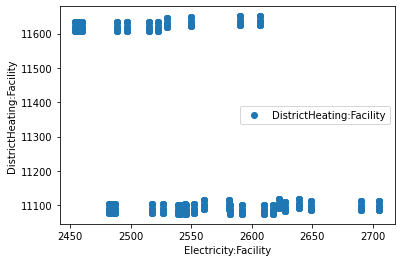

In [ ]:
_ = merged_result.plot(x=objectives[0], y=objectives[1], style = 'o')
plt.xlabel(objectives[0])
plt.ylabel(objectives[1])
plt.savefig(output_dir+'/obj_vs.png')

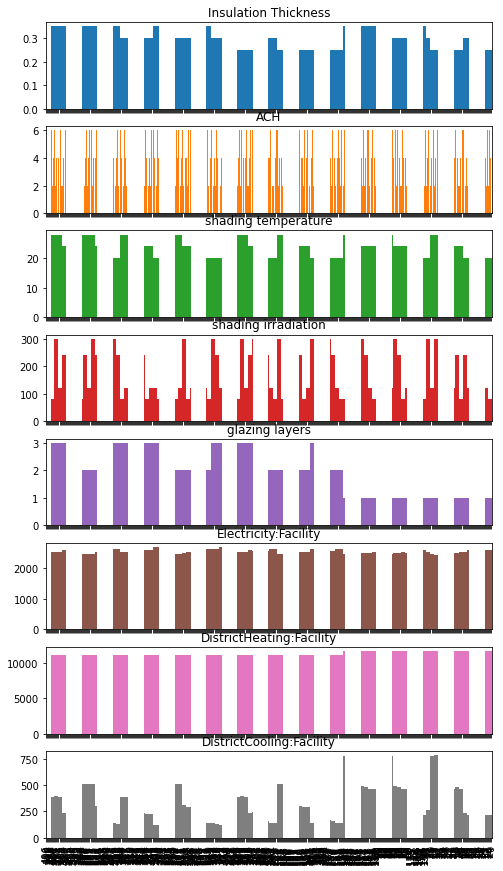

In [ ]:
outputs = merged_result.sort_values(by=objectives[1])
ax=outputs.plot.bar(subplots=True,legend=None, figsize=(8,15))
outputs.to_csv(output_dir + '/result' + '.csv', index = False)
plt.savefig(output_dir+'/sort_value.png')

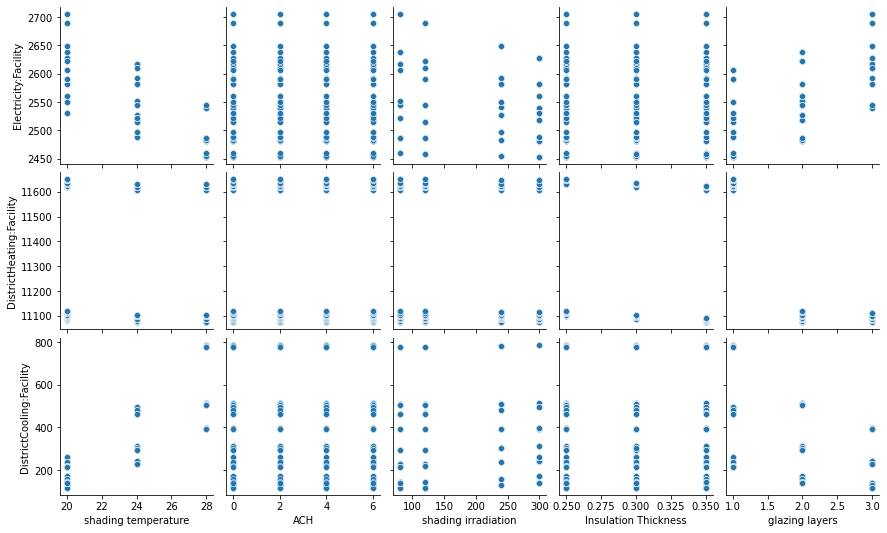

In [ ]:
var= list(set(merged_result.columns.tolist())-set(objectives))
_=pairplot(outputs,x_vars=var, y_vars=objectives, kind="scatter")
plt.savefig(output_dir+'/parametric_analysis.png')

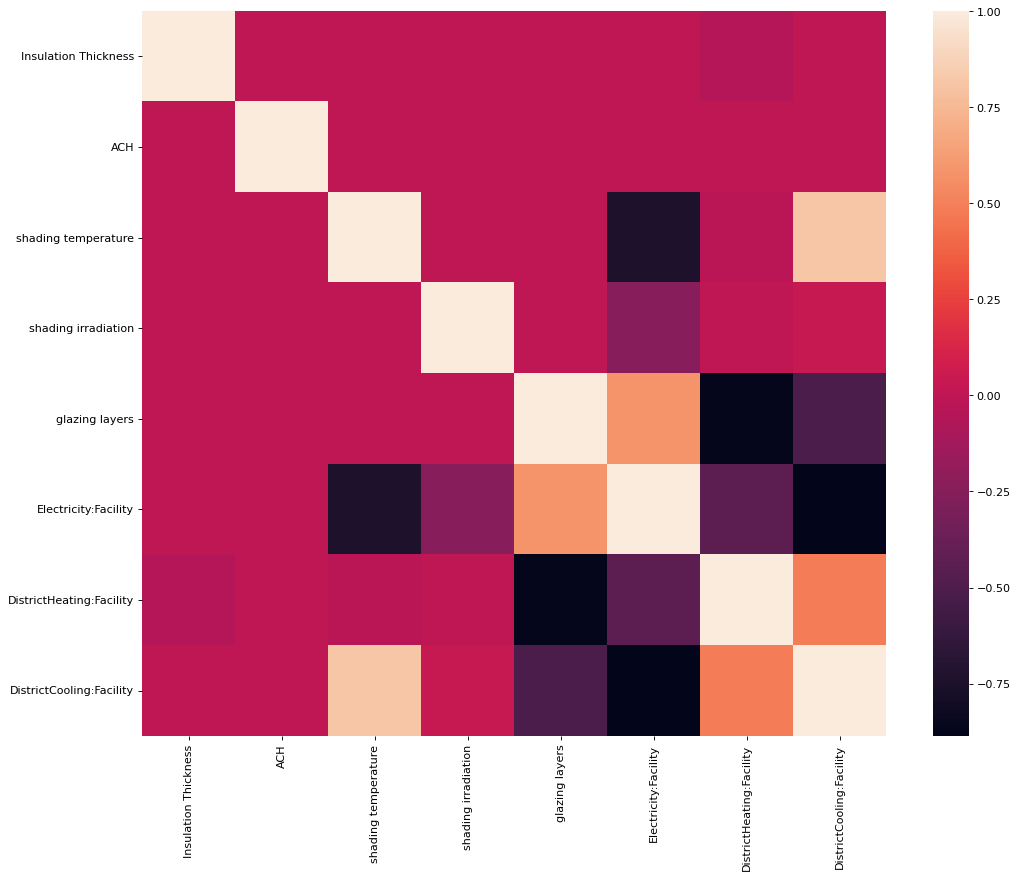

In [ ]:
plt.figure(figsize=(15, 12), dpi=80)
_= heatmap(outputs.corr())
plt.savefig(output_dir+'/heatmap_sam.png')